# PreProcessing


In [1]:
import os
import random
import shutil
import glob
import cv2
from glob import glob
import numpy as np
import pandas as pd
import gc
import pickle

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Reshape, concatenate, Concatenate, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard,LearningRateScheduler

from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.color import rgb2gray as rtg
from skimage.io import imread, imshow
from skimage.transform import resize
from PIL import Image
from datetime import datetime
import time
from keras.callbacks import CSVLogger
from deeplab import deeplabModel
from deeplabv1 import deeplab
from unet import unet

2023-11-29 00:40:59.175372: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-29 00:40:59.198531: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-29 00:40:59.198555: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-29 00:40:59.198573: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-29 00:40:59.203804: I tensorflow/core/platform/cpu_feature_g

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2023-11-29 00:41:00.254847: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-29 00:41:00.267510: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-29 00:41:00.267844: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
def load_data(img_height, img_width, images_to_be_loaded):
    IMAGES_PATH = "CVC-ClinicDB/TIF/Original/"
    MASKS_PATH = "CVC-ClinicDB/TIF/Ground Truth/"

    train_ids = glob(IMAGES_PATH + "*.tif")

    if images_to_be_loaded == -1:
        images_to_be_loaded = len(train_ids)

    X_train = np.zeros((images_to_be_loaded, img_height, img_width, 3), dtype=np.float32)
    Y_train = np.zeros((images_to_be_loaded, img_height, img_width), dtype=np.uint8)

    print('Resizing training images and masks: ' + str(images_to_be_loaded))
    for n, id_ in tqdm(enumerate(train_ids)):
        if n == images_to_be_loaded:
            break

        image_path = id_
        mask_path = image_path.replace("Original", "Ground Truth")

        image = imread(image_path)
        mask_ = imread(mask_path)
        

        mask = np.zeros((img_height, img_width), dtype=np.bool_)

        pillow_image = Image.fromarray(image)

        pillow_image = pillow_image.resize((img_height, img_width))
        image = np.array(pillow_image)

        X_train[n] = image / 255

        pillow_mask = Image.fromarray(mask_)
        pillow_mask = pillow_mask.resize((img_height, img_width), resample=Image.LANCZOS)
        mask_ = np.array(pillow_mask)

        for i in range(img_height):
            for j in range(img_width):
                if (mask_[i, j] >= 127).any():
                    mask[i, j] = 1

        Y_train[n] = mask

    Y_train = np.expand_dims(Y_train, axis=-1)

    return X_train, Y_train

In [4]:
img_size = 256
X, Y = load_data(img_size, img_size, -1)

Resizing training images and masks: 612


612it [00:57, 10.68it/s]


In [5]:
test_size = 0.2
validation_size = 0.5

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=validation_size, random_state=0)

In [6]:
train_total = len(X_train)
step = len(X_train)//4
print(train_total,step)

489 122


/home/kchang/anaconda3/envs/test1/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


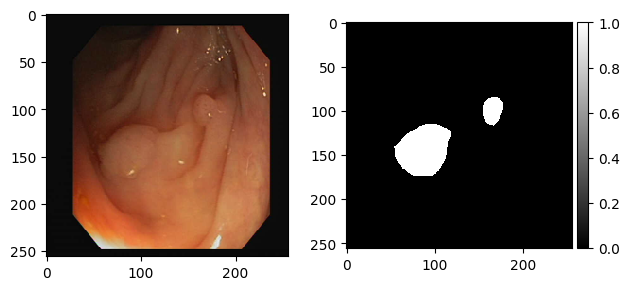

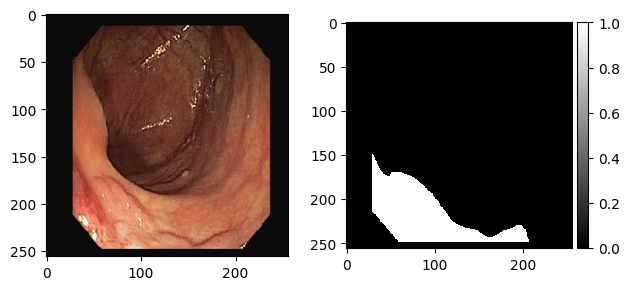

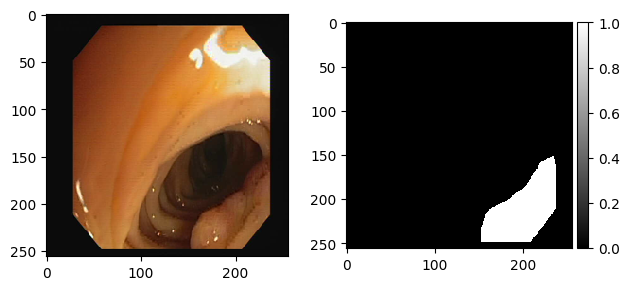

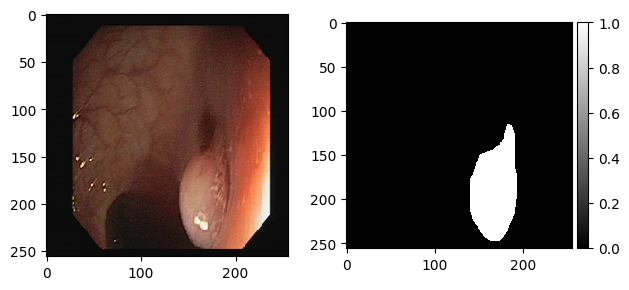

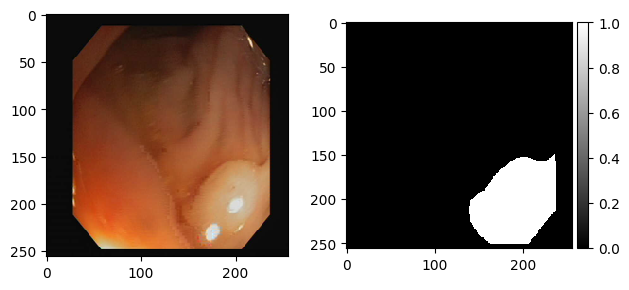

In [7]:
import random

for i in range(0,5):
    image_x = random.randint(0, 60)

    plt.subplot(1,2,1)
    imshow(X_val[image_x])

    plt.subplot(1,2,2)
    imshow(y_val[image_x], cmap='gray')
    plt.show()

In [8]:
import albumentations as A
from albumentations.augmentations import functional as F

aug_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ColorJitter(brightness=(0.6,1.6), contrast=0.2, saturation=0.1, hue=0.01, always_apply=True),
    A.Affine(scale=(0.5,1.5), translate_percent=(-0.125,0.125), rotate=(-180,180), shear=(-22.5,22), always_apply=True),
    A.GaussianBlur(blur_limit=(25, 25),sigma_limit=(0.001, 2.0),always_apply=False, p=0.5),
])

def augment_images():
    x_train_out = []
    y_train_out = []

    for i in range (len(X_train)):
        ug = aug_train(image=X_train[i], mask=y_train[i])
        x_train_out.append(ug['image'])  
        y_train_out.append(ug['mask'])

    return np.array(x_train_out), np.array(y_train_out)

In [9]:
from metrics import f1_score,dice_coeff,dice_loss, total_loss, IoU, zero_IoU

In [ ]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

from keras.layers import (
    Conv2D,
    BatchNormalization,
    Activation,
    Concatenate,
    Input,
    Dropout,
)
from keras.layers import (
    AveragePooling2D,
    GlobalAveragePooling2D,
    UpSampling2D,
    Reshape,
    Dense,
)
from keras.models import Model
from keras.applications import ResNet50, ResNet101
from keras.regularizers import l2
from tensorflow.python.keras.engine.keras_tensor import KerasTensor


def squeeze_and_excite(inputs: KerasTensor, ratio: int = 8) -> KerasTensor:
    """Function to apply Squeeze & Excitation to a feature map.

    Args:
        inputs (KerasTensor): Feature Map
        ratio (int, optional): Ratio for excitation in first dense layer. Defaults to 8.

    Returns:
        KerasTensor: Re-calibrated feature map.
    """
    init = inputs
    filters = init.shape[-1]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(
        filters // ratio,
        activation="relu",
        kernel_initializer="he_normal",
        use_bias=False,
    )(se)
    se = Dense(
        filters,
        activation="sigmoid",
        kernel_initializer="he_normal",
        use_bias=False,
    )(se)

    x = init * se
    return x


def ASPP(inputs: KerasTensor) -> KerasTensor:
    """Function to apply Atrous Spatial Pyramid Pooling on features from backbone.

    Args:
        inputs (KerasTensor): Features from backbone.

    Returns:
        KerasTensor: Features with better spatial context.
    """
    shape = inputs.shape
    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(inputs)
    y1 = Conv2D(256, 1, padding="same", use_bias=False, kernel_initializer="he_normal")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y1)

    # 1x1 Convolution
    y2 = Conv2D(256, 1, padding="same", use_bias=False, kernel_initializer="he_normal")(inputs)
    y2 = BatchNormalization()(y2)
    # y2 = Dropout(0.5)(y2)
    y2 = Activation("relu")(y2)

    # 3x3 Convolution, Dilation Rate - 12 or 6
    y3 = Conv2D(
        256, 3, padding="same", dilation_rate=6, use_bias=False, kernel_initializer="he_normal"
    )(inputs)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    # 3x3 Convolution, Dilation Rate - 24 or 12
    y4 = Conv2D(
        256, 3, padding="same", dilation_rate=12, use_bias=False, kernel_initializer="he_normal"
    )(inputs)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    # 3x3 Convolution, Dilation Rate - 36 or 18
    y5 = Conv2D(
        256, 3, padding="same", dilation_rate=18, use_bias=False, kernel_initializer="he_normal"
    )(inputs)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    # 1x1 Convolution on the concatenated Feature Map
    y = Concatenate()([y1, y2, y3, y4, y5])
    y = Conv2D(256, 1, padding="same", use_bias=False, kernel_initializer="he_normal")(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y


def createModel(modelType: str, shape: tuple[int] = (256, 256, 3)) -> Model:
    """Creates a Model with the specified backbone.

    Args:
        modelType (str): Choice of backbone. ResNet50 or ResNet101.
        shape (tuple[int]): Shape of input to the model. Defaults to (256, 256, 3).

    Returns:
        Model: Your DeepLabV3+ Model.
    """
    inputs = Input(shape)  # instantiating a tensor

    encoder = (
        ResNet101(weights="imagenet", include_top=False, input_tensor=inputs)
        if modelType == "ResNet101"
        else ResNet50(weights="imagenet", include_top=False, input_tensor=inputs)
    )

    image_features = encoder.get_layer(
        "conv4_block23_out" if modelType == "ResNet101" else "conv4_block6_out"
    ).output

    # High-Level Features
    x_a = ASPP(image_features)
    # Up-Sampling High-Level Features by 4
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)
    x_a = Dropout(0.5)(x_a)

    # Low-Level Features
    x_b = encoder.get_layer("conv2_block2_out").output

    # 1x1 Convolution on Low-Level Features
    x_b = Conv2D(
        filters=48, kernel_size=1, padding="same", use_bias=False, kernel_initializer="he_normal"
    )(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation("relu")(x_b)

    # Concatenating High-Level and Low-Level Features
    x = Concatenate()([x_a, x_b])
    x = Dropout(0.5)(x)
    # x = squeeze_and_excite(x)

    # 3x3 Convolution on Concatenated Map
    x = Conv2D(
        filters=256, kernel_size=3, padding="same", use_bias=False, kernel_initializer="he_normal"
    )(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = squeeze_and_excite(x)

    # 3x3 Convolution on Concatenated Map
    x = Conv2D(
        filters=256, kernel_size=3, padding="same", use_bias=False, kernel_initializer="he_normal"
    )(x)
    x = BatchNormalization()(x)
    # x = Dropout(0.5)(x)
    x = Activation("relu")(x)
    x = squeeze_and_excite(x)

    # Final Up-Sampling by 4
    x = UpSampling2D((4, 4), interpolation="bilinear")(x)
    x = Conv2D(1, 1)(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs, x)

    return model

In [10]:
seed_value = 58800
loss = 'binary_crossentropy'
ct = datetime.now()
EPOCHS = 600
dataset_type="cvcclinicdb"
model_type = "deeplabv3p"

model_path = 'ModelSaveTensorFlow/' + dataset_type + '_' + model_type + 'newaug'

In [11]:
from keras.optimizers import AdamW

deeplabv3p_model = createModel(modelType="ResNet101",shape=(256,256,3))
optimizer = AdamW(
    learning_rate = 0.00001, weight_decay = 0.004)
loss = 'binary_crossentropy'
deeplabv3p_model.compile(optimizer=optimizer, loss=loss,
                     metrics=['accuracy',f1_score,dice_coeff,dice_loss, total_loss, IoU, zero_IoU, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

2023-11-28 18:24:08.733123: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-28 18:24:08.733238: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-28 18:24:08.733286: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [12]:
step = 0
learning_rate = 1e-5
min_loss_for_saving = 0.2

start_time = time.time()

for epoch in range(0, EPOCHS):

    print(f'Training, epoch {epoch}')
    print('Learning Rate: ' + str(learning_rate))

    step += 1
    tf.keras.backend.clear_session()

    image_augmented, mask_augmented = augment_images()

    deeplabv3p_model.fit(x=image_augmented, y=mask_augmented, epochs=1, batch_size=16, validation_data=(X_val, y_val), verbose=1)

    prediction_valid = deeplabv3p_model.predict(X_val, verbose=1, batch_size=16)
    loss_valid = dice_metric_loss(y_val, prediction_valid)
    loss_valid = loss_valid.numpy()
    print("Loss Validation: " + str(loss_valid))

    prediction_test = deeplabv3p_model.predict(X_test, verbose=0, batch_size=16)
    loss_test = dice_metric_loss(y_test, prediction_test)
    loss_test = loss_test.numpy()
    print("Loss Test: " + str(loss_test))

    if min_loss_for_saving > loss_valid:
        min_loss_for_saving = loss_valid
        print("Saved model with val_loss: ", loss_valid)
        deeplabv3p_model.save(model_path)

    del image_augmented
    del mask_augmented
    tf.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()
    gc.collect()

    
elapsed_time = time.time() - start_time
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"Elapsed Time: {int(hours)}h {int(minutes)}m {int(seconds)}s")

Training, epoch 0
Learning Rate: 1e-05


2023-11-28 18:24:25.107265: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-28 18:24:26.965805: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-28 18:24:27.471421: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.81GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-11-28 18:24:27.471449: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.81GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-11-28 18

30/31 [============================>.] - ETA: 0s - loss: 0.6606 - accuracy: 0.6164 - f1_score: 0.2316 - dice_coeff: 0.1596 - dice_loss: 0.8404 - total_loss: 1.1707 - IoU: 0.0817 - zero_IoU: 0.5007 - precision: 0.1392 - recall: 0.7029

2023-11-28 18:24:49.991187: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.89GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-11-28 18:24:51.791994: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.89GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-11-28 18:24:51.792024: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.89GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


4/4 [==============================] - 1s 45ms/step
Loss Validation: 0.832319
Loss Test: 0.82713795
Training, epoch 1
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.8343167
Loss Test: 0.8296007
Training, epoch 2
Learning Rate: 1e-05
4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.84305257
Loss Test: 0.8391321
Training, epoch 3
Learning Rate: 1e-05
4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.85264736
Loss Test: 0.84954417
Training, epoch 4
Learning Rate: 1e-05


2023-11-28 18:25:31.691898: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 48ms/step
Loss Validation: 0.84909004
Loss Test: 0.8464538
Training, epoch 5
Learning Rate: 1e-05
4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.8511569
Loss Test: 0.8485892
Training, epoch 6
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.85242826
Loss Test: 0.84882
Training, epoch 7
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.86293375
Loss Test: 0.8592865
Training, epoch 8
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.86998934
Loss Test: 0.8673413
Training, epoch 9
Learning Rate: 1e-05
4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.87863874
Loss Test: 0.87573814
Training, epoch 10
Learning Rate: 1e-05


2023-11-28 18:26:37.925229: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.89259744
Loss Test: 0.8913669
Training, epoch 11
Learning Rate: 1e-05
4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.8869598
Loss Test: 0.886516
Training, epoch 12
Learning Rate: 1e-05
4/4 [==============================] - 1s 49ms/step
Loss Validation: 0.8910481
Loss Test: 0.8918507
Training, epoch 13
Learning Rate: 1e-05
4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.88695604
Loss Test: 0.89058924
Training, epoch 14
Learning Rate: 1e-05
4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.869006
Loss Test: 0.86658806
Training, epoch 15
Learning Rate: 1e-05
4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.8501179
Loss Test: 0.8402308
Training, epoch 16
Learning Rate: 1e-05


2023-11-28 18:27:44.332199: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.8256028
Loss Test: 0.8104588
Training, epoch 17
Learning Rate: 1e-05
4/4 [==============================] - 1s 48ms/step
Loss Validation: 0.7688234
Loss Test: 0.75828445
Training, epoch 18
Learning Rate: 1e-05
4/4 [==============================] - 1s 49ms/step
Loss Validation: 0.70362145
Loss Test: 0.6977186
Training, epoch 19
Learning Rate: 1e-05
4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.6221607
Loss Test: 0.6297623
Training, epoch 20
Learning Rate: 1e-05
4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.5723891
Loss Test: 0.59666216
Training, epoch 21
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.51733446
Loss Test: 0.54923975
Training, epoch 22
Learning Rate: 1e-05


2023-11-28 18:28:50.728780: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.49863267
Loss Test: 0.5252733
Training, epoch 23
Learning Rate: 1e-05
4/4 [==============================] - 0s 42ms/step
Loss Validation: 0.48838282
Loss Test: 0.50553256
Training, epoch 24
Learning Rate: 1e-05
4/4 [==============================] - 1s 47ms/step
Loss Validation: 0.46441352
Loss Test: 0.4737928
Training, epoch 25
Learning Rate: 1e-05
4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.45969278
Loss Test: 0.46832603
Training, epoch 26
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.47299504
Loss Test: 0.4748929
Training, epoch 27
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.4535846
Loss Test: 0.45277405
Training, epoch 28
Learning Rate: 1e-05


2023-11-28 18:29:56.980615: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.43742913
Loss Test: 0.43317646
Training, epoch 29
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.43324023
Loss Test: 0.4261511
Training, epoch 30
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.42038053
Loss Test: 0.41500604
Training, epoch 31
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.42249012
Loss Test: 0.4112574
Training, epoch 32
Learning Rate: 1e-05
4/4 [==============================] - 0s 42ms/step
Loss Validation: 0.40892678
Loss Test: 0.3999949
Training, epoch 33
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.40689403
Loss Test: 0.4000457
Training, epoch 34
Learning Rate: 1e-05


2023-11-28 18:31:03.360012: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.37599027
Loss Test: 0.37127048
Training, epoch 35
Learning Rate: 1e-05
4/4 [==============================] - 1s 53ms/step
Loss Validation: 0.34767193
Loss Test: 0.34126318
Training, epoch 36
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.32075548
Loss Test: 0.31731868
Training, epoch 37
Learning Rate: 1e-05
4/4 [==============================] - 1s 45ms/step
Loss Validation: 0.3113852
Loss Test: 0.30262405
Training, epoch 38
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.30209982
Loss Test: 0.2963404
Training, epoch 39
Learning Rate: 1e-05
4/4 [==============================] - 0s 47ms/step
Loss Validation: 0.28163671
Loss Test: 0.27496362
Training, epoch 40
Learning Rate: 1e-05


2023-11-28 18:32:09.874377: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.2667889
Loss Test: 0.26073682
Training, epoch 41
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.27309036
Loss Test: 0.2642771
Training, epoch 42
Learning Rate: 1e-05
4/4 [==============================] - 0s 42ms/step
Loss Validation: 0.26090735
Loss Test: 0.2510786
Training, epoch 43
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.25574088
Loss Test: 0.24562609
Training, epoch 44
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.2530678
Loss Test: 0.24052668
Training, epoch 45
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.257904
Loss Test: 0.24700218
Training, epoch 46
Learning Rate: 1e-05


2023-11-28 18:33:16.262406: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.2535166
Loss Test: 0.2413044
Training, epoch 47
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.2489813
Loss Test: 0.23397118
Training, epoch 48
Learning Rate: 1e-05
4/4 [==============================] - 0s 42ms/step
Loss Validation: 0.24681199
Loss Test: 0.23292208
Training, epoch 49
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.25235146
Loss Test: 0.23915523
Training, epoch 50
Learning Rate: 1e-05
4/4 [==============================] - 1s 45ms/step
Loss Validation: 0.2533524
Loss Test: 0.24004924
Training, epoch 51
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.2520365
Loss Test: 0.23858124
Training, epoch 52
Learning Rate: 1e-05


2023-11-28 18:34:22.628091: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.26661205
Loss Test: 0.25366586
Training, epoch 53
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.27132428
Loss Test: 0.25782365
Training, epoch 54
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.26561707
Loss Test: 0.2528848
Training, epoch 55
Learning Rate: 1e-05
4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.25901902
Loss Test: 0.24336326
Training, epoch 56
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.24739754
Loss Test: 0.23461121
Training, epoch 57
Learning Rate: 1e-05
4/4 [==============================] - 0s 47ms/step
Loss Validation: 0.23493725
Loss Test: 0.22065103
Training, epoch 58
Learning Rate: 1e-05


2023-11-28 18:35:29.061452: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 1s 50ms/step
Loss Validation: 0.21942526
Loss Test: 0.20790637
Training, epoch 59
Learning Rate: 1e-05
4/4 [==============================] - 1s 48ms/step
Loss Validation: 0.21382314
Loss Test: 0.20008475
Training, epoch 60
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.20761365
Loss Test: 0.19459736
Training, epoch 61
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.2125752
Loss Test: 0.19925672
Training, epoch 62
Learning Rate: 1e-05
4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.22380936
Loss Test: 0.20894116
Training, epoch 63
Learning Rate: 1e-05
4/4 [==============================] - 1s 54ms/step
Loss Validation: 0.21835917
Loss Test: 0.20375174
Training, epoch 64
Learning Rate: 1e-05


2023-11-28 18:36:35.625999: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.21755588
Loss Test: 0.20132607
Training, epoch 65
Learning Rate: 1e-05
4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.21513748
Loss Test: 0.20079023
Training, epoch 66
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.21340376
Loss Test: 0.19977587
Training, epoch 67
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.21023566
Loss Test: 0.19568634
Training, epoch 68
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.20046794
Loss Test: 0.1869368
Training, epoch 69
Learning Rate: 1e-05
4/4 [==============================] - 1s 48ms/step
Loss Validation: 0.193236
Loss Test: 0.1806826
Saved model with val_loss:  0.193236
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 70
Learning Rate: 1e-05


2023-11-28 18:37:59.356868: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.19536924
Loss Test: 0.18287301
Training, epoch 71
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.21814233
Loss Test: 0.20050448
Training, epoch 72
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.22351378
Loss Test: 0.20619512
Training, epoch 73
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.22502166
Loss Test: 0.20679188
Training, epoch 74
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.22056746
Loss Test: 0.20252514
Training, epoch 75
Learning Rate: 1e-05
4/4 [==============================] - 1s 54ms/step
Loss Validation: 0.2217738
Loss Test: 0.20489305
Training, epoch 76
Learning Rate: 1e-05


2023-11-28 18:39:05.748675: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.22540212
Loss Test: 0.20931298
Training, epoch 77
Learning Rate: 1e-05
4/4 [==============================] - 1s 49ms/step
Loss Validation: 0.22992498
Loss Test: 0.21351898
Training, epoch 78
Learning Rate: 1e-05
4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.21929926
Loss Test: 0.20578039
Training, epoch 79
Learning Rate: 1e-05
4/4 [==============================] - 1s 50ms/step
Loss Validation: 0.23199195
Loss Test: 0.219634
Training, epoch 80
Learning Rate: 1e-05
4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.2254017
Loss Test: 0.21488482
Training, epoch 81
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.23291671
Loss Test: 0.2228604
Training, epoch 82
Learning Rate: 1e-05


2023-11-28 18:40:12.387680: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.2260313
Loss Test: 0.2164917
Training, epoch 83
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.2186395
Loss Test: 0.20976663
Training, epoch 84
Learning Rate: 1e-05
4/4 [==============================] - 1s 54ms/step
Loss Validation: 0.21289873
Loss Test: 0.20538795
Training, epoch 85
Learning Rate: 1e-05
4/4 [==============================] - 1s 52ms/step
Loss Validation: 0.20611781
Loss Test: 0.19468307
Training, epoch 86
Learning Rate: 1e-05
4/4 [==============================] - 1s 48ms/step
Loss Validation: 0.20761853
Loss Test: 0.1959604
Training, epoch 87
Learning Rate: 1e-05
4/4 [==============================] - 1s 48ms/step
Loss Validation: 0.19853443
Loss Test: 0.18579149
Training, epoch 88
Learning Rate: 1e-05


2023-11-28 18:41:18.923007: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 42ms/step
Loss Validation: 0.19983202
Loss Test: 0.18751884
Training, epoch 89
Learning Rate: 1e-05
4/4 [==============================] - 0s 47ms/step
Loss Validation: 0.19430542
Loss Test: 0.18193609
Training, epoch 90
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.20580071
Loss Test: 0.19153142
Training, epoch 91
Learning Rate: 1e-05
4/4 [==============================] - 0s 42ms/step
Loss Validation: 0.2040748
Loss Test: 0.18790168
Training, epoch 92
Learning Rate: 1e-05
4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.18610609
Loss Test: 0.17138362
Saved model with val_loss:  0.18610609
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 93
Learning Rate: 1e-05


2023-11-28 18:42:30.385404: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.20429045
Loss Test: 0.1914947
Training, epoch 94
Learning Rate: 1e-05
4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.21154308
Loss Test: 0.20185322
Training, epoch 95
Learning Rate: 1e-05
4/4 [==============================] - 1s 50ms/step
Loss Validation: 0.20149308
Loss Test: 0.1913917
Training, epoch 96
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.20305312
Loss Test: 0.19520402
Training, epoch 97
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.20318788
Loss Test: 0.19772089
Training, epoch 98
Learning Rate: 1e-05
4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.21002346
Loss Test: 0.20435375
Training, epoch 99
Learning Rate: 1e-05


2023-11-28 18:43:36.600491: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 1s 45ms/step
Loss Validation: 0.21050024
Loss Test: 0.20409983
Training, epoch 100
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.20849967
Loss Test: 0.2001664
Training, epoch 101
Learning Rate: 1e-05
4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.21341485
Loss Test: 0.20583814
Training, epoch 102
Learning Rate: 1e-05
4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.19399297
Loss Test: 0.18669516
Training, epoch 103
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.20122135
Loss Test: 0.19086617
Training, epoch 104
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.205697
Loss Test: 0.19599652
Training, epoch 105
Learning Rate: 1e-05


2023-11-28 18:44:42.872946: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.2081632
Loss Test: 0.20142275
Training, epoch 106
Learning Rate: 1e-05
4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.2087884
Loss Test: 0.20580018
Training, epoch 107
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.20529121
Loss Test: 0.20146531
Training, epoch 108
Learning Rate: 1e-05
4/4 [==============================] - 1s 52ms/step
Loss Validation: 0.19372362
Loss Test: 0.19117254
Training, epoch 109
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.19041812
Loss Test: 0.18473536
Training, epoch 110
Learning Rate: 1e-05
4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.19384974
Loss Test: 0.18649822
Training, epoch 111
Learning Rate: 1e-05


2023-11-28 18:45:49.279177: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.19206595
Loss Test: 0.18653214
Training, epoch 112
Learning Rate: 1e-05
4/4 [==============================] - 1s 45ms/step
Loss Validation: 0.19886422
Loss Test: 0.19196916
Training, epoch 113
Learning Rate: 1e-05
4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.20501292
Loss Test: 0.19988084
Training, epoch 114
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.21307218
Loss Test: 0.20680779
Training, epoch 115
Learning Rate: 1e-05
4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.21775901
Loss Test: 0.21232629
Training, epoch 116
Learning Rate: 1e-05
4/4 [==============================] - 1s 52ms/step
Loss Validation: 0.21876097
Loss Test: 0.21635985
Training, epoch 117
Learning Rate: 1e-05


2023-11-28 18:46:55.767565: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 48ms/step
Loss Validation: 0.20691997
Loss Test: 0.20358622
Training, epoch 118
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.20131093
Loss Test: 0.2020362
Training, epoch 119
Learning Rate: 1e-05
4/4 [==============================] - 1s 52ms/step
Loss Validation: 0.20514113
Loss Test: 0.20528418
Training, epoch 120
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.20552045
Loss Test: 0.20047355
Training, epoch 121
Learning Rate: 1e-05
4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.19733971
Loss Test: 0.19032884
Training, epoch 122
Learning Rate: 1e-05
4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.19151598
Loss Test: 0.18726605
Training, epoch 123
Learning Rate: 1e-05


2023-11-28 18:48:02.197511: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.19978356
Loss Test: 0.194341
Training, epoch 124
Learning Rate: 1e-05
4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.20011908
Loss Test: 0.19601506
Training, epoch 125
Learning Rate: 1e-05
4/4 [==============================] - 0s 41ms/step
Loss Validation: 0.21183485
Loss Test: 0.2073223
Training, epoch 126
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.26931304
Loss Test: 0.2687574
Training, epoch 127
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.24158514
Loss Test: 0.24070287
Training, epoch 128
Learning Rate: 1e-05
4/4 [==============================] - 0s 47ms/step
Loss Validation: 0.23055178
Loss Test: 0.22497702
Training, epoch 129
Learning Rate: 1e-05


2023-11-28 18:49:08.548763: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.22639418
Loss Test: 0.22169685
Training, epoch 130
Learning Rate: 1e-05
4/4 [==============================] - 0s 41ms/step
Loss Validation: 0.23385435
Loss Test: 0.23028713
Training, epoch 131
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.25000805
Loss Test: 0.24628055
Training, epoch 132
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.22670746
Loss Test: 0.2219125
Training, epoch 133
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.21372294
Loss Test: 0.20227581
Training, epoch 134
Learning Rate: 1e-05
4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.17352611
Loss Test: 0.16700047
Saved model with val_loss:  0.17352611
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 135
Learning Rate: 1e-05


2023-11-28 18:50:31.281128: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.17004997
Loss Test: 0.16474885
Saved model with val_loss:  0.17004997
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 136
Learning Rate: 1e-05
4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.17533827
Loss Test: 0.171628
Training, epoch 137
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.17812252
Loss Test: 0.17375648
Training, epoch 138
Learning Rate: 1e-05
4/4 [==============================] - 1s 46ms/step
Loss Validation: 0.17397451
Loss Test: 0.17055905
Training, epoch 139
Learning Rate: 1e-05


2023-11-28 18:51:31.632468: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.17929661
Loss Test: 0.17786586
Training, epoch 140
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.17574799
Loss Test: 0.17309558
Training, epoch 141
Learning Rate: 1e-05
4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.16734892
Loss Test: 0.16315287
Saved model with val_loss:  0.16734892
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 142
Learning Rate: 1e-05
4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.16108948
Loss Test: 0.15889424
Saved model with val_loss:  0.16108948
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 143
Learning Rate: 1e-05


2023-11-28 18:52:48.258586: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.15448105
Loss Test: 0.15190238
Saved model with val_loss:  0.15448105
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 144
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.1556837
Loss Test: 0.15480626
Training, epoch 145
Learning Rate: 1e-05
4/4 [==============================] - 0s 41ms/step
Loss Validation: 0.15237111
Loss Test: 0.15249246
Saved model with val_loss:  0.15237111
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 146
Learning Rate: 1e-05


2023-11-28 18:53:53.833987: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 42ms/step
Loss Validation: 0.15555441
Loss Test: 0.15593326
Training, epoch 147
Learning Rate: 1e-05
4/4 [==============================] - 1s 49ms/step
Loss Validation: 0.1570211
Loss Test: 0.15475029
Training, epoch 148
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.15913677
Loss Test: 0.15672553
Training, epoch 149
Learning Rate: 1e-05
4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.159235
Loss Test: 0.15665776
Training, epoch 150
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.15099978
Loss Test: 0.14761913
Saved model with val_loss:  0.15099978
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 151
Learning Rate: 1e-05


2023-11-28 18:55:05.261493: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.14517313
Loss Test: 0.13891923
Saved model with val_loss:  0.14517313
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 152
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.13607037
Loss Test: 0.1292581
Saved model with val_loss:  0.13607037
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 153
Learning Rate: 1e-05
4/4 [==============================] - 1s 48ms/step
Loss Validation: 0.13924354
Loss Test: 0.13471848
Training, epoch 154
Learning Rate: 1e-05


2023-11-28 18:56:10.776082: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 47ms/step
Loss Validation: 0.13435441
Loss Test: 0.1297543
Saved model with val_loss:  0.13435441
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 155
Learning Rate: 1e-05
4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.12808436
Loss Test: 0.123483
Saved model with val_loss:  0.12808436
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 156
Learning Rate: 1e-05
4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.13881862
Loss Test: 0.13162649
Training, epoch 157
Learning Rate: 1e-05


2023-11-28 18:57:16.397821: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.14312357
Loss Test: 0.13651091
Training, epoch 158
Learning Rate: 1e-05
4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.1440323
Loss Test: 0.13906443
Training, epoch 159
Learning Rate: 1e-05
4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.14543784
Loss Test: 0.14305544
Training, epoch 160
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.14917767
Loss Test: 0.147165
Training, epoch 161
Learning Rate: 1e-05
4/4 [==============================] - 1s 47ms/step
Loss Validation: 0.1419118
Loss Test: 0.13843709
Training, epoch 162
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.14361042
Loss Test: 0.14094287
Training, epoch 163
Learning Rate: 1e-05


2023-11-28 18:58:22.522845: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.14684802
Loss Test: 0.1455434
Training, epoch 164
Learning Rate: 1e-05
4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.15841615
Loss Test: 0.15556711
Training, epoch 165
Learning Rate: 1e-05
4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.15482616
Loss Test: 0.15327626
Training, epoch 166
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.14230347
Loss Test: 0.14899409
Training, epoch 167
Learning Rate: 1e-05
4/4 [==============================] - 0s 47ms/step
Loss Validation: 0.13543385
Loss Test: 0.13287067
Training, epoch 168
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.134368
Loss Test: 0.13163704
Training, epoch 169
Learning Rate: 1e-05


2023-11-28 18:59:28.644707: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.12538427
Loss Test: 0.119128704
Saved model with val_loss:  0.12538427
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 170
Learning Rate: 1e-05
4/4 [==============================] - 0s 42ms/step
Loss Validation: 0.11908883
Loss Test: 0.11529267
Saved model with val_loss:  0.11908883
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 171
Learning Rate: 1e-05
4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.12429553
Loss Test: 0.12204695
Training, epoch 172
Learning Rate: 1e-05


2023-11-28 19:00:34.128097: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 47ms/step
Loss Validation: 0.13033241
Loss Test: 0.12842476
Training, epoch 173
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.12869793
Loss Test: 0.13121766
Training, epoch 174
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.12828034
Loss Test: 0.12910932
Training, epoch 175
Learning Rate: 1e-05
4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.123938024
Loss Test: 0.124975204
Training, epoch 176
Learning Rate: 1e-05
4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.12811714
Loss Test: 0.1284625
Training, epoch 177
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.13040835
Loss Test: 0.13175261
Training, epoch 178
Learning Rate: 1e-05


2023-11-28 19:01:40.009141: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.13115859
Loss Test: 0.13142377
Training, epoch 179
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.12527102
Loss Test: 0.124901414
Training, epoch 180
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.12296611
Loss Test: 0.122365534
Training, epoch 181
Learning Rate: 1e-05
4/4 [==============================] - 1s 50ms/step
Loss Validation: 0.12256491
Loss Test: 0.12341267
Training, epoch 182
Learning Rate: 1e-05
4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.12764841
Loss Test: 0.12779433
Training, epoch 183
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.12349337
Loss Test: 0.12373561
Training, epoch 184
Learning Rate: 1e-05


2023-11-28 19:02:46.303488: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.11549276
Loss Test: 0.11574972
Saved model with val_loss:  0.11549276
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 185
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.1087212
Loss Test: 0.10815388
Saved model with val_loss:  0.1087212
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 186
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.10670179
Loss Test: 0.105472386
Saved model with val_loss:  0.10670179
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 187
Learning Rate: 1e-05


2023-11-28 19:04:08.296775: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 41ms/step
Loss Validation: 0.1049456
Loss Test: 0.104040146
Saved model with val_loss:  0.1049456
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 188
Learning Rate: 1e-05
4/4 [==============================] - 0s 47ms/step
Loss Validation: 0.11110765
Loss Test: 0.10902405
Training, epoch 189
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.10971761
Loss Test: 0.10874826
Training, epoch 190
Learning Rate: 1e-05
4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.11460096
Loss Test: 0.11511576
Training, epoch 191
Learning Rate: 1e-05


2023-11-28 19:05:08.552864: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.12751764
Loss Test: 0.12818432
Training, epoch 192
Learning Rate: 1e-05
4/4 [==============================] - 0s 47ms/step
Loss Validation: 0.12329644
Loss Test: 0.1251291
Training, epoch 193
Learning Rate: 1e-05
4/4 [==============================] - 1s 50ms/step
Loss Validation: 0.12640512
Loss Test: 0.12820601
Training, epoch 194
Learning Rate: 1e-05
4/4 [==============================] - 0s 42ms/step
Loss Validation: 0.12876302
Loss Test: 0.13111562
Training, epoch 195
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.10947591
Loss Test: 0.112021565
Training, epoch 196
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.111632645
Loss Test: 0.112584114
Training, epoch 197
Learning Rate: 1e-05


2023-11-28 19:06:14.780899: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.10615176
Loss Test: 0.10786682
Training, epoch 198
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.10453266
Loss Test: 0.1063773
Saved model with val_loss:  0.10453266
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 199
Learning Rate: 1e-05
4/4 [==============================] - 1s 43ms/step
Loss Validation: 0.10192752
Loss Test: 0.10372126
Saved model with val_loss:  0.10192752
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 200
Learning Rate: 1e-05


2023-11-28 19:07:20.981139: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.10095817
Loss Test: 0.103417695
Saved model with val_loss:  0.10095817
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 201
Learning Rate: 1e-05
4/4 [==============================] - 1s 50ms/step
Loss Validation: 0.098804235
Loss Test: 0.09842676
Saved model with val_loss:  0.098804235
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 202
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.09719634
Loss Test: 0.09594995
Saved model with val_loss:  0.09719634
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 203
Learning Rate: 1e-05


2023-11-28 19:08:44.472134: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.0972622
Loss Test: 0.09769994
Training, epoch 204
Learning Rate: 1e-05
4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.09817231
Loss Test: 0.09930098
Training, epoch 205
Learning Rate: 1e-05
4/4 [==============================] - 1s 50ms/step
Loss Validation: 0.1000461
Loss Test: 0.100998044
Training, epoch 206
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.09943694
Loss Test: 0.09928596
Training, epoch 207
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.09725654
Loss Test: 0.097218275
Training, epoch 208
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.10012424
Loss Test: 0.09931624
Training, epoch 209
Learning Rate: 1e-05


2023-11-28 19:09:50.531057: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.095062494
Loss Test: 0.095452964
Saved model with val_loss:  0.095062494
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 210
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.095785916
Loss Test: 0.096560955
Training, epoch 211
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.09607643
Loss Test: 0.09592396
Training, epoch 212
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.100445986
Loss Test: 0.100231886
Training, epoch 213
Learning Rate: 1e-05


2023-11-28 19:10:50.749000: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.09926331
Loss Test: 0.09977645
Training, epoch 214
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.10390067
Loss Test: 0.10270339
Training, epoch 215
Learning Rate: 1e-05
4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.10478121
Loss Test: 0.10585296
Training, epoch 216
Learning Rate: 1e-05
4/4 [==============================] - 1s 50ms/step
Loss Validation: 0.101762235
Loss Test: 0.10378182
Training, epoch 217
Learning Rate: 1e-05
4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.103441775
Loss Test: 0.10573816
Training, epoch 218
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.106933594
Loss Test: 0.10803336
Training, epoch 219
Learning Rate: 1e-05


2023-11-28 19:11:56.733673: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.10392517
Loss Test: 0.10520786
Training, epoch 220
Learning Rate: 1e-05
4/4 [==============================] - 1s 50ms/step
Loss Validation: 0.10149008
Loss Test: 0.102641106
Training, epoch 221
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.09791529
Loss Test: 0.09721565
Training, epoch 222
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.09920138
Loss Test: 0.09784371
Training, epoch 223
Learning Rate: 1e-05
4/4 [==============================] - 1s 45ms/step
Loss Validation: 0.09847772
Loss Test: 0.09845579
Training, epoch 224
Learning Rate: 1e-05
4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.10557276
Loss Test: 0.10741264
Training, epoch 225
Learning Rate: 1e-05


2023-11-28 19:13:02.498219: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 49ms/step
Loss Validation: 0.106666565
Loss Test: 0.10764438
Training, epoch 226
Learning Rate: 1e-05
4/4 [==============================] - 1s 42ms/step
Loss Validation: 0.10808349
Loss Test: 0.109140575
Training, epoch 227
Learning Rate: 1e-05
4/4 [==============================] - 1s 42ms/step
Loss Validation: 0.12596565
Loss Test: 0.12603891
Training, epoch 228
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.13014996
Loss Test: 0.13133258
Training, epoch 229
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.11720359
Loss Test: 0.11958897
Training, epoch 230
Learning Rate: 1e-05
4/4 [==============================] - 0s 49ms/step
Loss Validation: 0.115790725
Loss Test: 0.11780512
Training, epoch 231
Learning Rate: 1e-05


2023-11-28 19:14:09.066107: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.10929632
Loss Test: 0.11083835
Training, epoch 232
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.114480495
Loss Test: 0.117441654
Training, epoch 233
Learning Rate: 1e-05
4/4 [==============================] - 0s 42ms/step
Loss Validation: 0.11571735
Loss Test: 0.11943644
Training, epoch 234
Learning Rate: 1e-05
4/4 [==============================] - 1s 48ms/step
Loss Validation: 0.117702305
Loss Test: 0.12033248
Training, epoch 235
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.12177378
Loss Test: 0.12388617
Training, epoch 236
Learning Rate: 1e-05
4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.11171073
Loss Test: 0.112635076
Training, epoch 237
Learning Rate: 1e-05


2023-11-28 19:15:14.450109: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.10200143
Loss Test: 0.10402781
Training, epoch 238
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.09780669
Loss Test: 0.09970206
Training, epoch 239
Learning Rate: 1e-05
4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.091668725
Loss Test: 0.09387851
Saved model with val_loss:  0.091668725
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 240
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.08987975
Loss Test: 0.09070861
Saved model with val_loss:  0.08987975
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 241
Learning Rate: 1e-05


2023-11-28 19:16:30.824751: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.09712529
Loss Test: 0.098219335
Training, epoch 242
Learning Rate: 1e-05
4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.102535665
Loss Test: 0.10328281
Training, epoch 243
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.10404235
Loss Test: 0.10413355
Training, epoch 244
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.10402852
Loss Test: 0.103625655
Training, epoch 245
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.10277957
Loss Test: 0.102160454
Training, epoch 246
Learning Rate: 1e-05
4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.102458894
Loss Test: 0.10220951
Training, epoch 247
Learning Rate: 1e-05


2023-11-28 19:17:36.544971: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.09878296
Loss Test: 0.0976789
Training, epoch 248
Learning Rate: 1e-05
4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.09861362
Loss Test: 0.09789777
Training, epoch 249
Learning Rate: 1e-05
4/4 [==============================] - 1s 52ms/step
Loss Validation: 0.099496365
Loss Test: 0.09866667
Training, epoch 250
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.10232121
Loss Test: 0.10025376
Training, epoch 251
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.09824443
Loss Test: 0.097348034
Training, epoch 252
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.102057874
Loss Test: 0.10088307
Training, epoch 253
Learning Rate: 1e-05


2023-11-28 19:18:42.150709: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 1s 56ms/step
Loss Validation: 0.09871346
Loss Test: 0.09845424
Training, epoch 254
Learning Rate: 1e-05
4/4 [==============================] - 0s 48ms/step
Loss Validation: 0.088374674
Loss Test: 0.088148534
Saved model with val_loss:  0.088374674
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 255
Learning Rate: 1e-05
4/4 [==============================] - 1s 47ms/step
Loss Validation: 0.08260846
Loss Test: 0.083114445
Saved model with val_loss:  0.08260846
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 256
Learning Rate: 1e-05


2023-11-28 19:19:48.474783: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 42ms/step
Loss Validation: 0.08469635
Loss Test: 0.08324528
Training, epoch 257
Learning Rate: 1e-05
4/4 [==============================] - 1s 50ms/step
Loss Validation: 0.0910418
Loss Test: 0.0897882
Training, epoch 258
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.098039925
Loss Test: 0.09550291
Training, epoch 259
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.09939653
Loss Test: 0.09711158
Training, epoch 260
Learning Rate: 1e-05
4/4 [==============================] - 1s 50ms/step
Loss Validation: 0.10567266
Loss Test: 0.102393806
Training, epoch 261
Learning Rate: 1e-05
4/4 [==============================] - 0s 47ms/step
Loss Validation: 0.09500235
Loss Test: 0.09360063
Training, epoch 262
Learning Rate: 1e-05


2023-11-28 19:20:54.208860: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 47ms/step
Loss Validation: 0.092258096
Loss Test: 0.093716264
Training, epoch 263
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.08691752
Loss Test: 0.08898395
Training, epoch 264
Learning Rate: 1e-05
4/4 [==============================] - 1s 50ms/step
Loss Validation: 0.08736193
Loss Test: 0.08862531
Training, epoch 265
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.08788258
Loss Test: 0.08743262
Training, epoch 266
Learning Rate: 1e-05
4/4 [==============================] - 1s 49ms/step
Loss Validation: 0.08791196
Loss Test: 0.08670151
Training, epoch 267
Learning Rate: 1e-05
4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.08678603
Loss Test: 0.08657181
Training, epoch 268
Learning Rate: 1e-05


2023-11-28 19:22:00.351934: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 1s 41ms/step
Loss Validation: 0.08572167
Loss Test: 0.087426126
Training, epoch 269
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.08441067
Loss Test: 0.08376926
Training, epoch 270
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.086054444
Loss Test: 0.08783847
Training, epoch 271
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.084352195
Loss Test: 0.08457053
Training, epoch 272
Learning Rate: 1e-05
4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.085502565
Loss Test: 0.08499819
Training, epoch 273
Learning Rate: 1e-05
4/4 [==============================] - 0s 42ms/step
Loss Validation: 0.08509743
Loss Test: 0.08747065
Training, epoch 274
Learning Rate: 1e-05


2023-11-28 19:23:05.774695: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.085795164
Loss Test: 0.08736795
Training, epoch 275
Learning Rate: 1e-05
4/4 [==============================] - 1s 49ms/step
Loss Validation: 0.090685606
Loss Test: 0.09151888
Training, epoch 276
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.08810097
Loss Test: 0.090477705
Training, epoch 277
Learning Rate: 1e-05
4/4 [==============================] - 1s 54ms/step
Loss Validation: 0.097014606
Loss Test: 0.10268569
Training, epoch 278
Learning Rate: 1e-05
4/4 [==============================] - 1s 52ms/step
Loss Validation: 0.0884313
Loss Test: 0.09215742
Training, epoch 279
Learning Rate: 1e-05
4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.091438055
Loss Test: 0.094800234
Training, epoch 280
Learning Rate: 1e-05


2023-11-28 19:24:11.909310: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.10158974
Loss Test: 0.10427481
Training, epoch 281
Learning Rate: 1e-05
4/4 [==============================] - 1s 52ms/step
Loss Validation: 0.10445577
Loss Test: 0.1043452
Training, epoch 282
Learning Rate: 1e-05
4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.09929556
Loss Test: 0.100339174
Training, epoch 283
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.09995091
Loss Test: 0.10600519
Training, epoch 284
Learning Rate: 1e-05
4/4 [==============================] - 1s 54ms/step
Loss Validation: 0.09024531
Loss Test: 0.097211
Training, epoch 285
Learning Rate: 1e-05
4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.09059942
Loss Test: 0.096218646
Training, epoch 286
Learning Rate: 1e-05


2023-11-28 19:25:17.715573: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 1s 47ms/step
Loss Validation: 0.08549017
Loss Test: 0.09009725
Training, epoch 287
Learning Rate: 1e-05
4/4 [==============================] - 1s 49ms/step
Loss Validation: 0.08454692
Loss Test: 0.08813244
Training, epoch 288
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.08396214
Loss Test: 0.09051806
Training, epoch 289
Learning Rate: 1e-05
4/4 [==============================] - 1s 48ms/step
Loss Validation: 0.07991898
Loss Test: 0.08586329
Saved model with val_loss:  0.07991898
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 290
Learning Rate: 1e-05


2023-11-28 19:26:17.996610: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 1s 52ms/step
Loss Validation: 0.08100414
Loss Test: 0.08755028
Training, epoch 291
Learning Rate: 1e-05
4/4 [==============================] - 1s 52ms/step
Loss Validation: 0.07878083
Loss Test: 0.08170867
Saved model with val_loss:  0.07878083
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 292
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.07656312
Loss Test: 0.07974923
Saved model with val_loss:  0.07656312
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 293
Learning Rate: 1e-05


2023-11-28 19:27:23.643189: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.07768369
Loss Test: 0.07964182
Training, epoch 294
Learning Rate: 1e-05
4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.07718068
Loss Test: 0.08031869
Training, epoch 295
Learning Rate: 1e-05
4/4 [==============================] - 1s 58ms/step
Loss Validation: 0.07566899
Loss Test: 0.07965386
Saved model with val_loss:  0.07566899
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 296
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.073070645
Loss Test: 0.07695776
Saved model with val_loss:  0.073070645
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 297
Learning Rate: 1e-05


2023-11-28 19:28:40.433662: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 41ms/step
Loss Validation: 0.074196815
Loss Test: 0.07715356
Training, epoch 298
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.07271463
Loss Test: 0.074376404
Saved model with val_loss:  0.07271463
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 299
Learning Rate: 1e-05
4/4 [==============================] - 1s 52ms/step
Loss Validation: 0.07318896
Loss Test: 0.07496381
Training, epoch 300
Learning Rate: 1e-05
4/4 [==============================] - 1s 53ms/step
Loss Validation: 0.07420778
Loss Test: 0.07731038
Training, epoch 301
Learning Rate: 1e-05


2023-11-28 19:29:40.783051: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 49ms/step
Loss Validation: 0.07378203
Loss Test: 0.07703644
Training, epoch 302
Learning Rate: 1e-05
4/4 [==============================] - 0s 48ms/step
Loss Validation: 0.07265115
Loss Test: 0.076352656
Saved model with val_loss:  0.07265115
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 303
Learning Rate: 1e-05
4/4 [==============================] - 1s 53ms/step
Loss Validation: 0.07760018
Loss Test: 0.0789268
Training, epoch 304
Learning Rate: 1e-05
4/4 [==============================] - 1s 54ms/step
Loss Validation: 0.074712396
Loss Test: 0.0783906
Training, epoch 305
Learning Rate: 1e-05


2023-11-28 19:30:41.158760: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.07250565
Loss Test: 0.0756197
Saved model with val_loss:  0.07250565
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 306
Learning Rate: 1e-05
4/4 [==============================] - 1s 53ms/step
Loss Validation: 0.07434869
Loss Test: 0.077173114
Training, epoch 307
Learning Rate: 1e-05
4/4 [==============================] - 1s 53ms/step
Loss Validation: 0.076936066
Loss Test: 0.07877469
Training, epoch 308
Learning Rate: 1e-05
4/4 [==============================] - 1s 49ms/step
Loss Validation: 0.0751847
Loss Test: 0.07655102
Training, epoch 309
Learning Rate: 1e-05


2023-11-28 19:31:41.751512: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.07359767
Loss Test: 0.07561076
Training, epoch 310
Learning Rate: 1e-05
4/4 [==============================] - 0s 42ms/step
Loss Validation: 0.07478535
Loss Test: 0.0764755
Training, epoch 311
Learning Rate: 1e-05
4/4 [==============================] - 1s 47ms/step
Loss Validation: 0.070552945
Loss Test: 0.07395244
Saved model with val_loss:  0.070552945
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 312
Learning Rate: 1e-05
4/4 [==============================] - 1s 53ms/step
Loss Validation: 0.071284175
Loss Test: 0.072877645
Training, epoch 313
Learning Rate: 1e-05


2023-11-28 19:32:42.228593: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 1s 49ms/step
Loss Validation: 0.07060349
Loss Test: 0.07417661
Training, epoch 314
Learning Rate: 1e-05
4/4 [==============================] - 1s 49ms/step
Loss Validation: 0.07224476
Loss Test: 0.07389557
Training, epoch 315
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.072604895
Loss Test: 0.076330304
Training, epoch 316
Learning Rate: 1e-05
4/4 [==============================] - 1s 56ms/step
Loss Validation: 0.070602655
Loss Test: 0.07473421
Training, epoch 317
Learning Rate: 1e-05
4/4 [==============================] - 1s 48ms/step
Loss Validation: 0.07151133
Loss Test: 0.074397445
Training, epoch 318
Learning Rate: 1e-05
4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.06954807
Loss Test: 0.07527751
Saved model with val_loss:  0.06954807
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 319
Learning Rate: 1e-05


2023-11-28 19:34:05.008574: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.07038951
Loss Test: 0.07479751
Training, epoch 320
Learning Rate: 1e-05
4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.07000083
Loss Test: 0.07418591
Training, epoch 321
Learning Rate: 1e-05
4/4 [==============================] - 1s 48ms/step
Loss Validation: 0.0720762
Loss Test: 0.07428676
Training, epoch 322
Learning Rate: 1e-05
4/4 [==============================] - 0s 48ms/step
Loss Validation: 0.072452426
Loss Test: 0.07487649
Training, epoch 323
Learning Rate: 1e-05
4/4 [==============================] - 0s 47ms/step
Loss Validation: 0.07544762
Loss Test: 0.07684046
Training, epoch 324
Learning Rate: 1e-05
4/4 [==============================] - 1s 58ms/step
Loss Validation: 0.070387304
Loss Test: 0.07291341
Training, epoch 325
Learning Rate: 1e-05


2023-11-28 19:35:11.345879: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 1s 54ms/step
Loss Validation: 0.07060212
Loss Test: 0.07560438
Training, epoch 326
Learning Rate: 1e-05
4/4 [==============================] - 1s 50ms/step
Loss Validation: 0.07106942
Loss Test: 0.074423194
Training, epoch 327
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.07140952
Loss Test: 0.072150946
Training, epoch 328
Learning Rate: 1e-05
4/4 [==============================] - 0s 48ms/step
Loss Validation: 0.0695228
Loss Test: 0.07108599
Saved model with val_loss:  0.0695228
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 329
Learning Rate: 1e-05


2023-11-28 19:36:11.953152: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 1s 48ms/step
Loss Validation: 0.068864286
Loss Test: 0.07210964
Saved model with val_loss:  0.068864286
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 330
Learning Rate: 1e-05
4/4 [==============================] - 1s 53ms/step
Loss Validation: 0.06922048
Loss Test: 0.07235396
Training, epoch 331
Learning Rate: 1e-05
4/4 [==============================] - 1s 52ms/step
Loss Validation: 0.06853044
Loss Test: 0.072158635
Saved model with val_loss:  0.06853044
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 332
Learning Rate: 1e-05


2023-11-28 19:37:17.689277: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 1s 53ms/step
Loss Validation: 0.068062425
Loss Test: 0.071814954
Saved model with val_loss:  0.068062425
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 333
Learning Rate: 1e-05
4/4 [==============================] - 1s 54ms/step
Loss Validation: 0.07139188
Loss Test: 0.07259524
Training, epoch 334
Learning Rate: 1e-05
4/4 [==============================] - 1s 49ms/step
Loss Validation: 0.06999183
Loss Test: 0.07184982
Training, epoch 335
Learning Rate: 1e-05
4/4 [==============================] - 1s 50ms/step
Loss Validation: 0.06952572
Loss Test: 0.07225871
Training, epoch 336
Learning Rate: 1e-05


2023-11-28 19:38:18.178950: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.070691764
Loss Test: 0.07914305
Training, epoch 337
Learning Rate: 1e-05
4/4 [==============================] - 1s 50ms/step
Loss Validation: 0.06982958
Loss Test: 0.07997936
Training, epoch 338
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.07009661
Loss Test: 0.07714003
Training, epoch 339
Learning Rate: 1e-05
4/4 [==============================] - 1s 49ms/step
Loss Validation: 0.071151555
Loss Test: 0.07786965
Training, epoch 340
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.06998664
Loss Test: 0.07492983
Training, epoch 341
Learning Rate: 1e-05
4/4 [==============================] - 1s 49ms/step
Loss Validation: 0.06904757
Loss Test: 0.07344288
Training, epoch 342
Learning Rate: 1e-05


2023-11-28 19:39:24.358450: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 48ms/step
Loss Validation: 0.06779379
Loss Test: 0.072114766
Saved model with val_loss:  0.06779379
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 343
Learning Rate: 1e-05
4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.067549765
Loss Test: 0.07130885
Saved model with val_loss:  0.067549765
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 344
Learning Rate: 1e-05
4/4 [==============================] - 0s 49ms/step
Loss Validation: 0.06848842
Loss Test: 0.0702644
Training, epoch 345
Learning Rate: 1e-05


2023-11-28 19:40:30.258021: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 1s 47ms/step
Loss Validation: 0.06817329
Loss Test: 0.071520865
Training, epoch 346
Learning Rate: 1e-05
4/4 [==============================] - 1s 53ms/step
Loss Validation: 0.067261755
Loss Test: 0.071065366
Saved model with val_loss:  0.067261755
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 347
Learning Rate: 1e-05
4/4 [==============================] - 1s 50ms/step
Loss Validation: 0.0680325
Loss Test: 0.07105583
Training, epoch 348
Learning Rate: 1e-05
4/4 [==============================] - 1s 49ms/step
Loss Validation: 0.069910586
Loss Test: 0.0710724
Training, epoch 349
Learning Rate: 1e-05


2023-11-28 19:41:31.178889: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 1s 52ms/step
Loss Validation: 0.07502884
Loss Test: 0.07204908
Training, epoch 350
Learning Rate: 1e-05
4/4 [==============================] - 1s 53ms/step
Loss Validation: 0.07199007
Loss Test: 0.07054502
Training, epoch 351
Learning Rate: 1e-05
4/4 [==============================] - 1s 49ms/step
Loss Validation: 0.069992244
Loss Test: 0.071531355
Training, epoch 352
Learning Rate: 1e-05
4/4 [==============================] - 1s 54ms/step
Loss Validation: 0.071202576
Loss Test: 0.07184291
Training, epoch 353
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.06995863
Loss Test: 0.07120359
Training, epoch 354
Learning Rate: 1e-05
4/4 [==============================] - 1s 50ms/step
Loss Validation: 0.06620926
Loss Test: 0.06954193
Saved model with val_loss:  0.06620926
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 355
Learning Rate: 1e-05


2023-11-28 19:42:54.151236: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.06882894
Loss Test: 0.07039964
Training, epoch 356
Learning Rate: 1e-05
4/4 [==============================] - 1s 52ms/step
Loss Validation: 0.06907958
Loss Test: 0.0705511
Training, epoch 357
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.067689955
Loss Test: 0.06899911
Training, epoch 358
Learning Rate: 1e-05
4/4 [==============================] - 1s 50ms/step
Loss Validation: 0.068623066
Loss Test: 0.06947994
Training, epoch 359
Learning Rate: 1e-05
4/4 [==============================] - 1s 49ms/step
Loss Validation: 0.066593826
Loss Test: 0.06884158
Training, epoch 360
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.06763643
Loss Test: 0.069645405
Training, epoch 361
Learning Rate: 1e-05


2023-11-28 19:44:00.738324: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 1s 52ms/step
Loss Validation: 0.06461531
Loss Test: 0.06941068
Saved model with val_loss:  0.06461531
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 362
Learning Rate: 1e-05
4/4 [==============================] - 1s 50ms/step
Loss Validation: 0.06537229
Loss Test: 0.07312673
Training, epoch 363
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.06522143
Loss Test: 0.069909155
Training, epoch 364
Learning Rate: 1e-05
4/4 [==============================] - 1s 46ms/step
Loss Validation: 0.0643149
Loss Test: 0.06925577
Saved model with val_loss:  0.0643149
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 365
Learning Rate: 1e-05


2023-11-28 19:45:17.786993: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 1s 50ms/step
Loss Validation: 0.064621925
Loss Test: 0.071296036
Training, epoch 366
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.06493789
Loss Test: 0.07010728
Training, epoch 367
Learning Rate: 1e-05
4/4 [==============================] - 1s 52ms/step
Loss Validation: 0.06493908
Loss Test: 0.06898773
Training, epoch 368
Learning Rate: 1e-05
4/4 [==============================] - 1s 54ms/step
Loss Validation: 0.064154685
Loss Test: 0.06861782
Saved model with val_loss:  0.064154685
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 369
Learning Rate: 1e-05


2023-11-28 19:46:18.545767: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.06343722
Loss Test: 0.06828117
Saved model with val_loss:  0.06343722
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 370
Learning Rate: 1e-05
4/4 [==============================] - 1s 52ms/step
Loss Validation: 0.065998375
Loss Test: 0.0689165
Training, epoch 371
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.06417173
Loss Test: 0.06826466
Training, epoch 372
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.06446177
Loss Test: 0.072028995
Training, epoch 373
Learning Rate: 1e-05


2023-11-28 19:47:19.112460: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.069188476
Loss Test: 0.074251175
Training, epoch 374
Learning Rate: 1e-05
4/4 [==============================] - 1s 50ms/step
Loss Validation: 0.06990194
Loss Test: 0.071123004
Training, epoch 375
Learning Rate: 1e-05
4/4 [==============================] - 1s 50ms/step
Loss Validation: 0.066250086
Loss Test: 0.06870365
Training, epoch 376
Learning Rate: 1e-05
4/4 [==============================] - 0s 42ms/step
Loss Validation: 0.063316464
Loss Test: 0.06712353
Saved model with val_loss:  0.063316464
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 377
Learning Rate: 1e-05


2023-11-28 19:48:19.922823: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 1s 54ms/step
Loss Validation: 0.06519371
Loss Test: 0.07041401
Training, epoch 378
Learning Rate: 1e-05
4/4 [==============================] - 1s 57ms/step
Loss Validation: 0.06764579
Loss Test: 0.07141918
Training, epoch 379
Learning Rate: 1e-05
4/4 [==============================] - 1s 58ms/step
Loss Validation: 0.06654036
Loss Test: 0.0708465
Training, epoch 380
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.06385422
Loss Test: 0.06865263
Training, epoch 381
Learning Rate: 1e-05
4/4 [==============================] - 1s 49ms/step
Loss Validation: 0.0645895
Loss Test: 0.06844127
Training, epoch 382
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.06380427
Loss Test: 0.06733781
Training, epoch 383
Learning Rate: 1e-05


2023-11-28 19:49:28.056892: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.06501186
Loss Test: 0.06861186
Training, epoch 384
Learning Rate: 1e-05
4/4 [==============================] - 0s 47ms/step
Loss Validation: 0.06463188
Loss Test: 0.07334125
Training, epoch 385
Learning Rate: 1e-05
4/4 [==============================] - 1s 53ms/step
Loss Validation: 0.065102816
Loss Test: 0.06629574
Training, epoch 386
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.06516576
Loss Test: 0.06773132
Training, epoch 387
Learning Rate: 1e-05
4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.06529367
Loss Test: 0.067326546
Training, epoch 388
Learning Rate: 1e-05
4/4 [==============================] - 1s 53ms/step
Loss Validation: 0.064391255
Loss Test: 0.06618345
Training, epoch 389
Learning Rate: 1e-05


2023-11-28 19:50:35.394617: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.06526983
Loss Test: 0.06734574
Training, epoch 390
Learning Rate: 1e-05
4/4 [==============================] - 0s 47ms/step
Loss Validation: 0.06402099
Loss Test: 0.066749394
Training, epoch 391
Learning Rate: 1e-05
4/4 [==============================] - 0s 47ms/step
Loss Validation: 0.06383234
Loss Test: 0.06788236
Training, epoch 392
Learning Rate: 1e-05
4/4 [==============================] - 1s 50ms/step
Loss Validation: 0.06306988
Loss Test: 0.06728661
Saved model with val_loss:  0.06306988
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 393
Learning Rate: 1e-05


2023-11-28 19:51:36.774006: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 41ms/step
Loss Validation: 0.063988626
Loss Test: 0.06770098
Training, epoch 394
Learning Rate: 1e-05
4/4 [==============================] - 1s 53ms/step
Loss Validation: 0.06387824
Loss Test: 0.06899148
Training, epoch 395
Learning Rate: 1e-05
4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.06699729
Loss Test: 0.07023567
Training, epoch 396
Learning Rate: 1e-05
4/4 [==============================] - 1s 53ms/step
Loss Validation: 0.064980745
Loss Test: 0.06937933
Training, epoch 397
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.06349832
Loss Test: 0.06784856
Training, epoch 398
Learning Rate: 1e-05
4/4 [==============================] - 1s 53ms/step
Loss Validation: 0.06369978
Loss Test: 0.06818193
Training, epoch 399
Learning Rate: 1e-05


2023-11-28 19:52:43.356848: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.063364565
Loss Test: 0.068003654
Training, epoch 400
Learning Rate: 1e-05
4/4 [==============================] - 1s 49ms/step
Loss Validation: 0.063287795
Loss Test: 0.06783348
Training, epoch 401
Learning Rate: 1e-05
4/4 [==============================] - 1s 50ms/step
Loss Validation: 0.06382972
Loss Test: 0.06709176
Training, epoch 402
Learning Rate: 1e-05
4/4 [==============================] - 1s 55ms/step
Loss Validation: 0.06467235
Loss Test: 0.06775242
Training, epoch 403
Learning Rate: 1e-05
4/4 [==============================] - 0s 48ms/step
Loss Validation: 0.06533551
Loss Test: 0.06782812
Training, epoch 404
Learning Rate: 1e-05
4/4 [==============================] - 1s 53ms/step
Loss Validation: 0.064858615
Loss Test: 0.068361044
Training, epoch 405
Learning Rate: 1e-05


2023-11-28 19:53:50.160148: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.06452441
Loss Test: 0.070179224
Training, epoch 406
Learning Rate: 1e-05
4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.06486249
Loss Test: 0.067077875
Training, epoch 407
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.06402606
Loss Test: 0.066159785
Training, epoch 408
Learning Rate: 1e-05
4/4 [==============================] - 1s 49ms/step
Loss Validation: 0.06364995
Loss Test: 0.06555629
Training, epoch 409
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.063682854
Loss Test: 0.06508547
Training, epoch 410
Learning Rate: 1e-05
4/4 [==============================] - 1s 50ms/step
Loss Validation: 0.06257343
Loss Test: 0.06520772
Saved model with val_loss:  0.06257343
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 411
Learning Rate: 1e-05


2023-11-28 19:55:13.613065: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 1s 54ms/step
Loss Validation: 0.06263888
Loss Test: 0.064187765
Training, epoch 412
Learning Rate: 1e-05
4/4 [==============================] - 1s 52ms/step
Loss Validation: 0.06316906
Loss Test: 0.06393987
Training, epoch 413
Learning Rate: 1e-05
4/4 [==============================] - 0s 42ms/step
Loss Validation: 0.06323522
Loss Test: 0.06452465
Training, epoch 414
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.06302816
Loss Test: 0.064703345
Training, epoch 415
Learning Rate: 1e-05
4/4 [==============================] - 1s 50ms/step
Loss Validation: 0.06374252
Loss Test: 0.06466371
Training, epoch 416
Learning Rate: 1e-05
4/4 [==============================] - 1s 55ms/step
Loss Validation: 0.06265241
Loss Test: 0.06355387
Training, epoch 417
Learning Rate: 1e-05


2023-11-28 19:56:21.749948: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.06408864
Loss Test: 0.064178824
Training, epoch 418
Learning Rate: 1e-05
4/4 [==============================] - 1s 49ms/step
Loss Validation: 0.064422905
Loss Test: 0.06373274
Training, epoch 419
Learning Rate: 1e-05
4/4 [==============================] - 1s 53ms/step
Loss Validation: 0.06387973
Loss Test: 0.06346834
Training, epoch 420
Learning Rate: 1e-05
4/4 [==============================] - 0s 48ms/step
Loss Validation: 0.06367767
Loss Test: 0.063930154
Training, epoch 421
Learning Rate: 1e-05
4/4 [==============================] - 1s 63ms/step
Loss Validation: 0.06300449
Loss Test: 0.064193666
Training, epoch 422
Learning Rate: 1e-05
4/4 [==============================] - 0s 49ms/step
Loss Validation: 0.06272036
Loss Test: 0.063557744
Training, epoch 423
Learning Rate: 1e-05


2023-11-28 19:57:30.166076: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 49ms/step
Loss Validation: 0.06219405
Loss Test: 0.06518453
Saved model with val_loss:  0.06219405
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 424
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.06196791
Loss Test: 0.06536597
Saved model with val_loss:  0.06196791
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 425
Learning Rate: 1e-05
4/4 [==============================] - 1s 49ms/step
Loss Validation: 0.061220467
Loss Test: 0.06401479
Saved model with val_loss:  0.061220467
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 426
Learning Rate: 1e-05


2023-11-28 19:58:53.230855: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 47ms/step
Loss Validation: 0.06212741
Loss Test: 0.067775846
Training, epoch 427
Learning Rate: 1e-05
4/4 [==============================] - 1s 53ms/step
Loss Validation: 0.060391605
Loss Test: 0.06594926
Saved model with val_loss:  0.060391605
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 428
Learning Rate: 1e-05
4/4 [==============================] - 1s 53ms/step
Loss Validation: 0.06323159
Loss Test: 0.070323646
Training, epoch 429
Learning Rate: 1e-05
4/4 [==============================] - 0s 47ms/step
Loss Validation: 0.06203997
Loss Test: 0.068490386
Training, epoch 430
Learning Rate: 1e-05


2023-11-28 19:59:55.010309: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 1s 49ms/step
Loss Validation: 0.06784916
Loss Test: 0.073991
Training, epoch 431
Learning Rate: 1e-05
4/4 [==============================] - 1s 54ms/step
Loss Validation: 0.063129425
Loss Test: 0.069725275
Training, epoch 432
Learning Rate: 1e-05
4/4 [==============================] - 1s 52ms/step
Loss Validation: 0.06418097
Loss Test: 0.069197595
Training, epoch 433
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.06686866
Loss Test: 0.06897426
Training, epoch 434
Learning Rate: 1e-05
4/4 [==============================] - 1s 55ms/step
Loss Validation: 0.06531942
Loss Test: 0.06846583
Training, epoch 435
Learning Rate: 1e-05
4/4 [==============================] - 1s 50ms/step
Loss Validation: 0.065849125
Loss Test: 0.070064485
Training, epoch 436
Learning Rate: 1e-05


2023-11-28 20:01:03.091681: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 48ms/step
Loss Validation: 0.063421845
Loss Test: 0.065966964
Training, epoch 437
Learning Rate: 1e-05
4/4 [==============================] - 1s 52ms/step
Loss Validation: 0.05938697
Loss Test: 0.064486206
Saved model with val_loss:  0.05938697
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 438
Learning Rate: 1e-05
4/4 [==============================] - 1s 52ms/step
Loss Validation: 0.06195706
Loss Test: 0.06573188
Training, epoch 439
Learning Rate: 1e-05
4/4 [==============================] - 0s 42ms/step
Loss Validation: 0.062785804
Loss Test: 0.06537336
Training, epoch 440
Learning Rate: 1e-05


2023-11-28 20:02:04.891279: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 1s 52ms/step
Loss Validation: 0.066011906
Loss Test: 0.06482983
Training, epoch 441
Learning Rate: 1e-05
4/4 [==============================] - 0s 42ms/step
Loss Validation: 0.0646863
Loss Test: 0.06468868
Training, epoch 442
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.06159717
Loss Test: 0.06366736
Training, epoch 443
Learning Rate: 1e-05
4/4 [==============================] - 1s 48ms/step
Loss Validation: 0.060611904
Loss Test: 0.06314862
Training, epoch 444
Learning Rate: 1e-05
4/4 [==============================] - 1s 50ms/step
Loss Validation: 0.06137258
Loss Test: 0.06395084
Training, epoch 445
Learning Rate: 1e-05
4/4 [==============================] - 1s 48ms/step
Loss Validation: 0.061873257
Loss Test: 0.063762724
Training, epoch 446
Learning Rate: 1e-05


2023-11-28 20:03:13.015491: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 1s 58ms/step
Loss Validation: 0.061153412
Loss Test: 0.06408584
Training, epoch 447
Learning Rate: 1e-05
4/4 [==============================] - 1s 52ms/step
Loss Validation: 0.06070763
Loss Test: 0.064837456
Training, epoch 448
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.060590148
Loss Test: 0.06540269
Training, epoch 449
Learning Rate: 1e-05
4/4 [==============================] - 0s 48ms/step
Loss Validation: 0.06123358
Loss Test: 0.06432474
Training, epoch 450
Learning Rate: 1e-05
4/4 [==============================] - 1s 52ms/step
Loss Validation: 0.061134934
Loss Test: 0.06398356
Training, epoch 451
Learning Rate: 1e-05
4/4 [==============================] - 1s 54ms/step
Loss Validation: 0.060687482
Loss Test: 0.065606356
Training, epoch 452
Learning Rate: 1e-05


2023-11-28 20:04:21.192870: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.060353637
Loss Test: 0.065300286
Training, epoch 453
Learning Rate: 1e-05
4/4 [==============================] - 0s 47ms/step
Loss Validation: 0.061487556
Loss Test: 0.066862166
Training, epoch 454
Learning Rate: 1e-05
4/4 [==============================] - 0s 48ms/step
Loss Validation: 0.060822666
Loss Test: 0.06647855
Training, epoch 455
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.062389076
Loss Test: 0.065785885
Training, epoch 456
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.061228395
Loss Test: 0.064204454
Training, epoch 457
Learning Rate: 1e-05
4/4 [==============================] - 1s 49ms/step
Loss Validation: 0.062086403
Loss Test: 0.06613994
Training, epoch 458
Learning Rate: 1e-05


2023-11-28 20:05:29.768803: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.06131977
Loss Test: 0.06760532
Training, epoch 459
Learning Rate: 1e-05
4/4 [==============================] - 1s 50ms/step
Loss Validation: 0.06341159
Loss Test: 0.067160726
Training, epoch 460
Learning Rate: 1e-05
4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.06634879
Loss Test: 0.066002965
Training, epoch 461
Learning Rate: 1e-05
4/4 [==============================] - 1s 48ms/step
Loss Validation: 0.06469476
Loss Test: 0.06517619
Training, epoch 462
Learning Rate: 1e-05
4/4 [==============================] - 1s 49ms/step
Loss Validation: 0.064724326
Loss Test: 0.06587988
Training, epoch 463
Learning Rate: 1e-05
4/4 [==============================] - 1s 48ms/step
Loss Validation: 0.06139213
Loss Test: 0.06528151
Training, epoch 464
Learning Rate: 1e-05


2023-11-28 20:06:38.706350: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 1s 43ms/step
Loss Validation: 0.061871886
Loss Test: 0.066452324
Training, epoch 465
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.060079455
Loss Test: 0.06593096
Training, epoch 466
Learning Rate: 1e-05
4/4 [==============================] - 1s 48ms/step
Loss Validation: 0.061020732
Loss Test: 0.06490004
Training, epoch 467
Learning Rate: 1e-05
4/4 [==============================] - 1s 50ms/step
Loss Validation: 0.06134492
Loss Test: 0.06524062
Training, epoch 468
Learning Rate: 1e-05
4/4 [==============================] - 1s 50ms/step
Loss Validation: 0.06292623
Loss Test: 0.06642038
Training, epoch 469
Learning Rate: 1e-05
4/4 [==============================] - 0s 42ms/step
Loss Validation: 0.06053847
Loss Test: 0.06563562
Training, epoch 470
Learning Rate: 1e-05


2023-11-28 20:07:48.485666: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 1s 49ms/step
Loss Validation: 0.061548293
Loss Test: 0.06528211
Training, epoch 471
Learning Rate: 1e-05
4/4 [==============================] - 1s 43ms/step
Loss Validation: 0.057698965
Loss Test: 0.06372023
Saved model with val_loss:  0.057698965
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 472
Learning Rate: 1e-05
4/4 [==============================] - 1s 42ms/step
Loss Validation: 0.057272732
Loss Test: 0.06331164
Saved model with val_loss:  0.057272732
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug/assets


Training, epoch 473
Learning Rate: 1e-05


2023-11-28 20:08:56.913421: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.05806303
Loss Test: 0.063640535
Training, epoch 474
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.06207484
Loss Test: 0.064956725
Training, epoch 475
Learning Rate: 1e-05
4/4 [==============================] - 1s 48ms/step
Loss Validation: 0.06269783
Loss Test: 0.06504673
Training, epoch 476
Learning Rate: 1e-05
4/4 [==============================] - 1s 54ms/step
Loss Validation: 0.060430348
Loss Test: 0.063123286
Training, epoch 477
Learning Rate: 1e-05
4/4 [==============================] - 1s 52ms/step
Loss Validation: 0.058941603
Loss Test: 0.06227094
Training, epoch 478
Learning Rate: 1e-05
4/4 [==============================] - 1s 51ms/step
Loss Validation: 0.05963558
Loss Test: 0.06345242
Training, epoch 479
Learning Rate: 1e-05


2023-11-28 20:10:05.066327: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 1s 50ms/step
Loss Validation: 0.061005414
Loss Test: 0.064573824
Training, epoch 480
Learning Rate: 1e-05
4/4 [==============================] - 1s 52ms/step
Loss Validation: 0.061582148
Loss Test: 0.06411356
Training, epoch 481
Learning Rate: 1e-05
4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.06019914
Loss Test: 0.062681854
Training, epoch 482
Learning Rate: 1e-05
4/4 [==============================] - 0s 47ms/step
Loss Validation: 0.059569836
Loss Test: 0.06203407
Training, epoch 483
Learning Rate: 1e-05
4/4 [==============================] - 1s 49ms/step
Loss Validation: 0.059402406
Loss Test: 0.061702013
Training, epoch 484
Learning Rate: 1e-05
4/4 [==============================] - 1s 52ms/step
Loss Validation: 0.061011016
Loss Test: 0.062440515
Training, epoch 485
Learning Rate: 1e-05


2023-11-28 20:11:13.692568: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.060118437
Loss Test: 0.0624938
Training, epoch 486
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.05944109
Loss Test: 0.06156397
Training, epoch 487
Learning Rate: 1e-05
4/4 [==============================] - 1s 44ms/step
Loss Validation: 0.05996585
Loss Test: 0.061596096
Training, epoch 488
Learning Rate: 1e-05
4/4 [==============================] - 0s 45ms/step
Loss Validation: 0.05987066
Loss Test: 0.06246209
Training, epoch 489
Learning Rate: 1e-05
4/4 [==============================] - 0s 47ms/step
Loss Validation: 0.062114656
Loss Test: 0.06922138
Training, epoch 490
Learning Rate: 1e-05
4/4 [==============================] - 0s 42ms/step
Loss Validation: 0.060319364
Loss Test: 0.06526953
Training, epoch 491
Learning Rate: 1e-05


2023-11-28 20:12:22.490387: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.060124636
Loss Test: 0.064486146
Training, epoch 492
Learning Rate: 1e-05
4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.060314655
Loss Test: 0.064201236
Training, epoch 493
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.058879077
Loss Test: 0.063468754
Training, epoch 494
Learning Rate: 1e-05
4/4 [==============================] - 1s 47ms/step
Loss Validation: 0.058349013
Loss Test: 0.063349724
Training, epoch 495
Learning Rate: 1e-05
4/4 [==============================] - 1s 52ms/step
Loss Validation: 0.059325576
Loss Test: 0.06391972
Training, epoch 496
Learning Rate: 1e-05
4/4 [==============================] - 1s 50ms/step
Loss Validation: 0.0592162
Loss Test: 0.06405836
Training, epoch 497
Learning Rate: 1e-05


2023-11-28 20:13:30.782893: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 1s 54ms/step
Loss Validation: 0.05924809
Loss Test: 0.06344384
Training, epoch 498
Learning Rate: 1e-05
4/4 [==============================] - 0s 47ms/step
Loss Validation: 0.05967474
Loss Test: 0.06222397
Training, epoch 499
Learning Rate: 1e-05
4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.060661256
Loss Test: 0.062040925
Training, epoch 500
Learning Rate: 1e-05
4/4 [==============================] - 0s 43ms/step
Loss Validation: 0.059006095
Loss Test: 0.06147164
Training, epoch 501
Learning Rate: 1e-05
4/4 [==============================] - 0s 42ms/step
Loss Validation: 0.05868745
Loss Test: 0.061724722
Training, epoch 502
Learning Rate: 1e-05
4/4 [==============================] - 1s 49ms/step
Loss Validation: 0.05906856
Loss Test: 0.06181562
Training, epoch 503
Learning Rate: 1e-05


2023-11-28 20:14:39.088362: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 0s 44ms/step
Loss Validation: 0.05915153
Loss Test: 0.062205255
Training, epoch 504
Learning Rate: 1e-05
4/4 [==============================] - 1s 52ms/step
Loss Validation: 0.058592796
Loss Test: 0.062184334
Training, epoch 505
Learning Rate: 1e-05
4/4 [==============================] - 0s 46ms/step
Loss Validation: 0.059167325
Loss Test: 0.0672099
Training, epoch 506
Learning Rate: 1e-05
4/4 [==============================] - 1s 53ms/step
Loss Validation: 0.057892203
Loss Test: 0.074223876
Training, epoch 507
Learning Rate: 1e-05
4/4 [==============================] - 1s 52ms/step
Loss Validation: 0.058861196
Loss Test: 0.07409692
Training, epoch 508
Learning Rate: 1e-05
4/4 [==============================] - 1s 44ms/step
Loss Validation: 0.05959314
Loss Test: 0.07303792
Training, epoch 509
Learning Rate: 1e-05


2023-11-28 20:15:47.722134: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 1s 53ms/step
Loss Validation: 0.060533583
Loss Test: 0.070298254
Training, epoch 510
Learning Rate: 1e-05
15/31 [=============>................] - ETA: 2s - loss: 0.0161 - accuracy: 0.9933 - f1_score: 0.9603 - dice_coeff: 0.9404 - dice_loss: 0.0596 - total_loss: 0.0676 - IoU: 0.8364 - zero_IoU: 0.9882 - precision: 0.9633 - recall: 0.9600

KeyboardInterrupt: 

In [13]:
del deeplabv3p_model

In [20]:
def f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.math.round(y_pred), tf.float32)

    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    return f1

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *

def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def conv_block(inputs, filters):
    x = inputs

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = squeeze_excite_block(x)

    return x

def encoder1(inputs):
    skip_connections = []

    model = VGG19(include_top=False, weights='imagenet', input_tensor=inputs)
    names = ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv4"]
    for name in names:
        skip_connections.append(model.get_layer(name).output)

    output = model.get_layer("block5_conv4").output
    return output, skip_connections

def decoder1(inputs, skip_connections):
    num_filters = [256,128,64,32]
    skip_connections.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_connections[i]])
        x = conv_block(x, f)

    return x

def encoder2(inputs):
    num_filters = [256,128,64,32]
    skip_connections = []
    x = inputs

    for i, f in enumerate(num_filters):
        x = conv_block(x, f)
        skip_connections.append(x)
        x = MaxPool2D((2, 2))(x)

    return x, skip_connections

def decoder2(inputs, skip_1, skip_2):
    num_filters = [256,128,64,32]
    skip_2.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_1[i], skip_2[i]])
        x = conv_block(x, f)

    return x

def output_block(inputs):
    x = Conv2D(1, (1, 1), padding="same", activation='sigmoid')(inputs)
    return x

def Upsample(tensor, size):
    """Bilinear upsampling"""
    def _upsample(x, size):
        return tf.image.resize(images=x, size=size)
    return Lambda(lambda x: _upsample(x, size), output_shape=size)(tensor)

def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=6, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=12, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=18, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

def doubleunet(shape=(256,256,3)):
    inputs = Input(shape)
    x, skip_1 = encoder1(inputs)
    x = ASPP(x, 64)
    x = decoder1(x, skip_1)
    outputs1 = output_block(x)

    x = inputs * outputs1

    x, skip_2 = encoder2(x)
    x = ASPP(x, 64)
    x = decoder2(x, skip_1, skip_2)
    outputs2 = output_block(x)
    outputs = Concatenate()([outputs1, outputs2])

    model = Model(inputs, outputs2)
    return model

In [11]:
seed_value = 58800
loss = 'binary_crossentropy'
ct = datetime.now()
EPOCHS = 600
dataset_type="cvcclinicdb"
model_type = "doubleunet"

model_path = 'ModelSaveTensorFlow/' + dataset_type + '_' + model_type + 'newaug'

In [12]:
from keras.optimizers import AdamW

doubleunet_model = doubleunet(shape=(256,256,3))
optimizer = AdamW(learning_rate = 0.00001, weight_decay = 0.004)
loss = 'binary_crossentropy'
doubleunet_model.compile(optimizer=optimizer, loss=loss,run_eagerly=True,
                     metrics=['accuracy',f1_score,dice_coeff,dice_loss, total_loss, IoU, zero_IoU, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

2023-11-29 00:41:58.429526: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-29 00:41:58.429642: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-29 00:41:58.429690: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [13]:
step = 0
learning_rate = 1e-5
min_loss_for_saving = 0.2
batch_size=4
epoch_step = len(X_train)//batch_size
val_step = len(X_val)//batch_size
start_time = time.time()

for epoch in range(0, EPOCHS):

    print(f'Training, epoch {epoch}')
    print('Learning Rate: ' + str(learning_rate))

    step += 1
    tf.keras.backend.clear_session()

    image_augmented, mask_augmented = augment_images()

    doubleunet_model.fit(x=image_augmented, y=mask_augmented, epochs=1,steps_per_epoch=epoch_step,validation_steps=val_step, validation_data=(X_val, y_val), verbose=1)

    prediction_valid = doubleunet_model.predict(X_val, verbose=0, batch_size=4)
    loss_valid = dice_metric_loss(y_val, prediction_valid)
    loss_valid = loss_valid.numpy()
    print("Loss Validation: " + str(loss_valid))

    prediction_test = doubleunet_model.predict(X_test, verbose=0, batch_size=4)
    loss_test = dice_metric_loss(y_test, prediction_test)
    loss_test = loss_test.numpy()
    print("Loss Test: " + str(loss_test))

    if min_loss_for_saving > loss_valid:
        min_loss_for_saving = loss_valid
        print("Saved model with val_loss: ", loss_valid)
        doubleunet_model.save(model_path)

    del image_augmented
    del mask_augmented
    tf.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()
    gc.collect()

    
elapsed_time = time.time() - start_time
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"Elapsed Time: {int(hours)}h {int(minutes)}m {int(seconds)}s")

Training, epoch 0
Learning Rate: 1e-05


2023-11-29 00:42:01.209245: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-29 00:42:10.111891: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x24a0bf40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-29 00:42:10.111906: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2023-11-29 00:42:10.114712: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-29 00:42:10.171497: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


122/122 [==============================] - 57s 316ms/step - loss: 0.8361 - accuracy: 0.3581 - f1_score: 0.1897 - dice_coeff: 0.1650 - dice_loss: 0.8350 - total_loss: 1.2532 - IoU: 0.0872 - zero_IoU: 0.4251 - precision: 0.1065 - recall: 0.9018 - val_loss: 0.7982 - val_accuracy: 0.1104 - val_f1_score: 0.1709 - val_dice_coeff: 0.1668 - val_dice_loss: 0.8332 - val_total_loss: 1.2276 - val_IoU: 0.0887 - val_zero_IoU: 0.4207 - val_precision: 0.0970 - val_recall: 0.9957
Loss Validation: 0.8267752
Loss Test: 0.8232083
Training, epoch 1
Learning Rate: 1e-05
122/122 [==============================] - 31s 249ms/step - loss: 0.7272 - accuracy: 0.6310 - f1_score: 0.2622 - dice_coeff: 0.1680 - dice_loss: 0.8320 - total_loss: 1.1958 - IoU: 0.0883 - zero_IoU: 0.4717 - precision: 0.1575 - recall: 0.8062 - val_loss: 0.7033 - val_accuracy: 0.5232 - val_f1_score: 0.2507 - val_dice_coeff: 0.1751 - val_dice_loss: 0.8249 - val_total_loss: 1.1713 - val_IoU: 0.0933 - val_zero_IoU: 0.4686 - val_precision: 0.154

122/122 [==============================] - 30s 247ms/step - loss: 0.5509 - accuracy: 0.9209 - f1_score: 0.5373 - dice_coeff: 0.1981 - dice_loss: 0.8019 - total_loss: 1.0774 - IoU: 0.1056 - zero_IoU: 0.5687 - precision: 0.5173 - recall: 0.5709 - val_loss: 0.5270 - val_accuracy: 0.9157 - val_f1_score: 0.4358 - val_dice_coeff: 0.1935 - val_dice_loss: 0.8065 - val_total_loss: 1.0624 - val_IoU: 0.1027 - val_zero_IoU: 0.5788 - val_precision: 0.5835 - val_recall: 0.4233
Loss Validation: 0.7958677
Loss Test: 0.79232925
Training, epoch 6
Learning Rate: 1e-05
122/122 [==============================] - 30s 248ms/step - loss: 0.5250 - accuracy: 0.9355 - f1_score: 0.5997 - dice_coeff: 0.2119 - dice_loss: 0.7881 - total_loss: 1.0507 - IoU: 0.1147 - zero_IoU: 0.5838 - precision: 0.6158 - recall: 0.5982 - val_loss: 0.5104 - val_accuracy: 0.9308 - val_f1_score: 0.6036 - val_dice_coeff: 0.2348 - val_dice_loss: 0.7652 - val_total_loss: 1.0122 - val_IoU: 0.1282 - val_zero_IoU: 0.5837 - val_precision: 0.63

122/122 [==============================] - 30s 248ms/step - loss: 0.4628 - accuracy: 0.9563 - f1_score: 0.7184 - dice_coeff: 0.2454 - dice_loss: 0.7546 - total_loss: 0.9862 - IoU: 0.1333 - zero_IoU: 0.6202 - precision: 0.7653 - recall: 0.6887 - val_loss: 0.4422 - val_accuracy: 0.9623 - val_f1_score: 0.7848 - val_dice_coeff: 0.3005 - val_dice_loss: 0.6995 - val_total_loss: 0.9136 - val_IoU: 0.1694 - val_zero_IoU: 0.6319 - val_precision: 0.8033 - val_recall: 0.8037
Loss Validation: 0.6877363
Loss Test: 0.67861104
Training, epoch 12
Learning Rate: 1e-05
122/122 [==============================] - 30s 248ms/step - loss: 0.4549 - accuracy: 0.9580 - f1_score: 0.7265 - dice_coeff: 0.2454 - dice_loss: 0.7546 - total_loss: 0.9822 - IoU: 0.1336 - zero_IoU: 0.6242 - precision: 0.7865 - recall: 0.6798 - val_loss: 0.4260 - val_accuracy: 0.9623 - val_f1_score: 0.7638 - val_dice_coeff: 0.2933 - val_dice_loss: 0.7067 - val_total_loss: 0.9080 - val_IoU: 0.1640 - val_zero_IoU: 0.6377 - val_precision: 0.8

122/122 [==============================] - 30s 248ms/step - loss: 0.4306 - accuracy: 0.9625 - f1_score: 0.7649 - dice_coeff: 0.2634 - dice_loss: 0.7366 - total_loss: 0.9520 - IoU: 0.1453 - zero_IoU: 0.6385 - precision: 0.8068 - recall: 0.7307 - val_loss: 0.4175 - val_accuracy: 0.9654 - val_f1_score: 0.8196 - val_dice_coeff: 0.3094 - val_dice_loss: 0.6906 - val_total_loss: 0.8917 - val_IoU: 0.1738 - val_zero_IoU: 0.6404 - val_precision: 0.8009 - val_recall: 0.8503
Loss Validation: 0.67681205
Loss Test: 0.6670717
Training, epoch 18
Learning Rate: 1e-05
122/122 [==============================] - 30s 247ms/step - loss: 0.4269 - accuracy: 0.9640 - f1_score: 0.7720 - dice_coeff: 0.2686 - dice_loss: 0.7314 - total_loss: 0.9447 - IoU: 0.1482 - zero_IoU: 0.6414 - precision: 0.8098 - recall: 0.7514 - val_loss: 0.4187 - val_accuracy: 0.9554 - val_f1_score: 0.7761 - val_dice_coeff: 0.3288 - val_dice_loss: 0.6712 - val_total_loss: 0.8722 - val_IoU: 0.1876 - val_zero_IoU: 0.6437 - val_precision: 0.7

Loss Validation: 0.6475142
Loss Test: 0.636303
Training, epoch 24
Learning Rate: 1e-05
122/122 [==============================] - 30s 248ms/step - loss: 0.4043 - accuracy: 0.9705 - f1_score: 0.8097 - dice_coeff: 0.2813 - dice_loss: 0.7187 - total_loss: 0.9207 - IoU: 0.1554 - zero_IoU: 0.6556 - precision: 0.8246 - recall: 0.8142 - val_loss: 0.3862 - val_accuracy: 0.9718 - val_f1_score: 0.8552 - val_dice_coeff: 0.3352 - val_dice_loss: 0.6648 - val_total_loss: 0.8483 - val_IoU: 0.1896 - val_zero_IoU: 0.6608 - val_precision: 0.8220 - val_recall: 0.9008
Loss Validation: 0.6488247
Loss Test: 0.6398635
Training, epoch 25
Learning Rate: 1e-05
122/122 [==============================] - 30s 248ms/step - loss: 0.4004 - accuracy: 0.9708 - f1_score: 0.8143 - dice_coeff: 0.2842 - dice_loss: 0.7158 - total_loss: 0.9158 - IoU: 0.1577 - zero_IoU: 0.6577 - precision: 0.8319 - recall: 0.8121 - val_loss: 0.3836 - val_accuracy: 0.9724 - val_f1_score: 0.8474 - val_dice_coeff: 0.3332 - val_dice_loss: 0.6668 

122/122 [==============================] - 30s 248ms/step - loss: 0.3895 - accuracy: 0.9721 - f1_score: 0.8214 - dice_coeff: 0.2905 - dice_loss: 0.7095 - total_loss: 0.9041 - IoU: 0.1617 - zero_IoU: 0.6660 - precision: 0.8260 - recall: 0.8376 - val_loss: 0.3620 - val_accuracy: 0.9772 - val_f1_score: 0.8736 - val_dice_coeff: 0.3357 - val_dice_loss: 0.6643 - val_total_loss: 0.8365 - val_IoU: 0.1897 - val_zero_IoU: 0.6789 - val_precision: 0.9040 - val_recall: 0.8524
Loss Validation: 0.6495073
Loss Test: 0.63795495
Training, epoch 31
Learning Rate: 1e-05
122/122 [==============================] - 30s 248ms/step - loss: 0.3861 - accuracy: 0.9721 - f1_score: 0.8188 - dice_coeff: 0.2921 - dice_loss: 0.7079 - total_loss: 0.9009 - IoU: 0.1624 - zero_IoU: 0.6674 - precision: 0.8292 - recall: 0.8343 - val_loss: 0.3863 - val_accuracy: 0.9652 - val_f1_score: 0.8221 - val_dice_coeff: 0.3407 - val_dice_loss: 0.6593 - val_total_loss: 0.8436 - val_IoU: 0.1917 - val_zero_IoU: 0.6600 - val_precision: 0.7

122/122 [==============================] - 30s 248ms/step - loss: 0.3722 - accuracy: 0.9746 - f1_score: 0.8386 - dice_coeff: 0.3008 - dice_loss: 0.6992 - total_loss: 0.8851 - IoU: 0.1698 - zero_IoU: 0.6774 - precision: 0.8335 - recall: 0.8626 - val_loss: 0.3570 - val_accuracy: 0.9707 - val_f1_score: 0.8404 - val_dice_coeff: 0.3518 - val_dice_loss: 0.6482 - val_total_loss: 0.8176 - val_IoU: 0.2002 - val_zero_IoU: 0.6826 - val_precision: 0.8055 - val_recall: 0.9156
Loss Validation: 0.6323401
Loss Test: 0.616428
Training, epoch 37
Learning Rate: 1e-05
122/122 [==============================] - 30s 248ms/step - loss: 0.3708 - accuracy: 0.9735 - f1_score: 0.8320 - dice_coeff: 0.3017 - dice_loss: 0.6983 - total_loss: 0.8838 - IoU: 0.1695 - zero_IoU: 0.6787 - precision: 0.8285 - recall: 0.8530 - val_loss: 0.3451 - val_accuracy: 0.9747 - val_f1_score: 0.8618 - val_dice_coeff: 0.3615 - val_dice_loss: 0.6385 - val_total_loss: 0.8016 - val_IoU: 0.2080 - val_zero_IoU: 0.6926 - val_precision: 0.838

122/122 [==============================] - 30s 248ms/step - loss: 0.3575 - accuracy: 0.9753 - f1_score: 0.8457 - dice_coeff: 0.3174 - dice_loss: 0.6826 - total_loss: 0.8615 - IoU: 0.1781 - zero_IoU: 0.6878 - precision: 0.8390 - recall: 0.8770 - val_loss: 0.3235 - val_accuracy: 0.9789 - val_f1_score: 0.8813 - val_dice_coeff: 0.3746 - val_dice_loss: 0.6254 - val_total_loss: 0.7779 - val_IoU: 0.2154 - val_zero_IoU: 0.7075 - val_precision: 0.8654 - val_recall: 0.9240
Loss Validation: 0.60959494
Loss Test: 0.59747714
Training, epoch 43
Learning Rate: 1e-05
122/122 [==============================] - 30s 248ms/step - loss: 0.3523 - accuracy: 0.9753 - f1_score: 0.8515 - dice_coeff: 0.3263 - dice_loss: 0.6737 - total_loss: 0.8500 - IoU: 0.1828 - zero_IoU: 0.6903 - precision: 0.8498 - recall: 0.8695 - val_loss: 0.3185 - val_accuracy: 0.9797 - val_f1_score: 0.8822 - val_dice_coeff: 0.3669 - val_dice_loss: 0.6331 - val_total_loss: 0.7824 - val_IoU: 0.2112 - val_zero_IoU: 0.7113 - val_precision: 0.

Loss Validation: 0.60449135
Loss Test: 0.59223515
Training, epoch 49
Learning Rate: 1e-05
122/122 [==============================] - 31s 249ms/step - loss: 0.3399 - accuracy: 0.9774 - f1_score: 0.8597 - dice_coeff: 0.3281 - dice_loss: 0.6719 - total_loss: 0.8417 - IoU: 0.1857 - zero_IoU: 0.7007 - precision: 0.8595 - recall: 0.8746 - val_loss: 0.3208 - val_accuracy: 0.9670 - val_f1_score: 0.8290 - val_dice_coeff: 0.3863 - val_dice_loss: 0.6137 - val_total_loss: 0.7644 - val_IoU: 0.2243 - val_zero_IoU: 0.7154 - val_precision: 0.7690 - val_recall: 0.9383
Loss Validation: 0.59813446
Loss Test: 0.58715343
Training, epoch 50
Learning Rate: 1e-05
122/122 [==============================] - 30s 248ms/step - loss: 0.3354 - accuracy: 0.9807 - f1_score: 0.8725 - dice_coeff: 0.3237 - dice_loss: 0.6763 - total_loss: 0.8438 - IoU: 0.1826 - zero_IoU: 0.7049 - precision: 0.8645 - recall: 0.8966 - val_loss: 0.3078 - val_accuracy: 0.9777 - val_f1_score: 0.8843 - val_dice_coeff: 0.3889 - val_dice_loss: 0.

122/122 [==============================] - 30s 248ms/step - loss: 0.3227 - accuracy: 0.9795 - f1_score: 0.8754 - dice_coeff: 0.3458 - dice_loss: 0.6542 - total_loss: 0.8158 - IoU: 0.1979 - zero_IoU: 0.7129 - precision: 0.8726 - recall: 0.8920 - val_loss: 0.2961 - val_accuracy: 0.9811 - val_f1_score: 0.9049 - val_dice_coeff: 0.3933 - val_dice_loss: 0.6067 - val_total_loss: 0.7444 - val_IoU: 0.2292 - val_zero_IoU: 0.7286 - val_precision: 0.8813 - val_recall: 0.9282
Loss Validation: 0.5899123
Loss Test: 0.5750053
Training, epoch 56
Learning Rate: 1e-05
122/122 [==============================] - 30s 249ms/step - loss: 0.3223 - accuracy: 0.9800 - f1_score: 0.8679 - dice_coeff: 0.3356 - dice_loss: 0.6644 - total_loss: 0.8257 - IoU: 0.1920 - zero_IoU: 0.7147 - precision: 0.8617 - recall: 0.8968 - val_loss: 0.2877 - val_accuracy: 0.9846 - val_f1_score: 0.9127 - val_dice_coeff: 0.3945 - val_dice_loss: 0.6055 - val_total_loss: 0.7400 - val_IoU: 0.2306 - val_zero_IoU: 0.7339 - val_precision: 0.92

122/122 [==============================] - 30s 248ms/step - loss: 0.3119 - accuracy: 0.9780 - f1_score: 0.8632 - dice_coeff: 0.3410 - dice_loss: 0.6590 - total_loss: 0.8148 - IoU: 0.1950 - zero_IoU: 0.7233 - precision: 0.8501 - recall: 0.8871 - val_loss: 0.2765 - val_accuracy: 0.9788 - val_f1_score: 0.8831 - val_dice_coeff: 0.4160 - val_dice_loss: 0.5840 - val_total_loss: 0.7124 - val_IoU: 0.2456 - val_zero_IoU: 0.7462 - val_precision: 0.8551 - val_recall: 0.9377
Loss Validation: 0.56739485
Loss Test: 0.55771756
Training, epoch 62
Learning Rate: 1e-05
122/122 [==============================] - 30s 247ms/step - loss: 0.3096 - accuracy: 0.9793 - f1_score: 0.8741 - dice_coeff: 0.3439 - dice_loss: 0.6561 - total_loss: 0.8107 - IoU: 0.1958 - zero_IoU: 0.7237 - precision: 0.8733 - recall: 0.8774 - val_loss: 0.2763 - val_accuracy: 0.9795 - val_f1_score: 0.8927 - val_dice_coeff: 0.4078 - val_dice_loss: 0.5922 - val_total_loss: 0.7197 - val_IoU: 0.2387 - val_zero_IoU: 0.7438 - val_precision: 0.

122/122 [==============================] - 30s 248ms/step - loss: 0.2923 - accuracy: 0.9832 - f1_score: 0.8895 - dice_coeff: 0.3538 - dice_loss: 0.6462 - total_loss: 0.7921 - IoU: 0.2050 - zero_IoU: 0.7376 - precision: 0.8869 - recall: 0.9084 - val_loss: 0.2453 - val_accuracy: 0.9760 - val_f1_score: 0.8771 - val_dice_coeff: 0.4278 - val_dice_loss: 0.5722 - val_total_loss: 0.6811 - val_IoU: 0.2523 - val_zero_IoU: 0.7720 - val_precision: 0.8480 - val_recall: 0.9140
Loss Validation: 0.5513054
Loss Test: 0.5320618
Training, epoch 68
Learning Rate: 1e-05
122/122 [==============================] - 30s 247ms/step - loss: 0.2944 - accuracy: 0.9796 - f1_score: 0.8766 - dice_coeff: 0.3619 - dice_loss: 0.6381 - total_loss: 0.7854 - IoU: 0.2050 - zero_IoU: 0.7357 - precision: 0.8740 - recall: 0.8897 - val_loss: 0.2329 - val_accuracy: 0.9851 - val_f1_score: 0.9119 - val_dice_coeff: 0.4407 - val_dice_loss: 0.5593 - val_total_loss: 0.6651 - val_IoU: 0.2617 - val_zero_IoU: 0.7791 - val_precision: 0.92

Loss Validation: 0.5122603
Loss Test: 0.49877858
Training, epoch 74
Learning Rate: 1e-05
122/122 [==============================] - 30s 248ms/step - loss: 0.2750 - accuracy: 0.9816 - f1_score: 0.8837 - dice_coeff: 0.3731 - dice_loss: 0.6269 - total_loss: 0.7645 - IoU: 0.2164 - zero_IoU: 0.7504 - precision: 0.8827 - recall: 0.9013 - val_loss: 0.2011 - val_accuracy: 0.9861 - val_f1_score: 0.9183 - val_dice_coeff: 0.4784 - val_dice_loss: 0.5216 - val_total_loss: 0.6122 - val_IoU: 0.2891 - val_zero_IoU: 0.8068 - val_precision: 0.9209 - val_recall: 0.9357
Loss Validation: 0.50210464
Loss Test: 0.49663258
Training, epoch 75
Learning Rate: 1e-05
122/122 [==============================] - 30s 248ms/step - loss: 0.2723 - accuracy: 0.9802 - f1_score: 0.8772 - dice_coeff: 0.3778 - dice_loss: 0.6222 - total_loss: 0.7580 - IoU: 0.2171 - zero_IoU: 0.7526 - precision: 0.8712 - recall: 0.8975 - val_loss: 0.2063 - val_accuracy: 0.9859 - val_f1_score: 0.9221 - val_dice_coeff: 0.4643 - val_dice_loss: 0.5

122/122 [==============================] - 30s 248ms/step - loss: 0.2586 - accuracy: 0.9816 - f1_score: 0.8849 - dice_coeff: 0.3831 - dice_loss: 0.6169 - total_loss: 0.7461 - IoU: 0.2220 - zero_IoU: 0.7643 - precision: 0.8762 - recall: 0.9046 - val_loss: 0.2205 - val_accuracy: 0.9837 - val_f1_score: 0.9071 - val_dice_coeff: 0.4567 - val_dice_loss: 0.5433 - val_total_loss: 0.6442 - val_IoU: 0.2730 - val_zero_IoU: 0.7901 - val_precision: 0.9073 - val_recall: 0.9251
Loss Validation: 0.5256302
Loss Test: 0.5121042
Training, epoch 81
Learning Rate: 1e-05
122/122 [==============================] - 30s 248ms/step - loss: 0.2520 - accuracy: 0.9823 - f1_score: 0.8913 - dice_coeff: 0.3976 - dice_loss: 0.6024 - total_loss: 0.7288 - IoU: 0.2308 - zero_IoU: 0.7677 - precision: 0.8900 - recall: 0.9086 - val_loss: 0.2083 - val_accuracy: 0.9858 - val_f1_score: 0.9233 - val_dice_coeff: 0.4625 - val_dice_loss: 0.5375 - val_total_loss: 0.6323 - val_IoU: 0.2768 - val_zero_IoU: 0.8015 - val_precision: 0.94

122/122 [==============================] - 30s 248ms/step - loss: 0.2340 - accuracy: 0.9841 - f1_score: 0.9011 - dice_coeff: 0.4101 - dice_loss: 0.5899 - total_loss: 0.7070 - IoU: 0.2429 - zero_IoU: 0.7834 - precision: 0.8929 - recall: 0.9176 - val_loss: 0.2070 - val_accuracy: 0.9857 - val_f1_score: 0.9226 - val_dice_coeff: 0.4670 - val_dice_loss: 0.5330 - val_total_loss: 0.6272 - val_IoU: 0.2804 - val_zero_IoU: 0.8020 - val_precision: 0.9281 - val_recall: 0.9221
Loss Validation: 0.5143469
Loss Test: 0.5022076
Training, epoch 87
Learning Rate: 1e-05
122/122 [==============================] - 30s 248ms/step - loss: 0.2363 - accuracy: 0.9826 - f1_score: 0.8919 - dice_coeff: 0.4041 - dice_loss: 0.5959 - total_loss: 0.7142 - IoU: 0.2372 - zero_IoU: 0.7824 - precision: 0.8899 - recall: 0.9033 - val_loss: 0.2085 - val_accuracy: 0.9811 - val_f1_score: 0.8924 - val_dice_coeff: 0.4526 - val_dice_loss: 0.5474 - val_total_loss: 0.6425 - val_IoU: 0.2713 - val_zero_IoU: 0.8046 - val_precision: 0.93

122/122 [==============================] - 31s 249ms/step - loss: 0.2147 - accuracy: 0.9836 - f1_score: 0.9026 - dice_coeff: 0.4373 - dice_loss: 0.5627 - total_loss: 0.6702 - IoU: 0.2573 - zero_IoU: 0.8006 - precision: 0.8931 - recall: 0.9187 - val_loss: 0.1943 - val_accuracy: 0.9820 - val_f1_score: 0.9135 - val_dice_coeff: 0.4846 - val_dice_loss: 0.5154 - val_total_loss: 0.6033 - val_IoU: 0.2940 - val_zero_IoU: 0.8156 - val_precision: 0.8897 - val_recall: 0.9269
Loss Validation: 0.49785239
Loss Test: 0.48093957
Training, epoch 93
Learning Rate: 1e-05
122/122 [==============================] - 30s 248ms/step - loss: 0.2110 - accuracy: 0.9840 - f1_score: 0.8950 - dice_coeff: 0.4236 - dice_loss: 0.5764 - total_loss: 0.6817 - IoU: 0.2518 - zero_IoU: 0.8046 - precision: 0.8942 - recall: 0.9110 - val_loss: 0.1859 - val_accuracy: 0.9867 - val_f1_score: 0.9289 - val_dice_coeff: 0.4859 - val_dice_loss: 0.5141 - val_total_loss: 0.5974 - val_IoU: 0.2945 - val_zero_IoU: 0.8219 - val_precision: 0.

Loss Validation: 0.4662503
Loss Test: 0.45518464
Training, epoch 99
Learning Rate: 1e-05
122/122 [==============================] - 30s 248ms/step - loss: 0.1957 - accuracy: 0.9832 - f1_score: 0.8942 - dice_coeff: 0.4491 - dice_loss: 0.5509 - total_loss: 0.6489 - IoU: 0.2687 - zero_IoU: 0.8185 - precision: 0.8989 - recall: 0.9032 - val_loss: 0.1916 - val_accuracy: 0.9725 - val_f1_score: 0.8777 - val_dice_coeff: 0.5111 - val_dice_loss: 0.4889 - val_total_loss: 0.5754 - val_IoU: 0.3160 - val_zero_IoU: 0.8298 - val_precision: 0.8015 - val_recall: 0.9478
Loss Validation: 0.47115743
Loss Test: 0.4587276
Training, epoch 100
Learning Rate: 1e-05
122/122 [==============================] - 30s 246ms/step - loss: 0.1963 - accuracy: 0.9799 - f1_score: 0.8783 - dice_coeff: 0.4549 - dice_loss: 0.5451 - total_loss: 0.6432 - IoU: 0.2732 - zero_IoU: 0.8189 - precision: 0.8774 - recall: 0.8949 - val_loss: 0.1689 - val_accuracy: 0.9837 - val_f1_score: 0.9110 - val_dice_coeff: 0.5211 - val_dice_loss: 0.4

122/122 [==============================] - 30s 247ms/step - loss: 0.1823 - accuracy: 0.9831 - f1_score: 0.8914 - dice_coeff: 0.4626 - dice_loss: 0.5374 - total_loss: 0.6288 - IoU: 0.2762 - zero_IoU: 0.8311 - precision: 0.8958 - recall: 0.9039 - val_loss: 0.1530 - val_accuracy: 0.9867 - val_f1_score: 0.9297 - val_dice_coeff: 0.5478 - val_dice_loss: 0.4522 - val_total_loss: 0.5183 - val_IoU: 0.3419 - val_zero_IoU: 0.8520 - val_precision: 0.9118 - val_recall: 0.9539
Loss Validation: 0.43148547
Loss Test: 0.4280473
Training, epoch 106
Learning Rate: 1e-05
122/122 [==============================] - 30s 248ms/step - loss: 0.1772 - accuracy: 0.9842 - f1_score: 0.9002 - dice_coeff: 0.4757 - dice_loss: 0.5243 - total_loss: 0.6134 - IoU: 0.2829 - zero_IoU: 0.8347 - precision: 0.8999 - recall: 0.9159 - val_loss: 0.1597 - val_accuracy: 0.9835 - val_f1_score: 0.9088 - val_dice_coeff: 0.5364 - val_dice_loss: 0.4636 - val_total_loss: 0.5336 - val_IoU: 0.3339 - val_zero_IoU: 0.8477 - val_precision: 0.

122/122 [==============================] - 30s 247ms/step - loss: 0.1657 - accuracy: 0.9853 - f1_score: 0.9083 - dice_coeff: 0.4861 - dice_loss: 0.5139 - total_loss: 0.5970 - IoU: 0.2947 - zero_IoU: 0.8442 - precision: 0.9150 - recall: 0.9124 - val_loss: 0.1525 - val_accuracy: 0.9868 - val_f1_score: 0.9290 - val_dice_coeff: 0.5379 - val_dice_loss: 0.4621 - val_total_loss: 0.5287 - val_IoU: 0.3337 - val_zero_IoU: 0.8532 - val_precision: 0.9491 - val_recall: 0.9116
Loss Validation: 0.44256347
Loss Test: 0.43012178
Training, epoch 112
Learning Rate: 1e-05
122/122 [==============================] - 30s 248ms/step - loss: 0.1689 - accuracy: 0.9834 - f1_score: 0.8932 - dice_coeff: 0.4782 - dice_loss: 0.5218 - total_loss: 0.6062 - IoU: 0.2864 - zero_IoU: 0.8431 - precision: 0.8990 - recall: 0.9003 - val_loss: 0.1523 - val_accuracy: 0.9846 - val_f1_score: 0.8848 - val_dice_coeff: 0.5162 - val_dice_loss: 0.4838 - val_total_loss: 0.5403 - val_IoU: 0.3143 - val_zero_IoU: 0.8550 - val_precision: 0

122/122 [==============================] - 30s 247ms/step - loss: 0.1562 - accuracy: 0.9862 - f1_score: 0.9088 - dice_coeff: 0.4938 - dice_loss: 0.5062 - total_loss: 0.5842 - IoU: 0.3022 - zero_IoU: 0.8530 - precision: 0.9130 - recall: 0.9193 - val_loss: 0.1436 - val_accuracy: 0.9868 - val_f1_score: 0.9286 - val_dice_coeff: 0.5592 - val_dice_loss: 0.4408 - val_total_loss: 0.5009 - val_IoU: 0.3508 - val_zero_IoU: 0.8611 - val_precision: 0.9160 - val_recall: 0.9498
Loss Validation: 0.4184867
Loss Test: 0.41383904
Training, epoch 118
Learning Rate: 1e-05
122/122 [==============================] - 30s 247ms/step - loss: 0.1554 - accuracy: 0.9855 - f1_score: 0.9056 - dice_coeff: 0.5015 - dice_loss: 0.4985 - total_loss: 0.5763 - IoU: 0.3072 - zero_IoU: 0.8550 - precision: 0.9021 - recall: 0.9208 - val_loss: 0.1435 - val_accuracy: 0.9840 - val_f1_score: 0.9171 - val_dice_coeff: 0.5607 - val_dice_loss: 0.4393 - val_total_loss: 0.5014 - val_IoU: 0.3525 - val_zero_IoU: 0.8635 - val_precision: 0.

122/122 [==============================] - 30s 248ms/step - loss: 0.1475 - accuracy: 0.9851 - f1_score: 0.9121 - dice_coeff: 0.5229 - dice_loss: 0.4771 - total_loss: 0.5512 - IoU: 0.3198 - zero_IoU: 0.8621 - precision: 0.9198 - recall: 0.9047 - val_loss: 0.1335 - val_accuracy: 0.9865 - val_f1_score: 0.9225 - val_dice_coeff: 0.5691 - val_dice_loss: 0.4309 - val_total_loss: 0.4870 - val_IoU: 0.3587 - val_zero_IoU: 0.8712 - val_precision: 0.9371 - val_recall: 0.9217
Loss Validation: 0.40848285
Loss Test: 0.39809465
Training, epoch 124
Learning Rate: 1e-05
122/122 [==============================] - 30s 248ms/step - loss: 0.1456 - accuracy: 0.9853 - f1_score: 0.9077 - dice_coeff: 0.5175 - dice_loss: 0.4825 - total_loss: 0.5557 - IoU: 0.3163 - zero_IoU: 0.8631 - precision: 0.9079 - recall: 0.9147 - val_loss: 0.1529 - val_accuracy: 0.9779 - val_f1_score: 0.8927 - val_dice_coeff: 0.5525 - val_dice_loss: 0.4475 - val_total_loss: 0.5133 - val_IoU: 0.3437 - val_zero_IoU: 0.8599 - val_precision: 0

122/122 [==============================] - 30s 247ms/step - loss: 0.1394 - accuracy: 0.9848 - f1_score: 0.9048 - dice_coeff: 0.5326 - dice_loss: 0.4674 - total_loss: 0.5373 - IoU: 0.3284 - zero_IoU: 0.8702 - precision: 0.9098 - recall: 0.9144 - val_loss: 0.1271 - val_accuracy: 0.9850 - val_f1_score: 0.9237 - val_dice_coeff: 0.5881 - val_dice_loss: 0.4119 - val_total_loss: 0.4664 - val_IoU: 0.3743 - val_zero_IoU: 0.8797 - val_precision: 0.9265 - val_recall: 0.9167
Loss Validation: 0.39410317
Loss Test: 0.3726828
Training, epoch 130
Learning Rate: 1e-05
122/122 [==============================] - 30s 247ms/step - loss: 0.1336 - accuracy: 0.9871 - f1_score: 0.9156 - dice_coeff: 0.5291 - dice_loss: 0.4709 - total_loss: 0.5379 - IoU: 0.3238 - zero_IoU: 0.8738 - precision: 0.9216 - recall: 0.9195 - val_loss: 0.1286 - val_accuracy: 0.9848 - val_f1_score: 0.9216 - val_dice_coeff: 0.5864 - val_dice_loss: 0.4136 - val_total_loss: 0.4694 - val_IoU: 0.3737 - val_zero_IoU: 0.8791 - val_precision: 0.

122/122 [==============================] - 30s 247ms/step - loss: 0.1361 - accuracy: 0.9826 - f1_score: 0.8899 - dice_coeff: 0.5331 - dice_loss: 0.4669 - total_loss: 0.5350 - IoU: 0.3276 - zero_IoU: 0.8756 - precision: 0.8928 - recall: 0.8999 - val_loss: 0.1191 - val_accuracy: 0.9854 - val_f1_score: 0.9185 - val_dice_coeff: 0.5984 - val_dice_loss: 0.4016 - val_total_loss: 0.4519 - val_IoU: 0.3845 - val_zero_IoU: 0.8864 - val_precision: 0.9415 - val_recall: 0.9036
Loss Validation: 0.37976104
Loss Test: 0.37363923
Training, epoch 136
Learning Rate: 1e-05
122/122 [==============================] - 30s 247ms/step - loss: 0.1365 - accuracy: 0.9813 - f1_score: 0.8815 - dice_coeff: 0.5390 - dice_loss: 0.4610 - total_loss: 0.5297 - IoU: 0.3349 - zero_IoU: 0.8759 - precision: 0.9022 - recall: 0.8798 - val_loss: 0.1051 - val_accuracy: 0.9885 - val_f1_score: 0.9295 - val_dice_coeff: 0.6296 - val_dice_loss: 0.3704 - val_total_loss: 0.4123 - val_IoU: 0.4093 - val_zero_IoU: 0.8975 - val_precision: 0

122/122 [==============================] - 30s 247ms/step - loss: 0.1236 - accuracy: 0.9853 - f1_score: 0.9049 - dice_coeff: 0.5575 - dice_loss: 0.4425 - total_loss: 0.5042 - IoU: 0.3476 - zero_IoU: 0.8854 - precision: 0.9123 - recall: 0.9113 - val_loss: 0.1062 - val_accuracy: 0.9879 - val_f1_score: 0.9312 - val_dice_coeff: 0.6290 - val_dice_loss: 0.3710 - val_total_loss: 0.4144 - val_IoU: 0.4098 - val_zero_IoU: 0.8972 - val_precision: 0.9358 - val_recall: 0.9388
Loss Validation: 0.3497936
Loss Test: 0.3395847
Training, epoch 142
Learning Rate: 1e-05
122/122 [==============================] - 30s 248ms/step - loss: 0.1312 - accuracy: 0.9817 - f1_score: 0.8894 - dice_coeff: 0.5526 - dice_loss: 0.4474 - total_loss: 0.5127 - IoU: 0.3464 - zero_IoU: 0.8818 - precision: 0.8925 - recall: 0.8938 - val_loss: 0.1153 - val_accuracy: 0.9833 - val_f1_score: 0.8990 - val_dice_coeff: 0.6142 - val_dice_loss: 0.3858 - val_total_loss: 0.4328 - val_IoU: 0.3988 - val_zero_IoU: 0.8906 - val_precision: 0.8

122/122 [==============================] - 30s 247ms/step - loss: 0.1162 - accuracy: 0.9861 - f1_score: 0.9065 - dice_coeff: 0.5601 - dice_loss: 0.4399 - total_loss: 0.4979 - IoU: 0.3520 - zero_IoU: 0.8927 - precision: 0.9064 - recall: 0.9185 - val_loss: 0.1062 - val_accuracy: 0.9844 - val_f1_score: 0.9053 - val_dice_coeff: 0.6330 - val_dice_loss: 0.3670 - val_total_loss: 0.4086 - val_IoU: 0.4142 - val_zero_IoU: 0.9002 - val_precision: 0.9200 - val_recall: 0.9167
Loss Validation: 0.34485924
Loss Test: 0.3360591
Training, epoch 148
Learning Rate: 1e-05
122/122 [==============================] - 30s 247ms/step - loss: 0.1286 - accuracy: 0.9805 - f1_score: 0.8746 - dice_coeff: 0.5478 - dice_loss: 0.4522 - total_loss: 0.5161 - IoU: 0.3438 - zero_IoU: 0.8869 - precision: 0.8824 - recall: 0.8797 - val_loss: 0.1269 - val_accuracy: 0.9756 - val_f1_score: 0.8574 - val_dice_coeff: 0.6149 - val_dice_loss: 0.3851 - val_total_loss: 0.4344 - val_IoU: 0.4011 - val_zero_IoU: 0.8880 - val_precision: 0.

122/122 [==============================] - 30s 247ms/step - loss: 0.1100 - accuracy: 0.9855 - f1_score: 0.9054 - dice_coeff: 0.5841 - dice_loss: 0.4159 - total_loss: 0.4711 - IoU: 0.3715 - zero_IoU: 0.8983 - precision: 0.9208 - recall: 0.9060 - val_loss: 0.0987 - val_accuracy: 0.9833 - val_f1_score: 0.9113 - val_dice_coeff: 0.6570 - val_dice_loss: 0.3430 - val_total_loss: 0.3837 - val_IoU: 0.4373 - val_zero_IoU: 0.9088 - val_precision: 0.8943 - val_recall: 0.9363
Loss Validation: 0.32296932
Loss Test: 0.31311744
Training, epoch 154
Learning Rate: 1e-05
122/122 [==============================] - 30s 247ms/step - loss: 0.1094 - accuracy: 0.9858 - f1_score: 0.9103 - dice_coeff: 0.5877 - dice_loss: 0.4123 - total_loss: 0.4667 - IoU: 0.3703 - zero_IoU: 0.8994 - precision: 0.9162 - recall: 0.9110 - val_loss: 0.1271 - val_accuracy: 0.9745 - val_f1_score: 0.8671 - val_dice_coeff: 0.6088 - val_dice_loss: 0.3912 - val_total_loss: 0.4400 - val_IoU: 0.3918 - val_zero_IoU: 0.8922 - val_precision: 0

Loss Validation: 0.3144843
Loss Test: 0.3006128
Training, epoch 160
Learning Rate: 1e-05
122/122 [==============================] - 30s 248ms/step - loss: 0.1043 - accuracy: 0.9855 - f1_score: 0.9022 - dice_coeff: 0.6026 - dice_loss: 0.3974 - total_loss: 0.4498 - IoU: 0.3874 - zero_IoU: 0.9048 - precision: 0.9156 - recall: 0.9112 - val_loss: 0.0970 - val_accuracy: 0.9859 - val_f1_score: 0.9238 - val_dice_coeff: 0.6548 - val_dice_loss: 0.3452 - val_total_loss: 0.3866 - val_IoU: 0.4350 - val_zero_IoU: 0.9110 - val_precision: 0.9528 - val_recall: 0.8977
Loss Validation: 0.3280642
Loss Test: 0.30966085
Training, epoch 161
Learning Rate: 1e-05
122/122 [==============================] - 30s 247ms/step - loss: 0.1069 - accuracy: 0.9840 - f1_score: 0.8945 - dice_coeff: 0.5884 - dice_loss: 0.4116 - total_loss: 0.4654 - IoU: 0.3735 - zero_IoU: 0.9040 - precision: 0.9045 - recall: 0.8946 - val_loss: 0.0928 - val_accuracy: 0.9854 - val_f1_score: 0.9225 - val_dice_coeff: 0.6722 - val_dice_loss: 0.3

122/122 [==============================] - 30s 247ms/step - loss: 0.1032 - accuracy: 0.9836 - f1_score: 0.9002 - dice_coeff: 0.6083 - dice_loss: 0.3917 - total_loss: 0.4432 - IoU: 0.3919 - zero_IoU: 0.9076 - precision: 0.9095 - recall: 0.8938 - val_loss: 0.0942 - val_accuracy: 0.9846 - val_f1_score: 0.8973 - val_dice_coeff: 0.6695 - val_dice_loss: 0.3305 - val_total_loss: 0.3625 - val_IoU: 0.4523 - val_zero_IoU: 0.9116 - val_precision: 0.8926 - val_recall: 0.9538
Loss Validation: 0.30380005
Loss Test: 0.29548663
Training, epoch 167
Learning Rate: 1e-05
122/122 [==============================] - 30s 246ms/step - loss: 0.0970 - accuracy: 0.9860 - f1_score: 0.9114 - dice_coeff: 0.6178 - dice_loss: 0.3822 - total_loss: 0.4306 - IoU: 0.3985 - zero_IoU: 0.9117 - precision: 0.9228 - recall: 0.9081 - val_loss: 0.1116 - val_accuracy: 0.9773 - val_f1_score: 0.8921 - val_dice_coeff: 0.6463 - val_dice_loss: 0.3537 - val_total_loss: 0.4031 - val_IoU: 0.4323 - val_zero_IoU: 0.9080 - val_precision: 0

122/122 [==============================] - 30s 247ms/step - loss: 0.0933 - accuracy: 0.9859 - f1_score: 0.9105 - dice_coeff: 0.6392 - dice_loss: 0.3608 - total_loss: 0.4068 - IoU: 0.4148 - zero_IoU: 0.9157 - precision: 0.9187 - recall: 0.9170 - val_loss: 0.0855 - val_accuracy: 0.9860 - val_f1_score: 0.9215 - val_dice_coeff: 0.6820 - val_dice_loss: 0.3180 - val_total_loss: 0.3525 - val_IoU: 0.4600 - val_zero_IoU: 0.9213 - val_precision: 0.9418 - val_recall: 0.9100
Loss Validation: 0.2992394
Loss Test: 0.28931427
Training, epoch 173
Learning Rate: 1e-05
122/122 [==============================] - 30s 247ms/step - loss: 0.0921 - accuracy: 0.9855 - f1_score: 0.9087 - dice_coeff: 0.6324 - dice_loss: 0.3676 - total_loss: 0.4139 - IoU: 0.4086 - zero_IoU: 0.9158 - precision: 0.9199 - recall: 0.9073 - val_loss: 0.0850 - val_accuracy: 0.9858 - val_f1_score: 0.9238 - val_dice_coeff: 0.6816 - val_dice_loss: 0.3184 - val_total_loss: 0.3535 - val_IoU: 0.4651 - val_zero_IoU: 0.9222 - val_precision: 0.

122/122 [==============================] - 30s 247ms/step - loss: 0.0825 - accuracy: 0.9888 - f1_score: 0.9255 - dice_coeff: 0.6488 - dice_loss: 0.3512 - total_loss: 0.3923 - IoU: 0.4252 - zero_IoU: 0.9235 - precision: 0.9336 - recall: 0.9313 - val_loss: 0.0786 - val_accuracy: 0.9854 - val_f1_score: 0.9229 - val_dice_coeff: 0.6997 - val_dice_loss: 0.3003 - val_total_loss: 0.3294 - val_IoU: 0.4811 - val_zero_IoU: 0.9283 - val_precision: 0.9390 - val_recall: 0.9068
Loss Validation: 0.28054732
Loss Test: 0.27641797
Training, epoch 179
Learning Rate: 1e-05
122/122 [==============================] - 30s 247ms/step - loss: 0.0843 - accuracy: 0.9873 - f1_score: 0.9167 - dice_coeff: 0.6488 - dice_loss: 0.3512 - total_loss: 0.3933 - IoU: 0.4264 - zero_IoU: 0.9232 - precision: 0.9312 - recall: 0.9170 - val_loss: 0.0854 - val_accuracy: 0.9835 - val_f1_score: 0.9172 - val_dice_coeff: 0.7217 - val_dice_loss: 0.2783 - val_total_loss: 0.3144 - val_IoU: 0.5095 - val_zero_IoU: 0.9313 - val_precision: 0

122/122 [==============================] - 30s 247ms/step - loss: 0.0840 - accuracy: 0.9862 - f1_score: 0.9096 - dice_coeff: 0.6582 - dice_loss: 0.3418 - total_loss: 0.3838 - IoU: 0.4344 - zero_IoU: 0.9257 - precision: 0.9225 - recall: 0.9119 - val_loss: 0.0781 - val_accuracy: 0.9852 - val_f1_score: 0.9179 - val_dice_coeff: 0.7042 - val_dice_loss: 0.2958 - val_total_loss: 0.3275 - val_IoU: 0.4872 - val_zero_IoU: 0.9306 - val_precision: 0.9622 - val_recall: 0.8799
Loss Validation: 0.27997667
Loss Test: 0.2795266
Training, epoch 185
Learning Rate: 1e-05
122/122 [==============================] - 30s 247ms/step - loss: 0.0819 - accuracy: 0.9861 - f1_score: 0.9111 - dice_coeff: 0.6635 - dice_loss: 0.3365 - total_loss: 0.3774 - IoU: 0.4345 - zero_IoU: 0.9270 - precision: 0.9209 - recall: 0.9108 - val_loss: 0.0673 - val_accuracy: 0.9885 - val_f1_score: 0.9353 - val_dice_coeff: 0.7382 - val_dice_loss: 0.2618 - val_total_loss: 0.2885 - val_IoU: 0.5225 - val_zero_IoU: 0.9380 - val_precision: 0.

Loss Validation: 0.2617761
Loss Test: 0.2752934
Training, epoch 191
Learning Rate: 1e-05
122/122 [==============================] - 30s 247ms/step - loss: 0.0790 - accuracy: 0.9856 - f1_score: 0.9050 - dice_coeff: 0.6657 - dice_loss: 0.3343 - total_loss: 0.3738 - IoU: 0.4437 - zero_IoU: 0.9303 - precision: 0.9159 - recall: 0.9083 - val_loss: 0.2243 - val_accuracy: 0.9232 - val_f1_score: 0.7150 - val_dice_coeff: 0.5864 - val_dice_loss: 0.4136 - val_total_loss: 0.4973 - val_IoU: 0.4152 - val_zero_IoU: 0.8390 - val_precision: 0.5573 - val_recall: 0.9703
Loss Validation: 0.39844978
Loss Test: 0.36388367
Training, epoch 192
Learning Rate: 1e-05
122/122 [==============================] - 30s 247ms/step - loss: 0.0757 - accuracy: 0.9868 - f1_score: 0.9156 - dice_coeff: 0.6788 - dice_loss: 0.3212 - total_loss: 0.3591 - IoU: 0.4553 - zero_IoU: 0.9322 - precision: 0.9259 - recall: 0.9160 - val_loss: 0.0699 - val_accuracy: 0.9861 - val_f1_score: 0.9253 - val_dice_coeff: 0.7365 - val_dice_loss: 0.

122/122 [==============================] - 30s 247ms/step - loss: 0.0699 - accuracy: 0.9881 - f1_score: 0.9236 - dice_coeff: 0.6963 - dice_loss: 0.3037 - total_loss: 0.3389 - IoU: 0.4739 - zero_IoU: 0.9375 - precision: 0.9315 - recall: 0.9263 - val_loss: 0.0670 - val_accuracy: 0.9873 - val_f1_score: 0.9332 - val_dice_coeff: 0.7469 - val_dice_loss: 0.2531 - val_total_loss: 0.2797 - val_IoU: 0.5316 - val_zero_IoU: 0.9392 - val_precision: 0.9218 - val_recall: 0.9485
Loss Validation: 0.2362107
Loss Test: 0.22947413
Training, epoch 198
Learning Rate: 1e-05
122/122 [==============================] - 30s 247ms/step - loss: 0.0685 - accuracy: 0.9881 - f1_score: 0.9256 - dice_coeff: 0.7022 - dice_loss: 0.2978 - total_loss: 0.3322 - IoU: 0.4812 - zero_IoU: 0.9384 - precision: 0.9324 - recall: 0.9257 - val_loss: 0.0938 - val_accuracy: 0.9786 - val_f1_score: 0.9055 - val_dice_coeff: 0.7295 - val_dice_loss: 0.2705 - val_total_loss: 0.3120 - val_IoU: 0.5227 - val_zero_IoU: 0.9318 - val_precision: 0.

122/122 [==============================] - 30s 246ms/step - loss: 0.0660 - accuracy: 0.9882 - f1_score: 0.9240 - dice_coeff: 0.7111 - dice_loss: 0.2889 - total_loss: 0.3222 - IoU: 0.4919 - zero_IoU: 0.9418 - precision: 0.9348 - recall: 0.9197 - val_loss: 0.0725 - val_accuracy: 0.9841 - val_f1_score: 0.9215 - val_dice_coeff: 0.7440 - val_dice_loss: 0.2560 - val_total_loss: 0.2854 - val_IoU: 0.5350 - val_zero_IoU: 0.9387 - val_precision: 0.8999 - val_recall: 0.9382
Loss Validation: 0.24161935
Loss Test: 0.23000991
Training, epoch 204
Learning Rate: 1e-05
122/122 [==============================] - 30s 247ms/step - loss: 0.0713 - accuracy: 0.9860 - f1_score: 0.9071 - dice_coeff: 0.7047 - dice_loss: 0.2953 - total_loss: 0.3311 - IoU: 0.4857 - zero_IoU: 0.9391 - precision: 0.9322 - recall: 0.9056 - val_loss: 0.0692 - val_accuracy: 0.9855 - val_f1_score: 0.9242 - val_dice_coeff: 0.7418 - val_dice_loss: 0.2582 - val_total_loss: 0.2866 - val_IoU: 0.5302 - val_zero_IoU: 0.9404 - val_precision: 0

122/122 [==============================] - 30s 247ms/step - loss: 0.0602 - accuracy: 0.9893 - f1_score: 0.9280 - dice_coeff: 0.7241 - dice_loss: 0.2759 - total_loss: 0.3057 - IoU: 0.4959 - zero_IoU: 0.9462 - precision: 0.9380 - recall: 0.9301 - val_loss: 0.0696 - val_accuracy: 0.9838 - val_f1_score: 0.9133 - val_dice_coeff: 0.7531 - val_dice_loss: 0.2469 - val_total_loss: 0.2754 - val_IoU: 0.5470 - val_zero_IoU: 0.9425 - val_precision: 0.8973 - val_recall: 0.9389
Loss Validation: 0.2298019
Loss Test: 0.21618426
Training, epoch 210
Learning Rate: 1e-05
122/122 [==============================] - 30s 247ms/step - loss: 0.0635 - accuracy: 0.9879 - f1_score: 0.9226 - dice_coeff: 0.7208 - dice_loss: 0.2792 - total_loss: 0.3110 - IoU: 0.5006 - zero_IoU: 0.9443 - precision: 0.9331 - recall: 0.9222 - val_loss: 0.0785 - val_accuracy: 0.9809 - val_f1_score: 0.8981 - val_dice_coeff: 0.7390 - val_dice_loss: 0.2610 - val_total_loss: 0.2951 - val_IoU: 0.5304 - val_zero_IoU: 0.9398 - val_precision: 0.

122/122 [==============================] - 30s 246ms/step - loss: 0.0618 - accuracy: 0.9871 - f1_score: 0.9243 - dice_coeff: 0.7347 - dice_loss: 0.2653 - total_loss: 0.2964 - IoU: 0.5093 - zero_IoU: 0.9466 - precision: 0.9264 - recall: 0.9152 - val_loss: 0.0630 - val_accuracy: 0.9861 - val_f1_score: 0.9184 - val_dice_coeff: 0.7454 - val_dice_loss: 0.2546 - val_total_loss: 0.2748 - val_IoU: 0.5302 - val_zero_IoU: 0.9453 - val_precision: 0.9593 - val_recall: 0.8934
Loss Validation: 0.22952944
Loss Test: 0.21529049
Training, epoch 216
Learning Rate: 1e-05
122/122 [==============================] - 30s 246ms/step - loss: 0.0610 - accuracy: 0.9880 - f1_score: 0.9189 - dice_coeff: 0.7296 - dice_loss: 0.2704 - total_loss: 0.3009 - IoU: 0.5050 - zero_IoU: 0.9473 - precision: 0.9320 - recall: 0.9191 - val_loss: 0.0572 - val_accuracy: 0.9883 - val_f1_score: 0.9360 - val_dice_coeff: 0.7723 - val_dice_loss: 0.2277 - val_total_loss: 0.2484 - val_IoU: 0.5659 - val_zero_IoU: 0.9479 - val_precision: 0

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 221
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0557 - accuracy: 0.9889 - f1_score: 0.9264 - dice_coeff: 0.7421 - dice_loss: 0.2579 - total_loss: 0.2860 - IoU: 0.5256 - zero_IoU: 0.9506 - precision: 0.9390 - recall: 0.9287WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 246ms/step - loss: 0.0557 - accuracy: 0.9889 - f1_score: 0.9264 - dice_coeff: 0.7421 - dice_loss: 0.2579 - total_loss: 0.2860 - IoU: 0.5256 - zero_IoU: 0.9506 - precision: 0.9390 - recall: 0.9287 - val_loss: 0.0503 - val_accuracy: 0.9901 - val_f1_score: 0.9454 - val_dice_coeff: 0.8008 - val_dice_loss: 0.1992 - val_total_loss: 0.2182 - val_IoU: 0.6009 - val_zero_IoU: 0.9559 - val_precision: 0.9561 - val_recall: 0.9403
Loss Validation: 0.18405288
Loss Test: 0.18038094
Saved model with val_loss:  0.18405288
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 222
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0615 - accuracy: 0.9865 - f1_score: 0.9122 - dice_coeff: 0.7360 - dice_loss: 0.2640 - total_loss: 0.2946 - IoU: 0.5209 - zero_IoU: 0.9488 - precision: 0.9287 - recall: 0.9097WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 246ms/step - loss: 0.0615 - accuracy: 0.9865 - f1_score: 0.9122 - dice_coeff: 0.7360 - dice_loss: 0.2640 - total_loss: 0.2946 - IoU: 0.5209 - zero_IoU: 0.9488 - precision: 0.9287 - recall: 0.9097 - val_loss: 0.0595 - val_accuracy: 0.9869 - val_f1_score: 0.9267 - val_dice_coeff: 0.7882 - val_dice_loss: 0.2118 - val_total_loss: 0.2361 - val_IoU: 0.5909 - val_zero_IoU: 0.9516 - val_precision: 0.9112 - val_recall: 0.9566
Loss Validation: 0.19611305
Loss Test: 0.19786477
Training, epoch 223
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0557 - accuracy: 0.9887 - f1_score: 0.9257 - dice_coeff: 0.7479 - dice_loss: 0.2521 - total_loss: 0.2800 - IoU: 0.5311 - zero_IoU: 0.9515 - precision: 0.9402 - recall: 0.9265WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 246ms/step - loss: 0.0557 - accuracy: 0.9887 - f1_score: 0.9257 - dice_coeff: 0.7479 - dice_loss: 0.2521 - total_loss: 0.2800 - IoU: 0.5311 - zero_IoU: 0.9515 - precision: 0.9402 - recall: 0.9265 - val_loss: 0.0547 - val_accuracy: 0.9876 - val_f1_score: 0.9313 - val_dice_coeff: 0.7892 - val_dice_loss: 0.2108 - val_total_loss: 0.2329 - val_IoU: 0.5900 - val_zero_IoU: 0.9524 - val_precision: 0.9265 - val_recall: 0.9462
Loss Validation: 0.19644052
Loss Test: 0.19255769
Training, epoch 224
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0518 - accuracy: 0.9903 - f1_score: 0.9339 - dice_coeff: 0.7486 - dice_loss: 0.2514 - total_loss: 0.2774 - IoU: 0.5358 - zero_IoU: 0.9539 - precision: 0.9417 - recall: 0.9364WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 246ms/step - loss: 0.0518 - accuracy: 0.9903 - f1_score: 0.9339 - dice_coeff: 0.7486 - dice_loss: 0.2514 - total_loss: 0.2774 - IoU: 0.5358 - zero_IoU: 0.9539 - precision: 0.9417 - recall: 0.9364 - val_loss: 0.0578 - val_accuracy: 0.9852 - val_f1_score: 0.9207 - val_dice_coeff: 0.7832 - val_dice_loss: 0.2168 - val_total_loss: 0.2407 - val_IoU: 0.5856 - val_zero_IoU: 0.9514 - val_precision: 0.9204 - val_recall: 0.9257
Loss Validation: 0.20301706
Loss Test: 0.18992794
Training, epoch 225
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0509 - accuracy: 0.9905 - f1_score: 0.9396 - dice_coeff: 0.7617 - dice_loss: 0.2383 - total_loss: 0.2638 - IoU: 0.5398 - zero_IoU: 0.9547 - precision: 0.9484 - recall: 0.9380WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 246ms/step - loss: 0.0509 - accuracy: 0.9905 - f1_score: 0.9396 - dice_coeff: 0.7617 - dice_loss: 0.2383 - total_loss: 0.2638 - IoU: 0.5398 - zero_IoU: 0.9547 - precision: 0.9484 - recall: 0.9380 - val_loss: 0.0585 - val_accuracy: 0.9861 - val_f1_score: 0.9281 - val_dice_coeff: 0.7867 - val_dice_loss: 0.2133 - val_total_loss: 0.2366 - val_IoU: 0.5892 - val_zero_IoU: 0.9518 - val_precision: 0.9182 - val_recall: 0.9384
Loss Validation: 0.20005846
Loss Test: 0.18915462
Training, epoch 226
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0532 - accuracy: 0.9890 - f1_score: 0.9276 - dice_coeff: 0.7603 - dice_loss: 0.2397 - total_loss: 0.2661 - IoU: 0.5337 - zero_IoU: 0.9538 - precision: 0.9332 - recall: 0.9334WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 247ms/step - loss: 0.0532 - accuracy: 0.9890 - f1_score: 0.9276 - dice_coeff: 0.7603 - dice_loss: 0.2397 - total_loss: 0.2661 - IoU: 0.5337 - zero_IoU: 0.9538 - precision: 0.9332 - recall: 0.9334 - val_loss: 0.0571 - val_accuracy: 0.9871 - val_f1_score: 0.9253 - val_dice_coeff: 0.7771 - val_dice_loss: 0.2229 - val_total_loss: 0.2433 - val_IoU: 0.5719 - val_zero_IoU: 0.9525 - val_precision: 0.9668 - val_recall: 0.8964
Loss Validation: 0.20415783
Loss Test: 0.20491773
Training, epoch 227
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0549 - accuracy: 0.9882 - f1_score: 0.9253 - dice_coeff: 0.7587 - dice_loss: 0.2413 - total_loss: 0.2687 - IoU: 0.5458 - zero_IoU: 0.9532 - precision: 0.9358 - recall: 0.9265WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 247ms/step - loss: 0.0549 - accuracy: 0.9882 - f1_score: 0.9253 - dice_coeff: 0.7587 - dice_loss: 0.2413 - total_loss: 0.2687 - IoU: 0.5458 - zero_IoU: 0.9532 - precision: 0.9358 - recall: 0.9265 - val_loss: 0.0496 - val_accuracy: 0.9892 - val_f1_score: 0.9381 - val_dice_coeff: 0.7992 - val_dice_loss: 0.2008 - val_total_loss: 0.2198 - val_IoU: 0.6012 - val_zero_IoU: 0.9573 - val_precision: 0.9731 - val_recall: 0.9122
Loss Validation: 0.18560535
Loss Test: 0.1868726
Training, epoch 228
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0510 - accuracy: 0.9897 - f1_score: 0.9344 - dice_coeff: 0.7674 - dice_loss: 0.2326 - total_loss: 0.2579 - IoU: 0.5525 - zero_IoU: 0.9553 - precision: 0.9420 - recall: 0.9347WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 246ms/step - loss: 0.0510 - accuracy: 0.9897 - f1_score: 0.9344 - dice_coeff: 0.7674 - dice_loss: 0.2326 - total_loss: 0.2579 - IoU: 0.5525 - zero_IoU: 0.9553 - precision: 0.9420 - recall: 0.9347 - val_loss: 0.0477 - val_accuracy: 0.9898 - val_f1_score: 0.9387 - val_dice_coeff: 0.8054 - val_dice_loss: 0.1946 - val_total_loss: 0.2094 - val_IoU: 0.6078 - val_zero_IoU: 0.9590 - val_precision: 0.9669 - val_recall: 0.9250
Loss Validation: 0.17594832
Loss Test: 0.1818319
Saved model with val_loss:  0.17594832
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 229
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0522 - accuracy: 0.9892 - f1_score: 0.9271 - dice_coeff: 0.7519 - dice_loss: 0.2481 - total_loss: 0.2737 - IoU: 0.5406 - zero_IoU: 0.9550 - precision: 0.9352 - recall: 0.9303WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 246ms/step - loss: 0.0522 - accuracy: 0.9892 - f1_score: 0.9271 - dice_coeff: 0.7519 - dice_loss: 0.2481 - total_loss: 0.2737 - IoU: 0.5406 - zero_IoU: 0.9550 - precision: 0.9352 - recall: 0.9303 - val_loss: 0.0615 - val_accuracy: 0.9845 - val_f1_score: 0.9215 - val_dice_coeff: 0.7869 - val_dice_loss: 0.2131 - val_total_loss: 0.2386 - val_IoU: 0.5937 - val_zero_IoU: 0.9502 - val_precision: 0.8902 - val_recall: 0.9562
Loss Validation: 0.2008431
Loss Test: 0.19393528
Training, epoch 230
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0528 - accuracy: 0.9889 - f1_score: 0.9291 - dice_coeff: 0.7636 - dice_loss: 0.2364 - total_loss: 0.2630 - IoU: 0.5451 - zero_IoU: 0.9554 - precision: 0.9404 - recall: 0.9251WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 247ms/step - loss: 0.0528 - accuracy: 0.9889 - f1_score: 0.9291 - dice_coeff: 0.7636 - dice_loss: 0.2364 - total_loss: 0.2630 - IoU: 0.5451 - zero_IoU: 0.9554 - precision: 0.9404 - recall: 0.9251 - val_loss: 0.0823 - val_accuracy: 0.9803 - val_f1_score: 0.9075 - val_dice_coeff: 0.7796 - val_dice_loss: 0.2204 - val_total_loss: 0.2579 - val_IoU: 0.5920 - val_zero_IoU: 0.9490 - val_precision: 0.8817 - val_recall: 0.9181
Loss Validation: 0.2134847
Loss Test: 0.18723744
Training, epoch 231
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0499 - accuracy: 0.9897 - f1_score: 0.9318 - dice_coeff: 0.7660 - dice_loss: 0.2340 - total_loss: 0.2591 - IoU: 0.5529 - zero_IoU: 0.9566 - precision: 0.9403 - recall: 0.9324WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 246ms/step - loss: 0.0499 - accuracy: 0.9897 - f1_score: 0.9318 - dice_coeff: 0.7660 - dice_loss: 0.2340 - total_loss: 0.2591 - IoU: 0.5529 - zero_IoU: 0.9566 - precision: 0.9403 - recall: 0.9324 - val_loss: 0.0500 - val_accuracy: 0.9881 - val_f1_score: 0.9365 - val_dice_coeff: 0.8064 - val_dice_loss: 0.1936 - val_total_loss: 0.2133 - val_IoU: 0.6117 - val_zero_IoU: 0.9575 - val_precision: 0.9418 - val_recall: 0.9339
Loss Validation: 0.1807254
Loss Test: 0.17885119
Training, epoch 232
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0501 - accuracy: 0.9894 - f1_score: 0.9327 - dice_coeff: 0.7702 - dice_loss: 0.2298 - total_loss: 0.2548 - IoU: 0.5545 - zero_IoU: 0.9567 - precision: 0.9400 - recall: 0.9340WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 247ms/step - loss: 0.0501 - accuracy: 0.9894 - f1_score: 0.9327 - dice_coeff: 0.7702 - dice_loss: 0.2298 - total_loss: 0.2548 - IoU: 0.5545 - zero_IoU: 0.9567 - precision: 0.9400 - recall: 0.9340 - val_loss: 0.0632 - val_accuracy: 0.9846 - val_f1_score: 0.9252 - val_dice_coeff: 0.7987 - val_dice_loss: 0.2013 - val_total_loss: 0.2281 - val_IoU: 0.6086 - val_zero_IoU: 0.9545 - val_precision: 0.9116 - val_recall: 0.9292
Loss Validation: 0.19274986
Loss Test: 0.17479801
Training, epoch 233
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0508 - accuracy: 0.9893 - f1_score: 0.9313 - dice_coeff: 0.7709 - dice_loss: 0.2291 - total_loss: 0.2542 - IoU: 0.5598 - zero_IoU: 0.9565 - precision: 0.9437 - recall: 0.9291WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 247ms/step - loss: 0.0508 - accuracy: 0.9893 - f1_score: 0.9313 - dice_coeff: 0.7709 - dice_loss: 0.2291 - total_loss: 0.2542 - IoU: 0.5598 - zero_IoU: 0.9565 - precision: 0.9437 - recall: 0.9291 - val_loss: 0.0528 - val_accuracy: 0.9859 - val_f1_score: 0.9265 - val_dice_coeff: 0.8026 - val_dice_loss: 0.1974 - val_total_loss: 0.2187 - val_IoU: 0.6121 - val_zero_IoU: 0.9569 - val_precision: 0.9344 - val_recall: 0.9178
Loss Validation: 0.18564737
Loss Test: 0.17629707
Training, epoch 234
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0467 - accuracy: 0.9905 - f1_score: 0.9383 - dice_coeff: 0.7834 - dice_loss: 0.2166 - total_loss: 0.2400 - IoU: 0.5670 - zero_IoU: 0.9591 - precision: 0.9460 - recall: 0.9398WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 247ms/step - loss: 0.0467 - accuracy: 0.9905 - f1_score: 0.9383 - dice_coeff: 0.7834 - dice_loss: 0.2166 - total_loss: 0.2400 - IoU: 0.5670 - zero_IoU: 0.9591 - precision: 0.9460 - recall: 0.9398 - val_loss: 0.0456 - val_accuracy: 0.9902 - val_f1_score: 0.9447 - val_dice_coeff: 0.8188 - val_dice_loss: 0.1812 - val_total_loss: 0.1979 - val_IoU: 0.6261 - val_zero_IoU: 0.9612 - val_precision: 0.9635 - val_recall: 0.9331
Loss Validation: 0.16633892
Loss Test: 0.16961998
Saved model with val_loss:  0.16633892
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 235
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0473 - accuracy: 0.9903 - f1_score: 0.9382 - dice_coeff: 0.7839 - dice_loss: 0.2161 - total_loss: 0.2397 - IoU: 0.5660 - zero_IoU: 0.9590 - precision: 0.9459 - recall: 0.9368WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 246ms/step - loss: 0.0473 - accuracy: 0.9903 - f1_score: 0.9382 - dice_coeff: 0.7839 - dice_loss: 0.2161 - total_loss: 0.2397 - IoU: 0.5660 - zero_IoU: 0.9590 - precision: 0.9459 - recall: 0.9368 - val_loss: 0.0465 - val_accuracy: 0.9897 - val_f1_score: 0.9430 - val_dice_coeff: 0.8203 - val_dice_loss: 0.1797 - val_total_loss: 0.1977 - val_IoU: 0.6319 - val_zero_IoU: 0.9612 - val_precision: 0.9617 - val_recall: 0.9295
Loss Validation: 0.1672703
Loss Test: 0.16707563
Training, epoch 236
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0465 - accuracy: 0.9906 - f1_score: 0.9377 - dice_coeff: 0.7844 - dice_loss: 0.2156 - total_loss: 0.2389 - IoU: 0.5693 - zero_IoU: 0.9596 - precision: 0.9458 - recall: 0.9381WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 247ms/step - loss: 0.0465 - accuracy: 0.9906 - f1_score: 0.9377 - dice_coeff: 0.7844 - dice_loss: 0.2156 - total_loss: 0.2389 - IoU: 0.5693 - zero_IoU: 0.9596 - precision: 0.9458 - recall: 0.9381 - val_loss: 0.0486 - val_accuracy: 0.9894 - val_f1_score: 0.9407 - val_dice_coeff: 0.8089 - val_dice_loss: 0.1911 - val_total_loss: 0.2098 - val_IoU: 0.6147 - val_zero_IoU: 0.9589 - val_precision: 0.9604 - val_recall: 0.9279
Loss Validation: 0.17725366
Loss Test: 0.1752997
Training, epoch 237
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0470 - accuracy: 0.9900 - f1_score: 0.9350 - dice_coeff: 0.7813 - dice_loss: 0.2187 - total_loss: 0.2423 - IoU: 0.5672 - zero_IoU: 0.9594 - precision: 0.9425 - recall: 0.9403WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 246ms/step - loss: 0.0470 - accuracy: 0.9900 - f1_score: 0.9350 - dice_coeff: 0.7813 - dice_loss: 0.2187 - total_loss: 0.2423 - IoU: 0.5672 - zero_IoU: 0.9594 - precision: 0.9425 - recall: 0.9403 - val_loss: 0.0453 - val_accuracy: 0.9902 - val_f1_score: 0.9454 - val_dice_coeff: 0.8187 - val_dice_loss: 0.1813 - val_total_loss: 0.1989 - val_IoU: 0.6284 - val_zero_IoU: 0.9606 - val_precision: 0.9485 - val_recall: 0.9499
Loss Validation: 0.16744524
Loss Test: 0.17178255
Training, epoch 238
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0463 - accuracy: 0.9905 - f1_score: 0.9388 - dice_coeff: 0.7852 - dice_loss: 0.2148 - total_loss: 0.2380 - IoU: 0.5700 - zero_IoU: 0.9599 - precision: 0.9482 - recall: 0.9387WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 246ms/step - loss: 0.0463 - accuracy: 0.9905 - f1_score: 0.9388 - dice_coeff: 0.7852 - dice_loss: 0.2148 - total_loss: 0.2380 - IoU: 0.5700 - zero_IoU: 0.9599 - precision: 0.9482 - recall: 0.9387 - val_loss: 0.0446 - val_accuracy: 0.9903 - val_f1_score: 0.9445 - val_dice_coeff: 0.8232 - val_dice_loss: 0.1768 - val_total_loss: 0.1940 - val_IoU: 0.6345 - val_zero_IoU: 0.9619 - val_precision: 0.9580 - val_recall: 0.9404
Loss Validation: 0.16307294
Loss Test: 0.16946185
Saved model with val_loss:  0.16307294
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 239
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0473 - accuracy: 0.9897 - f1_score: 0.9383 - dice_coeff: 0.7914 - dice_loss: 0.2086 - total_loss: 0.2324 - IoU: 0.5764 - zero_IoU: 0.9599 - precision: 0.9441 - recall: 0.9368WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 247ms/step - loss: 0.0473 - accuracy: 0.9897 - f1_score: 0.9383 - dice_coeff: 0.7914 - dice_loss: 0.2086 - total_loss: 0.2324 - IoU: 0.5764 - zero_IoU: 0.9599 - precision: 0.9441 - recall: 0.9368 - val_loss: 0.0488 - val_accuracy: 0.9876 - val_f1_score: 0.9349 - val_dice_coeff: 0.8204 - val_dice_loss: 0.1796 - val_total_loss: 0.1994 - val_IoU: 0.6343 - val_zero_IoU: 0.9611 - val_precision: 0.9404 - val_recall: 0.9297
Loss Validation: 0.16881055
Loss Test: 0.16268772
Training, epoch 240
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0455 - accuracy: 0.9904 - f1_score: 0.9398 - dice_coeff: 0.7862 - dice_loss: 0.2138 - total_loss: 0.2368 - IoU: 0.5741 - zero_IoU: 0.9608 - precision: 0.9486 - recall: 0.9390WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 247ms/step - loss: 0.0455 - accuracy: 0.9904 - f1_score: 0.9398 - dice_coeff: 0.7862 - dice_loss: 0.2138 - total_loss: 0.2368 - IoU: 0.5741 - zero_IoU: 0.9608 - precision: 0.9486 - recall: 0.9390 - val_loss: 0.0494 - val_accuracy: 0.9871 - val_f1_score: 0.9325 - val_dice_coeff: 0.8174 - val_dice_loss: 0.1826 - val_total_loss: 0.2027 - val_IoU: 0.6286 - val_zero_IoU: 0.9602 - val_precision: 0.9321 - val_recall: 0.9335
Loss Validation: 0.17098868
Loss Test: 0.16222179
Training, epoch 241
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0453 - accuracy: 0.9905 - f1_score: 0.9359 - dice_coeff: 0.7857 - dice_loss: 0.2143 - total_loss: 0.2370 - IoU: 0.5680 - zero_IoU: 0.9615 - precision: 0.9447 - recall: 0.9356WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 247ms/step - loss: 0.0453 - accuracy: 0.9905 - f1_score: 0.9359 - dice_coeff: 0.7857 - dice_loss: 0.2143 - total_loss: 0.2370 - IoU: 0.5680 - zero_IoU: 0.9615 - precision: 0.9447 - recall: 0.9356 - val_loss: 0.0438 - val_accuracy: 0.9903 - val_f1_score: 0.9449 - val_dice_coeff: 0.8203 - val_dice_loss: 0.1797 - val_total_loss: 0.1959 - val_IoU: 0.6271 - val_zero_IoU: 0.9615 - val_precision: 0.9548 - val_recall: 0.9437
Loss Validation: 0.16505003
Loss Test: 0.17098087
Training, epoch 242
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0508 - accuracy: 0.9879 - f1_score: 0.9261 - dice_coeff: 0.7816 - dice_loss: 0.2184 - total_loss: 0.2440 - IoU: 0.5735 - zero_IoU: 0.9578 - precision: 0.9327 - recall: 0.9252WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0508 - accuracy: 0.9879 - f1_score: 0.9261 - dice_coeff: 0.7816 - dice_loss: 0.2184 - total_loss: 0.2440 - IoU: 0.5735 - zero_IoU: 0.9578 - precision: 0.9327 - recall: 0.9252 - val_loss: 0.0442 - val_accuracy: 0.9896 - val_f1_score: 0.9433 - val_dice_coeff: 0.8244 - val_dice_loss: 0.1756 - val_total_loss: 0.1918 - val_IoU: 0.6362 - val_zero_IoU: 0.9624 - val_precision: 0.9495 - val_recall: 0.9422
Loss Validation: 0.16248316
Loss Test: 0.1752649
Saved model with val_loss:  0.16248316
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 243
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0497 - accuracy: 0.9883 - f1_score: 0.9293 - dice_coeff: 0.7810 - dice_loss: 0.2190 - total_loss: 0.2439 - IoU: 0.5661 - zero_IoU: 0.9584 - precision: 0.9356 - recall: 0.9246WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 247ms/step - loss: 0.0497 - accuracy: 0.9883 - f1_score: 0.9293 - dice_coeff: 0.7810 - dice_loss: 0.2190 - total_loss: 0.2439 - IoU: 0.5661 - zero_IoU: 0.9584 - precision: 0.9356 - recall: 0.9246 - val_loss: 0.0455 - val_accuracy: 0.9879 - val_f1_score: 0.9376 - val_dice_coeff: 0.8249 - val_dice_loss: 0.1751 - val_total_loss: 0.1933 - val_IoU: 0.6396 - val_zero_IoU: 0.9614 - val_precision: 0.9228 - val_recall: 0.9541
Loss Validation: 0.16378236
Loss Test: 0.16102338
Training, epoch 244
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0453 - accuracy: 0.9898 - f1_score: 0.9324 - dice_coeff: 0.7848 - dice_loss: 0.2152 - total_loss: 0.2377 - IoU: 0.5783 - zero_IoU: 0.9611 - precision: 0.9434 - recall: 0.9328WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 247ms/step - loss: 0.0453 - accuracy: 0.9898 - f1_score: 0.9324 - dice_coeff: 0.7848 - dice_loss: 0.2152 - total_loss: 0.2377 - IoU: 0.5783 - zero_IoU: 0.9611 - precision: 0.9434 - recall: 0.9328 - val_loss: 0.0472 - val_accuracy: 0.9887 - val_f1_score: 0.9365 - val_dice_coeff: 0.8214 - val_dice_loss: 0.1786 - val_total_loss: 0.1959 - val_IoU: 0.6364 - val_zero_IoU: 0.9612 - val_precision: 0.9372 - val_recall: 0.9456
Loss Validation: 0.16337115
Loss Test: 0.1638754
Training, epoch 245
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0480 - accuracy: 0.9887 - f1_score: 0.9292 - dice_coeff: 0.7875 - dice_loss: 0.2125 - total_loss: 0.2364 - IoU: 0.5866 - zero_IoU: 0.9596 - precision: 0.9407 - recall: 0.9286WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 247ms/step - loss: 0.0480 - accuracy: 0.9887 - f1_score: 0.9292 - dice_coeff: 0.7875 - dice_loss: 0.2125 - total_loss: 0.2364 - IoU: 0.5866 - zero_IoU: 0.9596 - precision: 0.9407 - recall: 0.9286 - val_loss: 0.0415 - val_accuracy: 0.9905 - val_f1_score: 0.9469 - val_dice_coeff: 0.8366 - val_dice_loss: 0.1634 - val_total_loss: 0.1790 - val_IoU: 0.6536 - val_zero_IoU: 0.9651 - val_precision: 0.9611 - val_recall: 0.9388
Loss Validation: 0.15155548
Loss Test: 0.15343374
Saved model with val_loss:  0.15155548
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 246
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0525 - accuracy: 0.9872 - f1_score: 0.9198 - dice_coeff: 0.7813 - dice_loss: 0.2187 - total_loss: 0.2450 - IoU: 0.5741 - zero_IoU: 0.9587 - precision: 0.9363 - recall: 0.9125WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 247ms/step - loss: 0.0525 - accuracy: 0.9872 - f1_score: 0.9198 - dice_coeff: 0.7813 - dice_loss: 0.2187 - total_loss: 0.2450 - IoU: 0.5741 - zero_IoU: 0.9587 - precision: 0.9363 - recall: 0.9125 - val_loss: 0.0457 - val_accuracy: 0.9894 - val_f1_score: 0.9404 - val_dice_coeff: 0.8165 - val_dice_loss: 0.1835 - val_total_loss: 0.2006 - val_IoU: 0.6255 - val_zero_IoU: 0.9606 - val_precision: 0.9585 - val_recall: 0.9299
Loss Validation: 0.1702466
Loss Test: 0.16592312
Training, epoch 247
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0462 - accuracy: 0.9892 - f1_score: 0.9321 - dice_coeff: 0.7932 - dice_loss: 0.2068 - total_loss: 0.2300 - IoU: 0.5878 - zero_IoU: 0.9613 - precision: 0.9444 - recall: 0.9272WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 247ms/step - loss: 0.0462 - accuracy: 0.9892 - f1_score: 0.9321 - dice_coeff: 0.7932 - dice_loss: 0.2068 - total_loss: 0.2300 - IoU: 0.5878 - zero_IoU: 0.9613 - precision: 0.9444 - recall: 0.9272 - val_loss: 0.0438 - val_accuracy: 0.9895 - val_f1_score: 0.9419 - val_dice_coeff: 0.8304 - val_dice_loss: 0.1696 - val_total_loss: 0.1868 - val_IoU: 0.6503 - val_zero_IoU: 0.9640 - val_precision: 0.9676 - val_recall: 0.9210
Loss Validation: 0.15848416
Loss Test: 0.15674376
Training, epoch 248
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0434 - accuracy: 0.9905 - f1_score: 0.9353 - dice_coeff: 0.7833 - dice_loss: 0.2167 - total_loss: 0.2386 - IoU: 0.5830 - zero_IoU: 0.9628 - precision: 0.9423 - recall: 0.9379WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 247ms/step - loss: 0.0434 - accuracy: 0.9905 - f1_score: 0.9353 - dice_coeff: 0.7833 - dice_loss: 0.2167 - total_loss: 0.2386 - IoU: 0.5830 - zero_IoU: 0.9628 - precision: 0.9423 - recall: 0.9379 - val_loss: 0.0412 - val_accuracy: 0.9904 - val_f1_score: 0.9466 - val_dice_coeff: 0.8362 - val_dice_loss: 0.1638 - val_total_loss: 0.1796 - val_IoU: 0.6547 - val_zero_IoU: 0.9650 - val_precision: 0.9567 - val_recall: 0.9421
Loss Validation: 0.15202552
Loss Test: 0.15349865
Training, epoch 249
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0447 - accuracy: 0.9900 - f1_score: 0.9335 - dice_coeff: 0.7929 - dice_loss: 0.2071 - total_loss: 0.2292 - IoU: 0.5860 - zero_IoU: 0.9631 - precision: 0.9453 - recall: 0.9322WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 247ms/step - loss: 0.0447 - accuracy: 0.9900 - f1_score: 0.9335 - dice_coeff: 0.7929 - dice_loss: 0.2071 - total_loss: 0.2292 - IoU: 0.5860 - zero_IoU: 0.9631 - precision: 0.9453 - recall: 0.9322 - val_loss: 0.0405 - val_accuracy: 0.9907 - val_f1_score: 0.9483 - val_dice_coeff: 0.8403 - val_dice_loss: 0.1597 - val_total_loss: 0.1747 - val_IoU: 0.6600 - val_zero_IoU: 0.9659 - val_precision: 0.9569 - val_recall: 0.9454
Loss Validation: 0.14743495
Loss Test: 0.15132296
Saved model with val_loss:  0.14743495
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 250
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0414 - accuracy: 0.9908 - f1_score: 0.9403 - dice_coeff: 0.8036 - dice_loss: 0.1964 - total_loss: 0.2169 - IoU: 0.6008 - zero_IoU: 0.9647 - precision: 0.9483 - recall: 0.9412WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 248ms/step - loss: 0.0414 - accuracy: 0.9908 - f1_score: 0.9403 - dice_coeff: 0.8036 - dice_loss: 0.1964 - total_loss: 0.2169 - IoU: 0.6008 - zero_IoU: 0.9647 - precision: 0.9483 - recall: 0.9412 - val_loss: 0.0403 - val_accuracy: 0.9903 - val_f1_score: 0.9459 - val_dice_coeff: 0.8405 - val_dice_loss: 0.1595 - val_total_loss: 0.1744 - val_IoU: 0.6597 - val_zero_IoU: 0.9663 - val_precision: 0.9602 - val_recall: 0.9374
Loss Validation: 0.14734781
Loss Test: 0.14857012
Saved model with val_loss:  0.14734781
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 251
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0458 - accuracy: 0.9891 - f1_score: 0.9297 - dice_coeff: 0.7940 - dice_loss: 0.2060 - total_loss: 0.2289 - IoU: 0.5921 - zero_IoU: 0.9628 - precision: 0.9346 - recall: 0.9325WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 247ms/step - loss: 0.0458 - accuracy: 0.9891 - f1_score: 0.9297 - dice_coeff: 0.7940 - dice_loss: 0.2060 - total_loss: 0.2289 - IoU: 0.5921 - zero_IoU: 0.9628 - precision: 0.9346 - recall: 0.9325 - val_loss: 0.0406 - val_accuracy: 0.9898 - val_f1_score: 0.9430 - val_dice_coeff: 0.8425 - val_dice_loss: 0.1575 - val_total_loss: 0.1723 - val_IoU: 0.6645 - val_zero_IoU: 0.9665 - val_precision: 0.9450 - val_recall: 0.9491
Loss Validation: 0.14471614
Loss Test: 0.1601196
Saved model with val_loss:  0.14471614
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 252
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0504 - accuracy: 0.9877 - f1_score: 0.9202 - dice_coeff: 0.7814 - dice_loss: 0.2186 - total_loss: 0.2436 - IoU: 0.5758 - zero_IoU: 0.9605 - precision: 0.9398 - recall: 0.9097WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 246ms/step - loss: 0.0504 - accuracy: 0.9877 - f1_score: 0.9202 - dice_coeff: 0.7814 - dice_loss: 0.2186 - total_loss: 0.2436 - IoU: 0.5758 - zero_IoU: 0.9605 - precision: 0.9398 - recall: 0.9097 - val_loss: 0.0625 - val_accuracy: 0.9844 - val_f1_score: 0.9055 - val_dice_coeff: 0.7765 - val_dice_loss: 0.2235 - val_total_loss: 0.2511 - val_IoU: 0.5923 - val_zero_IoU: 0.9535 - val_precision: 0.9591 - val_recall: 0.8752
Loss Validation: 0.20545095
Loss Test: 0.18833566
Training, epoch 253
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0531 - accuracy: 0.9864 - f1_score: 0.9130 - dice_coeff: 0.7833 - dice_loss: 0.2167 - total_loss: 0.2431 - IoU: 0.5806 - zero_IoU: 0.9598 - precision: 0.9305 - recall: 0.9058WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 247ms/step - loss: 0.0531 - accuracy: 0.9864 - f1_score: 0.9130 - dice_coeff: 0.7833 - dice_loss: 0.2167 - total_loss: 0.2431 - IoU: 0.5806 - zero_IoU: 0.9598 - precision: 0.9305 - recall: 0.9058 - val_loss: 0.0452 - val_accuracy: 0.9881 - val_f1_score: 0.9313 - val_dice_coeff: 0.8258 - val_dice_loss: 0.1742 - val_total_loss: 0.1926 - val_IoU: 0.6468 - val_zero_IoU: 0.9645 - val_precision: 0.9780 - val_recall: 0.8957
Loss Validation: 0.16171998
Loss Test: 0.16333783
Training, epoch 254
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0423 - accuracy: 0.9900 - f1_score: 0.9321 - dice_coeff: 0.7985 - dice_loss: 0.2015 - total_loss: 0.2225 - IoU: 0.5940 - zero_IoU: 0.9642 - precision: 0.9430 - recall: 0.9344WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 247ms/step - loss: 0.0423 - accuracy: 0.9900 - f1_score: 0.9321 - dice_coeff: 0.7985 - dice_loss: 0.2015 - total_loss: 0.2225 - IoU: 0.5940 - zero_IoU: 0.9642 - precision: 0.9430 - recall: 0.9344 - val_loss: 0.0391 - val_accuracy: 0.9904 - val_f1_score: 0.9468 - val_dice_coeff: 0.8469 - val_dice_loss: 0.1531 - val_total_loss: 0.1683 - val_IoU: 0.6714 - val_zero_IoU: 0.9676 - val_precision: 0.9546 - val_recall: 0.9451
Loss Validation: 0.14155817
Loss Test: 0.1421367
Saved model with val_loss:  0.14155817
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 255
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0439 - accuracy: 0.9893 - f1_score: 0.9337 - dice_coeff: 0.8025 - dice_loss: 0.1975 - total_loss: 0.2194 - IoU: 0.5974 - zero_IoU: 0.9640 - precision: 0.9402 - recall: 0.9323WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 247ms/step - loss: 0.0439 - accuracy: 0.9893 - f1_score: 0.9337 - dice_coeff: 0.8025 - dice_loss: 0.1975 - total_loss: 0.2194 - IoU: 0.5974 - zero_IoU: 0.9640 - precision: 0.9402 - recall: 0.9323 - val_loss: 0.0403 - val_accuracy: 0.9901 - val_f1_score: 0.9449 - val_dice_coeff: 0.8418 - val_dice_loss: 0.1582 - val_total_loss: 0.1736 - val_IoU: 0.6640 - val_zero_IoU: 0.9659 - val_precision: 0.9366 - val_recall: 0.9621
Loss Validation: 0.1452238
Loss Test: 0.15161443
Training, epoch 256
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0460 - accuracy: 0.9885 - f1_score: 0.9261 - dice_coeff: 0.7970 - dice_loss: 0.2030 - total_loss: 0.2259 - IoU: 0.5957 - zero_IoU: 0.9629 - precision: 0.9408 - recall: 0.9220WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 248ms/step - loss: 0.0460 - accuracy: 0.9885 - f1_score: 0.9261 - dice_coeff: 0.7970 - dice_loss: 0.2030 - total_loss: 0.2259 - IoU: 0.5957 - zero_IoU: 0.9629 - precision: 0.9408 - recall: 0.9220 - val_loss: 0.0374 - val_accuracy: 0.9905 - val_f1_score: 0.9462 - val_dice_coeff: 0.8551 - val_dice_loss: 0.1449 - val_total_loss: 0.1594 - val_IoU: 0.6830 - val_zero_IoU: 0.9699 - val_precision: 0.9693 - val_recall: 0.9301
Loss Validation: 0.13473749
Loss Test: 0.13861638
Saved model with val_loss:  0.13473749
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 257
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0424 - accuracy: 0.9898 - f1_score: 0.9325 - dice_coeff: 0.8043 - dice_loss: 0.1957 - total_loss: 0.2170 - IoU: 0.6087 - zero_IoU: 0.9646 - precision: 0.9441 - recall: 0.9352WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 247ms/step - loss: 0.0424 - accuracy: 0.9898 - f1_score: 0.9325 - dice_coeff: 0.8043 - dice_loss: 0.1957 - total_loss: 0.2170 - IoU: 0.6087 - zero_IoU: 0.9646 - precision: 0.9441 - recall: 0.9352 - val_loss: 0.0372 - val_accuracy: 0.9905 - val_f1_score: 0.9452 - val_dice_coeff: 0.8510 - val_dice_loss: 0.1490 - val_total_loss: 0.1626 - val_IoU: 0.6776 - val_zero_IoU: 0.9689 - val_precision: 0.9523 - val_recall: 0.9487
Loss Validation: 0.1359843
Loss Test: 0.13492596
Training, epoch 258
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0395 - accuracy: 0.9908 - f1_score: 0.9416 - dice_coeff: 0.8161 - dice_loss: 0.1839 - total_loss: 0.2034 - IoU: 0.6133 - zero_IoU: 0.9667 - precision: 0.9488 - recall: 0.9418WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 247ms/step - loss: 0.0395 - accuracy: 0.9908 - f1_score: 0.9416 - dice_coeff: 0.8161 - dice_loss: 0.1839 - total_loss: 0.2034 - IoU: 0.6133 - zero_IoU: 0.9667 - precision: 0.9488 - recall: 0.9418 - val_loss: 0.0364 - val_accuracy: 0.9911 - val_f1_score: 0.9493 - val_dice_coeff: 0.8555 - val_dice_loss: 0.1445 - val_total_loss: 0.1572 - val_IoU: 0.6802 - val_zero_IoU: 0.9700 - val_precision: 0.9653 - val_recall: 0.9406
Loss Validation: 0.13248587
Loss Test: 0.13020772
Saved model with val_loss:  0.13248587
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 259
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0395 - accuracy: 0.9907 - f1_score: 0.9401 - dice_coeff: 0.8160 - dice_loss: 0.1840 - total_loss: 0.2035 - IoU: 0.6188 - zero_IoU: 0.9670 - precision: 0.9470 - recall: 0.9399WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 247ms/step - loss: 0.0395 - accuracy: 0.9907 - f1_score: 0.9401 - dice_coeff: 0.8160 - dice_loss: 0.1840 - total_loss: 0.2035 - IoU: 0.6188 - zero_IoU: 0.9670 - precision: 0.9470 - recall: 0.9399 - val_loss: 0.0377 - val_accuracy: 0.9905 - val_f1_score: 0.9455 - val_dice_coeff: 0.8478 - val_dice_loss: 0.1522 - val_total_loss: 0.1655 - val_IoU: 0.6727 - val_zero_IoU: 0.9684 - val_precision: 0.9633 - val_recall: 0.9365
Loss Validation: 0.13950092
Loss Test: 0.13948071
Training, epoch 260
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0405 - accuracy: 0.9902 - f1_score: 0.9400 - dice_coeff: 0.8173 - dice_loss: 0.1827 - total_loss: 0.2028 - IoU: 0.6180 - zero_IoU: 0.9666 - precision: 0.9465 - recall: 0.9384WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 247ms/step - loss: 0.0405 - accuracy: 0.9902 - f1_score: 0.9400 - dice_coeff: 0.8173 - dice_loss: 0.1827 - total_loss: 0.2028 - IoU: 0.6180 - zero_IoU: 0.9666 - precision: 0.9465 - recall: 0.9384 - val_loss: 0.0408 - val_accuracy: 0.9888 - val_f1_score: 0.9386 - val_dice_coeff: 0.8445 - val_dice_loss: 0.1555 - val_total_loss: 0.1711 - val_IoU: 0.6714 - val_zero_IoU: 0.9681 - val_precision: 0.9711 - val_recall: 0.9102
Loss Validation: 0.14471835
Loss Test: 0.14106113
Training, epoch 261
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0431 - accuracy: 0.9888 - f1_score: 0.9251 - dice_coeff: 0.8024 - dice_loss: 0.1976 - total_loss: 0.2193 - IoU: 0.6104 - zero_IoU: 0.9649 - precision: 0.9352 - recall: 0.9291WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 247ms/step - loss: 0.0431 - accuracy: 0.9888 - f1_score: 0.9251 - dice_coeff: 0.8024 - dice_loss: 0.1976 - total_loss: 0.2193 - IoU: 0.6104 - zero_IoU: 0.9649 - precision: 0.9352 - recall: 0.9291 - val_loss: 0.0371 - val_accuracy: 0.9907 - val_f1_score: 0.9459 - val_dice_coeff: 0.8551 - val_dice_loss: 0.1449 - val_total_loss: 0.1584 - val_IoU: 0.6862 - val_zero_IoU: 0.9697 - val_precision: 0.9507 - val_recall: 0.9523
Loss Validation: 0.13212919
Loss Test: 0.13607973
Saved model with val_loss:  0.13212919
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 262
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0402 - accuracy: 0.9902 - f1_score: 0.9361 - dice_coeff: 0.8137 - dice_loss: 0.1863 - total_loss: 0.2064 - IoU: 0.6162 - zero_IoU: 0.9666 - precision: 0.9455 - recall: 0.9401WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 247ms/step - loss: 0.0402 - accuracy: 0.9902 - f1_score: 0.9361 - dice_coeff: 0.8137 - dice_loss: 0.1863 - total_loss: 0.2064 - IoU: 0.6162 - zero_IoU: 0.9666 - precision: 0.9455 - recall: 0.9401 - val_loss: 0.0368 - val_accuracy: 0.9911 - val_f1_score: 0.9491 - val_dice_coeff: 0.8547 - val_dice_loss: 0.1453 - val_total_loss: 0.1589 - val_IoU: 0.6841 - val_zero_IoU: 0.9693 - val_precision: 0.9560 - val_recall: 0.9505
Loss Validation: 0.1342014
Loss Test: 0.13994378
Training, epoch 263
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0386 - accuracy: 0.9904 - f1_score: 0.9377 - dice_coeff: 0.8223 - dice_loss: 0.1777 - total_loss: 0.1970 - IoU: 0.6218 - zero_IoU: 0.9679 - precision: 0.9458 - recall: 0.9382WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 247ms/step - loss: 0.0386 - accuracy: 0.9904 - f1_score: 0.9377 - dice_coeff: 0.8223 - dice_loss: 0.1777 - total_loss: 0.1970 - IoU: 0.6218 - zero_IoU: 0.9679 - precision: 0.9458 - recall: 0.9382 - val_loss: 0.0404 - val_accuracy: 0.9883 - val_f1_score: 0.9374 - val_dice_coeff: 0.8479 - val_dice_loss: 0.1521 - val_total_loss: 0.1683 - val_IoU: 0.6803 - val_zero_IoU: 0.9673 - val_precision: 0.9271 - val_recall: 0.9528
Loss Validation: 0.14228022
Loss Test: 0.13786376
Training, epoch 264
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0387 - accuracy: 0.9905 - f1_score: 0.9394 - dice_coeff: 0.8238 - dice_loss: 0.1762 - total_loss: 0.1952 - IoU: 0.6289 - zero_IoU: 0.9678 - precision: 0.9454 - recall: 0.9431WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0387 - accuracy: 0.9905 - f1_score: 0.9394 - dice_coeff: 0.8238 - dice_loss: 0.1762 - total_loss: 0.1952 - IoU: 0.6289 - zero_IoU: 0.9678 - precision: 0.9454 - recall: 0.9431 - val_loss: 0.0356 - val_accuracy: 0.9914 - val_f1_score: 0.9502 - val_dice_coeff: 0.8578 - val_dice_loss: 0.1422 - val_total_loss: 0.1555 - val_IoU: 0.6888 - val_zero_IoU: 0.9702 - val_precision: 0.9596 - val_recall: 0.9501
Loss Validation: 0.13078886
Loss Test: 0.13274091
Saved model with val_loss:  0.13078886
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 265
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0403 - accuracy: 0.9896 - f1_score: 0.9307 - dice_coeff: 0.8087 - dice_loss: 0.1913 - total_loss: 0.2116 - IoU: 0.6098 - zero_IoU: 0.9670 - precision: 0.9395 - recall: 0.9330WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 247ms/step - loss: 0.0403 - accuracy: 0.9896 - f1_score: 0.9307 - dice_coeff: 0.8087 - dice_loss: 0.1913 - total_loss: 0.2116 - IoU: 0.6098 - zero_IoU: 0.9670 - precision: 0.9395 - recall: 0.9330 - val_loss: 0.0527 - val_accuracy: 0.9845 - val_f1_score: 0.9230 - val_dice_coeff: 0.8337 - val_dice_loss: 0.1663 - val_total_loss: 0.1894 - val_IoU: 0.6667 - val_zero_IoU: 0.9634 - val_precision: 0.8984 - val_recall: 0.9456
Loss Validation: 0.15936017
Loss Test: 0.14135724
Training, epoch 266
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0395 - accuracy: 0.9902 - f1_score: 0.9339 - dice_coeff: 0.8136 - dice_loss: 0.1864 - total_loss: 0.2062 - IoU: 0.6218 - zero_IoU: 0.9675 - precision: 0.9440 - recall: 0.9374WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 247ms/step - loss: 0.0395 - accuracy: 0.9902 - f1_score: 0.9339 - dice_coeff: 0.8136 - dice_loss: 0.1864 - total_loss: 0.2062 - IoU: 0.6218 - zero_IoU: 0.9675 - precision: 0.9440 - recall: 0.9374 - val_loss: 0.0385 - val_accuracy: 0.9900 - val_f1_score: 0.9419 - val_dice_coeff: 0.8550 - val_dice_loss: 0.1450 - val_total_loss: 0.1598 - val_IoU: 0.6908 - val_zero_IoU: 0.9695 - val_precision: 0.9384 - val_recall: 0.9588
Loss Validation: 0.13218951
Loss Test: 0.13251525
Training, epoch 267
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0391 - accuracy: 0.9902 - f1_score: 0.9346 - dice_coeff: 0.8133 - dice_loss: 0.1867 - total_loss: 0.2063 - IoU: 0.6212 - zero_IoU: 0.9683 - precision: 0.9418 - recall: 0.9363WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 247ms/step - loss: 0.0391 - accuracy: 0.9902 - f1_score: 0.9346 - dice_coeff: 0.8133 - dice_loss: 0.1867 - total_loss: 0.2063 - IoU: 0.6212 - zero_IoU: 0.9683 - precision: 0.9418 - recall: 0.9363 - val_loss: 0.0370 - val_accuracy: 0.9906 - val_f1_score: 0.9461 - val_dice_coeff: 0.8551 - val_dice_loss: 0.1449 - val_total_loss: 0.1587 - val_IoU: 0.6862 - val_zero_IoU: 0.9701 - val_precision: 0.9709 - val_recall: 0.9298
Loss Validation: 0.13375592
Loss Test: 0.13849962
Training, epoch 268
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0389 - accuracy: 0.9903 - f1_score: 0.9348 - dice_coeff: 0.8179 - dice_loss: 0.1821 - total_loss: 0.2015 - IoU: 0.6253 - zero_IoU: 0.9684 - precision: 0.9442 - recall: 0.9352WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 247ms/step - loss: 0.0389 - accuracy: 0.9903 - f1_score: 0.9348 - dice_coeff: 0.8179 - dice_loss: 0.1821 - total_loss: 0.2015 - IoU: 0.6253 - zero_IoU: 0.9684 - precision: 0.9442 - recall: 0.9352 - val_loss: 0.0368 - val_accuracy: 0.9900 - val_f1_score: 0.9458 - val_dice_coeff: 0.8567 - val_dice_loss: 0.1433 - val_total_loss: 0.1574 - val_IoU: 0.6894 - val_zero_IoU: 0.9697 - val_precision: 0.9559 - val_recall: 0.9392
Loss Validation: 0.13443273
Loss Test: 0.13158244
Training, epoch 269
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0411 - accuracy: 0.9894 - f1_score: 0.9307 - dice_coeff: 0.8182 - dice_loss: 0.1818 - total_loss: 0.2024 - IoU: 0.6179 - zero_IoU: 0.9678 - precision: 0.9416 - recall: 0.9306WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 247ms/step - loss: 0.0411 - accuracy: 0.9894 - f1_score: 0.9307 - dice_coeff: 0.8182 - dice_loss: 0.1818 - total_loss: 0.2024 - IoU: 0.6179 - zero_IoU: 0.9678 - precision: 0.9416 - recall: 0.9306 - val_loss: 0.0357 - val_accuracy: 0.9907 - val_f1_score: 0.9477 - val_dice_coeff: 0.8569 - val_dice_loss: 0.1431 - val_total_loss: 0.1569 - val_IoU: 0.6899 - val_zero_IoU: 0.9706 - val_precision: 0.9675 - val_recall: 0.9349
Loss Validation: 0.13294125
Loss Test: 0.13616467
Training, epoch 270
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0407 - accuracy: 0.9891 - f1_score: 0.9305 - dice_coeff: 0.8168 - dice_loss: 0.1832 - total_loss: 0.2035 - IoU: 0.6159 - zero_IoU: 0.9674 - precision: 0.9336 - recall: 0.9315WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 247ms/step - loss: 0.0407 - accuracy: 0.9891 - f1_score: 0.9305 - dice_coeff: 0.8168 - dice_loss: 0.1832 - total_loss: 0.2035 - IoU: 0.6159 - zero_IoU: 0.9674 - precision: 0.9336 - recall: 0.9315 - val_loss: 0.0348 - val_accuracy: 0.9911 - val_f1_score: 0.9490 - val_dice_coeff: 0.8612 - val_dice_loss: 0.1388 - val_total_loss: 0.1520 - val_IoU: 0.6993 - val_zero_IoU: 0.9712 - val_precision: 0.9560 - val_recall: 0.9512
Loss Validation: 0.1272561
Loss Test: 0.12966949
Saved model with val_loss:  0.1272561
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 271
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0393 - accuracy: 0.9895 - f1_score: 0.9355 - dice_coeff: 0.8237 - dice_loss: 0.1763 - total_loss: 0.1959 - IoU: 0.6282 - zero_IoU: 0.9679 - precision: 0.9407 - recall: 0.9348WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 247ms/step - loss: 0.0393 - accuracy: 0.9895 - f1_score: 0.9355 - dice_coeff: 0.8237 - dice_loss: 0.1763 - total_loss: 0.1959 - IoU: 0.6282 - zero_IoU: 0.9679 - precision: 0.9407 - recall: 0.9348 - val_loss: 0.0621 - val_accuracy: 0.9822 - val_f1_score: 0.9155 - val_dice_coeff: 0.8356 - val_dice_loss: 0.1644 - val_total_loss: 0.1934 - val_IoU: 0.6801 - val_zero_IoU: 0.9636 - val_precision: 0.8911 - val_recall: 0.9281
Loss Validation: 0.16173089
Loss Test: 0.14653504
Training, epoch 272
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0416 - accuracy: 0.9886 - f1_score: 0.9254 - dice_coeff: 0.8137 - dice_loss: 0.1863 - total_loss: 0.2070 - IoU: 0.6191 - zero_IoU: 0.9672 - precision: 0.9330 - recall: 0.9283WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 247ms/step - loss: 0.0416 - accuracy: 0.9886 - f1_score: 0.9254 - dice_coeff: 0.8137 - dice_loss: 0.1863 - total_loss: 0.2070 - IoU: 0.6191 - zero_IoU: 0.9672 - precision: 0.9330 - recall: 0.9283 - val_loss: 0.0345 - val_accuracy: 0.9909 - val_f1_score: 0.9479 - val_dice_coeff: 0.8639 - val_dice_loss: 0.1361 - val_total_loss: 0.1493 - val_IoU: 0.7011 - val_zero_IoU: 0.9721 - val_precision: 0.9710 - val_recall: 0.9333
Loss Validation: 0.12541711
Loss Test: 0.13463682
Saved model with val_loss:  0.12541711
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 273
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0367 - accuracy: 0.9905 - f1_score: 0.9375 - dice_coeff: 0.8290 - dice_loss: 0.1710 - total_loss: 0.1894 - IoU: 0.6310 - zero_IoU: 0.9696 - precision: 0.9480 - recall: 0.9382WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 247ms/step - loss: 0.0367 - accuracy: 0.9905 - f1_score: 0.9375 - dice_coeff: 0.8290 - dice_loss: 0.1710 - total_loss: 0.1894 - IoU: 0.6310 - zero_IoU: 0.9696 - precision: 0.9480 - recall: 0.9382 - val_loss: 0.0331 - val_accuracy: 0.9914 - val_f1_score: 0.9507 - val_dice_coeff: 0.8679 - val_dice_loss: 0.1321 - val_total_loss: 0.1443 - val_IoU: 0.7065 - val_zero_IoU: 0.9725 - val_precision: 0.9536 - val_recall: 0.9565
Loss Validation: 0.12118864
Loss Test: 0.13299757
Saved model with val_loss:  0.12118864
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 274
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0363 - accuracy: 0.9906 - f1_score: 0.9387 - dice_coeff: 0.8347 - dice_loss: 0.1653 - total_loss: 0.1835 - IoU: 0.6445 - zero_IoU: 0.9703 - precision: 0.9461 - recall: 0.9404WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 247ms/step - loss: 0.0363 - accuracy: 0.9906 - f1_score: 0.9387 - dice_coeff: 0.8347 - dice_loss: 0.1653 - total_loss: 0.1835 - IoU: 0.6445 - zero_IoU: 0.9703 - precision: 0.9461 - recall: 0.9404 - val_loss: 0.0332 - val_accuracy: 0.9914 - val_f1_score: 0.9501 - val_dice_coeff: 0.8671 - val_dice_loss: 0.1329 - val_total_loss: 0.1457 - val_IoU: 0.7068 - val_zero_IoU: 0.9724 - val_precision: 0.9569 - val_recall: 0.9535
Loss Validation: 0.12175685
Loss Test: 0.1333723
Training, epoch 275
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0368 - accuracy: 0.9903 - f1_score: 0.9373 - dice_coeff: 0.8340 - dice_loss: 0.1660 - total_loss: 0.1844 - IoU: 0.6427 - zero_IoU: 0.9703 - precision: 0.9443 - recall: 0.9366WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 247ms/step - loss: 0.0368 - accuracy: 0.9903 - f1_score: 0.9373 - dice_coeff: 0.8340 - dice_loss: 0.1660 - total_loss: 0.1844 - IoU: 0.6427 - zero_IoU: 0.9703 - precision: 0.9443 - recall: 0.9366 - val_loss: 0.0359 - val_accuracy: 0.9899 - val_f1_score: 0.9425 - val_dice_coeff: 0.8587 - val_dice_loss: 0.1413 - val_total_loss: 0.1554 - val_IoU: 0.6949 - val_zero_IoU: 0.9706 - val_precision: 0.9480 - val_recall: 0.9469
Loss Validation: 0.12979037
Loss Test: 0.13469815
Training, epoch 276
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0364 - accuracy: 0.9905 - f1_score: 0.9380 - dice_coeff: 0.8328 - dice_loss: 0.1672 - total_loss: 0.1852 - IoU: 0.6468 - zero_IoU: 0.9706 - precision: 0.9462 - recall: 0.9397WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0364 - accuracy: 0.9905 - f1_score: 0.9380 - dice_coeff: 0.8328 - dice_loss: 0.1672 - total_loss: 0.1852 - IoU: 0.6468 - zero_IoU: 0.9706 - precision: 0.9462 - recall: 0.9397 - val_loss: 0.0348 - val_accuracy: 0.9907 - val_f1_score: 0.9471 - val_dice_coeff: 0.8657 - val_dice_loss: 0.1343 - val_total_loss: 0.1481 - val_IoU: 0.7046 - val_zero_IoU: 0.9721 - val_precision: 0.9576 - val_recall: 0.9446
Loss Validation: 0.12425399
Loss Test: 0.12644821
Training, epoch 277
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0355 - accuracy: 0.9907 - f1_score: 0.9418 - dice_coeff: 0.8408 - dice_loss: 0.1592 - total_loss: 0.1769 - IoU: 0.6533 - zero_IoU: 0.9711 - precision: 0.9462 - recall: 0.9427WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0355 - accuracy: 0.9907 - f1_score: 0.9418 - dice_coeff: 0.8408 - dice_loss: 0.1592 - total_loss: 0.1769 - IoU: 0.6533 - zero_IoU: 0.9711 - precision: 0.9462 - recall: 0.9427 - val_loss: 0.0342 - val_accuracy: 0.9906 - val_f1_score: 0.9470 - val_dice_coeff: 0.8730 - val_dice_loss: 0.1270 - val_total_loss: 0.1408 - val_IoU: 0.7187 - val_zero_IoU: 0.9737 - val_precision: 0.9566 - val_recall: 0.9447
Loss Validation: 0.11743915
Loss Test: 0.12337476
Saved model with val_loss:  0.11743915
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 278
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0352 - accuracy: 0.9909 - f1_score: 0.9402 - dice_coeff: 0.8345 - dice_loss: 0.1655 - total_loss: 0.1832 - IoU: 0.6444 - zero_IoU: 0.9716 - precision: 0.9476 - recall: 0.9406WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 31s 250ms/step - loss: 0.0352 - accuracy: 0.9909 - f1_score: 0.9402 - dice_coeff: 0.8345 - dice_loss: 0.1655 - total_loss: 0.1832 - IoU: 0.6444 - zero_IoU: 0.9716 - precision: 0.9476 - recall: 0.9406 - val_loss: 0.0361 - val_accuracy: 0.9893 - val_f1_score: 0.9426 - val_dice_coeff: 0.8645 - val_dice_loss: 0.1355 - val_total_loss: 0.1497 - val_IoU: 0.6991 - val_zero_IoU: 0.9715 - val_precision: 0.9456 - val_recall: 0.9430
Loss Validation: 0.12661481
Loss Test: 0.12985426
Training, epoch 279
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0391 - accuracy: 0.9890 - f1_score: 0.9252 - dice_coeff: 0.8226 - dice_loss: 0.1774 - total_loss: 0.1968 - IoU: 0.6364 - zero_IoU: 0.9700 - precision: 0.9354 - recall: 0.9304WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0391 - accuracy: 0.9890 - f1_score: 0.9252 - dice_coeff: 0.8226 - dice_loss: 0.1774 - total_loss: 0.1968 - IoU: 0.6364 - zero_IoU: 0.9700 - precision: 0.9354 - recall: 0.9304 - val_loss: 0.0404 - val_accuracy: 0.9876 - val_f1_score: 0.9312 - val_dice_coeff: 0.8465 - val_dice_loss: 0.1535 - val_total_loss: 0.1689 - val_IoU: 0.6748 - val_zero_IoU: 0.9682 - val_precision: 0.9531 - val_recall: 0.9153
Loss Validation: 0.14275324
Loss Test: 0.1393221
Training, epoch 280
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0472 - accuracy: 0.9869 - f1_score: 0.9154 - dice_coeff: 0.8094 - dice_loss: 0.1906 - total_loss: 0.2143 - IoU: 0.6200 - zero_IoU: 0.9658 - precision: 0.9328 - recall: 0.9070WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 247ms/step - loss: 0.0472 - accuracy: 0.9869 - f1_score: 0.9154 - dice_coeff: 0.8094 - dice_loss: 0.1906 - total_loss: 0.2143 - IoU: 0.6200 - zero_IoU: 0.9658 - precision: 0.9328 - recall: 0.9070 - val_loss: 0.0441 - val_accuracy: 0.9859 - val_f1_score: 0.9264 - val_dice_coeff: 0.8496 - val_dice_loss: 0.1504 - val_total_loss: 0.1703 - val_IoU: 0.6915 - val_zero_IoU: 0.9684 - val_precision: 0.9367 - val_recall: 0.9153
Loss Validation: 0.14380962
Loss Test: 0.14601624
Training, epoch 281
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0361 - accuracy: 0.9904 - f1_score: 0.9364 - dice_coeff: 0.8294 - dice_loss: 0.1706 - total_loss: 0.1882 - IoU: 0.6439 - zero_IoU: 0.9704 - precision: 0.9449 - recall: 0.9402WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0361 - accuracy: 0.9904 - f1_score: 0.9364 - dice_coeff: 0.8294 - dice_loss: 0.1706 - total_loss: 0.1882 - IoU: 0.6439 - zero_IoU: 0.9704 - precision: 0.9449 - recall: 0.9402 - val_loss: 0.0357 - val_accuracy: 0.9897 - val_f1_score: 0.9420 - val_dice_coeff: 0.8641 - val_dice_loss: 0.1359 - val_total_loss: 0.1499 - val_IoU: 0.7059 - val_zero_IoU: 0.9722 - val_precision: 0.9589 - val_recall: 0.9332
Loss Validation: 0.12558752
Loss Test: 0.12381703
Training, epoch 282
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0345 - accuracy: 0.9908 - f1_score: 0.9405 - dice_coeff: 0.8465 - dice_loss: 0.1535 - total_loss: 0.1708 - IoU: 0.6601 - zero_IoU: 0.9718 - precision: 0.9509 - recall: 0.9413WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0345 - accuracy: 0.9908 - f1_score: 0.9405 - dice_coeff: 0.8465 - dice_loss: 0.1535 - total_loss: 0.1708 - IoU: 0.6601 - zero_IoU: 0.9718 - precision: 0.9509 - recall: 0.9413 - val_loss: 0.0348 - val_accuracy: 0.9895 - val_f1_score: 0.9416 - val_dice_coeff: 0.8701 - val_dice_loss: 0.1299 - val_total_loss: 0.1441 - val_IoU: 0.7168 - val_zero_IoU: 0.9733 - val_precision: 0.9536 - val_recall: 0.9363
Loss Validation: 0.120682776
Loss Test: 0.11885899
Training, epoch 283
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0355 - accuracy: 0.9903 - f1_score: 0.9385 - dice_coeff: 0.8410 - dice_loss: 0.1590 - total_loss: 0.1768 - IoU: 0.6550 - zero_IoU: 0.9720 - precision: 0.9472 - recall: 0.9375WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 247ms/step - loss: 0.0355 - accuracy: 0.9903 - f1_score: 0.9385 - dice_coeff: 0.8410 - dice_loss: 0.1590 - total_loss: 0.1768 - IoU: 0.6550 - zero_IoU: 0.9720 - precision: 0.9472 - recall: 0.9375 - val_loss: 0.0407 - val_accuracy: 0.9874 - val_f1_score: 0.9322 - val_dice_coeff: 0.8562 - val_dice_loss: 0.1438 - val_total_loss: 0.1619 - val_IoU: 0.6950 - val_zero_IoU: 0.9705 - val_precision: 0.9767 - val_recall: 0.8900
Loss Validation: 0.1382668
Loss Test: 0.13682234
Training, epoch 284
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0329 - accuracy: 0.9913 - f1_score: 0.9423 - dice_coeff: 0.8448 - dice_loss: 0.1552 - total_loss: 0.1715 - IoU: 0.6604 - zero_IoU: 0.9729 - precision: 0.9517 - recall: 0.9455WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 247ms/step - loss: 0.0329 - accuracy: 0.9913 - f1_score: 0.9423 - dice_coeff: 0.8448 - dice_loss: 0.1552 - total_loss: 0.1715 - IoU: 0.6604 - zero_IoU: 0.9729 - precision: 0.9517 - recall: 0.9455 - val_loss: 0.0370 - val_accuracy: 0.9890 - val_f1_score: 0.9386 - val_dice_coeff: 0.8627 - val_dice_loss: 0.1373 - val_total_loss: 0.1527 - val_IoU: 0.7066 - val_zero_IoU: 0.9721 - val_precision: 0.9766 - val_recall: 0.9071
Loss Validation: 0.12956303
Loss Test: 0.1309548
Training, epoch 285
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0328 - accuracy: 0.9912 - f1_score: 0.9412 - dice_coeff: 0.8453 - dice_loss: 0.1547 - total_loss: 0.1710 - IoU: 0.6633 - zero_IoU: 0.9735 - precision: 0.9486 - recall: 0.9446WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 247ms/step - loss: 0.0328 - accuracy: 0.9912 - f1_score: 0.9412 - dice_coeff: 0.8453 - dice_loss: 0.1547 - total_loss: 0.1710 - IoU: 0.6633 - zero_IoU: 0.9735 - precision: 0.9486 - recall: 0.9446 - val_loss: 0.0328 - val_accuracy: 0.9908 - val_f1_score: 0.9463 - val_dice_coeff: 0.8712 - val_dice_loss: 0.1288 - val_total_loss: 0.1416 - val_IoU: 0.7179 - val_zero_IoU: 0.9737 - val_precision: 0.9598 - val_recall: 0.9442
Loss Validation: 0.118174136
Loss Test: 0.121000946
Training, epoch 286
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0330 - accuracy: 0.9912 - f1_score: 0.9417 - dice_coeff: 0.8440 - dice_loss: 0.1560 - total_loss: 0.1725 - IoU: 0.6588 - zero_IoU: 0.9736 - precision: 0.9485 - recall: 0.9432WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may

122/122 [==============================] - 30s 247ms/step - loss: 0.0330 - accuracy: 0.9912 - f1_score: 0.9417 - dice_coeff: 0.8440 - dice_loss: 0.1560 - total_loss: 0.1725 - IoU: 0.6588 - zero_IoU: 0.9736 - precision: 0.9485 - recall: 0.9432 - val_loss: 0.0324 - val_accuracy: 0.9912 - val_f1_score: 0.9489 - val_dice_coeff: 0.8750 - val_dice_loss: 0.1250 - val_total_loss: 0.1372 - val_IoU: 0.7221 - val_zero_IoU: 0.9747 - val_precision: 0.9671 - val_recall: 0.9406
Loss Validation: 0.114527464
Loss Test: 0.118008316
Saved model with val_loss:  0.114527464
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 287
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0331 - accuracy: 0.9910 - f1_score: 0.9418 - dice_coeff: 0.8478 - dice_loss: 0.1522 - total_loss: 0.1686 - IoU: 0.6670 - zero_IoU: 0.9734 - precision: 0.9484 - recall: 0.9439WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 247ms/step - loss: 0.0331 - accuracy: 0.9910 - f1_score: 0.9418 - dice_coeff: 0.8478 - dice_loss: 0.1522 - total_loss: 0.1686 - IoU: 0.6670 - zero_IoU: 0.9734 - precision: 0.9484 - recall: 0.9439 - val_loss: 0.0317 - val_accuracy: 0.9914 - val_f1_score: 0.9508 - val_dice_coeff: 0.8774 - val_dice_loss: 0.1226 - val_total_loss: 0.1345 - val_IoU: 0.7242 - val_zero_IoU: 0.9750 - val_precision: 0.9701 - val_recall: 0.9393
Loss Validation: 0.11298072
Loss Test: 0.11903721
Saved model with val_loss:  0.11298072
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 288
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0391 - accuracy: 0.9889 - f1_score: 0.9285 - dice_coeff: 0.8393 - dice_loss: 0.1607 - total_loss: 0.1802 - IoU: 0.6573 - zero_IoU: 0.9713 - precision: 0.9354 - recall: 0.9299WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 247ms/step - loss: 0.0391 - accuracy: 0.9889 - f1_score: 0.9285 - dice_coeff: 0.8393 - dice_loss: 0.1607 - total_loss: 0.1802 - IoU: 0.6573 - zero_IoU: 0.9713 - precision: 0.9354 - recall: 0.9299 - val_loss: 0.0718 - val_accuracy: 0.9755 - val_f1_score: 0.8652 - val_dice_coeff: 0.7839 - val_dice_loss: 0.2161 - val_total_loss: 0.2479 - val_IoU: 0.5963 - val_zero_IoU: 0.9571 - val_precision: 0.9276 - val_recall: 0.8079
Loss Validation: 0.20635092
Loss Test: 0.16666114
Training, epoch 289
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0497 - accuracy: 0.9846 - f1_score: 0.9071 - dice_coeff: 0.8070 - dice_loss: 0.1930 - total_loss: 0.2177 - IoU: 0.6245 - zero_IoU: 0.9634 - precision: 0.9217 - recall: 0.8978WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 247ms/step - loss: 0.0497 - accuracy: 0.9846 - f1_score: 0.9071 - dice_coeff: 0.8070 - dice_loss: 0.1930 - total_loss: 0.2177 - IoU: 0.6245 - zero_IoU: 0.9634 - precision: 0.9217 - recall: 0.8978 - val_loss: 0.0372 - val_accuracy: 0.9884 - val_f1_score: 0.9360 - val_dice_coeff: 0.8590 - val_dice_loss: 0.1410 - val_total_loss: 0.1547 - val_IoU: 0.7021 - val_zero_IoU: 0.9704 - val_precision: 0.9316 - val_recall: 0.9485
Loss Validation: 0.12976772
Loss Test: 0.12101847
Training, epoch 290
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0389 - accuracy: 0.9883 - f1_score: 0.9237 - dice_coeff: 0.8314 - dice_loss: 0.1686 - total_loss: 0.1880 - IoU: 0.6471 - zero_IoU: 0.9697 - precision: 0.9366 - recall: 0.9265WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0389 - accuracy: 0.9883 - f1_score: 0.9237 - dice_coeff: 0.8314 - dice_loss: 0.1686 - total_loss: 0.1880 - IoU: 0.6471 - zero_IoU: 0.9697 - precision: 0.9366 - recall: 0.9265 - val_loss: 0.0319 - val_accuracy: 0.9911 - val_f1_score: 0.9490 - val_dice_coeff: 0.8770 - val_dice_loss: 0.1230 - val_total_loss: 0.1351 - val_IoU: 0.7273 - val_zero_IoU: 0.9751 - val_precision: 0.9718 - val_recall: 0.9347
Loss Validation: 0.113384664
Loss Test: 0.11798298
Training, epoch 291
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0337 - accuracy: 0.9905 - f1_score: 0.9406 - dice_coeff: 0.8495 - dice_loss: 0.1505 - total_loss: 0.1674 - IoU: 0.6676 - zero_IoU: 0.9729 - precision: 0.9475 - recall: 0.9392WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0337 - accuracy: 0.9905 - f1_score: 0.9406 - dice_coeff: 0.8495 - dice_loss: 0.1505 - total_loss: 0.1674 - IoU: 0.6676 - zero_IoU: 0.9729 - precision: 0.9475 - recall: 0.9392 - val_loss: 0.0341 - val_accuracy: 0.9901 - val_f1_score: 0.9434 - val_dice_coeff: 0.8701 - val_dice_loss: 0.1299 - val_total_loss: 0.1432 - val_IoU: 0.7183 - val_zero_IoU: 0.9732 - val_precision: 0.9566 - val_recall: 0.9391
Loss Validation: 0.120473385
Loss Test: 0.12020081
Training, epoch 292
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0318 - accuracy: 0.9912 - f1_score: 0.9411 - dice_coeff: 0.8503 - dice_loss: 0.1497 - total_loss: 0.1655 - IoU: 0.6657 - zero_IoU: 0.9744 - precision: 0.9470 - recall: 0.9455WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0318 - accuracy: 0.9912 - f1_score: 0.9411 - dice_coeff: 0.8503 - dice_loss: 0.1497 - total_loss: 0.1655 - IoU: 0.6657 - zero_IoU: 0.9744 - precision: 0.9470 - recall: 0.9455 - val_loss: 0.0316 - val_accuracy: 0.9908 - val_f1_score: 0.9477 - val_dice_coeff: 0.8785 - val_dice_loss: 0.1215 - val_total_loss: 0.1334 - val_IoU: 0.7313 - val_zero_IoU: 0.9750 - val_precision: 0.9582 - val_recall: 0.9450
Loss Validation: 0.1118809
Loss Test: 0.113993466
Saved model with val_loss:  0.1118809
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 293
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0333 - accuracy: 0.9904 - f1_score: 0.9372 - dice_coeff: 0.8523 - dice_loss: 0.1477 - total_loss: 0.1645 - IoU: 0.6727 - zero_IoU: 0.9738 - precision: 0.9478 - recall: 0.9380WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 247ms/step - loss: 0.0333 - accuracy: 0.9904 - f1_score: 0.9372 - dice_coeff: 0.8523 - dice_loss: 0.1477 - total_loss: 0.1645 - IoU: 0.6727 - zero_IoU: 0.9738 - precision: 0.9478 - recall: 0.9380 - val_loss: 0.0315 - val_accuracy: 0.9907 - val_f1_score: 0.9485 - val_dice_coeff: 0.8774 - val_dice_loss: 0.1226 - val_total_loss: 0.1337 - val_IoU: 0.7278 - val_zero_IoU: 0.9750 - val_precision: 0.9607 - val_recall: 0.9420
Loss Validation: 0.11254853
Loss Test: 0.11290628
Training, epoch 294
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0318 - accuracy: 0.9912 - f1_score: 0.9411 - dice_coeff: 0.8516 - dice_loss: 0.1484 - total_loss: 0.1644 - IoU: 0.6719 - zero_IoU: 0.9746 - precision: 0.9493 - recall: 0.9422WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 247ms/step - loss: 0.0318 - accuracy: 0.9912 - f1_score: 0.9411 - dice_coeff: 0.8516 - dice_loss: 0.1484 - total_loss: 0.1644 - IoU: 0.6719 - zero_IoU: 0.9746 - precision: 0.9493 - recall: 0.9422 - val_loss: 0.0314 - val_accuracy: 0.9910 - val_f1_score: 0.9482 - val_dice_coeff: 0.8799 - val_dice_loss: 0.1201 - val_total_loss: 0.1320 - val_IoU: 0.7331 - val_zero_IoU: 0.9753 - val_precision: 0.9578 - val_recall: 0.9474
Loss Validation: 0.10997015
Loss Test: 0.114268124
Saved model with val_loss:  0.10997015
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 295
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0327 - accuracy: 0.9908 - f1_score: 0.9384 - dice_coeff: 0.8528 - dice_loss: 0.1472 - total_loss: 0.1637 - IoU: 0.6712 - zero_IoU: 0.9747 - precision: 0.9486 - recall: 0.9374WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 247ms/step - loss: 0.0327 - accuracy: 0.9908 - f1_score: 0.9384 - dice_coeff: 0.8528 - dice_loss: 0.1472 - total_loss: 0.1637 - IoU: 0.6712 - zero_IoU: 0.9747 - precision: 0.9486 - recall: 0.9374 - val_loss: 0.0355 - val_accuracy: 0.9894 - val_f1_score: 0.9425 - val_dice_coeff: 0.8727 - val_dice_loss: 0.1273 - val_total_loss: 0.1416 - val_IoU: 0.7233 - val_zero_IoU: 0.9728 - val_precision: 0.9270 - val_recall: 0.9655
Loss Validation: 0.11805534
Loss Test: 0.12887526
Training, epoch 296
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0331 - accuracy: 0.9904 - f1_score: 0.9392 - dice_coeff: 0.8567 - dice_loss: 0.1433 - total_loss: 0.1598 - IoU: 0.6745 - zero_IoU: 0.9743 - precision: 0.9467 - recall: 0.9401WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0331 - accuracy: 0.9904 - f1_score: 0.9392 - dice_coeff: 0.8567 - dice_loss: 0.1433 - total_loss: 0.1598 - IoU: 0.6745 - zero_IoU: 0.9743 - precision: 0.9467 - recall: 0.9401 - val_loss: 0.0318 - val_accuracy: 0.9905 - val_f1_score: 0.9467 - val_dice_coeff: 0.8829 - val_dice_loss: 0.1171 - val_total_loss: 0.1297 - val_IoU: 0.7371 - val_zero_IoU: 0.9762 - val_precision: 0.9720 - val_recall: 0.9276
Loss Validation: 0.109039426
Loss Test: 0.11617422
Saved model with val_loss:  0.109039426
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 297
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0312 - accuracy: 0.9914 - f1_score: 0.9453 - dice_coeff: 0.8611 - dice_loss: 0.1389 - total_loss: 0.1546 - IoU: 0.6840 - zero_IoU: 0.9754 - precision: 0.9521 - recall: 0.9456WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 248ms/step - loss: 0.0312 - accuracy: 0.9914 - f1_score: 0.9453 - dice_coeff: 0.8611 - dice_loss: 0.1389 - total_loss: 0.1546 - IoU: 0.6840 - zero_IoU: 0.9754 - precision: 0.9521 - recall: 0.9456 - val_loss: 0.0300 - val_accuracy: 0.9912 - val_f1_score: 0.9497 - val_dice_coeff: 0.8850 - val_dice_loss: 0.1150 - val_total_loss: 0.1264 - val_IoU: 0.7397 - val_zero_IoU: 0.9766 - val_precision: 0.9681 - val_recall: 0.9387
Loss Validation: 0.10642731
Loss Test: 0.10863894
Saved model with val_loss:  0.10642731
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 298
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0311 - accuracy: 0.9911 - f1_score: 0.9421 - dice_coeff: 0.8582 - dice_loss: 0.1418 - total_loss: 0.1573 - IoU: 0.6818 - zero_IoU: 0.9755 - precision: 0.9479 - recall: 0.9437WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 247ms/step - loss: 0.0311 - accuracy: 0.9911 - f1_score: 0.9421 - dice_coeff: 0.8582 - dice_loss: 0.1418 - total_loss: 0.1573 - IoU: 0.6818 - zero_IoU: 0.9755 - precision: 0.9479 - recall: 0.9437 - val_loss: 0.0348 - val_accuracy: 0.9891 - val_f1_score: 0.9385 - val_dice_coeff: 0.8773 - val_dice_loss: 0.1227 - val_total_loss: 0.1359 - val_IoU: 0.7294 - val_zero_IoU: 0.9755 - val_precision: 0.9817 - val_recall: 0.9027
Loss Validation: 0.11441678
Loss Test: 0.124714494
Training, epoch 299
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0313 - accuracy: 0.9912 - f1_score: 0.9439 - dice_coeff: 0.8555 - dice_loss: 0.1445 - total_loss: 0.1598 - IoU: 0.6806 - zero_IoU: 0.9751 - precision: 0.9544 - recall: 0.9403WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 247ms/step - loss: 0.0313 - accuracy: 0.9912 - f1_score: 0.9439 - dice_coeff: 0.8555 - dice_loss: 0.1445 - total_loss: 0.1598 - IoU: 0.6806 - zero_IoU: 0.9751 - precision: 0.9544 - recall: 0.9403 - val_loss: 0.0320 - val_accuracy: 0.9906 - val_f1_score: 0.9467 - val_dice_coeff: 0.8809 - val_dice_loss: 0.1191 - val_total_loss: 0.1314 - val_IoU: 0.7366 - val_zero_IoU: 0.9757 - val_precision: 0.9632 - val_recall: 0.9376
Loss Validation: 0.1101529
Loss Test: 0.11697143
Training, epoch 300
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0311 - accuracy: 0.9913 - f1_score: 0.9416 - dice_coeff: 0.8592 - dice_loss: 0.1408 - total_loss: 0.1562 - IoU: 0.6878 - zero_IoU: 0.9759 - precision: 0.9511 - recall: 0.9443WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 248ms/step - loss: 0.0311 - accuracy: 0.9913 - f1_score: 0.9416 - dice_coeff: 0.8592 - dice_loss: 0.1408 - total_loss: 0.1562 - IoU: 0.6878 - zero_IoU: 0.9759 - precision: 0.9511 - recall: 0.9443 - val_loss: 0.0308 - val_accuracy: 0.9910 - val_f1_score: 0.9495 - val_dice_coeff: 0.8849 - val_dice_loss: 0.1151 - val_total_loss: 0.1267 - val_IoU: 0.7413 - val_zero_IoU: 0.9764 - val_precision: 0.9661 - val_recall: 0.9391
Loss Validation: 0.10675931
Loss Test: 0.11603457
Training, epoch 301
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0293 - accuracy: 0.9919 - f1_score: 0.9430 - dice_coeff: 0.8583 - dice_loss: 0.1417 - total_loss: 0.1564 - IoU: 0.6875 - zero_IoU: 0.9766 - precision: 0.9546 - recall: 0.9464WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0293 - accuracy: 0.9919 - f1_score: 0.9430 - dice_coeff: 0.8583 - dice_loss: 0.1417 - total_loss: 0.1564 - IoU: 0.6875 - zero_IoU: 0.9766 - precision: 0.9546 - recall: 0.9464 - val_loss: 0.0310 - val_accuracy: 0.9906 - val_f1_score: 0.9491 - val_dice_coeff: 0.8888 - val_dice_loss: 0.1112 - val_total_loss: 0.1234 - val_IoU: 0.7493 - val_zero_IoU: 0.9768 - val_precision: 0.9572 - val_recall: 0.9444
Loss Validation: 0.10479331
Loss Test: 0.114411
Saved model with val_loss:  0.10479331
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 302
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0324 - accuracy: 0.9903 - f1_score: 0.9348 - dice_coeff: 0.8545 - dice_loss: 0.1455 - total_loss: 0.1612 - IoU: 0.6779 - zero_IoU: 0.9750 - precision: 0.9435 - recall: 0.9409WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 248ms/step - loss: 0.0324 - accuracy: 0.9903 - f1_score: 0.9348 - dice_coeff: 0.8545 - dice_loss: 0.1455 - total_loss: 0.1612 - IoU: 0.6779 - zero_IoU: 0.9750 - precision: 0.9435 - recall: 0.9409 - val_loss: 0.0336 - val_accuracy: 0.9892 - val_f1_score: 0.9376 - val_dice_coeff: 0.8768 - val_dice_loss: 0.1232 - val_total_loss: 0.1369 - val_IoU: 0.7342 - val_zero_IoU: 0.9755 - val_precision: 0.9774 - val_recall: 0.9087
Loss Validation: 0.11431366
Loss Test: 0.12154162
Training, epoch 303
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0312 - accuracy: 0.9909 - f1_score: 0.9441 - dice_coeff: 0.8681 - dice_loss: 0.1319 - total_loss: 0.1475 - IoU: 0.6925 - zero_IoU: 0.9753 - precision: 0.9518 - recall: 0.9425WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0312 - accuracy: 0.9909 - f1_score: 0.9441 - dice_coeff: 0.8681 - dice_loss: 0.1319 - total_loss: 0.1475 - IoU: 0.6925 - zero_IoU: 0.9753 - precision: 0.9518 - recall: 0.9425 - val_loss: 0.0321 - val_accuracy: 0.9901 - val_f1_score: 0.9450 - val_dice_coeff: 0.8824 - val_dice_loss: 0.1176 - val_total_loss: 0.1306 - val_IoU: 0.7414 - val_zero_IoU: 0.9760 - val_precision: 0.9651 - val_recall: 0.9309
Loss Validation: 0.11020666
Loss Test: 0.120805085
Training, epoch 304
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0343 - accuracy: 0.9898 - f1_score: 0.9349 - dice_coeff: 0.8525 - dice_loss: 0.1475 - total_loss: 0.1645 - IoU: 0.6749 - zero_IoU: 0.9740 - precision: 0.9404 - recall: 0.9370WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 247ms/step - loss: 0.0343 - accuracy: 0.9898 - f1_score: 0.9349 - dice_coeff: 0.8525 - dice_loss: 0.1475 - total_loss: 0.1645 - IoU: 0.6749 - zero_IoU: 0.9740 - precision: 0.9404 - recall: 0.9370 - val_loss: 0.0327 - val_accuracy: 0.9900 - val_f1_score: 0.9406 - val_dice_coeff: 0.8772 - val_dice_loss: 0.1228 - val_total_loss: 0.1352 - val_IoU: 0.7323 - val_zero_IoU: 0.9752 - val_precision: 0.9465 - val_recall: 0.9493
Loss Validation: 0.110826015
Loss Test: 0.120786965
Training, epoch 305
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0300 - accuracy: 0.9915 - f1_score: 0.9406 - dice_coeff: 0.8577 - dice_loss: 0.1423 - total_loss: 0.1574 - IoU: 0.6869 - zero_IoU: 0.9765 - precision: 0.9502 - recall: 0.9436WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may

122/122 [==============================] - 30s 247ms/step - loss: 0.0300 - accuracy: 0.9915 - f1_score: 0.9406 - dice_coeff: 0.8577 - dice_loss: 0.1423 - total_loss: 0.1574 - IoU: 0.6869 - zero_IoU: 0.9765 - precision: 0.9502 - recall: 0.9436 - val_loss: 0.0302 - val_accuracy: 0.9910 - val_f1_score: 0.9472 - val_dice_coeff: 0.8883 - val_dice_loss: 0.1117 - val_total_loss: 0.1223 - val_IoU: 0.7465 - val_zero_IoU: 0.9777 - val_precision: 0.9693 - val_recall: 0.9356
Loss Validation: 0.102074265
Loss Test: 0.12008613
Saved model with val_loss:  0.102074265
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 306
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0311 - accuracy: 0.9907 - f1_score: 0.9410 - dice_coeff: 0.8652 - dice_loss: 0.1348 - total_loss: 0.1504 - IoU: 0.6916 - zero_IoU: 0.9761 - precision: 0.9474 - recall: 0.9423WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 248ms/step - loss: 0.0311 - accuracy: 0.9907 - f1_score: 0.9410 - dice_coeff: 0.8652 - dice_loss: 0.1348 - total_loss: 0.1504 - IoU: 0.6916 - zero_IoU: 0.9761 - precision: 0.9474 - recall: 0.9423 - val_loss: 0.0306 - val_accuracy: 0.9903 - val_f1_score: 0.9449 - val_dice_coeff: 0.8935 - val_dice_loss: 0.1065 - val_total_loss: 0.1185 - val_IoU: 0.7597 - val_zero_IoU: 0.9785 - val_precision: 0.9665 - val_recall: 0.9315
Loss Validation: 0.09839642
Loss Test: 0.111185014
Saved model with val_loss:  0.09839642
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 307
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0298 - accuracy: 0.9913 - f1_score: 0.9425 - dice_coeff: 0.8666 - dice_loss: 0.1334 - total_loss: 0.1483 - IoU: 0.6971 - zero_IoU: 0.9767 - precision: 0.9530 - recall: 0.9438WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 248ms/step - loss: 0.0298 - accuracy: 0.9913 - f1_score: 0.9425 - dice_coeff: 0.8666 - dice_loss: 0.1334 - total_loss: 0.1483 - IoU: 0.6971 - zero_IoU: 0.9767 - precision: 0.9530 - recall: 0.9438 - val_loss: 0.0291 - val_accuracy: 0.9911 - val_f1_score: 0.9487 - val_dice_coeff: 0.8896 - val_dice_loss: 0.1104 - val_total_loss: 0.1210 - val_IoU: 0.7505 - val_zero_IoU: 0.9772 - val_precision: 0.9432 - val_recall: 0.9652
Loss Validation: 0.100600064
Loss Test: 0.11494571
Training, epoch 308
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0317 - accuracy: 0.9903 - f1_score: 0.9376 - dice_coeff: 0.8612 - dice_loss: 0.1388 - total_loss: 0.1545 - IoU: 0.6913 - zero_IoU: 0.9758 - precision: 0.9452 - recall: 0.9386WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 247ms/step - loss: 0.0317 - accuracy: 0.9903 - f1_score: 0.9376 - dice_coeff: 0.8612 - dice_loss: 0.1388 - total_loss: 0.1545 - IoU: 0.6913 - zero_IoU: 0.9758 - precision: 0.9452 - recall: 0.9386 - val_loss: 0.0280 - val_accuracy: 0.9914 - val_f1_score: 0.9512 - val_dice_coeff: 0.8935 - val_dice_loss: 0.1065 - val_total_loss: 0.1173 - val_IoU: 0.7570 - val_zero_IoU: 0.9780 - val_precision: 0.9511 - val_recall: 0.9597
Loss Validation: 0.09791803
Loss Test: 0.10674143
Saved model with val_loss:  0.09791803
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 309
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0276 - accuracy: 0.9920 - f1_score: 0.9471 - dice_coeff: 0.8670 - dice_loss: 0.1330 - total_loss: 0.1468 - IoU: 0.6971 - zero_IoU: 0.9781 - precision: 0.9527 - recall: 0.9477WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 247ms/step - loss: 0.0276 - accuracy: 0.9920 - f1_score: 0.9471 - dice_coeff: 0.8670 - dice_loss: 0.1330 - total_loss: 0.1468 - IoU: 0.6971 - zero_IoU: 0.9781 - precision: 0.9527 - recall: 0.9477 - val_loss: 0.0297 - val_accuracy: 0.9908 - val_f1_score: 0.9474 - val_dice_coeff: 0.8935 - val_dice_loss: 0.1065 - val_total_loss: 0.1182 - val_IoU: 0.7575 - val_zero_IoU: 0.9786 - val_precision: 0.9682 - val_recall: 0.9350
Loss Validation: 0.09817737
Loss Test: 0.103518784
Training, epoch 310
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0293 - accuracy: 0.9913 - f1_score: 0.9436 - dice_coeff: 0.8662 - dice_loss: 0.1338 - total_loss: 0.1485 - IoU: 0.6984 - zero_IoU: 0.9774 - precision: 0.9506 - recall: 0.9439WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0293 - accuracy: 0.9913 - f1_score: 0.9436 - dice_coeff: 0.8662 - dice_loss: 0.1338 - total_loss: 0.1485 - IoU: 0.6984 - zero_IoU: 0.9774 - precision: 0.9506 - recall: 0.9439 - val_loss: 0.0330 - val_accuracy: 0.9896 - val_f1_score: 0.9425 - val_dice_coeff: 0.8879 - val_dice_loss: 0.1121 - val_total_loss: 0.1256 - val_IoU: 0.7536 - val_zero_IoU: 0.9769 - val_precision: 0.9542 - val_recall: 0.9366
Loss Validation: 0.104471564
Loss Test: 0.11068916
Training, epoch 311
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0319 - accuracy: 0.9905 - f1_score: 0.9387 - dice_coeff: 0.8604 - dice_loss: 0.1396 - total_loss: 0.1554 - IoU: 0.6991 - zero_IoU: 0.9762 - precision: 0.9477 - recall: 0.9375WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 247ms/step - loss: 0.0319 - accuracy: 0.9905 - f1_score: 0.9387 - dice_coeff: 0.8604 - dice_loss: 0.1396 - total_loss: 0.1554 - IoU: 0.6991 - zero_IoU: 0.9762 - precision: 0.9477 - recall: 0.9375 - val_loss: 0.0977 - val_accuracy: 0.9652 - val_f1_score: 0.8286 - val_dice_coeff: 0.7701 - val_dice_loss: 0.2299 - val_total_loss: 0.2667 - val_IoU: 0.6333 - val_zero_IoU: 0.9456 - val_precision: 0.7535 - val_recall: 0.9471
Loss Validation: 0.21126872
Loss Test: 0.22578043
Training, epoch 312
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0364 - accuracy: 0.9889 - f1_score: 0.9351 - dice_coeff: 0.8559 - dice_loss: 0.1441 - total_loss: 0.1624 - IoU: 0.6834 - zero_IoU: 0.9731 - precision: 0.9367 - recall: 0.9311WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 247ms/step - loss: 0.0364 - accuracy: 0.9889 - f1_score: 0.9351 - dice_coeff: 0.8559 - dice_loss: 0.1441 - total_loss: 0.1624 - IoU: 0.6834 - zero_IoU: 0.9731 - precision: 0.9367 - recall: 0.9311 - val_loss: 0.0391 - val_accuracy: 0.9865 - val_f1_score: 0.9245 - val_dice_coeff: 0.8644 - val_dice_loss: 0.1356 - val_total_loss: 0.1527 - val_IoU: 0.7211 - val_zero_IoU: 0.9723 - val_precision: 0.9543 - val_recall: 0.9027
Loss Validation: 0.12826055
Loss Test: 0.12094051
Training, epoch 313
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0344 - accuracy: 0.9894 - f1_score: 0.9324 - dice_coeff: 0.8527 - dice_loss: 0.1473 - total_loss: 0.1646 - IoU: 0.6822 - zero_IoU: 0.9743 - precision: 0.9417 - recall: 0.9276WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0344 - accuracy: 0.9894 - f1_score: 0.9324 - dice_coeff: 0.8527 - dice_loss: 0.1473 - total_loss: 0.1646 - IoU: 0.6822 - zero_IoU: 0.9743 - precision: 0.9417 - recall: 0.9276 - val_loss: 0.0309 - val_accuracy: 0.9902 - val_f1_score: 0.9452 - val_dice_coeff: 0.8889 - val_dice_loss: 0.1111 - val_total_loss: 0.1229 - val_IoU: 0.7520 - val_zero_IoU: 0.9772 - val_precision: 0.9567 - val_recall: 0.9406
Loss Validation: 0.102808
Loss Test: 0.10800785
Training, epoch 314
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0326 - accuracy: 0.9900 - f1_score: 0.9357 - dice_coeff: 0.8641 - dice_loss: 0.1359 - total_loss: 0.1521 - IoU: 0.6960 - zero_IoU: 0.9756 - precision: 0.9462 - recall: 0.9369WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may nee

122/122 [==============================] - 30s 248ms/step - loss: 0.0326 - accuracy: 0.9900 - f1_score: 0.9357 - dice_coeff: 0.8641 - dice_loss: 0.1359 - total_loss: 0.1521 - IoU: 0.6960 - zero_IoU: 0.9756 - precision: 0.9462 - recall: 0.9369 - val_loss: 0.0304 - val_accuracy: 0.9900 - val_f1_score: 0.9437 - val_dice_coeff: 0.8939 - val_dice_loss: 0.1061 - val_total_loss: 0.1178 - val_IoU: 0.7622 - val_zero_IoU: 0.9784 - val_precision: 0.9538 - val_recall: 0.9414
Loss Validation: 0.097967505
Loss Test: 0.102033556
Training, epoch 315
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0298 - accuracy: 0.9909 - f1_score: 0.9421 - dice_coeff: 0.8700 - dice_loss: 0.1300 - total_loss: 0.1448 - IoU: 0.7015 - zero_IoU: 0.9773 - precision: 0.9494 - recall: 0.9405WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may

122/122 [==============================] - 30s 248ms/step - loss: 0.0298 - accuracy: 0.9909 - f1_score: 0.9421 - dice_coeff: 0.8700 - dice_loss: 0.1300 - total_loss: 0.1448 - IoU: 0.7015 - zero_IoU: 0.9773 - precision: 0.9494 - recall: 0.9405 - val_loss: 0.0296 - val_accuracy: 0.9908 - val_f1_score: 0.9466 - val_dice_coeff: 0.8958 - val_dice_loss: 0.1042 - val_total_loss: 0.1156 - val_IoU: 0.7640 - val_zero_IoU: 0.9788 - val_precision: 0.9535 - val_recall: 0.9503
Loss Validation: 0.09559238
Loss Test: 0.102109134
Saved model with val_loss:  0.09559238
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 316
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0323 - accuracy: 0.9898 - f1_score: 0.9329 - dice_coeff: 0.8615 - dice_loss: 0.1385 - total_loss: 0.1547 - IoU: 0.7024 - zero_IoU: 0.9758 - precision: 0.9459 - recall: 0.9355WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 248ms/step - loss: 0.0323 - accuracy: 0.9898 - f1_score: 0.9329 - dice_coeff: 0.8615 - dice_loss: 0.1385 - total_loss: 0.1547 - IoU: 0.7024 - zero_IoU: 0.9758 - precision: 0.9459 - recall: 0.9355 - val_loss: 0.0284 - val_accuracy: 0.9911 - val_f1_score: 0.9491 - val_dice_coeff: 0.8931 - val_dice_loss: 0.1069 - val_total_loss: 0.1176 - val_IoU: 0.7596 - val_zero_IoU: 0.9782 - val_precision: 0.9525 - val_recall: 0.9549
Loss Validation: 0.097987294
Loss Test: 0.1077435
Training, epoch 317
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0284 - accuracy: 0.9914 - f1_score: 0.9430 - dice_coeff: 0.8718 - dice_loss: 0.1282 - total_loss: 0.1424 - IoU: 0.7049 - zero_IoU: 0.9782 - precision: 0.9507 - recall: 0.9442WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0284 - accuracy: 0.9914 - f1_score: 0.9430 - dice_coeff: 0.8718 - dice_loss: 0.1282 - total_loss: 0.1424 - IoU: 0.7049 - zero_IoU: 0.9782 - precision: 0.9507 - recall: 0.9442 - val_loss: 0.0282 - val_accuracy: 0.9912 - val_f1_score: 0.9494 - val_dice_coeff: 0.9002 - val_dice_loss: 0.0998 - val_total_loss: 0.1100 - val_IoU: 0.7718 - val_zero_IoU: 0.9797 - val_precision: 0.9596 - val_recall: 0.9478
Loss Validation: 0.09138203
Loss Test: 0.09932321
Saved model with val_loss:  0.09138203
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 318
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0304 - accuracy: 0.9906 - f1_score: 0.9412 - dice_coeff: 0.8702 - dice_loss: 0.1298 - total_loss: 0.1450 - IoU: 0.7057 - zero_IoU: 0.9766 - precision: 0.9481 - recall: 0.9438WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 247ms/step - loss: 0.0304 - accuracy: 0.9906 - f1_score: 0.9412 - dice_coeff: 0.8702 - dice_loss: 0.1298 - total_loss: 0.1450 - IoU: 0.7057 - zero_IoU: 0.9766 - precision: 0.9481 - recall: 0.9438 - val_loss: 0.0289 - val_accuracy: 0.9910 - val_f1_score: 0.9496 - val_dice_coeff: 0.8968 - val_dice_loss: 0.1032 - val_total_loss: 0.1142 - val_IoU: 0.7652 - val_zero_IoU: 0.9790 - val_precision: 0.9626 - val_recall: 0.9431
Loss Validation: 0.095626235
Loss Test: 0.09985244
Training, epoch 319
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0280 - accuracy: 0.9913 - f1_score: 0.9467 - dice_coeff: 0.8782 - dice_loss: 0.1218 - total_loss: 0.1359 - IoU: 0.7134 - zero_IoU: 0.9783 - precision: 0.9506 - recall: 0.9460WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 247ms/step - loss: 0.0280 - accuracy: 0.9913 - f1_score: 0.9467 - dice_coeff: 0.8782 - dice_loss: 0.1218 - total_loss: 0.1359 - IoU: 0.7134 - zero_IoU: 0.9783 - precision: 0.9506 - recall: 0.9460 - val_loss: 0.0284 - val_accuracy: 0.9909 - val_f1_score: 0.9483 - val_dice_coeff: 0.8951 - val_dice_loss: 0.1049 - val_total_loss: 0.1140 - val_IoU: 0.7647 - val_zero_IoU: 0.9787 - val_precision: 0.9490 - val_recall: 0.9568
Loss Validation: 0.094157934
Loss Test: 0.097475946
Training, epoch 320
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0304 - accuracy: 0.9907 - f1_score: 0.9396 - dice_coeff: 0.8674 - dice_loss: 0.1326 - total_loss: 0.1478 - IoU: 0.7042 - zero_IoU: 0.9775 - precision: 0.9455 - recall: 0.9382WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may

122/122 [==============================] - 30s 247ms/step - loss: 0.0304 - accuracy: 0.9907 - f1_score: 0.9396 - dice_coeff: 0.8674 - dice_loss: 0.1326 - total_loss: 0.1478 - IoU: 0.7042 - zero_IoU: 0.9775 - precision: 0.9455 - recall: 0.9382 - val_loss: 0.0297 - val_accuracy: 0.9901 - val_f1_score: 0.9445 - val_dice_coeff: 0.8954 - val_dice_loss: 0.1046 - val_total_loss: 0.1164 - val_IoU: 0.7639 - val_zero_IoU: 0.9790 - val_precision: 0.9721 - val_recall: 0.9231
Loss Validation: 0.09769434
Loss Test: 0.09833473
Training, epoch 321
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0288 - accuracy: 0.9912 - f1_score: 0.9426 - dice_coeff: 0.8716 - dice_loss: 0.1284 - total_loss: 0.1428 - IoU: 0.7051 - zero_IoU: 0.9783 - precision: 0.9521 - recall: 0.9422WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 247ms/step - loss: 0.0288 - accuracy: 0.9912 - f1_score: 0.9426 - dice_coeff: 0.8716 - dice_loss: 0.1284 - total_loss: 0.1428 - IoU: 0.7051 - zero_IoU: 0.9783 - precision: 0.9521 - recall: 0.9422 - val_loss: 0.0289 - val_accuracy: 0.9906 - val_f1_score: 0.9460 - val_dice_coeff: 0.8986 - val_dice_loss: 0.1014 - val_total_loss: 0.1125 - val_IoU: 0.7715 - val_zero_IoU: 0.9796 - val_precision: 0.9592 - val_recall: 0.9425
Loss Validation: 0.09281331
Loss Test: 0.08854842
Training, epoch 322
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0269 - accuracy: 0.9916 - f1_score: 0.9457 - dice_coeff: 0.8789 - dice_loss: 0.1211 - total_loss: 0.1343 - IoU: 0.7175 - zero_IoU: 0.9791 - precision: 0.9519 - recall: 0.9464WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0269 - accuracy: 0.9916 - f1_score: 0.9457 - dice_coeff: 0.8789 - dice_loss: 0.1211 - total_loss: 0.1343 - IoU: 0.7175 - zero_IoU: 0.9791 - precision: 0.9519 - recall: 0.9464 - val_loss: 0.0297 - val_accuracy: 0.9902 - val_f1_score: 0.9453 - val_dice_coeff: 0.8956 - val_dice_loss: 0.1044 - val_total_loss: 0.1164 - val_IoU: 0.7700 - val_zero_IoU: 0.9789 - val_precision: 0.9631 - val_recall: 0.9340
Loss Validation: 0.09720892
Loss Test: 0.099396825
Training, epoch 323
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0277 - accuracy: 0.9914 - f1_score: 0.9434 - dice_coeff: 0.8777 - dice_loss: 0.1223 - total_loss: 0.1363 - IoU: 0.7161 - zero_IoU: 0.9789 - precision: 0.9500 - recall: 0.9455WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 247ms/step - loss: 0.0277 - accuracy: 0.9914 - f1_score: 0.9434 - dice_coeff: 0.8777 - dice_loss: 0.1223 - total_loss: 0.1363 - IoU: 0.7161 - zero_IoU: 0.9789 - precision: 0.9500 - recall: 0.9455 - val_loss: 0.0327 - val_accuracy: 0.9892 - val_f1_score: 0.9402 - val_dice_coeff: 0.8899 - val_dice_loss: 0.1101 - val_total_loss: 0.1239 - val_IoU: 0.7591 - val_zero_IoU: 0.9777 - val_precision: 0.9637 - val_recall: 0.9218
Loss Validation: 0.103661716
Loss Test: 0.10086185
Training, epoch 324
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0268 - accuracy: 0.9918 - f1_score: 0.9461 - dice_coeff: 0.8811 - dice_loss: 0.1189 - total_loss: 0.1324 - IoU: 0.7195 - zero_IoU: 0.9797 - precision: 0.9536 - recall: 0.9466WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0268 - accuracy: 0.9918 - f1_score: 0.9461 - dice_coeff: 0.8811 - dice_loss: 0.1189 - total_loss: 0.1324 - IoU: 0.7195 - zero_IoU: 0.9797 - precision: 0.9536 - recall: 0.9466 - val_loss: 0.0308 - val_accuracy: 0.9900 - val_f1_score: 0.9440 - val_dice_coeff: 0.8951 - val_dice_loss: 0.1049 - val_total_loss: 0.1178 - val_IoU: 0.7715 - val_zero_IoU: 0.9789 - val_precision: 0.9669 - val_recall: 0.9280
Loss Validation: 0.098071694
Loss Test: 0.09361845
Training, epoch 325
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0279 - accuracy: 0.9914 - f1_score: 0.9451 - dice_coeff: 0.8791 - dice_loss: 0.1209 - total_loss: 0.1347 - IoU: 0.7262 - zero_IoU: 0.9788 - precision: 0.9520 - recall: 0.9449WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0279 - accuracy: 0.9914 - f1_score: 0.9451 - dice_coeff: 0.8791 - dice_loss: 0.1209 - total_loss: 0.1347 - IoU: 0.7262 - zero_IoU: 0.9788 - precision: 0.9520 - recall: 0.9449 - val_loss: 0.0326 - val_accuracy: 0.9899 - val_f1_score: 0.9420 - val_dice_coeff: 0.8902 - val_dice_loss: 0.1098 - val_total_loss: 0.1232 - val_IoU: 0.7612 - val_zero_IoU: 0.9780 - val_precision: 0.9580 - val_recall: 0.9359
Loss Validation: 0.10090947
Loss Test: 0.09867144
Training, epoch 326
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0268 - accuracy: 0.9917 - f1_score: 0.9456 - dice_coeff: 0.8800 - dice_loss: 0.1200 - total_loss: 0.1332 - IoU: 0.7302 - zero_IoU: 0.9794 - precision: 0.9519 - recall: 0.9493WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0268 - accuracy: 0.9917 - f1_score: 0.9456 - dice_coeff: 0.8800 - dice_loss: 0.1200 - total_loss: 0.1332 - IoU: 0.7302 - zero_IoU: 0.9794 - precision: 0.9519 - recall: 0.9493 - val_loss: 0.0306 - val_accuracy: 0.9896 - val_f1_score: 0.9426 - val_dice_coeff: 0.8927 - val_dice_loss: 0.1073 - val_total_loss: 0.1196 - val_IoU: 0.7612 - val_zero_IoU: 0.9778 - val_precision: 0.9420 - val_recall: 0.9497
Loss Validation: 0.10031772
Loss Test: 0.09351778
Training, epoch 327
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0280 - accuracy: 0.9913 - f1_score: 0.9452 - dice_coeff: 0.8825 - dice_loss: 0.1175 - total_loss: 0.1312 - IoU: 0.7223 - zero_IoU: 0.9788 - precision: 0.9518 - recall: 0.9472WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0280 - accuracy: 0.9913 - f1_score: 0.9452 - dice_coeff: 0.8825 - dice_loss: 0.1175 - total_loss: 0.1312 - IoU: 0.7223 - zero_IoU: 0.9788 - precision: 0.9518 - recall: 0.9472 - val_loss: 0.0302 - val_accuracy: 0.9904 - val_f1_score: 0.9462 - val_dice_coeff: 0.8898 - val_dice_loss: 0.1102 - val_total_loss: 0.1220 - val_IoU: 0.7548 - val_zero_IoU: 0.9777 - val_precision: 0.9695 - val_recall: 0.9296
Loss Validation: 0.102987826
Loss Test: 0.10227746
Training, epoch 328
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0296 - accuracy: 0.9906 - f1_score: 0.9397 - dice_coeff: 0.8740 - dice_loss: 0.1260 - total_loss: 0.1408 - IoU: 0.7193 - zero_IoU: 0.9778 - precision: 0.9476 - recall: 0.9404WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 247ms/step - loss: 0.0296 - accuracy: 0.9906 - f1_score: 0.9397 - dice_coeff: 0.8740 - dice_loss: 0.1260 - total_loss: 0.1408 - IoU: 0.7193 - zero_IoU: 0.9778 - precision: 0.9476 - recall: 0.9404 - val_loss: 0.0327 - val_accuracy: 0.9892 - val_f1_score: 0.9387 - val_dice_coeff: 0.8926 - val_dice_loss: 0.1074 - val_total_loss: 0.1217 - val_IoU: 0.7674 - val_zero_IoU: 0.9787 - val_precision: 0.9715 - val_recall: 0.9142
Loss Validation: 0.10095805
Loss Test: 0.099594355
Training, epoch 329
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0270 - accuracy: 0.9914 - f1_score: 0.9455 - dice_coeff: 0.8842 - dice_loss: 0.1158 - total_loss: 0.1292 - IoU: 0.7284 - zero_IoU: 0.9795 - precision: 0.9514 - recall: 0.9454WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0270 - accuracy: 0.9914 - f1_score: 0.9455 - dice_coeff: 0.8842 - dice_loss: 0.1158 - total_loss: 0.1292 - IoU: 0.7284 - zero_IoU: 0.9795 - precision: 0.9514 - recall: 0.9454 - val_loss: 0.0315 - val_accuracy: 0.9892 - val_f1_score: 0.9423 - val_dice_coeff: 0.8953 - val_dice_loss: 0.1047 - val_total_loss: 0.1180 - val_IoU: 0.7725 - val_zero_IoU: 0.9785 - val_precision: 0.9639 - val_recall: 0.9223
Loss Validation: 0.09958619
Loss Test: 0.094243884
Training, epoch 330
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0292 - accuracy: 0.9904 - f1_score: 0.9357 - dice_coeff: 0.8727 - dice_loss: 0.1273 - total_loss: 0.1420 - IoU: 0.7167 - zero_IoU: 0.9783 - precision: 0.9490 - recall: 0.9349WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 247ms/step - loss: 0.0292 - accuracy: 0.9904 - f1_score: 0.9357 - dice_coeff: 0.8727 - dice_loss: 0.1273 - total_loss: 0.1420 - IoU: 0.7167 - zero_IoU: 0.9783 - precision: 0.9490 - recall: 0.9349 - val_loss: 0.0270 - val_accuracy: 0.9912 - val_f1_score: 0.9504 - val_dice_coeff: 0.9019 - val_dice_loss: 0.0981 - val_total_loss: 0.1085 - val_IoU: 0.7780 - val_zero_IoU: 0.9798 - val_precision: 0.9514 - val_recall: 0.9575
Loss Validation: 0.09075689
Loss Test: 0.09308463
Saved model with val_loss:  0.09075689
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 331
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0272 - accuracy: 0.9911 - f1_score: 0.9388 - dice_coeff: 0.8734 - dice_loss: 0.1266 - total_loss: 0.1399 - IoU: 0.7147 - zero_IoU: 0.9794 - precision: 0.9450 - recall: 0.9450WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 247ms/step - loss: 0.0272 - accuracy: 0.9911 - f1_score: 0.9388 - dice_coeff: 0.8734 - dice_loss: 0.1266 - total_loss: 0.1399 - IoU: 0.7147 - zero_IoU: 0.9794 - precision: 0.9450 - recall: 0.9450 - val_loss: 0.0283 - val_accuracy: 0.9905 - val_f1_score: 0.9467 - val_dice_coeff: 0.9014 - val_dice_loss: 0.0986 - val_total_loss: 0.1099 - val_IoU: 0.7790 - val_zero_IoU: 0.9800 - val_precision: 0.9679 - val_recall: 0.9316
Loss Validation: 0.09238434
Loss Test: 0.09283382
Training, epoch 332
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0270 - accuracy: 0.9914 - f1_score: 0.9448 - dice_coeff: 0.8852 - dice_loss: 0.1148 - total_loss: 0.1279 - IoU: 0.7289 - zero_IoU: 0.9798 - precision: 0.9531 - recall: 0.9446WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0270 - accuracy: 0.9914 - f1_score: 0.9448 - dice_coeff: 0.8852 - dice_loss: 0.1148 - total_loss: 0.1279 - IoU: 0.7289 - zero_IoU: 0.9798 - precision: 0.9531 - recall: 0.9446 - val_loss: 0.0299 - val_accuracy: 0.9900 - val_f1_score: 0.9442 - val_dice_coeff: 0.8871 - val_dice_loss: 0.1129 - val_total_loss: 0.1231 - val_IoU: 0.7523 - val_zero_IoU: 0.9770 - val_precision: 0.9507 - val_recall: 0.9450
Loss Validation: 0.103375316
Loss Test: 0.10552955
Training, epoch 333
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0294 - accuracy: 0.9904 - f1_score: 0.9358 - dice_coeff: 0.8730 - dice_loss: 0.1270 - total_loss: 0.1417 - IoU: 0.7180 - zero_IoU: 0.9783 - precision: 0.9452 - recall: 0.9379WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 247ms/step - loss: 0.0294 - accuracy: 0.9904 - f1_score: 0.9358 - dice_coeff: 0.8730 - dice_loss: 0.1270 - total_loss: 0.1417 - IoU: 0.7180 - zero_IoU: 0.9783 - precision: 0.9452 - recall: 0.9379 - val_loss: 0.0316 - val_accuracy: 0.9893 - val_f1_score: 0.9380 - val_dice_coeff: 0.8925 - val_dice_loss: 0.1075 - val_total_loss: 0.1204 - val_IoU: 0.7707 - val_zero_IoU: 0.9787 - val_precision: 0.9663 - val_recall: 0.9209
Loss Validation: 0.09906602
Loss Test: 0.089971066
Training, epoch 334
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0264 - accuracy: 0.9914 - f1_score: 0.9429 - dice_coeff: 0.8831 - dice_loss: 0.1169 - total_loss: 0.1301 - IoU: 0.7263 - zero_IoU: 0.9800 - precision: 0.9500 - recall: 0.9433WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0264 - accuracy: 0.9914 - f1_score: 0.9429 - dice_coeff: 0.8831 - dice_loss: 0.1169 - total_loss: 0.1301 - IoU: 0.7263 - zero_IoU: 0.9800 - precision: 0.9500 - recall: 0.9433 - val_loss: 0.0281 - val_accuracy: 0.9910 - val_f1_score: 0.9493 - val_dice_coeff: 0.8976 - val_dice_loss: 0.1024 - val_total_loss: 0.1131 - val_IoU: 0.7755 - val_zero_IoU: 0.9793 - val_precision: 0.9562 - val_recall: 0.9500
Loss Validation: 0.09351838
Loss Test: 0.08936608
Training, epoch 335
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0251 - accuracy: 0.9921 - f1_score: 0.9474 - dice_coeff: 0.8858 - dice_loss: 0.1142 - total_loss: 0.1267 - IoU: 0.7330 - zero_IoU: 0.9803 - precision: 0.9552 - recall: 0.9477WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 247ms/step - loss: 0.0251 - accuracy: 0.9921 - f1_score: 0.9474 - dice_coeff: 0.8858 - dice_loss: 0.1142 - total_loss: 0.1267 - IoU: 0.7330 - zero_IoU: 0.9803 - precision: 0.9552 - recall: 0.9477 - val_loss: 0.0269 - val_accuracy: 0.9911 - val_f1_score: 0.9496 - val_dice_coeff: 0.9038 - val_dice_loss: 0.0962 - val_total_loss: 0.1065 - val_IoU: 0.7818 - val_zero_IoU: 0.9806 - val_precision: 0.9660 - val_recall: 0.9406
Loss Validation: 0.08898342
Loss Test: 0.084566236
Saved model with val_loss:  0.08898342
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 336
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0266 - accuracy: 0.9915 - f1_score: 0.9463 - dice_coeff: 0.8872 - dice_loss: 0.1128 - total_loss: 0.1260 - IoU: 0.7319 - zero_IoU: 0.9801 - precision: 0.9523 - recall: 0.9477WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 247ms/step - loss: 0.0266 - accuracy: 0.9915 - f1_score: 0.9463 - dice_coeff: 0.8872 - dice_loss: 0.1128 - total_loss: 0.1260 - IoU: 0.7319 - zero_IoU: 0.9801 - precision: 0.9523 - recall: 0.9477 - val_loss: 0.0285 - val_accuracy: 0.9904 - val_f1_score: 0.9481 - val_dice_coeff: 0.8994 - val_dice_loss: 0.1006 - val_total_loss: 0.1122 - val_IoU: 0.7785 - val_zero_IoU: 0.9791 - val_precision: 0.9410 - val_recall: 0.9598
Loss Validation: 0.09351313
Loss Test: 0.08908063
Training, epoch 337
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0267 - accuracy: 0.9915 - f1_score: 0.9462 - dice_coeff: 0.8878 - dice_loss: 0.1122 - total_loss: 0.1256 - IoU: 0.7352 - zero_IoU: 0.9801 - precision: 0.9506 - recall: 0.9484WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 247ms/step - loss: 0.0267 - accuracy: 0.9915 - f1_score: 0.9462 - dice_coeff: 0.8878 - dice_loss: 0.1122 - total_loss: 0.1256 - IoU: 0.7352 - zero_IoU: 0.9801 - precision: 0.9506 - recall: 0.9484 - val_loss: 0.0290 - val_accuracy: 0.9903 - val_f1_score: 0.9473 - val_dice_coeff: 0.8981 - val_dice_loss: 0.1019 - val_total_loss: 0.1129 - val_IoU: 0.7756 - val_zero_IoU: 0.9788 - val_precision: 0.9365 - val_recall: 0.9638
Loss Validation: 0.09377605
Loss Test: 0.09595317
Training, epoch 338
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0266 - accuracy: 0.9912 - f1_score: 0.9451 - dice_coeff: 0.8881 - dice_loss: 0.1119 - total_loss: 0.1251 - IoU: 0.7416 - zero_IoU: 0.9799 - precision: 0.9508 - recall: 0.9462WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0266 - accuracy: 0.9912 - f1_score: 0.9451 - dice_coeff: 0.8881 - dice_loss: 0.1119 - total_loss: 0.1251 - IoU: 0.7416 - zero_IoU: 0.9799 - precision: 0.9508 - recall: 0.9462 - val_loss: 0.0281 - val_accuracy: 0.9907 - val_f1_score: 0.9483 - val_dice_coeff: 0.8979 - val_dice_loss: 0.1021 - val_total_loss: 0.1129 - val_IoU: 0.7720 - val_zero_IoU: 0.9790 - val_precision: 0.9433 - val_recall: 0.9613
Loss Validation: 0.09359449
Loss Test: 0.09118223
Training, epoch 339
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0247 - accuracy: 0.9921 - f1_score: 0.9492 - dice_coeff: 0.8929 - dice_loss: 0.1071 - total_loss: 0.1192 - IoU: 0.7448 - zero_IoU: 0.9811 - precision: 0.9546 - recall: 0.9508WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 247ms/step - loss: 0.0247 - accuracy: 0.9921 - f1_score: 0.9492 - dice_coeff: 0.8929 - dice_loss: 0.1071 - total_loss: 0.1192 - IoU: 0.7448 - zero_IoU: 0.9811 - precision: 0.9546 - recall: 0.9508 - val_loss: 0.0296 - val_accuracy: 0.9899 - val_f1_score: 0.9417 - val_dice_coeff: 0.8960 - val_dice_loss: 0.1040 - val_total_loss: 0.1162 - val_IoU: 0.7732 - val_zero_IoU: 0.9795 - val_precision: 0.9728 - val_recall: 0.9209
Loss Validation: 0.096355736
Loss Test: 0.096286476
Training, epoch 340
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0274 - accuracy: 0.9911 - f1_score: 0.9425 - dice_coeff: 0.8826 - dice_loss: 0.1174 - total_loss: 0.1311 - IoU: 0.7326 - zero_IoU: 0.9795 - precision: 0.9501 - recall: 0.9443WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may

122/122 [==============================] - 30s 248ms/step - loss: 0.0274 - accuracy: 0.9911 - f1_score: 0.9425 - dice_coeff: 0.8826 - dice_loss: 0.1174 - total_loss: 0.1311 - IoU: 0.7326 - zero_IoU: 0.9795 - precision: 0.9501 - recall: 0.9443 - val_loss: 0.0293 - val_accuracy: 0.9906 - val_f1_score: 0.9461 - val_dice_coeff: 0.8969 - val_dice_loss: 0.1031 - val_total_loss: 0.1147 - val_IoU: 0.7713 - val_zero_IoU: 0.9792 - val_precision: 0.9550 - val_recall: 0.9463
Loss Validation: 0.09466308
Loss Test: 0.09057075
Training, epoch 341
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0265 - accuracy: 0.9915 - f1_score: 0.9444 - dice_coeff: 0.8865 - dice_loss: 0.1135 - total_loss: 0.1266 - IoU: 0.7327 - zero_IoU: 0.9805 - precision: 0.9524 - recall: 0.9463WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0265 - accuracy: 0.9915 - f1_score: 0.9444 - dice_coeff: 0.8865 - dice_loss: 0.1135 - total_loss: 0.1266 - IoU: 0.7327 - zero_IoU: 0.9805 - precision: 0.9524 - recall: 0.9463 - val_loss: 0.0277 - val_accuracy: 0.9907 - val_f1_score: 0.9478 - val_dice_coeff: 0.9034 - val_dice_loss: 0.0966 - val_total_loss: 0.1078 - val_IoU: 0.7854 - val_zero_IoU: 0.9804 - val_precision: 0.9640 - val_recall: 0.9376
Loss Validation: 0.09050268
Loss Test: 0.090357244
Training, epoch 342
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0252 - accuracy: 0.9920 - f1_score: 0.9472 - dice_coeff: 0.8914 - dice_loss: 0.1086 - total_loss: 0.1211 - IoU: 0.7428 - zero_IoU: 0.9813 - precision: 0.9551 - recall: 0.9492WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0252 - accuracy: 0.9920 - f1_score: 0.9472 - dice_coeff: 0.8914 - dice_loss: 0.1086 - total_loss: 0.1211 - IoU: 0.7428 - zero_IoU: 0.9813 - precision: 0.9551 - recall: 0.9492 - val_loss: 0.0261 - val_accuracy: 0.9912 - val_f1_score: 0.9510 - val_dice_coeff: 0.9099 - val_dice_loss: 0.0901 - val_total_loss: 0.1004 - val_IoU: 0.7963 - val_zero_IoU: 0.9815 - val_precision: 0.9570 - val_recall: 0.9514
Loss Validation: 0.08376849
Loss Test: 0.08885878
Saved model with val_loss:  0.08376849
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 343
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0277 - accuracy: 0.9906 - f1_score: 0.9393 - dice_coeff: 0.8813 - dice_loss: 0.1187 - total_loss: 0.1326 - IoU: 0.7321 - zero_IoU: 0.9798 - precision: 0.9458 - recall: 0.9405WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 247ms/step - loss: 0.0277 - accuracy: 0.9906 - f1_score: 0.9393 - dice_coeff: 0.8813 - dice_loss: 0.1187 - total_loss: 0.1326 - IoU: 0.7321 - zero_IoU: 0.9798 - precision: 0.9458 - recall: 0.9405 - val_loss: 0.0297 - val_accuracy: 0.9891 - val_f1_score: 0.9401 - val_dice_coeff: 0.8987 - val_dice_loss: 0.1013 - val_total_loss: 0.1141 - val_IoU: 0.7747 - val_zero_IoU: 0.9793 - val_precision: 0.9463 - val_recall: 0.9401
Loss Validation: 0.094985485
Loss Test: 0.09366864
Training, epoch 344
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0269 - accuracy: 0.9914 - f1_score: 0.9445 - dice_coeff: 0.8860 - dice_loss: 0.1140 - total_loss: 0.1275 - IoU: 0.7326 - zero_IoU: 0.9802 - precision: 0.9514 - recall: 0.9439WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 247ms/step - loss: 0.0269 - accuracy: 0.9914 - f1_score: 0.9445 - dice_coeff: 0.8860 - dice_loss: 0.1140 - total_loss: 0.1275 - IoU: 0.7326 - zero_IoU: 0.9802 - precision: 0.9514 - recall: 0.9439 - val_loss: 0.0329 - val_accuracy: 0.9889 - val_f1_score: 0.9398 - val_dice_coeff: 0.8905 - val_dice_loss: 0.1095 - val_total_loss: 0.1242 - val_IoU: 0.7690 - val_zero_IoU: 0.9778 - val_precision: 0.9618 - val_recall: 0.9209
Loss Validation: 0.10473353
Loss Test: 0.105121434
Training, epoch 345
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0288 - accuracy: 0.9906 - f1_score: 0.9407 - dice_coeff: 0.8836 - dice_loss: 0.1164 - total_loss: 0.1309 - IoU: 0.7346 - zero_IoU: 0.9793 - precision: 0.9492 - recall: 0.9398WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0288 - accuracy: 0.9906 - f1_score: 0.9407 - dice_coeff: 0.8836 - dice_loss: 0.1164 - total_loss: 0.1309 - IoU: 0.7346 - zero_IoU: 0.9793 - precision: 0.9492 - recall: 0.9398 - val_loss: 0.0325 - val_accuracy: 0.9883 - val_f1_score: 0.9372 - val_dice_coeff: 0.8952 - val_dice_loss: 0.1048 - val_total_loss: 0.1192 - val_IoU: 0.7733 - val_zero_IoU: 0.9785 - val_precision: 0.9387 - val_recall: 0.9395
Loss Validation: 0.09931618
Loss Test: 0.09597689
Training, epoch 346
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0250 - accuracy: 0.9917 - f1_score: 0.9462 - dice_coeff: 0.8909 - dice_loss: 0.1091 - total_loss: 0.1215 - IoU: 0.7414 - zero_IoU: 0.9812 - precision: 0.9561 - recall: 0.9439WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 247ms/step - loss: 0.0250 - accuracy: 0.9917 - f1_score: 0.9462 - dice_coeff: 0.8909 - dice_loss: 0.1091 - total_loss: 0.1215 - IoU: 0.7414 - zero_IoU: 0.9812 - precision: 0.9561 - recall: 0.9439 - val_loss: 0.0284 - val_accuracy: 0.9905 - val_f1_score: 0.9467 - val_dice_coeff: 0.9040 - val_dice_loss: 0.0960 - val_total_loss: 0.1075 - val_IoU: 0.7841 - val_zero_IoU: 0.9804 - val_precision: 0.9528 - val_recall: 0.9484
Loss Validation: 0.089326024
Loss Test: 0.09158522
Training, epoch 347
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0262 - accuracy: 0.9911 - f1_score: 0.9408 - dice_coeff: 0.8842 - dice_loss: 0.1158 - total_loss: 0.1290 - IoU: 0.7399 - zero_IoU: 0.9804 - precision: 0.9491 - recall: 0.9446WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0262 - accuracy: 0.9911 - f1_score: 0.9408 - dice_coeff: 0.8842 - dice_loss: 0.1158 - total_loss: 0.1290 - IoU: 0.7399 - zero_IoU: 0.9804 - precision: 0.9491 - recall: 0.9446 - val_loss: 0.0268 - val_accuracy: 0.9911 - val_f1_score: 0.9495 - val_dice_coeff: 0.9077 - val_dice_loss: 0.0923 - val_total_loss: 0.1023 - val_IoU: 0.7906 - val_zero_IoU: 0.9815 - val_precision: 0.9620 - val_recall: 0.9449
Loss Validation: 0.08472276
Loss Test: 0.09267521
Training, epoch 348
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0244 - accuracy: 0.9921 - f1_score: 0.9478 - dice_coeff: 0.8917 - dice_loss: 0.1083 - total_loss: 0.1205 - IoU: 0.7392 - zero_IoU: 0.9819 - precision: 0.9544 - recall: 0.9478WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 247ms/step - loss: 0.0244 - accuracy: 0.9921 - f1_score: 0.9478 - dice_coeff: 0.8917 - dice_loss: 0.1083 - total_loss: 0.1205 - IoU: 0.7392 - zero_IoU: 0.9819 - precision: 0.9544 - recall: 0.9478 - val_loss: 0.0307 - val_accuracy: 0.9896 - val_f1_score: 0.9408 - val_dice_coeff: 0.9010 - val_dice_loss: 0.0990 - val_total_loss: 0.1118 - val_IoU: 0.7859 - val_zero_IoU: 0.9800 - val_precision: 0.9518 - val_recall: 0.9392
Loss Validation: 0.09185809
Loss Test: 0.09127337
Training, epoch 349
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0244 - accuracy: 0.9921 - f1_score: 0.9483 - dice_coeff: 0.8944 - dice_loss: 0.1056 - total_loss: 0.1178 - IoU: 0.7445 - zero_IoU: 0.9818 - precision: 0.9562 - recall: 0.9502WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 247ms/step - loss: 0.0244 - accuracy: 0.9921 - f1_score: 0.9483 - dice_coeff: 0.8944 - dice_loss: 0.1056 - total_loss: 0.1178 - IoU: 0.7445 - zero_IoU: 0.9818 - precision: 0.9562 - recall: 0.9502 - val_loss: 0.0268 - val_accuracy: 0.9910 - val_f1_score: 0.9494 - val_dice_coeff: 0.9069 - val_dice_loss: 0.0931 - val_total_loss: 0.1036 - val_IoU: 0.7880 - val_zero_IoU: 0.9812 - val_precision: 0.9627 - val_recall: 0.9423
Loss Validation: 0.08693963
Loss Test: 0.09015286
Training, epoch 350
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0240 - accuracy: 0.9918 - f1_score: 0.9468 - dice_coeff: 0.8940 - dice_loss: 0.1060 - total_loss: 0.1179 - IoU: 0.7507 - zero_IoU: 0.9820 - precision: 0.9528 - recall: 0.9476WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 247ms/step - loss: 0.0240 - accuracy: 0.9918 - f1_score: 0.9468 - dice_coeff: 0.8940 - dice_loss: 0.1060 - total_loss: 0.1179 - IoU: 0.7507 - zero_IoU: 0.9820 - precision: 0.9528 - recall: 0.9476 - val_loss: 0.0415 - val_accuracy: 0.9867 - val_f1_score: 0.9299 - val_dice_coeff: 0.8928 - val_dice_loss: 0.1072 - val_total_loss: 0.1261 - val_IoU: 0.7807 - val_zero_IoU: 0.9774 - val_precision: 0.9179 - val_recall: 0.9456
Loss Validation: 0.10195273
Loss Test: 0.09418583
Training, epoch 351
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0257 - accuracy: 0.9914 - f1_score: 0.9439 - dice_coeff: 0.8918 - dice_loss: 0.1082 - total_loss: 0.1207 - IoU: 0.7472 - zero_IoU: 0.9811 - precision: 0.9523 - recall: 0.9464WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0257 - accuracy: 0.9914 - f1_score: 0.9439 - dice_coeff: 0.8918 - dice_loss: 0.1082 - total_loss: 0.1207 - IoU: 0.7472 - zero_IoU: 0.9811 - precision: 0.9523 - recall: 0.9464 - val_loss: 0.0308 - val_accuracy: 0.9891 - val_f1_score: 0.9413 - val_dice_coeff: 0.8985 - val_dice_loss: 0.1015 - val_total_loss: 0.1149 - val_IoU: 0.7766 - val_zero_IoU: 0.9792 - val_precision: 0.9565 - val_recall: 0.9291
Loss Validation: 0.097109854
Loss Test: 0.09650093
Training, epoch 352
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0246 - accuracy: 0.9918 - f1_score: 0.9488 - dice_coeff: 0.8965 - dice_loss: 0.1035 - total_loss: 0.1158 - IoU: 0.7562 - zero_IoU: 0.9817 - precision: 0.9548 - recall: 0.9498WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0246 - accuracy: 0.9918 - f1_score: 0.9488 - dice_coeff: 0.8965 - dice_loss: 0.1035 - total_loss: 0.1158 - IoU: 0.7562 - zero_IoU: 0.9817 - precision: 0.9548 - recall: 0.9498 - val_loss: 0.0279 - val_accuracy: 0.9907 - val_f1_score: 0.9455 - val_dice_coeff: 0.9073 - val_dice_loss: 0.0927 - val_total_loss: 0.1040 - val_IoU: 0.7951 - val_zero_IoU: 0.9816 - val_precision: 0.9554 - val_recall: 0.9469
Loss Validation: 0.08405858
Loss Test: 0.08750522
Training, epoch 353
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0233 - accuracy: 0.9923 - f1_score: 0.9496 - dice_coeff: 0.8980 - dice_loss: 0.1020 - total_loss: 0.1136 - IoU: 0.7554 - zero_IoU: 0.9826 - precision: 0.9570 - recall: 0.9499WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0233 - accuracy: 0.9923 - f1_score: 0.9496 - dice_coeff: 0.8980 - dice_loss: 0.1020 - total_loss: 0.1136 - IoU: 0.7554 - zero_IoU: 0.9826 - precision: 0.9570 - recall: 0.9499 - val_loss: 0.0282 - val_accuracy: 0.9903 - val_f1_score: 0.9442 - val_dice_coeff: 0.9050 - val_dice_loss: 0.0950 - val_total_loss: 0.1068 - val_IoU: 0.7916 - val_zero_IoU: 0.9811 - val_precision: 0.9625 - val_recall: 0.9358
Loss Validation: 0.08729887
Loss Test: 0.08918822
Training, epoch 354
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0241 - accuracy: 0.9920 - f1_score: 0.9477 - dice_coeff: 0.8962 - dice_loss: 0.1038 - total_loss: 0.1159 - IoU: 0.7574 - zero_IoU: 0.9823 - precision: 0.9537 - recall: 0.9489WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0241 - accuracy: 0.9920 - f1_score: 0.9477 - dice_coeff: 0.8962 - dice_loss: 0.1038 - total_loss: 0.1159 - IoU: 0.7574 - zero_IoU: 0.9823 - precision: 0.9537 - recall: 0.9489 - val_loss: 0.0365 - val_accuracy: 0.9870 - val_f1_score: 0.9266 - val_dice_coeff: 0.8827 - val_dice_loss: 0.1173 - val_total_loss: 0.1323 - val_IoU: 0.7593 - val_zero_IoU: 0.9759 - val_precision: 0.9098 - val_recall: 0.9603
Loss Validation: 0.1056267
Loss Test: 0.10726106
Training, epoch 355
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0261 - accuracy: 0.9914 - f1_score: 0.9424 - dice_coeff: 0.8898 - dice_loss: 0.1102 - total_loss: 0.1230 - IoU: 0.7495 - zero_IoU: 0.9816 - precision: 0.9475 - recall: 0.9464WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 248ms/step - loss: 0.0261 - accuracy: 0.9914 - f1_score: 0.9424 - dice_coeff: 0.8898 - dice_loss: 0.1102 - total_loss: 0.1230 - IoU: 0.7495 - zero_IoU: 0.9816 - precision: 0.9475 - recall: 0.9464 - val_loss: 0.0297 - val_accuracy: 0.9898 - val_f1_score: 0.9406 - val_dice_coeff: 0.9073 - val_dice_loss: 0.0927 - val_total_loss: 0.1051 - val_IoU: 0.7946 - val_zero_IoU: 0.9819 - val_precision: 0.9743 - val_recall: 0.9175
Loss Validation: 0.08532405
Loss Test: 0.094008565
Training, epoch 356
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0248 - accuracy: 0.9917 - f1_score: 0.9461 - dice_coeff: 0.8939 - dice_loss: 0.1061 - total_loss: 0.1185 - IoU: 0.7530 - zero_IoU: 0.9820 - precision: 0.9535 - recall: 0.9429WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0248 - accuracy: 0.9917 - f1_score: 0.9461 - dice_coeff: 0.8939 - dice_loss: 0.1061 - total_loss: 0.1185 - IoU: 0.7530 - zero_IoU: 0.9820 - precision: 0.9535 - recall: 0.9429 - val_loss: 0.0271 - val_accuracy: 0.9909 - val_f1_score: 0.9478 - val_dice_coeff: 0.9065 - val_dice_loss: 0.0935 - val_total_loss: 0.1042 - val_IoU: 0.7923 - val_zero_IoU: 0.9815 - val_precision: 0.9668 - val_recall: 0.9375
Loss Validation: 0.08565873
Loss Test: 0.095413566
Training, epoch 357
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0247 - accuracy: 0.9916 - f1_score: 0.9474 - dice_coeff: 0.8977 - dice_loss: 0.1023 - total_loss: 0.1147 - IoU: 0.7563 - zero_IoU: 0.9817 - precision: 0.9528 - recall: 0.9483WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0247 - accuracy: 0.9916 - f1_score: 0.9474 - dice_coeff: 0.8977 - dice_loss: 0.1023 - total_loss: 0.1147 - IoU: 0.7563 - zero_IoU: 0.9817 - precision: 0.9528 - recall: 0.9483 - val_loss: 0.0262 - val_accuracy: 0.9912 - val_f1_score: 0.9504 - val_dice_coeff: 0.9108 - val_dice_loss: 0.0892 - val_total_loss: 0.0992 - val_IoU: 0.7962 - val_zero_IoU: 0.9820 - val_precision: 0.9578 - val_recall: 0.9506
Loss Validation: 0.08212894
Loss Test: 0.08960247
Saved model with val_loss:  0.08212894
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 358
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0237 - accuracy: 0.9920 - f1_score: 0.9477 - dice_coeff: 0.8972 - dice_loss: 0.1028 - total_loss: 0.1147 - IoU: 0.7570 - zero_IoU: 0.9825 - precision: 0.9537 - recall: 0.9483WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 247ms/step - loss: 0.0237 - accuracy: 0.9920 - f1_score: 0.9477 - dice_coeff: 0.8972 - dice_loss: 0.1028 - total_loss: 0.1147 - IoU: 0.7570 - zero_IoU: 0.9825 - precision: 0.9537 - recall: 0.9483 - val_loss: 0.0290 - val_accuracy: 0.9902 - val_f1_score: 0.9438 - val_dice_coeff: 0.9019 - val_dice_loss: 0.0981 - val_total_loss: 0.1103 - val_IoU: 0.7870 - val_zero_IoU: 0.9805 - val_precision: 0.9673 - val_recall: 0.9288
Loss Validation: 0.09138489
Loss Test: 0.09198952
Training, epoch 359
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0272 - accuracy: 0.9906 - f1_score: 0.9373 - dice_coeff: 0.8863 - dice_loss: 0.1137 - total_loss: 0.1273 - IoU: 0.7398 - zero_IoU: 0.9809 - precision: 0.9487 - recall: 0.9348WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0272 - accuracy: 0.9906 - f1_score: 0.9373 - dice_coeff: 0.8863 - dice_loss: 0.1137 - total_loss: 0.1273 - IoU: 0.7398 - zero_IoU: 0.9809 - precision: 0.9487 - recall: 0.9348 - val_loss: 0.0253 - val_accuracy: 0.9908 - val_f1_score: 0.9479 - val_dice_coeff: 0.9101 - val_dice_loss: 0.0899 - val_total_loss: 0.1002 - val_IoU: 0.8031 - val_zero_IoU: 0.9817 - val_precision: 0.9525 - val_recall: 0.9520
Loss Validation: 0.08305609
Loss Test: 0.084861994
Training, epoch 360
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0246 - accuracy: 0.9916 - f1_score: 0.9460 - dice_coeff: 0.8945 - dice_loss: 0.1055 - total_loss: 0.1179 - IoU: 0.7503 - zero_IoU: 0.9819 - precision: 0.9505 - recall: 0.9472WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0246 - accuracy: 0.9916 - f1_score: 0.9460 - dice_coeff: 0.8945 - dice_loss: 0.1055 - total_loss: 0.1179 - IoU: 0.7503 - zero_IoU: 0.9819 - precision: 0.9505 - recall: 0.9472 - val_loss: 0.0284 - val_accuracy: 0.9900 - val_f1_score: 0.9428 - val_dice_coeff: 0.9026 - val_dice_loss: 0.0974 - val_total_loss: 0.1084 - val_IoU: 0.7943 - val_zero_IoU: 0.9804 - val_precision: 0.9467 - val_recall: 0.9491
Loss Validation: 0.08826238
Loss Test: 0.08854604
Training, epoch 361
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0230 - accuracy: 0.9922 - f1_score: 0.9485 - dice_coeff: 0.9003 - dice_loss: 0.0997 - total_loss: 0.1111 - IoU: 0.7615 - zero_IoU: 0.9829 - precision: 0.9538 - recall: 0.9530WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 247ms/step - loss: 0.0230 - accuracy: 0.9922 - f1_score: 0.9485 - dice_coeff: 0.9003 - dice_loss: 0.0997 - total_loss: 0.1111 - IoU: 0.7615 - zero_IoU: 0.9829 - precision: 0.9538 - recall: 0.9530 - val_loss: 0.0247 - val_accuracy: 0.9915 - val_f1_score: 0.9515 - val_dice_coeff: 0.9136 - val_dice_loss: 0.0864 - val_total_loss: 0.0958 - val_IoU: 0.8031 - val_zero_IoU: 0.9826 - val_precision: 0.9655 - val_recall: 0.9450
Loss Validation: 0.08008236
Loss Test: 0.07965404
Saved model with val_loss:  0.08008236
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 362
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0268 - accuracy: 0.9908 - f1_score: 0.9416 - dice_coeff: 0.8925 - dice_loss: 0.1075 - total_loss: 0.1208 - IoU: 0.7463 - zero_IoU: 0.9813 - precision: 0.9481 - recall: 0.9409WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 248ms/step - loss: 0.0268 - accuracy: 0.9908 - f1_score: 0.9416 - dice_coeff: 0.8925 - dice_loss: 0.1075 - total_loss: 0.1208 - IoU: 0.7463 - zero_IoU: 0.9813 - precision: 0.9481 - recall: 0.9409 - val_loss: 0.0261 - val_accuracy: 0.9909 - val_f1_score: 0.9469 - val_dice_coeff: 0.9095 - val_dice_loss: 0.0905 - val_total_loss: 0.1007 - val_IoU: 0.7999 - val_zero_IoU: 0.9820 - val_precision: 0.9624 - val_recall: 0.9417
Loss Validation: 0.08286381
Loss Test: 0.08560139
Training, epoch 363
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0246 - accuracy: 0.9916 - f1_score: 0.9456 - dice_coeff: 0.8958 - dice_loss: 0.1042 - total_loss: 0.1165 - IoU: 0.7599 - zero_IoU: 0.9820 - precision: 0.9521 - recall: 0.9461WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0246 - accuracy: 0.9916 - f1_score: 0.9456 - dice_coeff: 0.8958 - dice_loss: 0.1042 - total_loss: 0.1165 - IoU: 0.7599 - zero_IoU: 0.9820 - precision: 0.9521 - recall: 0.9461 - val_loss: 0.0324 - val_accuracy: 0.9891 - val_f1_score: 0.9393 - val_dice_coeff: 0.8949 - val_dice_loss: 0.1051 - val_total_loss: 0.1186 - val_IoU: 0.7833 - val_zero_IoU: 0.9786 - val_precision: 0.9519 - val_recall: 0.9341
Loss Validation: 0.097510576
Loss Test: 0.10701686
Training, epoch 364
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0269 - accuracy: 0.9908 - f1_score: 0.9408 - dice_coeff: 0.8909 - dice_loss: 0.1091 - total_loss: 0.1226 - IoU: 0.7482 - zero_IoU: 0.9812 - precision: 0.9473 - recall: 0.9389WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0269 - accuracy: 0.9908 - f1_score: 0.9408 - dice_coeff: 0.8909 - dice_loss: 0.1091 - total_loss: 0.1226 - IoU: 0.7482 - zero_IoU: 0.9812 - precision: 0.9473 - recall: 0.9389 - val_loss: 0.0246 - val_accuracy: 0.9915 - val_f1_score: 0.9519 - val_dice_coeff: 0.9196 - val_dice_loss: 0.0804 - val_total_loss: 0.0899 - val_IoU: 0.8160 - val_zero_IoU: 0.9836 - val_precision: 0.9610 - val_recall: 0.9495
Loss Validation: 0.07480699
Loss Test: 0.08621007
Saved model with val_loss:  0.07480699
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 365
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0232 - accuracy: 0.9920 - f1_score: 0.9482 - dice_coeff: 0.9007 - dice_loss: 0.0993 - total_loss: 0.1109 - IoU: 0.7612 - zero_IoU: 0.9828 - precision: 0.9556 - recall: 0.9493WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 248ms/step - loss: 0.0232 - accuracy: 0.9920 - f1_score: 0.9482 - dice_coeff: 0.9007 - dice_loss: 0.0993 - total_loss: 0.1109 - IoU: 0.7612 - zero_IoU: 0.9828 - precision: 0.9556 - recall: 0.9493 - val_loss: 0.0295 - val_accuracy: 0.9899 - val_f1_score: 0.9446 - val_dice_coeff: 0.9137 - val_dice_loss: 0.0863 - val_total_loss: 0.0987 - val_IoU: 0.8112 - val_zero_IoU: 0.9825 - val_precision: 0.9750 - val_recall: 0.9187
Loss Validation: 0.08218306
Loss Test: 0.087702155
Training, epoch 366
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0239 - accuracy: 0.9917 - f1_score: 0.9490 - dice_coeff: 0.9046 - dice_loss: 0.0954 - total_loss: 0.1074 - IoU: 0.7651 - zero_IoU: 0.9826 - precision: 0.9554 - recall: 0.9486WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0239 - accuracy: 0.9917 - f1_score: 0.9490 - dice_coeff: 0.9046 - dice_loss: 0.0954 - total_loss: 0.1074 - IoU: 0.7651 - zero_IoU: 0.9826 - precision: 0.9554 - recall: 0.9486 - val_loss: 0.0270 - val_accuracy: 0.9905 - val_f1_score: 0.9444 - val_dice_coeff: 0.9134 - val_dice_loss: 0.0866 - val_total_loss: 0.0978 - val_IoU: 0.8119 - val_zero_IoU: 0.9829 - val_precision: 0.9643 - val_recall: 0.9353
Loss Validation: 0.07955134
Loss Test: 0.08338702
Training, epoch 367
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0245 - accuracy: 0.9915 - f1_score: 0.9460 - dice_coeff: 0.8992 - dice_loss: 0.1008 - total_loss: 0.1128 - IoU: 0.7617 - zero_IoU: 0.9821 - precision: 0.9541 - recall: 0.9474WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 31s 249ms/step - loss: 0.0245 - accuracy: 0.9915 - f1_score: 0.9460 - dice_coeff: 0.8992 - dice_loss: 0.1008 - total_loss: 0.1128 - IoU: 0.7617 - zero_IoU: 0.9821 - precision: 0.9541 - recall: 0.9474 - val_loss: 0.0285 - val_accuracy: 0.9901 - val_f1_score: 0.9449 - val_dice_coeff: 0.9087 - val_dice_loss: 0.0913 - val_total_loss: 0.1032 - val_IoU: 0.8016 - val_zero_IoU: 0.9813 - val_precision: 0.9548 - val_recall: 0.9412
Loss Validation: 0.08584398
Loss Test: 0.08744502
Training, epoch 368
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0233 - accuracy: 0.9920 - f1_score: 0.9488 - dice_coeff: 0.9027 - dice_loss: 0.0973 - total_loss: 0.1089 - IoU: 0.7713 - zero_IoU: 0.9830 - precision: 0.9546 - recall: 0.9509WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0233 - accuracy: 0.9920 - f1_score: 0.9488 - dice_coeff: 0.9027 - dice_loss: 0.0973 - total_loss: 0.1089 - IoU: 0.7713 - zero_IoU: 0.9830 - precision: 0.9546 - recall: 0.9509 - val_loss: 0.0272 - val_accuracy: 0.9905 - val_f1_score: 0.9459 - val_dice_coeff: 0.9101 - val_dice_loss: 0.0899 - val_total_loss: 0.1010 - val_IoU: 0.8034 - val_zero_IoU: 0.9818 - val_precision: 0.9587 - val_recall: 0.9411
Loss Validation: 0.08366668
Loss Test: 0.08517563
Training, epoch 369
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0316 - accuracy: 0.9895 - f1_score: 0.9334 - dice_coeff: 0.8828 - dice_loss: 0.1172 - total_loss: 0.1331 - IoU: 0.7444 - zero_IoU: 0.9799 - precision: 0.9388 - recall: 0.9342WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0316 - accuracy: 0.9895 - f1_score: 0.9334 - dice_coeff: 0.8828 - dice_loss: 0.1172 - total_loss: 0.1331 - IoU: 0.7444 - zero_IoU: 0.9799 - precision: 0.9388 - recall: 0.9342 - val_loss: 0.0249 - val_accuracy: 0.9912 - val_f1_score: 0.9499 - val_dice_coeff: 0.9155 - val_dice_loss: 0.0845 - val_total_loss: 0.0946 - val_IoU: 0.8141 - val_zero_IoU: 0.9830 - val_precision: 0.9629 - val_recall: 0.9447
Loss Validation: 0.07815784
Loss Test: 0.08955765
Training, epoch 370
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0248 - accuracy: 0.9913 - f1_score: 0.9451 - dice_coeff: 0.8982 - dice_loss: 0.1018 - total_loss: 0.1142 - IoU: 0.7633 - zero_IoU: 0.9816 - precision: 0.9516 - recall: 0.9478WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 247ms/step - loss: 0.0248 - accuracy: 0.9913 - f1_score: 0.9451 - dice_coeff: 0.8982 - dice_loss: 0.1018 - total_loss: 0.1142 - IoU: 0.7633 - zero_IoU: 0.9816 - precision: 0.9516 - recall: 0.9478 - val_loss: 0.0300 - val_accuracy: 0.9893 - val_f1_score: 0.9423 - val_dice_coeff: 0.9079 - val_dice_loss: 0.0921 - val_total_loss: 0.1054 - val_IoU: 0.8041 - val_zero_IoU: 0.9812 - val_precision: 0.9697 - val_recall: 0.9174
Loss Validation: 0.08918834
Loss Test: 0.089493394
Training, epoch 371
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0252 - accuracy: 0.9912 - f1_score: 0.9440 - dice_coeff: 0.8964 - dice_loss: 0.1036 - total_loss: 0.1162 - IoU: 0.7615 - zero_IoU: 0.9817 - precision: 0.9499 - recall: 0.9445WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0252 - accuracy: 0.9912 - f1_score: 0.9440 - dice_coeff: 0.8964 - dice_loss: 0.1036 - total_loss: 0.1162 - IoU: 0.7615 - zero_IoU: 0.9817 - precision: 0.9499 - recall: 0.9445 - val_loss: 0.0273 - val_accuracy: 0.9902 - val_f1_score: 0.9447 - val_dice_coeff: 0.9101 - val_dice_loss: 0.0899 - val_total_loss: 0.0999 - val_IoU: 0.8028 - val_zero_IoU: 0.9817 - val_precision: 0.9498 - val_recall: 0.9481
Loss Validation: 0.08289993
Loss Test: 0.08983314
Training, epoch 372
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0276 - accuracy: 0.9904 - f1_score: 0.9404 - dice_coeff: 0.8917 - dice_loss: 0.1083 - total_loss: 0.1220 - IoU: 0.7497 - zero_IoU: 0.9804 - precision: 0.9497 - recall: 0.9356WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 247ms/step - loss: 0.0276 - accuracy: 0.9904 - f1_score: 0.9404 - dice_coeff: 0.8917 - dice_loss: 0.1083 - total_loss: 0.1220 - IoU: 0.7497 - zero_IoU: 0.9804 - precision: 0.9497 - recall: 0.9356 - val_loss: 0.0314 - val_accuracy: 0.9893 - val_f1_score: 0.9386 - val_dice_coeff: 0.9023 - val_dice_loss: 0.0977 - val_total_loss: 0.1113 - val_IoU: 0.7991 - val_zero_IoU: 0.9803 - val_precision: 0.9427 - val_recall: 0.9459
Loss Validation: 0.09026599
Loss Test: 0.091445565
Training, epoch 373
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0245 - accuracy: 0.9915 - f1_score: 0.9455 - dice_coeff: 0.9001 - dice_loss: 0.0999 - total_loss: 0.1120 - IoU: 0.7676 - zero_IoU: 0.9818 - precision: 0.9535 - recall: 0.9441WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0245 - accuracy: 0.9915 - f1_score: 0.9455 - dice_coeff: 0.9001 - dice_loss: 0.0999 - total_loss: 0.1120 - IoU: 0.7676 - zero_IoU: 0.9818 - precision: 0.9535 - recall: 0.9441 - val_loss: 0.0349 - val_accuracy: 0.9878 - val_f1_score: 0.9333 - val_dice_coeff: 0.9013 - val_dice_loss: 0.0987 - val_total_loss: 0.1148 - val_IoU: 0.7951 - val_zero_IoU: 0.9803 - val_precision: 0.9762 - val_recall: 0.8947
Loss Validation: 0.09586716
Loss Test: 0.08668321
Training, epoch 374
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0250 - accuracy: 0.9914 - f1_score: 0.9459 - dice_coeff: 0.9012 - dice_loss: 0.0988 - total_loss: 0.1114 - IoU: 0.7693 - zero_IoU: 0.9821 - precision: 0.9526 - recall: 0.9452WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0250 - accuracy: 0.9914 - f1_score: 0.9459 - dice_coeff: 0.9012 - dice_loss: 0.0988 - total_loss: 0.1114 - IoU: 0.7693 - zero_IoU: 0.9821 - precision: 0.9526 - recall: 0.9452 - val_loss: 0.0285 - val_accuracy: 0.9898 - val_f1_score: 0.9417 - val_dice_coeff: 0.9060 - val_dice_loss: 0.0940 - val_total_loss: 0.1061 - val_IoU: 0.8019 - val_zero_IoU: 0.9811 - val_precision: 0.9501 - val_recall: 0.9431
Loss Validation: 0.086875916
Loss Test: 0.08732396
Training, epoch 375
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0243 - accuracy: 0.9914 - f1_score: 0.9408 - dice_coeff: 0.8963 - dice_loss: 0.1037 - total_loss: 0.1159 - IoU: 0.7670 - zero_IoU: 0.9825 - precision: 0.9506 - recall: 0.9451WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0243 - accuracy: 0.9914 - f1_score: 0.9408 - dice_coeff: 0.8963 - dice_loss: 0.1037 - total_loss: 0.1159 - IoU: 0.7670 - zero_IoU: 0.9825 - precision: 0.9506 - recall: 0.9451 - val_loss: 0.0293 - val_accuracy: 0.9894 - val_f1_score: 0.9421 - val_dice_coeff: 0.9070 - val_dice_loss: 0.0930 - val_total_loss: 0.1050 - val_IoU: 0.8022 - val_zero_IoU: 0.9807 - val_precision: 0.9424 - val_recall: 0.9476
Loss Validation: 0.087372005
Loss Test: 0.09980142
Training, epoch 376
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0248 - accuracy: 0.9911 - f1_score: 0.9433 - dice_coeff: 0.8982 - dice_loss: 0.1018 - total_loss: 0.1142 - IoU: 0.7659 - zero_IoU: 0.9821 - precision: 0.9485 - recall: 0.9444WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0248 - accuracy: 0.9911 - f1_score: 0.9433 - dice_coeff: 0.8982 - dice_loss: 0.1018 - total_loss: 0.1142 - IoU: 0.7659 - zero_IoU: 0.9821 - precision: 0.9485 - recall: 0.9444 - val_loss: 0.0297 - val_accuracy: 0.9896 - val_f1_score: 0.9405 - val_dice_coeff: 0.9077 - val_dice_loss: 0.0923 - val_total_loss: 0.1056 - val_IoU: 0.8031 - val_zero_IoU: 0.9817 - val_precision: 0.9704 - val_recall: 0.9193
Loss Validation: 0.08703524
Loss Test: 0.08649993
Training, epoch 377
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0236 - accuracy: 0.9920 - f1_score: 0.9472 - dice_coeff: 0.9018 - dice_loss: 0.0982 - total_loss: 0.1101 - IoU: 0.7696 - zero_IoU: 0.9830 - precision: 0.9572 - recall: 0.9463WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0236 - accuracy: 0.9920 - f1_score: 0.9472 - dice_coeff: 0.9018 - dice_loss: 0.0982 - total_loss: 0.1101 - IoU: 0.7696 - zero_IoU: 0.9830 - precision: 0.9572 - recall: 0.9463 - val_loss: 0.0286 - val_accuracy: 0.9898 - val_f1_score: 0.9420 - val_dice_coeff: 0.9126 - val_dice_loss: 0.0874 - val_total_loss: 0.0997 - val_IoU: 0.8125 - val_zero_IoU: 0.9825 - val_precision: 0.9572 - val_recall: 0.9360
Loss Validation: 0.081492186
Loss Test: 0.08419722
Training, epoch 378
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0326 - accuracy: 0.9884 - f1_score: 0.9270 - dice_coeff: 0.8790 - dice_loss: 0.1210 - total_loss: 0.1373 - IoU: 0.7476 - zero_IoU: 0.9769 - precision: 0.9382 - recall: 0.9263WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0326 - accuracy: 0.9884 - f1_score: 0.9270 - dice_coeff: 0.8790 - dice_loss: 0.1210 - total_loss: 0.1373 - IoU: 0.7476 - zero_IoU: 0.9769 - precision: 0.9382 - recall: 0.9263 - val_loss: 0.0552 - val_accuracy: 0.9797 - val_f1_score: 0.8917 - val_dice_coeff: 0.8306 - val_dice_loss: 0.1694 - val_total_loss: 0.1892 - val_IoU: 0.6898 - val_zero_IoU: 0.9625 - val_precision: 0.8436 - val_recall: 0.9680
Loss Validation: 0.1542232
Loss Test: 0.15458429
Training, epoch 379
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0268 - accuracy: 0.9905 - f1_score: 0.9382 - dice_coeff: 0.8881 - dice_loss: 0.1119 - total_loss: 0.1253 - IoU: 0.7490 - zero_IoU: 0.9804 - precision: 0.9457 - recall: 0.9397WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 248ms/step - loss: 0.0268 - accuracy: 0.9905 - f1_score: 0.9382 - dice_coeff: 0.8881 - dice_loss: 0.1119 - total_loss: 0.1253 - IoU: 0.7490 - zero_IoU: 0.9804 - precision: 0.9457 - recall: 0.9397 - val_loss: 0.0251 - val_accuracy: 0.9911 - val_f1_score: 0.9504 - val_dice_coeff: 0.9155 - val_dice_loss: 0.0845 - val_total_loss: 0.0940 - val_IoU: 0.8073 - val_zero_IoU: 0.9827 - val_precision: 0.9577 - val_recall: 0.9494
Loss Validation: 0.078926146
Loss Test: 0.09625989
Training, epoch 380
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0230 - accuracy: 0.9919 - f1_score: 0.9470 - dice_coeff: 0.9011 - dice_loss: 0.0989 - total_loss: 0.1102 - IoU: 0.7695 - zero_IoU: 0.9832 - precision: 0.9542 - recall: 0.9476WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0230 - accuracy: 0.9919 - f1_score: 0.9470 - dice_coeff: 0.9011 - dice_loss: 0.0989 - total_loss: 0.1102 - IoU: 0.7695 - zero_IoU: 0.9832 - precision: 0.9542 - recall: 0.9476 - val_loss: 0.0259 - val_accuracy: 0.9907 - val_f1_score: 0.9482 - val_dice_coeff: 0.9150 - val_dice_loss: 0.0850 - val_total_loss: 0.0956 - val_IoU: 0.8129 - val_zero_IoU: 0.9825 - val_precision: 0.9501 - val_recall: 0.9528
Loss Validation: 0.079407156
Loss Test: 0.08646709
Training, epoch 381
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0218 - accuracy: 0.9925 - f1_score: 0.9504 - dice_coeff: 0.9059 - dice_loss: 0.0941 - total_loss: 0.1051 - IoU: 0.7737 - zero_IoU: 0.9841 - precision: 0.9544 - recall: 0.9514WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 249ms/step - loss: 0.0218 - accuracy: 0.9925 - f1_score: 0.9504 - dice_coeff: 0.9059 - dice_loss: 0.0941 - total_loss: 0.1051 - IoU: 0.7737 - zero_IoU: 0.9841 - precision: 0.9544 - recall: 0.9514 - val_loss: 0.0264 - val_accuracy: 0.9906 - val_f1_score: 0.9466 - val_dice_coeff: 0.9140 - val_dice_loss: 0.0860 - val_total_loss: 0.0968 - val_IoU: 0.8137 - val_zero_IoU: 0.9827 - val_precision: 0.9625 - val_recall: 0.9381
Loss Validation: 0.08029574
Loss Test: 0.0833267
Training, epoch 382
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0224 - accuracy: 0.9922 - f1_score: 0.9503 - dice_coeff: 0.9084 - dice_loss: 0.0916 - total_loss: 0.1028 - IoU: 0.7763 - zero_IoU: 0.9838 - precision: 0.9573 - recall: 0.9483WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 248ms/step - loss: 0.0224 - accuracy: 0.9922 - f1_score: 0.9503 - dice_coeff: 0.9084 - dice_loss: 0.0916 - total_loss: 0.1028 - IoU: 0.7763 - zero_IoU: 0.9838 - precision: 0.9573 - recall: 0.9483 - val_loss: 0.0293 - val_accuracy: 0.9894 - val_f1_score: 0.9414 - val_dice_coeff: 0.9079 - val_dice_loss: 0.0921 - val_total_loss: 0.1046 - val_IoU: 0.8052 - val_zero_IoU: 0.9809 - val_precision: 0.9357 - val_recall: 0.9549
Loss Validation: 0.08552855
Loss Test: 0.09170294
Training, epoch 383
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0217 - accuracy: 0.9923 - f1_score: 0.9485 - dice_coeff: 0.9061 - dice_loss: 0.0939 - total_loss: 0.1049 - IoU: 0.7736 - zero_IoU: 0.9841 - precision: 0.9543 - recall: 0.9512WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0217 - accuracy: 0.9923 - f1_score: 0.9485 - dice_coeff: 0.9061 - dice_loss: 0.0939 - total_loss: 0.1049 - IoU: 0.7736 - zero_IoU: 0.9841 - precision: 0.9543 - recall: 0.9512 - val_loss: 0.0294 - val_accuracy: 0.9898 - val_f1_score: 0.9429 - val_dice_coeff: 0.9138 - val_dice_loss: 0.0862 - val_total_loss: 0.0988 - val_IoU: 0.8134 - val_zero_IoU: 0.9828 - val_precision: 0.9723 - val_recall: 0.9201
Loss Validation: 0.08136469
Loss Test: 0.083810925
Training, epoch 384
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0226 - accuracy: 0.9918 - f1_score: 0.9482 - dice_coeff: 0.9075 - dice_loss: 0.0925 - total_loss: 0.1037 - IoU: 0.7817 - zero_IoU: 0.9835 - precision: 0.9545 - recall: 0.9496WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0226 - accuracy: 0.9918 - f1_score: 0.9482 - dice_coeff: 0.9075 - dice_loss: 0.0925 - total_loss: 0.1037 - IoU: 0.7817 - zero_IoU: 0.9835 - precision: 0.9545 - recall: 0.9496 - val_loss: 0.0272 - val_accuracy: 0.9902 - val_f1_score: 0.9427 - val_dice_coeff: 0.9149 - val_dice_loss: 0.0851 - val_total_loss: 0.0968 - val_IoU: 0.8176 - val_zero_IoU: 0.9832 - val_precision: 0.9589 - val_recall: 0.9383
Loss Validation: 0.07818931
Loss Test: 0.082351446
Training, epoch 385
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0208 - accuracy: 0.9926 - f1_score: 0.9500 - dice_coeff: 0.9102 - dice_loss: 0.0898 - total_loss: 0.1002 - IoU: 0.7842 - zero_IoU: 0.9850 - precision: 0.9576 - recall: 0.9512WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 31s 249ms/step - loss: 0.0208 - accuracy: 0.9926 - f1_score: 0.9500 - dice_coeff: 0.9102 - dice_loss: 0.0898 - total_loss: 0.1002 - IoU: 0.7842 - zero_IoU: 0.9850 - precision: 0.9576 - recall: 0.9512 - val_loss: 0.0280 - val_accuracy: 0.9902 - val_f1_score: 0.9434 - val_dice_coeff: 0.9146 - val_dice_loss: 0.0854 - val_total_loss: 0.0975 - val_IoU: 0.8171 - val_zero_IoU: 0.9830 - val_precision: 0.9539 - val_recall: 0.9434
Loss Validation: 0.078588545
Loss Test: 0.080169916
Training, epoch 386
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0212 - accuracy: 0.9926 - f1_score: 0.9503 - dice_coeff: 0.9090 - dice_loss: 0.0910 - total_loss: 0.1016 - IoU: 0.7824 - zero_IoU: 0.9846 - precision: 0.9584 - recall: 0.9516WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may

122/122 [==============================] - 30s 248ms/step - loss: 0.0212 - accuracy: 0.9926 - f1_score: 0.9503 - dice_coeff: 0.9090 - dice_loss: 0.0910 - total_loss: 0.1016 - IoU: 0.7824 - zero_IoU: 0.9846 - precision: 0.9584 - recall: 0.9516 - val_loss: 0.0298 - val_accuracy: 0.9894 - val_f1_score: 0.9385 - val_dice_coeff: 0.9096 - val_dice_loss: 0.0904 - val_total_loss: 0.1035 - val_IoU: 0.8129 - val_zero_IoU: 0.9824 - val_precision: 0.9569 - val_recall: 0.9319
Loss Validation: 0.08249742
Loss Test: 0.080506384
Training, epoch 387
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0212 - accuracy: 0.9924 - f1_score: 0.9496 - dice_coeff: 0.9094 - dice_loss: 0.0906 - total_loss: 0.1012 - IoU: 0.7822 - zero_IoU: 0.9846 - precision: 0.9569 - recall: 0.9496WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0212 - accuracy: 0.9924 - f1_score: 0.9496 - dice_coeff: 0.9094 - dice_loss: 0.0906 - total_loss: 0.1012 - IoU: 0.7822 - zero_IoU: 0.9846 - precision: 0.9569 - recall: 0.9496 - val_loss: 0.0256 - val_accuracy: 0.9909 - val_f1_score: 0.9472 - val_dice_coeff: 0.9145 - val_dice_loss: 0.0855 - val_total_loss: 0.0961 - val_IoU: 0.8136 - val_zero_IoU: 0.9831 - val_precision: 0.9657 - val_recall: 0.9384
Loss Validation: 0.07851052
Loss Test: 0.08346915
Training, epoch 388
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0214 - accuracy: 0.9924 - f1_score: 0.9478 - dice_coeff: 0.9074 - dice_loss: 0.0926 - total_loss: 0.1032 - IoU: 0.7816 - zero_IoU: 0.9846 - precision: 0.9548 - recall: 0.9503WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0214 - accuracy: 0.9924 - f1_score: 0.9478 - dice_coeff: 0.9074 - dice_loss: 0.0926 - total_loss: 0.1032 - IoU: 0.7816 - zero_IoU: 0.9846 - precision: 0.9548 - recall: 0.9503 - val_loss: 0.0308 - val_accuracy: 0.9897 - val_f1_score: 0.9412 - val_dice_coeff: 0.9142 - val_dice_loss: 0.0858 - val_total_loss: 0.0996 - val_IoU: 0.8182 - val_zero_IoU: 0.9830 - val_precision: 0.9749 - val_recall: 0.9162
Loss Validation: 0.08055192
Loss Test: 0.08145565
Training, epoch 389
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0238 - accuracy: 0.9916 - f1_score: 0.9446 - dice_coeff: 0.9012 - dice_loss: 0.0988 - total_loss: 0.1107 - IoU: 0.7674 - zero_IoU: 0.9832 - precision: 0.9544 - recall: 0.9417WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0238 - accuracy: 0.9916 - f1_score: 0.9446 - dice_coeff: 0.9012 - dice_loss: 0.0988 - total_loss: 0.1107 - IoU: 0.7674 - zero_IoU: 0.9832 - precision: 0.9544 - recall: 0.9417 - val_loss: 0.0309 - val_accuracy: 0.9883 - val_f1_score: 0.9347 - val_dice_coeff: 0.9055 - val_dice_loss: 0.0945 - val_total_loss: 0.1083 - val_IoU: 0.8080 - val_zero_IoU: 0.9808 - val_precision: 0.9303 - val_recall: 0.9497
Loss Validation: 0.08738315
Loss Test: 0.0906288
Training, epoch 390
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0224 - accuracy: 0.9921 - f1_score: 0.9474 - dice_coeff: 0.9054 - dice_loss: 0.0946 - total_loss: 0.1058 - IoU: 0.7814 - zero_IoU: 0.9838 - precision: 0.9560 - recall: 0.9473WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 248ms/step - loss: 0.0224 - accuracy: 0.9921 - f1_score: 0.9474 - dice_coeff: 0.9054 - dice_loss: 0.0946 - total_loss: 0.1058 - IoU: 0.7814 - zero_IoU: 0.9838 - precision: 0.9560 - recall: 0.9473 - val_loss: 0.0255 - val_accuracy: 0.9914 - val_f1_score: 0.9511 - val_dice_coeff: 0.9192 - val_dice_loss: 0.0808 - val_total_loss: 0.0913 - val_IoU: 0.8200 - val_zero_IoU: 0.9835 - val_precision: 0.9639 - val_recall: 0.9453
Loss Validation: 0.07571739
Loss Test: 0.0770309
Training, epoch 391
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0218 - accuracy: 0.9923 - f1_score: 0.9489 - dice_coeff: 0.9077 - dice_loss: 0.0923 - total_loss: 0.1033 - IoU: 0.7819 - zero_IoU: 0.9844 - precision: 0.9559 - recall: 0.9500WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 248ms/step - loss: 0.0218 - accuracy: 0.9923 - f1_score: 0.9489 - dice_coeff: 0.9077 - dice_loss: 0.0923 - total_loss: 0.1033 - IoU: 0.7819 - zero_IoU: 0.9844 - precision: 0.9559 - recall: 0.9500 - val_loss: 0.0243 - val_accuracy: 0.9916 - val_f1_score: 0.9513 - val_dice_coeff: 0.9191 - val_dice_loss: 0.0809 - val_total_loss: 0.0906 - val_IoU: 0.8215 - val_zero_IoU: 0.9838 - val_precision: 0.9631 - val_recall: 0.9488
Loss Validation: 0.07436466
Loss Test: 0.07813096
Saved model with val_loss:  0.07436466
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 392
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0222 - accuracy: 0.9919 - f1_score: 0.9490 - dice_coeff: 0.9111 - dice_loss: 0.0889 - total_loss: 0.1000 - IoU: 0.7867 - zero_IoU: 0.9839 - precision: 0.9564 - recall: 0.9486WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 248ms/step - loss: 0.0222 - accuracy: 0.9919 - f1_score: 0.9490 - dice_coeff: 0.9111 - dice_loss: 0.0889 - total_loss: 0.1000 - IoU: 0.7867 - zero_IoU: 0.9839 - precision: 0.9564 - recall: 0.9486 - val_loss: 0.0239 - val_accuracy: 0.9918 - val_f1_score: 0.9534 - val_dice_coeff: 0.9203 - val_dice_loss: 0.0797 - val_total_loss: 0.0891 - val_IoU: 0.8231 - val_zero_IoU: 0.9838 - val_precision: 0.9662 - val_recall: 0.9480
Loss Validation: 0.07431233
Loss Test: 0.08299565
Saved model with val_loss:  0.07431233
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 393
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0234 - accuracy: 0.9915 - f1_score: 0.9438 - dice_coeff: 0.9023 - dice_loss: 0.0977 - total_loss: 0.1094 - IoU: 0.7735 - zero_IoU: 0.9836 - precision: 0.9517 - recall: 0.9427WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 31s 250ms/step - loss: 0.0234 - accuracy: 0.9915 - f1_score: 0.9438 - dice_coeff: 0.9023 - dice_loss: 0.0977 - total_loss: 0.1094 - IoU: 0.7735 - zero_IoU: 0.9836 - precision: 0.9517 - recall: 0.9427 - val_loss: 0.0248 - val_accuracy: 0.9913 - val_f1_score: 0.9514 - val_dice_coeff: 0.9152 - val_dice_loss: 0.0848 - val_total_loss: 0.0952 - val_IoU: 0.8177 - val_zero_IoU: 0.9825 - val_precision: 0.9586 - val_recall: 0.9506
Loss Validation: 0.07990849
Loss Test: 0.093238175
Training, epoch 394
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0232 - accuracy: 0.9916 - f1_score: 0.9471 - dice_coeff: 0.9056 - dice_loss: 0.0944 - total_loss: 0.1060 - IoU: 0.7777 - zero_IoU: 0.9832 - precision: 0.9520 - recall: 0.9467WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 249ms/step - loss: 0.0232 - accuracy: 0.9916 - f1_score: 0.9471 - dice_coeff: 0.9056 - dice_loss: 0.0944 - total_loss: 0.1060 - IoU: 0.7777 - zero_IoU: 0.9832 - precision: 0.9520 - recall: 0.9467 - val_loss: 0.0254 - val_accuracy: 0.9912 - val_f1_score: 0.9489 - val_dice_coeff: 0.9159 - val_dice_loss: 0.0841 - val_total_loss: 0.0944 - val_IoU: 0.8158 - val_zero_IoU: 0.9830 - val_precision: 0.9626 - val_recall: 0.9447
Loss Validation: 0.07795876
Loss Test: 0.0846408
Training, epoch 395
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0218 - accuracy: 0.9922 - f1_score: 0.9488 - dice_coeff: 0.9093 - dice_loss: 0.0907 - total_loss: 0.1017 - IoU: 0.7873 - zero_IoU: 0.9843 - precision: 0.9562 - recall: 0.9496WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 31s 249ms/step - loss: 0.0218 - accuracy: 0.9922 - f1_score: 0.9488 - dice_coeff: 0.9093 - dice_loss: 0.0907 - total_loss: 0.1017 - IoU: 0.7873 - zero_IoU: 0.9843 - precision: 0.9562 - recall: 0.9496 - val_loss: 0.0291 - val_accuracy: 0.9897 - val_f1_score: 0.9418 - val_dice_coeff: 0.9082 - val_dice_loss: 0.0918 - val_total_loss: 0.1045 - val_IoU: 0.8072 - val_zero_IoU: 0.9814 - val_precision: 0.9640 - val_recall: 0.9278
Loss Validation: 0.086241305
Loss Test: 0.092402935
Training, epoch 396
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0208 - accuracy: 0.9924 - f1_score: 0.9490 - dice_coeff: 0.9094 - dice_loss: 0.0906 - total_loss: 0.1011 - IoU: 0.7860 - zero_IoU: 0.9845 - precision: 0.9550 - recall: 0.9516WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may

122/122 [==============================] - 30s 248ms/step - loss: 0.0208 - accuracy: 0.9924 - f1_score: 0.9490 - dice_coeff: 0.9094 - dice_loss: 0.0906 - total_loss: 0.1011 - IoU: 0.7860 - zero_IoU: 0.9845 - precision: 0.9550 - recall: 0.9516 - val_loss: 0.0251 - val_accuracy: 0.9912 - val_f1_score: 0.9498 - val_dice_coeff: 0.9203 - val_dice_loss: 0.0797 - val_total_loss: 0.0896 - val_IoU: 0.8243 - val_zero_IoU: 0.9836 - val_precision: 0.9583 - val_recall: 0.9491
Loss Validation: 0.07421619
Loss Test: 0.08340675
Saved model with val_loss:  0.07421619
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 397
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0218 - accuracy: 0.9920 - f1_score: 0.9467 - dice_coeff: 0.9079 - dice_loss: 0.0921 - total_loss: 0.1029 - IoU: 0.7853 - zero_IoU: 0.9848 - precision: 0.9538 - recall: 0.9469WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 248ms/step - loss: 0.0218 - accuracy: 0.9920 - f1_score: 0.9467 - dice_coeff: 0.9079 - dice_loss: 0.0921 - total_loss: 0.1029 - IoU: 0.7853 - zero_IoU: 0.9848 - precision: 0.9538 - recall: 0.9469 - val_loss: 0.0247 - val_accuracy: 0.9912 - val_f1_score: 0.9484 - val_dice_coeff: 0.9195 - val_dice_loss: 0.0805 - val_total_loss: 0.0902 - val_IoU: 0.8213 - val_zero_IoU: 0.9840 - val_precision: 0.9704 - val_recall: 0.9371
Loss Validation: 0.07426965
Loss Test: 0.0891996
Training, epoch 398
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0216 - accuracy: 0.9923 - f1_score: 0.9471 - dice_coeff: 0.9056 - dice_loss: 0.0944 - total_loss: 0.1053 - IoU: 0.7817 - zero_IoU: 0.9845 - precision: 0.9552 - recall: 0.9495WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 248ms/step - loss: 0.0216 - accuracy: 0.9923 - f1_score: 0.9471 - dice_coeff: 0.9056 - dice_loss: 0.0944 - total_loss: 0.1053 - IoU: 0.7817 - zero_IoU: 0.9845 - precision: 0.9552 - recall: 0.9495 - val_loss: 0.0234 - val_accuracy: 0.9918 - val_f1_score: 0.9533 - val_dice_coeff: 0.9206 - val_dice_loss: 0.0794 - val_total_loss: 0.0884 - val_IoU: 0.8204 - val_zero_IoU: 0.9838 - val_precision: 0.9631 - val_recall: 0.9508
Loss Validation: 0.07429254
Loss Test: 0.086939335
Training, epoch 399
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0206 - accuracy: 0.9925 - f1_score: 0.9513 - dice_coeff: 0.9146 - dice_loss: 0.0854 - total_loss: 0.0957 - IoU: 0.7951 - zero_IoU: 0.9850 - precision: 0.9565 - recall: 0.9533WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 247ms/step - loss: 0.0206 - accuracy: 0.9925 - f1_score: 0.9513 - dice_coeff: 0.9146 - dice_loss: 0.0854 - total_loss: 0.0957 - IoU: 0.7951 - zero_IoU: 0.9850 - precision: 0.9565 - recall: 0.9533 - val_loss: 0.0227 - val_accuracy: 0.9921 - val_f1_score: 0.9546 - val_dice_coeff: 0.9228 - val_dice_loss: 0.0772 - val_total_loss: 0.0857 - val_IoU: 0.8238 - val_zero_IoU: 0.9843 - val_precision: 0.9587 - val_recall: 0.9590
Loss Validation: 0.07119423
Loss Test: 0.08703536
Saved model with val_loss:  0.07119423
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 400
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0222 - accuracy: 0.9918 - f1_score: 0.9471 - dice_coeff: 0.9088 - dice_loss: 0.0912 - total_loss: 0.1023 - IoU: 0.7807 - zero_IoU: 0.9842 - precision: 0.9528 - recall: 0.9472WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 247ms/step - loss: 0.0222 - accuracy: 0.9918 - f1_score: 0.9471 - dice_coeff: 0.9088 - dice_loss: 0.0912 - total_loss: 0.1023 - IoU: 0.7807 - zero_IoU: 0.9842 - precision: 0.9528 - recall: 0.9472 - val_loss: 0.0246 - val_accuracy: 0.9915 - val_f1_score: 0.9495 - val_dice_coeff: 0.9202 - val_dice_loss: 0.0798 - val_total_loss: 0.0896 - val_IoU: 0.8234 - val_zero_IoU: 0.9841 - val_precision: 0.9654 - val_recall: 0.9449
Loss Validation: 0.07320875
Loss Test: 0.080777764
Training, epoch 401
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0210 - accuracy: 0.9924 - f1_score: 0.9505 - dice_coeff: 0.9144 - dice_loss: 0.0856 - total_loss: 0.0961 - IoU: 0.7900 - zero_IoU: 0.9852 - precision: 0.9582 - recall: 0.9508WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 249ms/step - loss: 0.0210 - accuracy: 0.9924 - f1_score: 0.9505 - dice_coeff: 0.9144 - dice_loss: 0.0856 - total_loss: 0.0961 - IoU: 0.7900 - zero_IoU: 0.9852 - precision: 0.9582 - recall: 0.9508 - val_loss: 0.0239 - val_accuracy: 0.9914 - val_f1_score: 0.9507 - val_dice_coeff: 0.9181 - val_dice_loss: 0.0819 - val_total_loss: 0.0911 - val_IoU: 0.8199 - val_zero_IoU: 0.9836 - val_precision: 0.9634 - val_recall: 0.9468
Loss Validation: 0.07562083
Loss Test: 0.0737288
Training, epoch 402
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0226 - accuracy: 0.9916 - f1_score: 0.9460 - dice_coeff: 0.9084 - dice_loss: 0.0916 - total_loss: 0.1029 - IoU: 0.7858 - zero_IoU: 0.9836 - precision: 0.9534 - recall: 0.9475WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 248ms/step - loss: 0.0226 - accuracy: 0.9916 - f1_score: 0.9460 - dice_coeff: 0.9084 - dice_loss: 0.0916 - total_loss: 0.1029 - IoU: 0.7858 - zero_IoU: 0.9836 - precision: 0.9534 - recall: 0.9475 - val_loss: 0.0240 - val_accuracy: 0.9914 - val_f1_score: 0.9503 - val_dice_coeff: 0.9199 - val_dice_loss: 0.0801 - val_total_loss: 0.0897 - val_IoU: 0.8202 - val_zero_IoU: 0.9840 - val_precision: 0.9674 - val_recall: 0.9421
Loss Validation: 0.07380116
Loss Test: 0.08148378
Training, epoch 403
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0290 - accuracy: 0.9893 - f1_score: 0.9326 - dice_coeff: 0.8892 - dice_loss: 0.1108 - total_loss: 0.1254 - IoU: 0.7541 - zero_IoU: 0.9799 - precision: 0.9449 - recall: 0.9297WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0290 - accuracy: 0.9893 - f1_score: 0.9326 - dice_coeff: 0.8892 - dice_loss: 0.1108 - total_loss: 0.1254 - IoU: 0.7541 - zero_IoU: 0.9799 - precision: 0.9449 - recall: 0.9297 - val_loss: 0.0287 - val_accuracy: 0.9889 - val_f1_score: 0.9371 - val_dice_coeff: 0.9094 - val_dice_loss: 0.0906 - val_total_loss: 0.1037 - val_IoU: 0.8131 - val_zero_IoU: 0.9819 - val_precision: 0.9613 - val_recall: 0.9214
Loss Validation: 0.085202515
Loss Test: 0.0954476
Training, epoch 404
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0256 - accuracy: 0.9906 - f1_score: 0.9386 - dice_coeff: 0.8958 - dice_loss: 0.1042 - total_loss: 0.1170 - IoU: 0.7697 - zero_IoU: 0.9820 - precision: 0.9446 - recall: 0.9403WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0256 - accuracy: 0.9906 - f1_score: 0.9386 - dice_coeff: 0.8958 - dice_loss: 0.1042 - total_loss: 0.1170 - IoU: 0.7697 - zero_IoU: 0.9820 - precision: 0.9446 - recall: 0.9403 - val_loss: 0.0255 - val_accuracy: 0.9912 - val_f1_score: 0.9497 - val_dice_coeff: 0.9210 - val_dice_loss: 0.0790 - val_total_loss: 0.0898 - val_IoU: 0.8276 - val_zero_IoU: 0.9841 - val_precision: 0.9681 - val_recall: 0.9390
Loss Validation: 0.07400757
Loss Test: 0.085954845
Training, epoch 405
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0240 - accuracy: 0.9915 - f1_score: 0.9442 - dice_coeff: 0.9071 - dice_loss: 0.0929 - total_loss: 0.1049 - IoU: 0.7819 - zero_IoU: 0.9838 - precision: 0.9508 - recall: 0.9446WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0240 - accuracy: 0.9915 - f1_score: 0.9442 - dice_coeff: 0.9071 - dice_loss: 0.0929 - total_loss: 0.1049 - IoU: 0.7819 - zero_IoU: 0.9838 - precision: 0.9508 - recall: 0.9446 - val_loss: 0.0265 - val_accuracy: 0.9910 - val_f1_score: 0.9485 - val_dice_coeff: 0.9181 - val_dice_loss: 0.0819 - val_total_loss: 0.0933 - val_IoU: 0.8227 - val_zero_IoU: 0.9836 - val_precision: 0.9638 - val_recall: 0.9417
Loss Validation: 0.0762105
Loss Test: 0.08210987
Training, epoch 406
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0233 - accuracy: 0.9915 - f1_score: 0.9443 - dice_coeff: 0.9052 - dice_loss: 0.0948 - total_loss: 0.1065 - IoU: 0.7831 - zero_IoU: 0.9834 - precision: 0.9499 - recall: 0.9484WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 248ms/step - loss: 0.0233 - accuracy: 0.9915 - f1_score: 0.9443 - dice_coeff: 0.9052 - dice_loss: 0.0948 - total_loss: 0.1065 - IoU: 0.7831 - zero_IoU: 0.9834 - precision: 0.9499 - recall: 0.9484 - val_loss: 0.0275 - val_accuracy: 0.9900 - val_f1_score: 0.9428 - val_dice_coeff: 0.9060 - val_dice_loss: 0.0940 - val_total_loss: 0.1059 - val_IoU: 0.8068 - val_zero_IoU: 0.9813 - val_precision: 0.9716 - val_recall: 0.9226
Loss Validation: 0.088505924
Loss Test: 0.09430039
Training, epoch 407
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0218 - accuracy: 0.9920 - f1_score: 0.9497 - dice_coeff: 0.9123 - dice_loss: 0.0877 - total_loss: 0.0986 - IoU: 0.7852 - zero_IoU: 0.9840 - precision: 0.9557 - recall: 0.9497WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 247ms/step - loss: 0.0218 - accuracy: 0.9920 - f1_score: 0.9497 - dice_coeff: 0.9123 - dice_loss: 0.0877 - total_loss: 0.0986 - IoU: 0.7852 - zero_IoU: 0.9840 - precision: 0.9557 - recall: 0.9497 - val_loss: 0.0248 - val_accuracy: 0.9911 - val_f1_score: 0.9474 - val_dice_coeff: 0.9179 - val_dice_loss: 0.0821 - val_total_loss: 0.0926 - val_IoU: 0.8231 - val_zero_IoU: 0.9838 - val_precision: 0.9685 - val_recall: 0.9378
Loss Validation: 0.07566637
Loss Test: 0.0831455
Training, epoch 408
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0203 - accuracy: 0.9925 - f1_score: 0.9529 - dice_coeff: 0.9168 - dice_loss: 0.0832 - total_loss: 0.0934 - IoU: 0.7990 - zero_IoU: 0.9852 - precision: 0.9583 - recall: 0.9537WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 248ms/step - loss: 0.0203 - accuracy: 0.9925 - f1_score: 0.9529 - dice_coeff: 0.9168 - dice_loss: 0.0832 - total_loss: 0.0934 - IoU: 0.7990 - zero_IoU: 0.9852 - precision: 0.9583 - recall: 0.9537 - val_loss: 0.0239 - val_accuracy: 0.9912 - val_f1_score: 0.9488 - val_dice_coeff: 0.9215 - val_dice_loss: 0.0785 - val_total_loss: 0.0883 - val_IoU: 0.8291 - val_zero_IoU: 0.9843 - val_precision: 0.9603 - val_recall: 0.9475
Loss Validation: 0.07215196
Loss Test: 0.0831936
Training, epoch 409
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0220 - accuracy: 0.9918 - f1_score: 0.9461 - dice_coeff: 0.9101 - dice_loss: 0.0899 - total_loss: 0.1009 - IoU: 0.7946 - zero_IoU: 0.9843 - precision: 0.9538 - recall: 0.9505WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 248ms/step - loss: 0.0220 - accuracy: 0.9918 - f1_score: 0.9461 - dice_coeff: 0.9101 - dice_loss: 0.0899 - total_loss: 0.1009 - IoU: 0.7946 - zero_IoU: 0.9843 - precision: 0.9538 - recall: 0.9505 - val_loss: 0.0338 - val_accuracy: 0.9867 - val_f1_score: 0.9267 - val_dice_coeff: 0.8978 - val_dice_loss: 0.1022 - val_total_loss: 0.1177 - val_IoU: 0.7980 - val_zero_IoU: 0.9795 - val_precision: 0.9420 - val_recall: 0.9183
Loss Validation: 0.09715694
Loss Test: 0.089830756
Training, epoch 410
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0221 - accuracy: 0.9919 - f1_score: 0.9495 - dice_coeff: 0.9129 - dice_loss: 0.0871 - total_loss: 0.0981 - IoU: 0.7920 - zero_IoU: 0.9845 - precision: 0.9564 - recall: 0.9472WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 247ms/step - loss: 0.0221 - accuracy: 0.9919 - f1_score: 0.9495 - dice_coeff: 0.9129 - dice_loss: 0.0871 - total_loss: 0.0981 - IoU: 0.7920 - zero_IoU: 0.9845 - precision: 0.9564 - recall: 0.9472 - val_loss: 0.0316 - val_accuracy: 0.9891 - val_f1_score: 0.9377 - val_dice_coeff: 0.9132 - val_dice_loss: 0.0868 - val_total_loss: 0.1010 - val_IoU: 0.8200 - val_zero_IoU: 0.9827 - val_precision: 0.9546 - val_recall: 0.9304
Loss Validation: 0.08038658
Loss Test: 0.08322477
Training, epoch 411
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0193 - accuracy: 0.9930 - f1_score: 0.9529 - dice_coeff: 0.9180 - dice_loss: 0.0820 - total_loss: 0.0916 - IoU: 0.7996 - zero_IoU: 0.9858 - precision: 0.9595 - recall: 0.9554WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0193 - accuracy: 0.9930 - f1_score: 0.9529 - dice_coeff: 0.9180 - dice_loss: 0.0820 - total_loss: 0.0916 - IoU: 0.7996 - zero_IoU: 0.9858 - precision: 0.9595 - recall: 0.9554 - val_loss: 0.0291 - val_accuracy: 0.9896 - val_f1_score: 0.9394 - val_dice_coeff: 0.9140 - val_dice_loss: 0.0860 - val_total_loss: 0.0993 - val_IoU: 0.8216 - val_zero_IoU: 0.9831 - val_precision: 0.9506 - val_recall: 0.9408
Loss Validation: 0.07858062
Loss Test: 0.07646406
Training, epoch 412
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0220 - accuracy: 0.9919 - f1_score: 0.9498 - dice_coeff: 0.9165 - dice_loss: 0.0835 - total_loss: 0.0945 - IoU: 0.7921 - zero_IoU: 0.9840 - precision: 0.9565 - recall: 0.9522WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0220 - accuracy: 0.9919 - f1_score: 0.9498 - dice_coeff: 0.9165 - dice_loss: 0.0835 - total_loss: 0.0945 - IoU: 0.7921 - zero_IoU: 0.9840 - precision: 0.9565 - recall: 0.9522 - val_loss: 0.0272 - val_accuracy: 0.9905 - val_f1_score: 0.9452 - val_dice_coeff: 0.9149 - val_dice_loss: 0.0851 - val_total_loss: 0.0964 - val_IoU: 0.8183 - val_zero_IoU: 0.9829 - val_precision: 0.9591 - val_recall: 0.9417
Loss Validation: 0.07828331
Loss Test: 0.08535993
Training, epoch 413
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0245 - accuracy: 0.9915 - f1_score: 0.9444 - dice_coeff: 0.9044 - dice_loss: 0.0956 - total_loss: 0.1078 - IoU: 0.7850 - zero_IoU: 0.9832 - precision: 0.9527 - recall: 0.9427WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0245 - accuracy: 0.9915 - f1_score: 0.9444 - dice_coeff: 0.9044 - dice_loss: 0.0956 - total_loss: 0.1078 - IoU: 0.7850 - zero_IoU: 0.9832 - precision: 0.9527 - recall: 0.9427 - val_loss: 0.0372 - val_accuracy: 0.9862 - val_f1_score: 0.9293 - val_dice_coeff: 0.8974 - val_dice_loss: 0.1026 - val_total_loss: 0.1203 - val_IoU: 0.8025 - val_zero_IoU: 0.9781 - val_precision: 0.9146 - val_recall: 0.9442
Loss Validation: 0.100903094
Loss Test: 0.08357477
Training, epoch 414
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0216 - accuracy: 0.9920 - f1_score: 0.9496 - dice_coeff: 0.9141 - dice_loss: 0.0859 - total_loss: 0.0967 - IoU: 0.7895 - zero_IoU: 0.9844 - precision: 0.9563 - recall: 0.9495WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0216 - accuracy: 0.9920 - f1_score: 0.9496 - dice_coeff: 0.9141 - dice_loss: 0.0859 - total_loss: 0.0967 - IoU: 0.7895 - zero_IoU: 0.9844 - precision: 0.9563 - recall: 0.9495 - val_loss: 0.0268 - val_accuracy: 0.9907 - val_f1_score: 0.9469 - val_dice_coeff: 0.9215 - val_dice_loss: 0.0785 - val_total_loss: 0.0899 - val_IoU: 0.8319 - val_zero_IoU: 0.9843 - val_precision: 0.9650 - val_recall: 0.9375
Loss Validation: 0.07292497
Loss Test: 0.077537
Training, epoch 415
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0224 - accuracy: 0.9917 - f1_score: 0.9460 - dice_coeff: 0.9104 - dice_loss: 0.0896 - total_loss: 0.1007 - IoU: 0.7868 - zero_IoU: 0.9843 - precision: 0.9504 - recall: 0.9508WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may nee

122/122 [==============================] - 30s 248ms/step - loss: 0.0224 - accuracy: 0.9917 - f1_score: 0.9460 - dice_coeff: 0.9104 - dice_loss: 0.0896 - total_loss: 0.1007 - IoU: 0.7868 - zero_IoU: 0.9843 - precision: 0.9504 - recall: 0.9508 - val_loss: 0.0284 - val_accuracy: 0.9893 - val_f1_score: 0.9367 - val_dice_coeff: 0.9123 - val_dice_loss: 0.0877 - val_total_loss: 0.1002 - val_IoU: 0.8206 - val_zero_IoU: 0.9829 - val_precision: 0.9517 - val_recall: 0.9359
Loss Validation: 0.08010644
Loss Test: 0.07783729
Training, epoch 416
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0218 - accuracy: 0.9919 - f1_score: 0.9474 - dice_coeff: 0.9120 - dice_loss: 0.0880 - total_loss: 0.0989 - IoU: 0.7891 - zero_IoU: 0.9850 - precision: 0.9542 - recall: 0.9481WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0218 - accuracy: 0.9919 - f1_score: 0.9474 - dice_coeff: 0.9120 - dice_loss: 0.0880 - total_loss: 0.0989 - IoU: 0.7891 - zero_IoU: 0.9850 - precision: 0.9542 - recall: 0.9481 - val_loss: 0.0276 - val_accuracy: 0.9899 - val_f1_score: 0.9415 - val_dice_coeff: 0.9171 - val_dice_loss: 0.0829 - val_total_loss: 0.0953 - val_IoU: 0.8264 - val_zero_IoU: 0.9836 - val_precision: 0.9645 - val_recall: 0.9285
Loss Validation: 0.07745594
Loss Test: 0.08418679
Training, epoch 417
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0200 - accuracy: 0.9926 - f1_score: 0.9508 - dice_coeff: 0.9170 - dice_loss: 0.0830 - total_loss: 0.0931 - IoU: 0.7992 - zero_IoU: 0.9854 - precision: 0.9599 - recall: 0.9531WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0200 - accuracy: 0.9926 - f1_score: 0.9508 - dice_coeff: 0.9170 - dice_loss: 0.0830 - total_loss: 0.0931 - IoU: 0.7992 - zero_IoU: 0.9854 - precision: 0.9599 - recall: 0.9531 - val_loss: 0.0342 - val_accuracy: 0.9882 - val_f1_score: 0.9358 - val_dice_coeff: 0.9123 - val_dice_loss: 0.0877 - val_total_loss: 0.1040 - val_IoU: 0.8228 - val_zero_IoU: 0.9823 - val_precision: 0.9671 - val_recall: 0.9078
Loss Validation: 0.08574909
Loss Test: 0.08687663
Training, epoch 418
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0254 - accuracy: 0.9906 - f1_score: 0.9421 - dice_coeff: 0.9044 - dice_loss: 0.0956 - total_loss: 0.1082 - IoU: 0.7825 - zero_IoU: 0.9825 - precision: 0.9492 - recall: 0.9405WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0254 - accuracy: 0.9906 - f1_score: 0.9421 - dice_coeff: 0.9044 - dice_loss: 0.0956 - total_loss: 0.1082 - IoU: 0.7825 - zero_IoU: 0.9825 - precision: 0.9492 - recall: 0.9405 - val_loss: 0.0286 - val_accuracy: 0.9900 - val_f1_score: 0.9448 - val_dice_coeff: 0.9198 - val_dice_loss: 0.0802 - val_total_loss: 0.0929 - val_IoU: 0.8278 - val_zero_IoU: 0.9837 - val_precision: 0.9605 - val_recall: 0.9338
Loss Validation: 0.07624322
Loss Test: 0.07999557
Training, epoch 419
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0204 - accuracy: 0.9924 - f1_score: 0.9498 - dice_coeff: 0.9157 - dice_loss: 0.0843 - total_loss: 0.0941 - IoU: 0.7976 - zero_IoU: 0.9852 - precision: 0.9557 - recall: 0.9528WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 247ms/step - loss: 0.0204 - accuracy: 0.9924 - f1_score: 0.9498 - dice_coeff: 0.9157 - dice_loss: 0.0843 - total_loss: 0.0941 - IoU: 0.7976 - zero_IoU: 0.9852 - precision: 0.9557 - recall: 0.9528 - val_loss: 0.0284 - val_accuracy: 0.9902 - val_f1_score: 0.9436 - val_dice_coeff: 0.9179 - val_dice_loss: 0.0821 - val_total_loss: 0.0948 - val_IoU: 0.8250 - val_zero_IoU: 0.9837 - val_precision: 0.9648 - val_recall: 0.9314
Loss Validation: 0.07651812
Loss Test: 0.07904512
Training, epoch 420
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0194 - accuracy: 0.9928 - f1_score: 0.9527 - dice_coeff: 0.9174 - dice_loss: 0.0826 - total_loss: 0.0922 - IoU: 0.8055 - zero_IoU: 0.9858 - precision: 0.9613 - recall: 0.9537WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0194 - accuracy: 0.9928 - f1_score: 0.9527 - dice_coeff: 0.9174 - dice_loss: 0.0826 - total_loss: 0.0922 - IoU: 0.8055 - zero_IoU: 0.9858 - precision: 0.9613 - recall: 0.9537 - val_loss: 0.0269 - val_accuracy: 0.9908 - val_f1_score: 0.9457 - val_dice_coeff: 0.9192 - val_dice_loss: 0.0808 - val_total_loss: 0.0926 - val_IoU: 0.8263 - val_zero_IoU: 0.9841 - val_precision: 0.9682 - val_recall: 0.9349
Loss Validation: 0.07473439
Loss Test: 0.08205509
Training, epoch 421
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0222 - accuracy: 0.9919 - f1_score: 0.9463 - dice_coeff: 0.9112 - dice_loss: 0.0888 - total_loss: 0.0998 - IoU: 0.7974 - zero_IoU: 0.9848 - precision: 0.9542 - recall: 0.9474WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 249ms/step - loss: 0.0222 - accuracy: 0.9919 - f1_score: 0.9463 - dice_coeff: 0.9112 - dice_loss: 0.0888 - total_loss: 0.0998 - IoU: 0.7974 - zero_IoU: 0.9848 - precision: 0.9542 - recall: 0.9474 - val_loss: 0.0261 - val_accuracy: 0.9906 - val_f1_score: 0.9452 - val_dice_coeff: 0.9205 - val_dice_loss: 0.0795 - val_total_loss: 0.0908 - val_IoU: 0.8299 - val_zero_IoU: 0.9841 - val_precision: 0.9623 - val_recall: 0.9384
Loss Validation: 0.07420552
Loss Test: 0.077994525
Training, epoch 422
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0223 - accuracy: 0.9916 - f1_score: 0.9462 - dice_coeff: 0.9118 - dice_loss: 0.0882 - total_loss: 0.0991 - IoU: 0.7928 - zero_IoU: 0.9843 - precision: 0.9525 - recall: 0.9456WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0223 - accuracy: 0.9916 - f1_score: 0.9462 - dice_coeff: 0.9118 - dice_loss: 0.0882 - total_loss: 0.0991 - IoU: 0.7928 - zero_IoU: 0.9843 - precision: 0.9525 - recall: 0.9456 - val_loss: 0.0288 - val_accuracy: 0.9900 - val_f1_score: 0.9408 - val_dice_coeff: 0.9162 - val_dice_loss: 0.0838 - val_total_loss: 0.0968 - val_IoU: 0.8263 - val_zero_IoU: 0.9837 - val_precision: 0.9703 - val_recall: 0.9237
Loss Validation: 0.07748848
Loss Test: 0.081585646
Training, epoch 423
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0214 - accuracy: 0.9921 - f1_score: 0.9496 - dice_coeff: 0.9140 - dice_loss: 0.0860 - total_loss: 0.0967 - IoU: 0.7932 - zero_IoU: 0.9849 - precision: 0.9551 - recall: 0.9491WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 249ms/step - loss: 0.0214 - accuracy: 0.9921 - f1_score: 0.9496 - dice_coeff: 0.9140 - dice_loss: 0.0860 - total_loss: 0.0967 - IoU: 0.7932 - zero_IoU: 0.9849 - precision: 0.9551 - recall: 0.9491 - val_loss: 0.0271 - val_accuracy: 0.9898 - val_f1_score: 0.9419 - val_dice_coeff: 0.9183 - val_dice_loss: 0.0817 - val_total_loss: 0.0938 - val_IoU: 0.8298 - val_zero_IoU: 0.9836 - val_precision: 0.9610 - val_recall: 0.9314
Loss Validation: 0.07684499
Loss Test: 0.08409876
Training, epoch 424
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0209 - accuracy: 0.9922 - f1_score: 0.9499 - dice_coeff: 0.9143 - dice_loss: 0.0857 - total_loss: 0.0958 - IoU: 0.7953 - zero_IoU: 0.9849 - precision: 0.9579 - recall: 0.9485WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0209 - accuracy: 0.9922 - f1_score: 0.9499 - dice_coeff: 0.9143 - dice_loss: 0.0857 - total_loss: 0.0958 - IoU: 0.7953 - zero_IoU: 0.9849 - precision: 0.9579 - recall: 0.9485 - val_loss: 0.0272 - val_accuracy: 0.9902 - val_f1_score: 0.9427 - val_dice_coeff: 0.9192 - val_dice_loss: 0.0808 - val_total_loss: 0.0926 - val_IoU: 0.8276 - val_zero_IoU: 0.9839 - val_precision: 0.9570 - val_recall: 0.9401
Loss Validation: 0.074422896
Loss Test: 0.08421153
Training, epoch 425
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0196 - accuracy: 0.9925 - f1_score: 0.9544 - dice_coeff: 0.9242 - dice_loss: 0.0758 - total_loss: 0.0856 - IoU: 0.8040 - zero_IoU: 0.9857 - precision: 0.9587 - recall: 0.9563WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0196 - accuracy: 0.9925 - f1_score: 0.9544 - dice_coeff: 0.9242 - dice_loss: 0.0758 - total_loss: 0.0856 - IoU: 0.8040 - zero_IoU: 0.9857 - precision: 0.9587 - recall: 0.9563 - val_loss: 0.0267 - val_accuracy: 0.9910 - val_f1_score: 0.9479 - val_dice_coeff: 0.9216 - val_dice_loss: 0.0784 - val_total_loss: 0.0898 - val_IoU: 0.8324 - val_zero_IoU: 0.9843 - val_precision: 0.9636 - val_recall: 0.9415
Loss Validation: 0.07319635
Loss Test: 0.08219761
Training, epoch 426
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0191 - accuracy: 0.9929 - f1_score: 0.9555 - dice_coeff: 0.9244 - dice_loss: 0.0756 - total_loss: 0.0851 - IoU: 0.8090 - zero_IoU: 0.9863 - precision: 0.9616 - recall: 0.9559WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0191 - accuracy: 0.9929 - f1_score: 0.9555 - dice_coeff: 0.9244 - dice_loss: 0.0756 - total_loss: 0.0851 - IoU: 0.8090 - zero_IoU: 0.9863 - precision: 0.9616 - recall: 0.9559 - val_loss: 0.0265 - val_accuracy: 0.9906 - val_f1_score: 0.9452 - val_dice_coeff: 0.9209 - val_dice_loss: 0.0791 - val_total_loss: 0.0904 - val_IoU: 0.8306 - val_zero_IoU: 0.9842 - val_precision: 0.9607 - val_recall: 0.9400
Loss Validation: 0.0729568
Loss Test: 0.079271734
Training, epoch 427
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0210 - accuracy: 0.9920 - f1_score: 0.9489 - dice_coeff: 0.9162 - dice_loss: 0.0838 - total_loss: 0.0943 - IoU: 0.7949 - zero_IoU: 0.9850 - precision: 0.9565 - recall: 0.9497WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0210 - accuracy: 0.9920 - f1_score: 0.9489 - dice_coeff: 0.9162 - dice_loss: 0.0838 - total_loss: 0.0943 - IoU: 0.7949 - zero_IoU: 0.9850 - precision: 0.9565 - recall: 0.9497 - val_loss: 0.0252 - val_accuracy: 0.9907 - val_f1_score: 0.9484 - val_dice_coeff: 0.9246 - val_dice_loss: 0.0754 - val_total_loss: 0.0861 - val_IoU: 0.8379 - val_zero_IoU: 0.9847 - val_precision: 0.9672 - val_recall: 0.9351
Loss Validation: 0.071303904
Loss Test: 0.08010578
Training, epoch 428
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0194 - accuracy: 0.9928 - f1_score: 0.9524 - dice_coeff: 0.9205 - dice_loss: 0.0795 - total_loss: 0.0890 - IoU: 0.8029 - zero_IoU: 0.9862 - precision: 0.9577 - recall: 0.9539WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0194 - accuracy: 0.9928 - f1_score: 0.9524 - dice_coeff: 0.9205 - dice_loss: 0.0795 - total_loss: 0.0890 - IoU: 0.8029 - zero_IoU: 0.9862 - precision: 0.9577 - recall: 0.9539 - val_loss: 0.0266 - val_accuracy: 0.9900 - val_f1_score: 0.9442 - val_dice_coeff: 0.9205 - val_dice_loss: 0.0795 - val_total_loss: 0.0910 - val_IoU: 0.8313 - val_zero_IoU: 0.9839 - val_precision: 0.9585 - val_recall: 0.9368
Loss Validation: 0.07477713
Loss Test: 0.079830825
Training, epoch 429
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0228 - accuracy: 0.9916 - f1_score: 0.9435 - dice_coeff: 0.9104 - dice_loss: 0.0896 - total_loss: 0.1011 - IoU: 0.7943 - zero_IoU: 0.9851 - precision: 0.9532 - recall: 0.9416WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0228 - accuracy: 0.9916 - f1_score: 0.9435 - dice_coeff: 0.9104 - dice_loss: 0.0896 - total_loss: 0.1011 - IoU: 0.7943 - zero_IoU: 0.9851 - precision: 0.9532 - recall: 0.9416 - val_loss: 0.0275 - val_accuracy: 0.9904 - val_f1_score: 0.9461 - val_dice_coeff: 0.9147 - val_dice_loss: 0.0853 - val_total_loss: 0.0968 - val_IoU: 0.8139 - val_zero_IoU: 0.9827 - val_precision: 0.9582 - val_recall: 0.9413
Loss Validation: 0.07948297
Loss Test: 0.08859199
Training, epoch 430
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0230 - accuracy: 0.9914 - f1_score: 0.9442 - dice_coeff: 0.9097 - dice_loss: 0.0903 - total_loss: 0.1018 - IoU: 0.7883 - zero_IoU: 0.9841 - precision: 0.9525 - recall: 0.9449WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 31s 249ms/step - loss: 0.0230 - accuracy: 0.9914 - f1_score: 0.9442 - dice_coeff: 0.9097 - dice_loss: 0.0903 - total_loss: 0.1018 - IoU: 0.7883 - zero_IoU: 0.9841 - precision: 0.9525 - recall: 0.9449 - val_loss: 0.0304 - val_accuracy: 0.9886 - val_f1_score: 0.9362 - val_dice_coeff: 0.9155 - val_dice_loss: 0.0845 - val_total_loss: 0.0981 - val_IoU: 0.8257 - val_zero_IoU: 0.9830 - val_precision: 0.9670 - val_recall: 0.9125
Loss Validation: 0.08140051
Loss Test: 0.09112662
Training, epoch 431
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0214 - accuracy: 0.9919 - f1_score: 0.9484 - dice_coeff: 0.9143 - dice_loss: 0.0857 - total_loss: 0.0964 - IoU: 0.7996 - zero_IoU: 0.9844 - precision: 0.9557 - recall: 0.9487WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0214 - accuracy: 0.9919 - f1_score: 0.9484 - dice_coeff: 0.9143 - dice_loss: 0.0857 - total_loss: 0.0964 - IoU: 0.7996 - zero_IoU: 0.9844 - precision: 0.9557 - recall: 0.9487 - val_loss: 0.0263 - val_accuracy: 0.9904 - val_f1_score: 0.9455 - val_dice_coeff: 0.9210 - val_dice_loss: 0.0790 - val_total_loss: 0.0899 - val_IoU: 0.8280 - val_zero_IoU: 0.9841 - val_precision: 0.9543 - val_recall: 0.9453
Loss Validation: 0.07336986
Loss Test: 0.079145074
Training, epoch 432
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0199 - accuracy: 0.9926 - f1_score: 0.9512 - dice_coeff: 0.9180 - dice_loss: 0.0820 - total_loss: 0.0921 - IoU: 0.8011 - zero_IoU: 0.9862 - precision: 0.9566 - recall: 0.9524WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0199 - accuracy: 0.9926 - f1_score: 0.9512 - dice_coeff: 0.9180 - dice_loss: 0.0820 - total_loss: 0.0921 - IoU: 0.8011 - zero_IoU: 0.9862 - precision: 0.9566 - recall: 0.9524 - val_loss: 0.0253 - val_accuracy: 0.9911 - val_f1_score: 0.9481 - val_dice_coeff: 0.9207 - val_dice_loss: 0.0793 - val_total_loss: 0.0896 - val_IoU: 0.8287 - val_zero_IoU: 0.9841 - val_precision: 0.9623 - val_recall: 0.9443
Loss Validation: 0.07340419
Loss Test: 0.08066225
Training, epoch 433
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0203 - accuracy: 0.9923 - f1_score: 0.9491 - dice_coeff: 0.9145 - dice_loss: 0.0855 - total_loss: 0.0956 - IoU: 0.7982 - zero_IoU: 0.9852 - precision: 0.9561 - recall: 0.9517WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0203 - accuracy: 0.9923 - f1_score: 0.9491 - dice_coeff: 0.9145 - dice_loss: 0.0855 - total_loss: 0.0956 - IoU: 0.7982 - zero_IoU: 0.9852 - precision: 0.9561 - recall: 0.9517 - val_loss: 0.0251 - val_accuracy: 0.9912 - val_f1_score: 0.9478 - val_dice_coeff: 0.9234 - val_dice_loss: 0.0766 - val_total_loss: 0.0863 - val_IoU: 0.8344 - val_zero_IoU: 0.9848 - val_precision: 0.9662 - val_recall: 0.9409
Loss Validation: 0.070206225
Loss Test: 0.07245773
Saved model with val_loss:  0.070206225
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 434
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0193 - accuracy: 0.9926 - f1_score: 0.9509 - dice_coeff: 0.9199 - dice_loss: 0.0801 - total_loss: 0.0898 - IoU: 0.8098 - zero_IoU: 0.9863 - precision: 0.9569 - recall: 0.9549WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 248ms/step - loss: 0.0193 - accuracy: 0.9926 - f1_score: 0.9509 - dice_coeff: 0.9199 - dice_loss: 0.0801 - total_loss: 0.0898 - IoU: 0.8098 - zero_IoU: 0.9863 - precision: 0.9569 - recall: 0.9549 - val_loss: 0.0264 - val_accuracy: 0.9908 - val_f1_score: 0.9462 - val_dice_coeff: 0.9235 - val_dice_loss: 0.0765 - val_total_loss: 0.0876 - val_IoU: 0.8386 - val_zero_IoU: 0.9849 - val_precision: 0.9702 - val_recall: 0.9327
Loss Validation: 0.070744336
Loss Test: 0.07219148
Training, epoch 435
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0191 - accuracy: 0.9927 - f1_score: 0.9531 - dice_coeff: 0.9218 - dice_loss: 0.0782 - total_loss: 0.0877 - IoU: 0.8079 - zero_IoU: 0.9865 - precision: 0.9580 - recall: 0.9555WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0191 - accuracy: 0.9927 - f1_score: 0.9531 - dice_coeff: 0.9218 - dice_loss: 0.0782 - total_loss: 0.0877 - IoU: 0.8079 - zero_IoU: 0.9865 - precision: 0.9580 - recall: 0.9555 - val_loss: 0.0235 - val_accuracy: 0.9917 - val_f1_score: 0.9530 - val_dice_coeff: 0.9293 - val_dice_loss: 0.0707 - val_total_loss: 0.0797 - val_IoU: 0.8422 - val_zero_IoU: 0.9856 - val_precision: 0.9623 - val_recall: 0.9504
Loss Validation: 0.06569183
Loss Test: 0.07176876
Saved model with val_loss:  0.06569183
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 436
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0205 - accuracy: 0.9923 - f1_score: 0.9476 - dice_coeff: 0.9151 - dice_loss: 0.0849 - total_loss: 0.0952 - IoU: 0.8031 - zero_IoU: 0.9859 - precision: 0.9543 - recall: 0.9515WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 247ms/step - loss: 0.0205 - accuracy: 0.9923 - f1_score: 0.9476 - dice_coeff: 0.9151 - dice_loss: 0.0849 - total_loss: 0.0952 - IoU: 0.8031 - zero_IoU: 0.9859 - precision: 0.9543 - recall: 0.9515 - val_loss: 0.0279 - val_accuracy: 0.9904 - val_f1_score: 0.9427 - val_dice_coeff: 0.9183 - val_dice_loss: 0.0817 - val_total_loss: 0.0934 - val_IoU: 0.8266 - val_zero_IoU: 0.9842 - val_precision: 0.9735 - val_recall: 0.9255
Loss Validation: 0.07455188
Loss Test: 0.08313161
Training, epoch 437
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0206 - accuracy: 0.9922 - f1_score: 0.9509 - dice_coeff: 0.9182 - dice_loss: 0.0818 - total_loss: 0.0920 - IoU: 0.8068 - zero_IoU: 0.9855 - precision: 0.9568 - recall: 0.9498WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 31s 249ms/step - loss: 0.0206 - accuracy: 0.9922 - f1_score: 0.9509 - dice_coeff: 0.9182 - dice_loss: 0.0818 - total_loss: 0.0920 - IoU: 0.8068 - zero_IoU: 0.9855 - precision: 0.9568 - recall: 0.9498 - val_loss: 0.0248 - val_accuracy: 0.9911 - val_f1_score: 0.9484 - val_dice_coeff: 0.9254 - val_dice_loss: 0.0746 - val_total_loss: 0.0846 - val_IoU: 0.8400 - val_zero_IoU: 0.9851 - val_precision: 0.9595 - val_recall: 0.9474
Loss Validation: 0.068113446
Loss Test: 0.07322228
Training, epoch 438
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0185 - accuracy: 0.9930 - f1_score: 0.9535 - dice_coeff: 0.9226 - dice_loss: 0.0774 - total_loss: 0.0866 - IoU: 0.8043 - zero_IoU: 0.9868 - precision: 0.9590 - recall: 0.9548WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0185 - accuracy: 0.9930 - f1_score: 0.9535 - dice_coeff: 0.9226 - dice_loss: 0.0774 - total_loss: 0.0866 - IoU: 0.8043 - zero_IoU: 0.9868 - precision: 0.9590 - recall: 0.9548 - val_loss: 0.0263 - val_accuracy: 0.9908 - val_f1_score: 0.9458 - val_dice_coeff: 0.9217 - val_dice_loss: 0.0783 - val_total_loss: 0.0889 - val_IoU: 0.8329 - val_zero_IoU: 0.9846 - val_precision: 0.9701 - val_recall: 0.9331
Loss Validation: 0.07151276
Loss Test: 0.07798624
Training, epoch 439
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0202 - accuracy: 0.9924 - f1_score: 0.9518 - dice_coeff: 0.9206 - dice_loss: 0.0794 - total_loss: 0.0895 - IoU: 0.8037 - zero_IoU: 0.9858 - precision: 0.9584 - recall: 0.9504WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0202 - accuracy: 0.9924 - f1_score: 0.9518 - dice_coeff: 0.9206 - dice_loss: 0.0794 - total_loss: 0.0895 - IoU: 0.8037 - zero_IoU: 0.9858 - precision: 0.9584 - recall: 0.9504 - val_loss: 0.0258 - val_accuracy: 0.9905 - val_f1_score: 0.9465 - val_dice_coeff: 0.9252 - val_dice_loss: 0.0748 - val_total_loss: 0.0850 - val_IoU: 0.8374 - val_zero_IoU: 0.9850 - val_precision: 0.9716 - val_recall: 0.9285
Loss Validation: 0.07004124
Loss Test: 0.0664413
Training, epoch 440
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0241 - accuracy: 0.9910 - f1_score: 0.9406 - dice_coeff: 0.9077 - dice_loss: 0.0923 - total_loss: 0.1044 - IoU: 0.7954 - zero_IoU: 0.9832 - precision: 0.9522 - recall: 0.9426WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 248ms/step - loss: 0.0241 - accuracy: 0.9910 - f1_score: 0.9406 - dice_coeff: 0.9077 - dice_loss: 0.0923 - total_loss: 0.1044 - IoU: 0.7954 - zero_IoU: 0.9832 - precision: 0.9522 - recall: 0.9426 - val_loss: 0.0526 - val_accuracy: 0.9814 - val_f1_score: 0.8937 - val_dice_coeff: 0.8662 - val_dice_loss: 0.1338 - val_total_loss: 0.1600 - val_IoU: 0.7603 - val_zero_IoU: 0.9746 - val_precision: 0.9567 - val_recall: 0.8447
Loss Validation: 0.12830818
Loss Test: 0.121617556
Training, epoch 441
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0269 - accuracy: 0.9901 - f1_score: 0.9327 - dice_coeff: 0.8923 - dice_loss: 0.1077 - total_loss: 0.1212 - IoU: 0.7726 - zero_IoU: 0.9822 - precision: 0.9437 - recall: 0.9349WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0269 - accuracy: 0.9901 - f1_score: 0.9327 - dice_coeff: 0.8923 - dice_loss: 0.1077 - total_loss: 0.1212 - IoU: 0.7726 - zero_IoU: 0.9822 - precision: 0.9437 - recall: 0.9349 - val_loss: 0.0267 - val_accuracy: 0.9896 - val_f1_score: 0.9390 - val_dice_coeff: 0.9151 - val_dice_loss: 0.0849 - val_total_loss: 0.0963 - val_IoU: 0.8253 - val_zero_IoU: 0.9833 - val_precision: 0.9500 - val_recall: 0.9412
Loss Validation: 0.07767564
Loss Test: 0.07590562
Training, epoch 442
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0216 - accuracy: 0.9918 - f1_score: 0.9456 - dice_coeff: 0.9119 - dice_loss: 0.0881 - total_loss: 0.0990 - IoU: 0.7951 - zero_IoU: 0.9849 - precision: 0.9517 - recall: 0.9478WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0216 - accuracy: 0.9918 - f1_score: 0.9456 - dice_coeff: 0.9119 - dice_loss: 0.0881 - total_loss: 0.0990 - IoU: 0.7951 - zero_IoU: 0.9849 - precision: 0.9517 - recall: 0.9478 - val_loss: 0.0249 - val_accuracy: 0.9908 - val_f1_score: 0.9463 - val_dice_coeff: 0.9158 - val_dice_loss: 0.0842 - val_total_loss: 0.0946 - val_IoU: 0.8233 - val_zero_IoU: 0.9834 - val_precision: 0.9516 - val_recall: 0.9525
Loss Validation: 0.07605231
Loss Test: 0.07231128
Training, epoch 443
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0228 - accuracy: 0.9914 - f1_score: 0.9468 - dice_coeff: 0.9123 - dice_loss: 0.0877 - total_loss: 0.0991 - IoU: 0.7962 - zero_IoU: 0.9842 - precision: 0.9526 - recall: 0.9455WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0228 - accuracy: 0.9914 - f1_score: 0.9468 - dice_coeff: 0.9123 - dice_loss: 0.0877 - total_loss: 0.0991 - IoU: 0.7962 - zero_IoU: 0.9842 - precision: 0.9526 - recall: 0.9455 - val_loss: 0.0289 - val_accuracy: 0.9893 - val_f1_score: 0.9363 - val_dice_coeff: 0.9140 - val_dice_loss: 0.0860 - val_total_loss: 0.0990 - val_IoU: 0.8251 - val_zero_IoU: 0.9832 - val_precision: 0.9436 - val_recall: 0.9452
Loss Validation: 0.07743096
Loss Test: 0.078725636
Training, epoch 444
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0199 - accuracy: 0.9924 - f1_score: 0.9505 - dice_coeff: 0.9194 - dice_loss: 0.0806 - total_loss: 0.0906 - IoU: 0.8065 - zero_IoU: 0.9858 - precision: 0.9569 - recall: 0.9528WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 247ms/step - loss: 0.0199 - accuracy: 0.9924 - f1_score: 0.9505 - dice_coeff: 0.9194 - dice_loss: 0.0806 - total_loss: 0.0906 - IoU: 0.8065 - zero_IoU: 0.9858 - precision: 0.9569 - recall: 0.9528 - val_loss: 0.0291 - val_accuracy: 0.9893 - val_f1_score: 0.9390 - val_dice_coeff: 0.9189 - val_dice_loss: 0.0811 - val_total_loss: 0.0943 - val_IoU: 0.8317 - val_zero_IoU: 0.9839 - val_precision: 0.9705 - val_recall: 0.9160
Loss Validation: 0.0765295
Loss Test: 0.07902384
Training, epoch 445
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0200 - accuracy: 0.9924 - f1_score: 0.9527 - dice_coeff: 0.9225 - dice_loss: 0.0775 - total_loss: 0.0875 - IoU: 0.8094 - zero_IoU: 0.9858 - precision: 0.9588 - recall: 0.9523WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 248ms/step - loss: 0.0200 - accuracy: 0.9924 - f1_score: 0.9527 - dice_coeff: 0.9225 - dice_loss: 0.0775 - total_loss: 0.0875 - IoU: 0.8094 - zero_IoU: 0.9858 - precision: 0.9588 - recall: 0.9523 - val_loss: 0.0263 - val_accuracy: 0.9903 - val_f1_score: 0.9446 - val_dice_coeff: 0.9220 - val_dice_loss: 0.0780 - val_total_loss: 0.0892 - val_IoU: 0.8356 - val_zero_IoU: 0.9845 - val_precision: 0.9686 - val_recall: 0.9296
Loss Validation: 0.072521746
Loss Test: 0.067801714
Training, epoch 446
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0214 - accuracy: 0.9919 - f1_score: 0.9471 - dice_coeff: 0.9154 - dice_loss: 0.0846 - total_loss: 0.0952 - IoU: 0.8050 - zero_IoU: 0.9849 - precision: 0.9554 - recall: 0.9503WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may

122/122 [==============================] - 30s 248ms/step - loss: 0.0214 - accuracy: 0.9919 - f1_score: 0.9471 - dice_coeff: 0.9154 - dice_loss: 0.0846 - total_loss: 0.0952 - IoU: 0.8050 - zero_IoU: 0.9849 - precision: 0.9554 - recall: 0.9503 - val_loss: 0.0290 - val_accuracy: 0.9898 - val_f1_score: 0.9411 - val_dice_coeff: 0.9169 - val_dice_loss: 0.0831 - val_total_loss: 0.0963 - val_IoU: 0.8322 - val_zero_IoU: 0.9836 - val_precision: 0.9587 - val_recall: 0.9343
Loss Validation: 0.07671058
Loss Test: 0.07876581
Training, epoch 447
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0195 - accuracy: 0.9927 - f1_score: 0.9545 - dice_coeff: 0.9246 - dice_loss: 0.0754 - total_loss: 0.0852 - IoU: 0.8156 - zero_IoU: 0.9860 - precision: 0.9583 - recall: 0.9556WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0195 - accuracy: 0.9927 - f1_score: 0.9545 - dice_coeff: 0.9246 - dice_loss: 0.0754 - total_loss: 0.0852 - IoU: 0.8156 - zero_IoU: 0.9860 - precision: 0.9583 - recall: 0.9556 - val_loss: 0.0364 - val_accuracy: 0.9864 - val_f1_score: 0.9227 - val_dice_coeff: 0.9003 - val_dice_loss: 0.0997 - val_total_loss: 0.1176 - val_IoU: 0.8061 - val_zero_IoU: 0.9805 - val_precision: 0.9499 - val_recall: 0.9056
Loss Validation: 0.093829095
Loss Test: 0.08188921
Training, epoch 448
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0200 - accuracy: 0.9923 - f1_score: 0.9521 - dice_coeff: 0.9218 - dice_loss: 0.0782 - total_loss: 0.0882 - IoU: 0.8055 - zero_IoU: 0.9858 - precision: 0.9576 - recall: 0.9524WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0200 - accuracy: 0.9923 - f1_score: 0.9521 - dice_coeff: 0.9218 - dice_loss: 0.0782 - total_loss: 0.0882 - IoU: 0.8055 - zero_IoU: 0.9858 - precision: 0.9576 - recall: 0.9524 - val_loss: 0.0296 - val_accuracy: 0.9893 - val_f1_score: 0.9363 - val_dice_coeff: 0.9145 - val_dice_loss: 0.0855 - val_total_loss: 0.0988 - val_IoU: 0.8293 - val_zero_IoU: 0.9836 - val_precision: 0.9532 - val_recall: 0.9348
Loss Validation: 0.07692522
Loss Test: 0.07927734
Training, epoch 449
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0215 - accuracy: 0.9917 - f1_score: 0.9447 - dice_coeff: 0.9117 - dice_loss: 0.0883 - total_loss: 0.0991 - IoU: 0.7949 - zero_IoU: 0.9852 - precision: 0.9538 - recall: 0.9450WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0215 - accuracy: 0.9917 - f1_score: 0.9447 - dice_coeff: 0.9117 - dice_loss: 0.0883 - total_loss: 0.0991 - IoU: 0.7949 - zero_IoU: 0.9852 - precision: 0.9538 - recall: 0.9450 - val_loss: 0.0268 - val_accuracy: 0.9903 - val_f1_score: 0.9425 - val_dice_coeff: 0.9182 - val_dice_loss: 0.0818 - val_total_loss: 0.0932 - val_IoU: 0.8246 - val_zero_IoU: 0.9841 - val_precision: 0.9688 - val_recall: 0.9284
Loss Validation: 0.074680924
Loss Test: 0.08287424
Training, epoch 450
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0257 - accuracy: 0.9909 - f1_score: 0.9433 - dice_coeff: 0.9117 - dice_loss: 0.0883 - total_loss: 0.1012 - IoU: 0.8037 - zero_IoU: 0.9841 - precision: 0.9490 - recall: 0.9424WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0257 - accuracy: 0.9909 - f1_score: 0.9433 - dice_coeff: 0.9117 - dice_loss: 0.0883 - total_loss: 0.1012 - IoU: 0.8037 - zero_IoU: 0.9841 - precision: 0.9490 - recall: 0.9424 - val_loss: 0.0281 - val_accuracy: 0.9897 - val_f1_score: 0.9409 - val_dice_coeff: 0.9166 - val_dice_loss: 0.0834 - val_total_loss: 0.0960 - val_IoU: 0.8294 - val_zero_IoU: 0.9833 - val_precision: 0.9570 - val_recall: 0.9345
Loss Validation: 0.077846885
Loss Test: 0.08538753
Training, epoch 451
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0212 - accuracy: 0.9918 - f1_score: 0.9438 - dice_coeff: 0.9107 - dice_loss: 0.0893 - total_loss: 0.0999 - IoU: 0.8000 - zero_IoU: 0.9850 - precision: 0.9508 - recall: 0.9471WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0212 - accuracy: 0.9918 - f1_score: 0.9438 - dice_coeff: 0.9107 - dice_loss: 0.0893 - total_loss: 0.0999 - IoU: 0.8000 - zero_IoU: 0.9850 - precision: 0.9508 - recall: 0.9471 - val_loss: 0.0392 - val_accuracy: 0.9844 - val_f1_score: 0.9131 - val_dice_coeff: 0.8910 - val_dice_loss: 0.1090 - val_total_loss: 0.1269 - val_IoU: 0.7964 - val_zero_IoU: 0.9785 - val_precision: 0.9147 - val_recall: 0.9233
Loss Validation: 0.09944922
Loss Test: 0.08359116
Training, epoch 452
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0270 - accuracy: 0.9898 - f1_score: 0.9323 - dice_coeff: 0.8959 - dice_loss: 0.1041 - total_loss: 0.1176 - IoU: 0.7775 - zero_IoU: 0.9817 - precision: 0.9454 - recall: 0.9332WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0270 - accuracy: 0.9898 - f1_score: 0.9323 - dice_coeff: 0.8959 - dice_loss: 0.1041 - total_loss: 0.1176 - IoU: 0.7775 - zero_IoU: 0.9817 - precision: 0.9454 - recall: 0.9332 - val_loss: 0.0280 - val_accuracy: 0.9893 - val_f1_score: 0.9415 - val_dice_coeff: 0.9196 - val_dice_loss: 0.0804 - val_total_loss: 0.0929 - val_IoU: 0.8323 - val_zero_IoU: 0.9837 - val_precision: 0.9691 - val_recall: 0.9181
Loss Validation: 0.07745236
Loss Test: 0.07935828
Training, epoch 453
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0203 - accuracy: 0.9923 - f1_score: 0.9498 - dice_coeff: 0.9177 - dice_loss: 0.0823 - total_loss: 0.0925 - IoU: 0.8041 - zero_IoU: 0.9855 - precision: 0.9561 - recall: 0.9514WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0203 - accuracy: 0.9923 - f1_score: 0.9498 - dice_coeff: 0.9177 - dice_loss: 0.0823 - total_loss: 0.0925 - IoU: 0.8041 - zero_IoU: 0.9855 - precision: 0.9561 - recall: 0.9514 - val_loss: 0.0273 - val_accuracy: 0.9900 - val_f1_score: 0.9437 - val_dice_coeff: 0.9206 - val_dice_loss: 0.0794 - val_total_loss: 0.0913 - val_IoU: 0.8328 - val_zero_IoU: 0.9840 - val_precision: 0.9677 - val_recall: 0.9268
Loss Validation: 0.07535833
Loss Test: 0.07202053
Training, epoch 454
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0270 - accuracy: 0.9900 - f1_score: 0.9394 - dice_coeff: 0.9070 - dice_loss: 0.0930 - total_loss: 0.1064 - IoU: 0.7897 - zero_IoU: 0.9821 - precision: 0.9483 - recall: 0.9369WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0270 - accuracy: 0.9900 - f1_score: 0.9394 - dice_coeff: 0.9070 - dice_loss: 0.0930 - total_loss: 0.1064 - IoU: 0.7897 - zero_IoU: 0.9821 - precision: 0.9483 - recall: 0.9369 - val_loss: 0.0259 - val_accuracy: 0.9902 - val_f1_score: 0.9472 - val_dice_coeff: 0.9212 - val_dice_loss: 0.0788 - val_total_loss: 0.0899 - val_IoU: 0.8262 - val_zero_IoU: 0.9836 - val_precision: 0.9551 - val_recall: 0.9422
Loss Validation: 0.07582778
Loss Test: 0.085916996
Training, epoch 455
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0209 - accuracy: 0.9922 - f1_score: 0.9509 - dice_coeff: 0.9186 - dice_loss: 0.0814 - total_loss: 0.0919 - IoU: 0.8027 - zero_IoU: 0.9851 - precision: 0.9572 - recall: 0.9521WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 249ms/step - loss: 0.0209 - accuracy: 0.9922 - f1_score: 0.9509 - dice_coeff: 0.9186 - dice_loss: 0.0814 - total_loss: 0.0919 - IoU: 0.8027 - zero_IoU: 0.9851 - precision: 0.9572 - recall: 0.9521 - val_loss: 0.0258 - val_accuracy: 0.9906 - val_f1_score: 0.9481 - val_dice_coeff: 0.9235 - val_dice_loss: 0.0765 - val_total_loss: 0.0877 - val_IoU: 0.8383 - val_zero_IoU: 0.9844 - val_precision: 0.9699 - val_recall: 0.9305
Loss Validation: 0.07333994
Loss Test: 0.08068776
Training, epoch 456
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0191 - accuracy: 0.9927 - f1_score: 0.9536 - dice_coeff: 0.9243 - dice_loss: 0.0757 - total_loss: 0.0852 - IoU: 0.8157 - zero_IoU: 0.9863 - precision: 0.9595 - recall: 0.9535WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0191 - accuracy: 0.9927 - f1_score: 0.9536 - dice_coeff: 0.9243 - dice_loss: 0.0757 - total_loss: 0.0852 - IoU: 0.8157 - zero_IoU: 0.9863 - precision: 0.9595 - recall: 0.9535 - val_loss: 0.0271 - val_accuracy: 0.9897 - val_f1_score: 0.9438 - val_dice_coeff: 0.9223 - val_dice_loss: 0.0777 - val_total_loss: 0.0896 - val_IoU: 0.8380 - val_zero_IoU: 0.9841 - val_precision: 0.9679 - val_recall: 0.9231
Loss Validation: 0.07477826
Loss Test: 0.07665688
Training, epoch 457
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0189 - accuracy: 0.9927 - f1_score: 0.9530 - dice_coeff: 0.9243 - dice_loss: 0.0757 - total_loss: 0.0851 - IoU: 0.8157 - zero_IoU: 0.9865 - precision: 0.9609 - recall: 0.9524WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 249ms/step - loss: 0.0189 - accuracy: 0.9927 - f1_score: 0.9530 - dice_coeff: 0.9243 - dice_loss: 0.0757 - total_loss: 0.0851 - IoU: 0.8157 - zero_IoU: 0.9865 - precision: 0.9609 - recall: 0.9524 - val_loss: 0.0290 - val_accuracy: 0.9893 - val_f1_score: 0.9416 - val_dice_coeff: 0.9217 - val_dice_loss: 0.0783 - val_total_loss: 0.0912 - val_IoU: 0.8361 - val_zero_IoU: 0.9839 - val_precision: 0.9662 - val_recall: 0.9205
Loss Validation: 0.076018035
Loss Test: 0.074825644
Training, epoch 458
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0181 - accuracy: 0.9931 - f1_score: 0.9549 - dice_coeff: 0.9262 - dice_loss: 0.0738 - total_loss: 0.0828 - IoU: 0.8184 - zero_IoU: 0.9872 - precision: 0.9608 - recall: 0.9555WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may

122/122 [==============================] - 30s 248ms/step - loss: 0.0181 - accuracy: 0.9931 - f1_score: 0.9549 - dice_coeff: 0.9262 - dice_loss: 0.0738 - total_loss: 0.0828 - IoU: 0.8184 - zero_IoU: 0.9872 - precision: 0.9608 - recall: 0.9555 - val_loss: 0.0245 - val_accuracy: 0.9908 - val_f1_score: 0.9484 - val_dice_coeff: 0.9270 - val_dice_loss: 0.0730 - val_total_loss: 0.0833 - val_IoU: 0.8406 - val_zero_IoU: 0.9852 - val_precision: 0.9652 - val_recall: 0.9377
Loss Validation: 0.06908196
Loss Test: 0.078188896
Training, epoch 459
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0212 - accuracy: 0.9920 - f1_score: 0.9486 - dice_coeff: 0.9183 - dice_loss: 0.0817 - total_loss: 0.0922 - IoU: 0.8031 - zero_IoU: 0.9856 - precision: 0.9553 - recall: 0.9493WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0212 - accuracy: 0.9920 - f1_score: 0.9486 - dice_coeff: 0.9183 - dice_loss: 0.0817 - total_loss: 0.0922 - IoU: 0.8031 - zero_IoU: 0.9856 - precision: 0.9553 - recall: 0.9493 - val_loss: 0.0245 - val_accuracy: 0.9909 - val_f1_score: 0.9482 - val_dice_coeff: 0.9247 - val_dice_loss: 0.0753 - val_total_loss: 0.0857 - val_IoU: 0.8373 - val_zero_IoU: 0.9849 - val_precision: 0.9699 - val_recall: 0.9339
Loss Validation: 0.07063848
Loss Test: 0.08109307
Training, epoch 460
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0192 - accuracy: 0.9927 - f1_score: 0.9507 - dice_coeff: 0.9190 - dice_loss: 0.0810 - total_loss: 0.0907 - IoU: 0.8078 - zero_IoU: 0.9865 - precision: 0.9565 - recall: 0.9522WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0192 - accuracy: 0.9927 - f1_score: 0.9507 - dice_coeff: 0.9190 - dice_loss: 0.0810 - total_loss: 0.0907 - IoU: 0.8078 - zero_IoU: 0.9865 - precision: 0.9565 - recall: 0.9522 - val_loss: 0.0250 - val_accuracy: 0.9911 - val_f1_score: 0.9478 - val_dice_coeff: 0.9245 - val_dice_loss: 0.0755 - val_total_loss: 0.0861 - val_IoU: 0.8405 - val_zero_IoU: 0.9850 - val_precision: 0.9654 - val_recall: 0.9405
Loss Validation: 0.06948042
Loss Test: 0.07709032
Training, epoch 461
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0240 - accuracy: 0.9908 - f1_score: 0.9422 - dice_coeff: 0.9088 - dice_loss: 0.0912 - total_loss: 0.1032 - IoU: 0.8013 - zero_IoU: 0.9836 - precision: 0.9462 - recall: 0.9421WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0240 - accuracy: 0.9908 - f1_score: 0.9422 - dice_coeff: 0.9088 - dice_loss: 0.0912 - total_loss: 0.1032 - IoU: 0.8013 - zero_IoU: 0.9836 - precision: 0.9462 - recall: 0.9421 - val_loss: 0.0299 - val_accuracy: 0.9891 - val_f1_score: 0.9388 - val_dice_coeff: 0.9138 - val_dice_loss: 0.0862 - val_total_loss: 0.0997 - val_IoU: 0.8258 - val_zero_IoU: 0.9826 - val_precision: 0.9632 - val_recall: 0.9215
Loss Validation: 0.08138883
Loss Test: 0.084133446
Training, epoch 462
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0225 - accuracy: 0.9913 - f1_score: 0.9453 - dice_coeff: 0.9127 - dice_loss: 0.0873 - total_loss: 0.0986 - IoU: 0.8018 - zero_IoU: 0.9844 - precision: 0.9538 - recall: 0.9438WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0225 - accuracy: 0.9913 - f1_score: 0.9453 - dice_coeff: 0.9127 - dice_loss: 0.0873 - total_loss: 0.0986 - IoU: 0.8018 - zero_IoU: 0.9844 - precision: 0.9538 - recall: 0.9438 - val_loss: 0.0361 - val_accuracy: 0.9877 - val_f1_score: 0.9336 - val_dice_coeff: 0.9141 - val_dice_loss: 0.0859 - val_total_loss: 0.1026 - val_IoU: 0.8217 - val_zero_IoU: 0.9827 - val_precision: 0.9720 - val_recall: 0.8974
Loss Validation: 0.08461362
Loss Test: 0.08020449
Training, epoch 463
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0289 - accuracy: 0.9890 - f1_score: 0.9320 - dice_coeff: 0.8962 - dice_loss: 0.1038 - total_loss: 0.1183 - IoU: 0.7823 - zero_IoU: 0.9810 - precision: 0.9393 - recall: 0.9287WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0289 - accuracy: 0.9890 - f1_score: 0.9320 - dice_coeff: 0.8962 - dice_loss: 0.1038 - total_loss: 0.1183 - IoU: 0.7823 - zero_IoU: 0.9810 - precision: 0.9393 - recall: 0.9287 - val_loss: 0.0265 - val_accuracy: 0.9902 - val_f1_score: 0.9448 - val_dice_coeff: 0.9178 - val_dice_loss: 0.0822 - val_total_loss: 0.0939 - val_IoU: 0.8255 - val_zero_IoU: 0.9836 - val_precision: 0.9643 - val_recall: 0.9324
Loss Validation: 0.07712698
Loss Test: 0.082499206
Training, epoch 464
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0215 - accuracy: 0.9918 - f1_score: 0.9485 - dice_coeff: 0.9154 - dice_loss: 0.0846 - total_loss: 0.0954 - IoU: 0.8034 - zero_IoU: 0.9847 - precision: 0.9548 - recall: 0.9467WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0215 - accuracy: 0.9918 - f1_score: 0.9485 - dice_coeff: 0.9154 - dice_loss: 0.0846 - total_loss: 0.0954 - IoU: 0.8034 - zero_IoU: 0.9847 - precision: 0.9548 - recall: 0.9467 - val_loss: 0.0250 - val_accuracy: 0.9908 - val_f1_score: 0.9477 - val_dice_coeff: 0.9189 - val_dice_loss: 0.0811 - val_total_loss: 0.0912 - val_IoU: 0.8235 - val_zero_IoU: 0.9838 - val_precision: 0.9595 - val_recall: 0.9437
Loss Validation: 0.07518625
Loss Test: 0.075386286
Training, epoch 465
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0185 - accuracy: 0.9929 - f1_score: 0.9533 - dice_coeff: 0.9243 - dice_loss: 0.0757 - total_loss: 0.0849 - IoU: 0.8173 - zero_IoU: 0.9868 - precision: 0.9588 - recall: 0.9565WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0185 - accuracy: 0.9929 - f1_score: 0.9533 - dice_coeff: 0.9243 - dice_loss: 0.0757 - total_loss: 0.0849 - IoU: 0.8173 - zero_IoU: 0.9868 - precision: 0.9588 - recall: 0.9565 - val_loss: 0.0241 - val_accuracy: 0.9910 - val_f1_score: 0.9496 - val_dice_coeff: 0.9244 - val_dice_loss: 0.0756 - val_total_loss: 0.0852 - val_IoU: 0.8343 - val_zero_IoU: 0.9848 - val_precision: 0.9663 - val_recall: 0.9394
Loss Validation: 0.070628226
Loss Test: 0.073173225
Training, epoch 466
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0191 - accuracy: 0.9927 - f1_score: 0.9516 - dice_coeff: 0.9240 - dice_loss: 0.0760 - total_loss: 0.0855 - IoU: 0.8160 - zero_IoU: 0.9869 - precision: 0.9575 - recall: 0.9523WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may

122/122 [==============================] - 30s 248ms/step - loss: 0.0191 - accuracy: 0.9927 - f1_score: 0.9516 - dice_coeff: 0.9240 - dice_loss: 0.0760 - total_loss: 0.0855 - IoU: 0.8160 - zero_IoU: 0.9869 - precision: 0.9575 - recall: 0.9523 - val_loss: 0.0232 - val_accuracy: 0.9913 - val_f1_score: 0.9499 - val_dice_coeff: 0.9258 - val_dice_loss: 0.0742 - val_total_loss: 0.0831 - val_IoU: 0.8358 - val_zero_IoU: 0.9853 - val_precision: 0.9617 - val_recall: 0.9471
Loss Validation: 0.06787807
Loss Test: 0.071199894
Training, epoch 467
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0192 - accuracy: 0.9927 - f1_score: 0.9507 - dice_coeff: 0.9203 - dice_loss: 0.0797 - total_loss: 0.0894 - IoU: 0.8119 - zero_IoU: 0.9866 - precision: 0.9590 - recall: 0.9511WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0192 - accuracy: 0.9927 - f1_score: 0.9507 - dice_coeff: 0.9203 - dice_loss: 0.0797 - total_loss: 0.0894 - IoU: 0.8119 - zero_IoU: 0.9866 - precision: 0.9590 - recall: 0.9511 - val_loss: 0.0255 - val_accuracy: 0.9904 - val_f1_score: 0.9458 - val_dice_coeff: 0.9215 - val_dice_loss: 0.0785 - val_total_loss: 0.0888 - val_IoU: 0.8341 - val_zero_IoU: 0.9841 - val_precision: 0.9519 - val_recall: 0.9476
Loss Validation: 0.07252693
Loss Test: 0.07614881
Training, epoch 468
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0187 - accuracy: 0.9928 - f1_score: 0.9532 - dice_coeff: 0.9240 - dice_loss: 0.0760 - total_loss: 0.0854 - IoU: 0.8136 - zero_IoU: 0.9868 - precision: 0.9587 - recall: 0.9532WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0187 - accuracy: 0.9928 - f1_score: 0.9532 - dice_coeff: 0.9240 - dice_loss: 0.0760 - total_loss: 0.0854 - IoU: 0.8136 - zero_IoU: 0.9868 - precision: 0.9587 - recall: 0.9532 - val_loss: 0.0288 - val_accuracy: 0.9894 - val_f1_score: 0.9416 - val_dice_coeff: 0.9179 - val_dice_loss: 0.0821 - val_total_loss: 0.0948 - val_IoU: 0.8321 - val_zero_IoU: 0.9834 - val_precision: 0.9662 - val_recall: 0.9221
Loss Validation: 0.07831842
Loss Test: 0.073655784
Training, epoch 469
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0180 - accuracy: 0.9931 - f1_score: 0.9542 - dice_coeff: 0.9262 - dice_loss: 0.0738 - total_loss: 0.0828 - IoU: 0.8229 - zero_IoU: 0.9874 - precision: 0.9594 - recall: 0.9560WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0180 - accuracy: 0.9931 - f1_score: 0.9542 - dice_coeff: 0.9262 - dice_loss: 0.0738 - total_loss: 0.0828 - IoU: 0.8229 - zero_IoU: 0.9874 - precision: 0.9594 - recall: 0.9560 - val_loss: 0.0236 - val_accuracy: 0.9910 - val_f1_score: 0.9498 - val_dice_coeff: 0.9272 - val_dice_loss: 0.0728 - val_total_loss: 0.0824 - val_IoU: 0.8432 - val_zero_IoU: 0.9853 - val_precision: 0.9682 - val_recall: 0.9374
Loss Validation: 0.068504214
Loss Test: 0.06954539
Training, epoch 470
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0206 - accuracy: 0.9920 - f1_score: 0.9478 - dice_coeff: 0.9187 - dice_loss: 0.0813 - total_loss: 0.0916 - IoU: 0.8142 - zero_IoU: 0.9857 - precision: 0.9549 - recall: 0.9492WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0206 - accuracy: 0.9920 - f1_score: 0.9478 - dice_coeff: 0.9187 - dice_loss: 0.0813 - total_loss: 0.0916 - IoU: 0.8142 - zero_IoU: 0.9857 - precision: 0.9549 - recall: 0.9492 - val_loss: 0.0234 - val_accuracy: 0.9912 - val_f1_score: 0.9497 - val_dice_coeff: 0.9253 - val_dice_loss: 0.0747 - val_total_loss: 0.0844 - val_IoU: 0.8417 - val_zero_IoU: 0.9848 - val_precision: 0.9605 - val_recall: 0.9471
Loss Validation: 0.06971681
Loss Test: 0.07436645
Training, epoch 471
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0200 - accuracy: 0.9924 - f1_score: 0.9521 - dice_coeff: 0.9236 - dice_loss: 0.0764 - total_loss: 0.0864 - IoU: 0.8139 - zero_IoU: 0.9860 - precision: 0.9577 - recall: 0.9537WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0200 - accuracy: 0.9924 - f1_score: 0.9521 - dice_coeff: 0.9236 - dice_loss: 0.0764 - total_loss: 0.0864 - IoU: 0.8139 - zero_IoU: 0.9860 - precision: 0.9577 - recall: 0.9537 - val_loss: 0.0229 - val_accuracy: 0.9913 - val_f1_score: 0.9495 - val_dice_coeff: 0.9268 - val_dice_loss: 0.0732 - val_total_loss: 0.0823 - val_IoU: 0.8440 - val_zero_IoU: 0.9853 - val_precision: 0.9666 - val_recall: 0.9420
Loss Validation: 0.06781626
Loss Test: 0.07349318
Training, epoch 472
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0182 - accuracy: 0.9929 - f1_score: 0.9540 - dice_coeff: 0.9262 - dice_loss: 0.0738 - total_loss: 0.0829 - IoU: 0.8238 - zero_IoU: 0.9869 - precision: 0.9616 - recall: 0.9549WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0182 - accuracy: 0.9929 - f1_score: 0.9540 - dice_coeff: 0.9262 - dice_loss: 0.0738 - total_loss: 0.0829 - IoU: 0.8238 - zero_IoU: 0.9869 - precision: 0.9616 - recall: 0.9549 - val_loss: 0.0249 - val_accuracy: 0.9908 - val_f1_score: 0.9464 - val_dice_coeff: 0.9261 - val_dice_loss: 0.0739 - val_total_loss: 0.0845 - val_IoU: 0.8470 - val_zero_IoU: 0.9852 - val_precision: 0.9604 - val_recall: 0.9429
Loss Validation: 0.06786066
Loss Test: 0.07117754
Training, epoch 473
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0191 - accuracy: 0.9925 - f1_score: 0.9528 - dice_coeff: 0.9248 - dice_loss: 0.0752 - total_loss: 0.0847 - IoU: 0.8122 - zero_IoU: 0.9866 - precision: 0.9569 - recall: 0.9530WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0191 - accuracy: 0.9925 - f1_score: 0.9528 - dice_coeff: 0.9248 - dice_loss: 0.0752 - total_loss: 0.0847 - IoU: 0.8122 - zero_IoU: 0.9866 - precision: 0.9569 - recall: 0.9530 - val_loss: 0.0258 - val_accuracy: 0.9907 - val_f1_score: 0.9459 - val_dice_coeff: 0.9217 - val_dice_loss: 0.0783 - val_total_loss: 0.0891 - val_IoU: 0.8378 - val_zero_IoU: 0.9845 - val_precision: 0.9741 - val_recall: 0.9277
Loss Validation: 0.07295787
Loss Test: 0.07793355
Training, epoch 474
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0182 - accuracy: 0.9929 - f1_score: 0.9533 - dice_coeff: 0.9265 - dice_loss: 0.0735 - total_loss: 0.0826 - IoU: 0.8243 - zero_IoU: 0.9873 - precision: 0.9587 - recall: 0.9540WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0182 - accuracy: 0.9929 - f1_score: 0.9533 - dice_coeff: 0.9265 - dice_loss: 0.0735 - total_loss: 0.0826 - IoU: 0.8243 - zero_IoU: 0.9873 - precision: 0.9587 - recall: 0.9540 - val_loss: 0.0260 - val_accuracy: 0.9907 - val_f1_score: 0.9463 - val_dice_coeff: 0.9231 - val_dice_loss: 0.0769 - val_total_loss: 0.0879 - val_IoU: 0.8388 - val_zero_IoU: 0.9846 - val_precision: 0.9616 - val_recall: 0.9411
Loss Validation: 0.07135242
Loss Test: 0.0747745
Training, epoch 475
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0183 - accuracy: 0.9929 - f1_score: 0.9554 - dice_coeff: 0.9281 - dice_loss: 0.0719 - total_loss: 0.0810 - IoU: 0.8265 - zero_IoU: 0.9866 - precision: 0.9610 - recall: 0.9566WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 248ms/step - loss: 0.0183 - accuracy: 0.9929 - f1_score: 0.9554 - dice_coeff: 0.9281 - dice_loss: 0.0719 - total_loss: 0.0810 - IoU: 0.8265 - zero_IoU: 0.9866 - precision: 0.9610 - recall: 0.9566 - val_loss: 0.0260 - val_accuracy: 0.9904 - val_f1_score: 0.9445 - val_dice_coeff: 0.9207 - val_dice_loss: 0.0793 - val_total_loss: 0.0901 - val_IoU: 0.8353 - val_zero_IoU: 0.9843 - val_precision: 0.9681 - val_recall: 0.9306
Loss Validation: 0.073485196
Loss Test: 0.077160835
Training, epoch 476
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0178 - accuracy: 0.9931 - f1_score: 0.9557 - dice_coeff: 0.9279 - dice_loss: 0.0721 - total_loss: 0.0809 - IoU: 0.8234 - zero_IoU: 0.9873 - precision: 0.9610 - recall: 0.9557WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may

122/122 [==============================] - 30s 248ms/step - loss: 0.0178 - accuracy: 0.9931 - f1_score: 0.9557 - dice_coeff: 0.9279 - dice_loss: 0.0721 - total_loss: 0.0809 - IoU: 0.8234 - zero_IoU: 0.9873 - precision: 0.9610 - recall: 0.9557 - val_loss: 0.0240 - val_accuracy: 0.9913 - val_f1_score: 0.9497 - val_dice_coeff: 0.9273 - val_dice_loss: 0.0727 - val_total_loss: 0.0821 - val_IoU: 0.8441 - val_zero_IoU: 0.9854 - val_precision: 0.9624 - val_recall: 0.9462
Loss Validation: 0.06721926
Loss Test: 0.071527064
Training, epoch 477
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0175 - accuracy: 0.9931 - f1_score: 0.9544 - dice_coeff: 0.9280 - dice_loss: 0.0720 - total_loss: 0.0807 - IoU: 0.8239 - zero_IoU: 0.9877 - precision: 0.9595 - recall: 0.9558WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 247ms/step - loss: 0.0175 - accuracy: 0.9931 - f1_score: 0.9544 - dice_coeff: 0.9280 - dice_loss: 0.0720 - total_loss: 0.0807 - IoU: 0.8239 - zero_IoU: 0.9877 - precision: 0.9595 - recall: 0.9558 - val_loss: 0.0231 - val_accuracy: 0.9916 - val_f1_score: 0.9531 - val_dice_coeff: 0.9325 - val_dice_loss: 0.0675 - val_total_loss: 0.0770 - val_IoU: 0.8512 - val_zero_IoU: 0.9861 - val_precision: 0.9623 - val_recall: 0.9494
Loss Validation: 0.06390357
Loss Test: 0.06971389
Saved model with val_loss:  0.06390357
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 478
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0187 - accuracy: 0.9927 - f1_score: 0.9537 - dice_coeff: 0.9266 - dice_loss: 0.0734 - total_loss: 0.0827 - IoU: 0.8228 - zero_IoU: 0.9870 - precision: 0.9600 - recall: 0.9534WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 248ms/step - loss: 0.0187 - accuracy: 0.9927 - f1_score: 0.9537 - dice_coeff: 0.9266 - dice_loss: 0.0734 - total_loss: 0.0827 - IoU: 0.8228 - zero_IoU: 0.9870 - precision: 0.9600 - recall: 0.9534 - val_loss: 0.0244 - val_accuracy: 0.9909 - val_f1_score: 0.9485 - val_dice_coeff: 0.9272 - val_dice_loss: 0.0728 - val_total_loss: 0.0830 - val_IoU: 0.8454 - val_zero_IoU: 0.9853 - val_precision: 0.9640 - val_recall: 0.9405
Loss Validation: 0.068092644
Loss Test: 0.07042539
Training, epoch 479
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0192 - accuracy: 0.9927 - f1_score: 0.9525 - dice_coeff: 0.9259 - dice_loss: 0.0741 - total_loss: 0.0837 - IoU: 0.8230 - zero_IoU: 0.9867 - precision: 0.9605 - recall: 0.9534WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0192 - accuracy: 0.9927 - f1_score: 0.9525 - dice_coeff: 0.9259 - dice_loss: 0.0741 - total_loss: 0.0837 - IoU: 0.8230 - zero_IoU: 0.9867 - precision: 0.9605 - recall: 0.9534 - val_loss: 0.0232 - val_accuracy: 0.9908 - val_f1_score: 0.9484 - val_dice_coeff: 0.9247 - val_dice_loss: 0.0753 - val_total_loss: 0.0849 - val_IoU: 0.8364 - val_zero_IoU: 0.9847 - val_precision: 0.9597 - val_recall: 0.9437
Loss Validation: 0.070584595
Loss Test: 0.06856763
Training, epoch 480
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0207 - accuracy: 0.9921 - f1_score: 0.9488 - dice_coeff: 0.9182 - dice_loss: 0.0818 - total_loss: 0.0920 - IoU: 0.8044 - zero_IoU: 0.9856 - precision: 0.9549 - recall: 0.9508WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0207 - accuracy: 0.9921 - f1_score: 0.9488 - dice_coeff: 0.9182 - dice_loss: 0.0818 - total_loss: 0.0920 - IoU: 0.8044 - zero_IoU: 0.9856 - precision: 0.9549 - recall: 0.9508 - val_loss: 0.0235 - val_accuracy: 0.9912 - val_f1_score: 0.9495 - val_dice_coeff: 0.9278 - val_dice_loss: 0.0722 - val_total_loss: 0.0818 - val_IoU: 0.8433 - val_zero_IoU: 0.9854 - val_precision: 0.9568 - val_recall: 0.9510
Loss Validation: 0.06697655
Loss Test: 0.07092053
Training, epoch 481
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0172 - accuracy: 0.9934 - f1_score: 0.9571 - dice_coeff: 0.9304 - dice_loss: 0.0696 - total_loss: 0.0782 - IoU: 0.8265 - zero_IoU: 0.9878 - precision: 0.9626 - recall: 0.9566WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0172 - accuracy: 0.9934 - f1_score: 0.9571 - dice_coeff: 0.9304 - dice_loss: 0.0696 - total_loss: 0.0782 - IoU: 0.8265 - zero_IoU: 0.9878 - precision: 0.9626 - recall: 0.9566 - val_loss: 0.0243 - val_accuracy: 0.9910 - val_f1_score: 0.9492 - val_dice_coeff: 0.9282 - val_dice_loss: 0.0718 - val_total_loss: 0.0818 - val_IoU: 0.8458 - val_zero_IoU: 0.9854 - val_precision: 0.9688 - val_recall: 0.9361
Loss Validation: 0.06786722
Loss Test: 0.071597755
Training, epoch 482
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0178 - accuracy: 0.9931 - f1_score: 0.9561 - dice_coeff: 0.9306 - dice_loss: 0.0694 - total_loss: 0.0783 - IoU: 0.8292 - zero_IoU: 0.9877 - precision: 0.9599 - recall: 0.9560WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0178 - accuracy: 0.9931 - f1_score: 0.9561 - dice_coeff: 0.9306 - dice_loss: 0.0694 - total_loss: 0.0783 - IoU: 0.8292 - zero_IoU: 0.9877 - precision: 0.9599 - recall: 0.9560 - val_loss: 0.0249 - val_accuracy: 0.9907 - val_f1_score: 0.9475 - val_dice_coeff: 0.9267 - val_dice_loss: 0.0733 - val_total_loss: 0.0835 - val_IoU: 0.8428 - val_zero_IoU: 0.9852 - val_precision: 0.9633 - val_recall: 0.9393
Loss Validation: 0.06860989
Loss Test: 0.07307708
Training, epoch 483
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0181 - accuracy: 0.9928 - f1_score: 0.9543 - dice_coeff: 0.9281 - dice_loss: 0.0719 - total_loss: 0.0809 - IoU: 0.8258 - zero_IoU: 0.9870 - precision: 0.9599 - recall: 0.9544WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0181 - accuracy: 0.9928 - f1_score: 0.9543 - dice_coeff: 0.9281 - dice_loss: 0.0719 - total_loss: 0.0809 - IoU: 0.8258 - zero_IoU: 0.9870 - precision: 0.9599 - recall: 0.9544 - val_loss: 0.0229 - val_accuracy: 0.9913 - val_f1_score: 0.9494 - val_dice_coeff: 0.9284 - val_dice_loss: 0.0716 - val_total_loss: 0.0811 - val_IoU: 0.8458 - val_zero_IoU: 0.9857 - val_precision: 0.9637 - val_recall: 0.9447
Loss Validation: 0.06635046
Loss Test: 0.0755775
Training, epoch 484
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0181 - accuracy: 0.9929 - f1_score: 0.9557 - dice_coeff: 0.9301 - dice_loss: 0.0699 - total_loss: 0.0789 - IoU: 0.8340 - zero_IoU: 0.9874 - precision: 0.9601 - recall: 0.9560WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 248ms/step - loss: 0.0181 - accuracy: 0.9929 - f1_score: 0.9557 - dice_coeff: 0.9301 - dice_loss: 0.0699 - total_loss: 0.0789 - IoU: 0.8340 - zero_IoU: 0.9874 - precision: 0.9601 - recall: 0.9560 - val_loss: 0.0219 - val_accuracy: 0.9918 - val_f1_score: 0.9527 - val_dice_coeff: 0.9317 - val_dice_loss: 0.0683 - val_total_loss: 0.0771 - val_IoU: 0.8507 - val_zero_IoU: 0.9863 - val_precision: 0.9715 - val_recall: 0.9417
Loss Validation: 0.06369221
Loss Test: 0.075644195
Saved model with val_loss:  0.06369221
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 485
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0218 - accuracy: 0.9916 - f1_score: 0.9441 - dice_coeff: 0.9151 - dice_loss: 0.0849 - total_loss: 0.0957 - IoU: 0.8088 - zero_IoU: 0.9856 - precision: 0.9519 - recall: 0.9443WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 248ms/step - loss: 0.0218 - accuracy: 0.9916 - f1_score: 0.9441 - dice_coeff: 0.9151 - dice_loss: 0.0849 - total_loss: 0.0957 - IoU: 0.8088 - zero_IoU: 0.9856 - precision: 0.9519 - recall: 0.9443 - val_loss: 0.0286 - val_accuracy: 0.9892 - val_f1_score: 0.9402 - val_dice_coeff: 0.9160 - val_dice_loss: 0.0840 - val_total_loss: 0.0972 - val_IoU: 0.8321 - val_zero_IoU: 0.9830 - val_precision: 0.9709 - val_recall: 0.9143
Loss Validation: 0.08066946
Loss Test: 0.07832813
Training, epoch 486
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0186 - accuracy: 0.9927 - f1_score: 0.9508 - dice_coeff: 0.9216 - dice_loss: 0.0784 - total_loss: 0.0877 - IoU: 0.8143 - zero_IoU: 0.9867 - precision: 0.9581 - recall: 0.9512WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0186 - accuracy: 0.9927 - f1_score: 0.9508 - dice_coeff: 0.9216 - dice_loss: 0.0784 - total_loss: 0.0877 - IoU: 0.8143 - zero_IoU: 0.9867 - precision: 0.9581 - recall: 0.9512 - val_loss: 0.0233 - val_accuracy: 0.9914 - val_f1_score: 0.9515 - val_dice_coeff: 0.9278 - val_dice_loss: 0.0722 - val_total_loss: 0.0815 - val_IoU: 0.8418 - val_zero_IoU: 0.9852 - val_precision: 0.9562 - val_recall: 0.9537
Loss Validation: 0.06744927
Loss Test: 0.071095765
Training, epoch 487
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0174 - accuracy: 0.9933 - f1_score: 0.9548 - dice_coeff: 0.9283 - dice_loss: 0.0717 - total_loss: 0.0803 - IoU: 0.8218 - zero_IoU: 0.9878 - precision: 0.9603 - recall: 0.9568WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0174 - accuracy: 0.9933 - f1_score: 0.9548 - dice_coeff: 0.9283 - dice_loss: 0.0717 - total_loss: 0.0803 - IoU: 0.8218 - zero_IoU: 0.9878 - precision: 0.9603 - recall: 0.9568 - val_loss: 0.0235 - val_accuracy: 0.9916 - val_f1_score: 0.9516 - val_dice_coeff: 0.9270 - val_dice_loss: 0.0730 - val_total_loss: 0.0821 - val_IoU: 0.8418 - val_zero_IoU: 0.9853 - val_precision: 0.9703 - val_recall: 0.9408
Loss Validation: 0.06805974
Loss Test: 0.07163364
Training, epoch 488
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0182 - accuracy: 0.9929 - f1_score: 0.9551 - dice_coeff: 0.9294 - dice_loss: 0.0706 - total_loss: 0.0797 - IoU: 0.8279 - zero_IoU: 0.9872 - precision: 0.9599 - recall: 0.9559WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0182 - accuracy: 0.9929 - f1_score: 0.9551 - dice_coeff: 0.9294 - dice_loss: 0.0706 - total_loss: 0.0797 - IoU: 0.8279 - zero_IoU: 0.9872 - precision: 0.9599 - recall: 0.9559 - val_loss: 0.0236 - val_accuracy: 0.9914 - val_f1_score: 0.9504 - val_dice_coeff: 0.9245 - val_dice_loss: 0.0755 - val_total_loss: 0.0846 - val_IoU: 0.8398 - val_zero_IoU: 0.9847 - val_precision: 0.9568 - val_recall: 0.9530
Loss Validation: 0.069371045
Loss Test: 0.07248014
Training, epoch 489
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0228 - accuracy: 0.9914 - f1_score: 0.9461 - dice_coeff: 0.9166 - dice_loss: 0.0834 - total_loss: 0.0947 - IoU: 0.8042 - zero_IoU: 0.9851 - precision: 0.9507 - recall: 0.9445WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0228 - accuracy: 0.9914 - f1_score: 0.9461 - dice_coeff: 0.9166 - dice_loss: 0.0834 - total_loss: 0.0947 - IoU: 0.8042 - zero_IoU: 0.9851 - precision: 0.9507 - recall: 0.9445 - val_loss: 0.0294 - val_accuracy: 0.9886 - val_f1_score: 0.9370 - val_dice_coeff: 0.9068 - val_dice_loss: 0.0932 - val_total_loss: 0.1071 - val_IoU: 0.8094 - val_zero_IoU: 0.9810 - val_precision: 0.9491 - val_recall: 0.9308
Loss Validation: 0.08895099
Loss Test: 0.08151883
Training, epoch 490
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0257 - accuracy: 0.9908 - f1_score: 0.9431 - dice_coeff: 0.9103 - dice_loss: 0.0897 - total_loss: 0.1026 - IoU: 0.7967 - zero_IoU: 0.9833 - precision: 0.9513 - recall: 0.9391WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0257 - accuracy: 0.9908 - f1_score: 0.9431 - dice_coeff: 0.9103 - dice_loss: 0.0897 - total_loss: 0.1026 - IoU: 0.7967 - zero_IoU: 0.9833 - precision: 0.9513 - recall: 0.9391 - val_loss: 0.0267 - val_accuracy: 0.9899 - val_f1_score: 0.9425 - val_dice_coeff: 0.9193 - val_dice_loss: 0.0807 - val_total_loss: 0.0929 - val_IoU: 0.8328 - val_zero_IoU: 0.9839 - val_precision: 0.9729 - val_recall: 0.9206
Loss Validation: 0.07677686
Loss Test: 0.07366723
Training, epoch 491
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0182 - accuracy: 0.9929 - f1_score: 0.9536 - dice_coeff: 0.9260 - dice_loss: 0.0740 - total_loss: 0.0831 - IoU: 0.8187 - zero_IoU: 0.9871 - precision: 0.9590 - recall: 0.9541WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0182 - accuracy: 0.9929 - f1_score: 0.9536 - dice_coeff: 0.9260 - dice_loss: 0.0740 - total_loss: 0.0831 - IoU: 0.8187 - zero_IoU: 0.9871 - precision: 0.9590 - recall: 0.9541 - val_loss: 0.0242 - val_accuracy: 0.9906 - val_f1_score: 0.9461 - val_dice_coeff: 0.9253 - val_dice_loss: 0.0747 - val_total_loss: 0.0854 - val_IoU: 0.8416 - val_zero_IoU: 0.9850 - val_precision: 0.9634 - val_recall: 0.9372
Loss Validation: 0.070078194
Loss Test: 0.07168442
Training, epoch 492
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0181 - accuracy: 0.9930 - f1_score: 0.9546 - dice_coeff: 0.9280 - dice_loss: 0.0720 - total_loss: 0.0810 - IoU: 0.8289 - zero_IoU: 0.9872 - precision: 0.9597 - recall: 0.9567WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0181 - accuracy: 0.9930 - f1_score: 0.9546 - dice_coeff: 0.9280 - dice_loss: 0.0720 - total_loss: 0.0810 - IoU: 0.8289 - zero_IoU: 0.9872 - precision: 0.9597 - recall: 0.9567 - val_loss: 0.0245 - val_accuracy: 0.9911 - val_f1_score: 0.9491 - val_dice_coeff: 0.9270 - val_dice_loss: 0.0730 - val_total_loss: 0.0831 - val_IoU: 0.8437 - val_zero_IoU: 0.9853 - val_precision: 0.9694 - val_recall: 0.9365
Loss Validation: 0.06829995
Loss Test: 0.07216513
Training, epoch 493
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0173 - accuracy: 0.9934 - f1_score: 0.9554 - dice_coeff: 0.9298 - dice_loss: 0.0702 - total_loss: 0.0788 - IoU: 0.8310 - zero_IoU: 0.9882 - precision: 0.9623 - recall: 0.9556WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 31s 249ms/step - loss: 0.0173 - accuracy: 0.9934 - f1_score: 0.9554 - dice_coeff: 0.9298 - dice_loss: 0.0702 - total_loss: 0.0788 - IoU: 0.8310 - zero_IoU: 0.9882 - precision: 0.9623 - recall: 0.9556 - val_loss: 0.0238 - val_accuracy: 0.9906 - val_f1_score: 0.9459 - val_dice_coeff: 0.9245 - val_dice_loss: 0.0755 - val_total_loss: 0.0852 - val_IoU: 0.8419 - val_zero_IoU: 0.9850 - val_precision: 0.9613 - val_recall: 0.9403
Loss Validation: 0.06982154
Loss Test: 0.07237053
Training, epoch 494
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0184 - accuracy: 0.9927 - f1_score: 0.9537 - dice_coeff: 0.9278 - dice_loss: 0.0722 - total_loss: 0.0814 - IoU: 0.8234 - zero_IoU: 0.9869 - precision: 0.9595 - recall: 0.9557WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0184 - accuracy: 0.9927 - f1_score: 0.9537 - dice_coeff: 0.9278 - dice_loss: 0.0722 - total_loss: 0.0814 - IoU: 0.8234 - zero_IoU: 0.9869 - precision: 0.9595 - recall: 0.9557 - val_loss: 0.0235 - val_accuracy: 0.9911 - val_f1_score: 0.9494 - val_dice_coeff: 0.9296 - val_dice_loss: 0.0704 - val_total_loss: 0.0801 - val_IoU: 0.8502 - val_zero_IoU: 0.9857 - val_precision: 0.9639 - val_recall: 0.9422
Loss Validation: 0.065796375
Loss Test: 0.07078999
Training, epoch 495
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0180 - accuracy: 0.9929 - f1_score: 0.9541 - dice_coeff: 0.9277 - dice_loss: 0.0723 - total_loss: 0.0813 - IoU: 0.8268 - zero_IoU: 0.9873 - precision: 0.9593 - recall: 0.9548WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0180 - accuracy: 0.9929 - f1_score: 0.9541 - dice_coeff: 0.9277 - dice_loss: 0.0723 - total_loss: 0.0813 - IoU: 0.8268 - zero_IoU: 0.9873 - precision: 0.9593 - recall: 0.9548 - val_loss: 0.0244 - val_accuracy: 0.9911 - val_f1_score: 0.9489 - val_dice_coeff: 0.9269 - val_dice_loss: 0.0731 - val_total_loss: 0.0832 - val_IoU: 0.8425 - val_zero_IoU: 0.9852 - val_precision: 0.9578 - val_recall: 0.9489
Loss Validation: 0.06798297
Loss Test: 0.075553656
Training, epoch 496
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0182 - accuracy: 0.9929 - f1_score: 0.9548 - dice_coeff: 0.9281 - dice_loss: 0.0719 - total_loss: 0.0810 - IoU: 0.8259 - zero_IoU: 0.9872 - precision: 0.9582 - recall: 0.9566WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0182 - accuracy: 0.9929 - f1_score: 0.9548 - dice_coeff: 0.9281 - dice_loss: 0.0719 - total_loss: 0.0810 - IoU: 0.8259 - zero_IoU: 0.9872 - precision: 0.9582 - recall: 0.9566 - val_loss: 0.0231 - val_accuracy: 0.9911 - val_f1_score: 0.9497 - val_dice_coeff: 0.9297 - val_dice_loss: 0.0703 - val_total_loss: 0.0800 - val_IoU: 0.8481 - val_zero_IoU: 0.9858 - val_precision: 0.9654 - val_recall: 0.9412
Loss Validation: 0.06577337
Loss Test: 0.0706864
Training, epoch 497
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0175 - accuracy: 0.9930 - f1_score: 0.9550 - dice_coeff: 0.9311 - dice_loss: 0.0689 - total_loss: 0.0777 - IoU: 0.8310 - zero_IoU: 0.9878 - precision: 0.9608 - recall: 0.9570WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 248ms/step - loss: 0.0175 - accuracy: 0.9930 - f1_score: 0.9550 - dice_coeff: 0.9311 - dice_loss: 0.0689 - total_loss: 0.0777 - IoU: 0.8310 - zero_IoU: 0.9878 - precision: 0.9608 - recall: 0.9570 - val_loss: 0.0259 - val_accuracy: 0.9907 - val_f1_score: 0.9462 - val_dice_coeff: 0.9268 - val_dice_loss: 0.0732 - val_total_loss: 0.0844 - val_IoU: 0.8444 - val_zero_IoU: 0.9856 - val_precision: 0.9728 - val_recall: 0.9287
Loss Validation: 0.06796384
Loss Test: 0.07292658
Training, epoch 498
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0228 - accuracy: 0.9913 - f1_score: 0.9466 - dice_coeff: 0.9183 - dice_loss: 0.0817 - total_loss: 0.0930 - IoU: 0.8130 - zero_IoU: 0.9844 - precision: 0.9530 - recall: 0.9444WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0228 - accuracy: 0.9913 - f1_score: 0.9466 - dice_coeff: 0.9183 - dice_loss: 0.0817 - total_loss: 0.0930 - IoU: 0.8130 - zero_IoU: 0.9844 - precision: 0.9530 - recall: 0.9444 - val_loss: 0.0263 - val_accuracy: 0.9901 - val_f1_score: 0.9433 - val_dice_coeff: 0.9234 - val_dice_loss: 0.0766 - val_total_loss: 0.0881 - val_IoU: 0.8407 - val_zero_IoU: 0.9847 - val_precision: 0.9717 - val_recall: 0.9235
Loss Validation: 0.07227802
Loss Test: 0.0724234
Training, epoch 499
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0190 - accuracy: 0.9927 - f1_score: 0.9518 - dice_coeff: 0.9239 - dice_loss: 0.0761 - total_loss: 0.0857 - IoU: 0.8116 - zero_IoU: 0.9871 - precision: 0.9583 - recall: 0.9503WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 248ms/step - loss: 0.0190 - accuracy: 0.9927 - f1_score: 0.9518 - dice_coeff: 0.9239 - dice_loss: 0.0761 - total_loss: 0.0857 - IoU: 0.8116 - zero_IoU: 0.9871 - precision: 0.9583 - recall: 0.9503 - val_loss: 0.0238 - val_accuracy: 0.9912 - val_f1_score: 0.9502 - val_dice_coeff: 0.9290 - val_dice_loss: 0.0710 - val_total_loss: 0.0809 - val_IoU: 0.8458 - val_zero_IoU: 0.9856 - val_precision: 0.9668 - val_recall: 0.9407
Loss Validation: 0.06710577
Loss Test: 0.0644902
Training, epoch 500
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0201 - accuracy: 0.9925 - f1_score: 0.9524 - dice_coeff: 0.9259 - dice_loss: 0.0741 - total_loss: 0.0840 - IoU: 0.8205 - zero_IoU: 0.9867 - precision: 0.9606 - recall: 0.9516WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 248ms/step - loss: 0.0201 - accuracy: 0.9925 - f1_score: 0.9524 - dice_coeff: 0.9259 - dice_loss: 0.0741 - total_loss: 0.0840 - IoU: 0.8205 - zero_IoU: 0.9867 - precision: 0.9606 - recall: 0.9516 - val_loss: 0.0227 - val_accuracy: 0.9915 - val_f1_score: 0.9525 - val_dice_coeff: 0.9311 - val_dice_loss: 0.0689 - val_total_loss: 0.0779 - val_IoU: 0.8479 - val_zero_IoU: 0.9859 - val_precision: 0.9666 - val_recall: 0.9442
Loss Validation: 0.06486511
Loss Test: 0.063259244
Training, epoch 501
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0182 - accuracy: 0.9929 - f1_score: 0.9550 - dice_coeff: 0.9286 - dice_loss: 0.0714 - total_loss: 0.0805 - IoU: 0.8278 - zero_IoU: 0.9872 - precision: 0.9621 - recall: 0.9543WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0182 - accuracy: 0.9929 - f1_score: 0.9550 - dice_coeff: 0.9286 - dice_loss: 0.0714 - total_loss: 0.0805 - IoU: 0.8278 - zero_IoU: 0.9872 - precision: 0.9621 - recall: 0.9543 - val_loss: 0.0229 - val_accuracy: 0.9915 - val_f1_score: 0.9515 - val_dice_coeff: 0.9304 - val_dice_loss: 0.0696 - val_total_loss: 0.0789 - val_IoU: 0.8476 - val_zero_IoU: 0.9859 - val_precision: 0.9625 - val_recall: 0.9485
Loss Validation: 0.0646584
Loss Test: 0.074554145
Training, epoch 502
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0190 - accuracy: 0.9925 - f1_score: 0.9525 - dice_coeff: 0.9251 - dice_loss: 0.0749 - total_loss: 0.0844 - IoU: 0.8201 - zero_IoU: 0.9866 - precision: 0.9567 - recall: 0.9516WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0190 - accuracy: 0.9925 - f1_score: 0.9525 - dice_coeff: 0.9251 - dice_loss: 0.0749 - total_loss: 0.0844 - IoU: 0.8201 - zero_IoU: 0.9866 - precision: 0.9567 - recall: 0.9516 - val_loss: 0.0265 - val_accuracy: 0.9903 - val_f1_score: 0.9443 - val_dice_coeff: 0.9235 - val_dice_loss: 0.0765 - val_total_loss: 0.0880 - val_IoU: 0.8402 - val_zero_IoU: 0.9845 - val_precision: 0.9530 - val_recall: 0.9457
Loss Validation: 0.07081044
Loss Test: 0.070420206
Training, epoch 503
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0173 - accuracy: 0.9932 - f1_score: 0.9554 - dice_coeff: 0.9278 - dice_loss: 0.0722 - total_loss: 0.0808 - IoU: 0.8219 - zero_IoU: 0.9875 - precision: 0.9610 - recall: 0.9557WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0173 - accuracy: 0.9932 - f1_score: 0.9554 - dice_coeff: 0.9278 - dice_loss: 0.0722 - total_loss: 0.0808 - IoU: 0.8219 - zero_IoU: 0.9875 - precision: 0.9610 - recall: 0.9557 - val_loss: 0.0243 - val_accuracy: 0.9908 - val_f1_score: 0.9467 - val_dice_coeff: 0.9268 - val_dice_loss: 0.0732 - val_total_loss: 0.0834 - val_IoU: 0.8447 - val_zero_IoU: 0.9855 - val_precision: 0.9670 - val_recall: 0.9365
Loss Validation: 0.067427754
Loss Test: 0.0644092
Training, epoch 504
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0164 - accuracy: 0.9935 - f1_score: 0.9580 - dice_coeff: 0.9343 - dice_loss: 0.0657 - total_loss: 0.0737 - IoU: 0.8371 - zero_IoU: 0.9885 - precision: 0.9629 - recall: 0.9595WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0164 - accuracy: 0.9935 - f1_score: 0.9580 - dice_coeff: 0.9343 - dice_loss: 0.0657 - total_loss: 0.0737 - IoU: 0.8371 - zero_IoU: 0.9885 - precision: 0.9629 - recall: 0.9595 - val_loss: 0.0261 - val_accuracy: 0.9904 - val_f1_score: 0.9450 - val_dice_coeff: 0.9258 - val_dice_loss: 0.0742 - val_total_loss: 0.0854 - val_IoU: 0.8439 - val_zero_IoU: 0.9852 - val_precision: 0.9657 - val_recall: 0.9336
Loss Validation: 0.069111586
Loss Test: 0.071275175
Training, epoch 505
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0206 - accuracy: 0.9920 - f1_score: 0.9482 - dice_coeff: 0.9209 - dice_loss: 0.0791 - total_loss: 0.0894 - IoU: 0.8203 - zero_IoU: 0.9859 - precision: 0.9537 - recall: 0.9524WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may

122/122 [==============================] - 30s 248ms/step - loss: 0.0206 - accuracy: 0.9920 - f1_score: 0.9482 - dice_coeff: 0.9209 - dice_loss: 0.0791 - total_loss: 0.0894 - IoU: 0.8203 - zero_IoU: 0.9859 - precision: 0.9537 - recall: 0.9524 - val_loss: 0.0273 - val_accuracy: 0.9900 - val_f1_score: 0.9416 - val_dice_coeff: 0.9210 - val_dice_loss: 0.0790 - val_total_loss: 0.0908 - val_IoU: 0.8364 - val_zero_IoU: 0.9844 - val_precision: 0.9667 - val_recall: 0.9273
Loss Validation: 0.07323563
Loss Test: 0.07968378
Training, epoch 506
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0190 - accuracy: 0.9926 - f1_score: 0.9506 - dice_coeff: 0.9225 - dice_loss: 0.0775 - total_loss: 0.0870 - IoU: 0.8202 - zero_IoU: 0.9868 - precision: 0.9589 - recall: 0.9520WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0190 - accuracy: 0.9926 - f1_score: 0.9506 - dice_coeff: 0.9225 - dice_loss: 0.0775 - total_loss: 0.0870 - IoU: 0.8202 - zero_IoU: 0.9868 - precision: 0.9589 - recall: 0.9520 - val_loss: 0.0266 - val_accuracy: 0.9909 - val_f1_score: 0.9472 - val_dice_coeff: 0.9255 - val_dice_loss: 0.0745 - val_total_loss: 0.0860 - val_IoU: 0.8439 - val_zero_IoU: 0.9853 - val_precision: 0.9736 - val_recall: 0.9302
Loss Validation: 0.069164395
Loss Test: 0.076109886
Training, epoch 507
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0187 - accuracy: 0.9927 - f1_score: 0.9544 - dice_coeff: 0.9298 - dice_loss: 0.0702 - total_loss: 0.0795 - IoU: 0.8266 - zero_IoU: 0.9869 - precision: 0.9587 - recall: 0.9560WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may

122/122 [==============================] - 30s 248ms/step - loss: 0.0187 - accuracy: 0.9927 - f1_score: 0.9544 - dice_coeff: 0.9298 - dice_loss: 0.0702 - total_loss: 0.0795 - IoU: 0.8266 - zero_IoU: 0.9869 - precision: 0.9587 - recall: 0.9560 - val_loss: 0.0259 - val_accuracy: 0.9906 - val_f1_score: 0.9453 - val_dice_coeff: 0.9236 - val_dice_loss: 0.0764 - val_total_loss: 0.0870 - val_IoU: 0.8406 - val_zero_IoU: 0.9847 - val_precision: 0.9538 - val_recall: 0.9477
Loss Validation: 0.06950706
Loss Test: 0.08061844
Training, epoch 508
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0186 - accuracy: 0.9929 - f1_score: 0.9540 - dice_coeff: 0.9271 - dice_loss: 0.0729 - total_loss: 0.0822 - IoU: 0.8184 - zero_IoU: 0.9872 - precision: 0.9608 - recall: 0.9531WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0186 - accuracy: 0.9929 - f1_score: 0.9540 - dice_coeff: 0.9271 - dice_loss: 0.0729 - total_loss: 0.0822 - IoU: 0.8184 - zero_IoU: 0.9872 - precision: 0.9608 - recall: 0.9531 - val_loss: 0.0229 - val_accuracy: 0.9909 - val_f1_score: 0.9470 - val_dice_coeff: 0.9255 - val_dice_loss: 0.0745 - val_total_loss: 0.0835 - val_IoU: 0.8416 - val_zero_IoU: 0.9852 - val_precision: 0.9558 - val_recall: 0.9489
Loss Validation: 0.06774461
Loss Test: 0.07683438
Training, epoch 509
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0178 - accuracy: 0.9930 - f1_score: 0.9541 - dice_coeff: 0.9279 - dice_loss: 0.0721 - total_loss: 0.0811 - IoU: 0.8264 - zero_IoU: 0.9874 - precision: 0.9603 - recall: 0.9556WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0178 - accuracy: 0.9930 - f1_score: 0.9541 - dice_coeff: 0.9279 - dice_loss: 0.0721 - total_loss: 0.0811 - IoU: 0.8264 - zero_IoU: 0.9874 - precision: 0.9603 - recall: 0.9556 - val_loss: 0.0237 - val_accuracy: 0.9909 - val_f1_score: 0.9482 - val_dice_coeff: 0.9269 - val_dice_loss: 0.0731 - val_total_loss: 0.0828 - val_IoU: 0.8424 - val_zero_IoU: 0.9853 - val_precision: 0.9610 - val_recall: 0.9434
Loss Validation: 0.06751263
Loss Test: 0.072598755
Training, epoch 510
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0204 - accuracy: 0.9920 - f1_score: 0.9484 - dice_coeff: 0.9228 - dice_loss: 0.0772 - total_loss: 0.0874 - IoU: 0.8235 - zero_IoU: 0.9865 - precision: 0.9547 - recall: 0.9492WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 249ms/step - loss: 0.0204 - accuracy: 0.9920 - f1_score: 0.9484 - dice_coeff: 0.9228 - dice_loss: 0.0772 - total_loss: 0.0874 - IoU: 0.8235 - zero_IoU: 0.9865 - precision: 0.9547 - recall: 0.9492 - val_loss: 0.0258 - val_accuracy: 0.9900 - val_f1_score: 0.9431 - val_dice_coeff: 0.9085 - val_dice_loss: 0.0915 - val_total_loss: 0.1024 - val_IoU: 0.8089 - val_zero_IoU: 0.9814 - val_precision: 0.9402 - val_recall: 0.9561
Loss Validation: 0.08467138
Loss Test: 0.096289635
Training, epoch 511
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0209 - accuracy: 0.9918 - f1_score: 0.9484 - dice_coeff: 0.9189 - dice_loss: 0.0811 - total_loss: 0.0916 - IoU: 0.8128 - zero_IoU: 0.9853 - precision: 0.9552 - recall: 0.9460WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 31s 249ms/step - loss: 0.0209 - accuracy: 0.9918 - f1_score: 0.9484 - dice_coeff: 0.9189 - dice_loss: 0.0811 - total_loss: 0.0916 - IoU: 0.8128 - zero_IoU: 0.9853 - precision: 0.9552 - recall: 0.9460 - val_loss: 0.0245 - val_accuracy: 0.9902 - val_f1_score: 0.9444 - val_dice_coeff: 0.9235 - val_dice_loss: 0.0765 - val_total_loss: 0.0871 - val_IoU: 0.8384 - val_zero_IoU: 0.9846 - val_precision: 0.9510 - val_recall: 0.9470
Loss Validation: 0.071035326
Loss Test: 0.07597911
Training, epoch 512
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0192 - accuracy: 0.9923 - f1_score: 0.9487 - dice_coeff: 0.9221 - dice_loss: 0.0779 - total_loss: 0.0875 - IoU: 0.8201 - zero_IoU: 0.9866 - precision: 0.9570 - recall: 0.9514WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0192 - accuracy: 0.9923 - f1_score: 0.9487 - dice_coeff: 0.9221 - dice_loss: 0.0779 - total_loss: 0.0875 - IoU: 0.8201 - zero_IoU: 0.9866 - precision: 0.9570 - recall: 0.9514 - val_loss: 0.0286 - val_accuracy: 0.9897 - val_f1_score: 0.9402 - val_dice_coeff: 0.9202 - val_dice_loss: 0.0798 - val_total_loss: 0.0928 - val_IoU: 0.8369 - val_zero_IoU: 0.9841 - val_precision: 0.9587 - val_recall: 0.9325
Loss Validation: 0.0740242
Loss Test: 0.077057004
Training, epoch 513
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0175 - accuracy: 0.9931 - f1_score: 0.9556 - dice_coeff: 0.9310 - dice_loss: 0.0690 - total_loss: 0.0778 - IoU: 0.8307 - zero_IoU: 0.9876 - precision: 0.9592 - recall: 0.9571WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0175 - accuracy: 0.9931 - f1_score: 0.9556 - dice_coeff: 0.9310 - dice_loss: 0.0690 - total_loss: 0.0778 - IoU: 0.8307 - zero_IoU: 0.9876 - precision: 0.9592 - recall: 0.9571 - val_loss: 0.0263 - val_accuracy: 0.9905 - val_f1_score: 0.9454 - val_dice_coeff: 0.9263 - val_dice_loss: 0.0737 - val_total_loss: 0.0852 - val_IoU: 0.8463 - val_zero_IoU: 0.9852 - val_precision: 0.9593 - val_recall: 0.9415
Loss Validation: 0.06786519
Loss Test: 0.07269579
Training, epoch 514
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0211 - accuracy: 0.9918 - f1_score: 0.9487 - dice_coeff: 0.9218 - dice_loss: 0.0782 - total_loss: 0.0887 - IoU: 0.8179 - zero_IoU: 0.9852 - precision: 0.9565 - recall: 0.9488WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0211 - accuracy: 0.9918 - f1_score: 0.9487 - dice_coeff: 0.9218 - dice_loss: 0.0782 - total_loss: 0.0887 - IoU: 0.8179 - zero_IoU: 0.9852 - precision: 0.9565 - recall: 0.9488 - val_loss: 0.0282 - val_accuracy: 0.9897 - val_f1_score: 0.9415 - val_dice_coeff: 0.9182 - val_dice_loss: 0.0818 - val_total_loss: 0.0944 - val_IoU: 0.8295 - val_zero_IoU: 0.9835 - val_precision: 0.9470 - val_recall: 0.9458
Loss Validation: 0.076361954
Loss Test: 0.07319653
Training, epoch 515
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0189 - accuracy: 0.9925 - f1_score: 0.9521 - dice_coeff: 0.9260 - dice_loss: 0.0740 - total_loss: 0.0835 - IoU: 0.8249 - zero_IoU: 0.9867 - precision: 0.9581 - recall: 0.9542WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0189 - accuracy: 0.9925 - f1_score: 0.9521 - dice_coeff: 0.9260 - dice_loss: 0.0740 - total_loss: 0.0835 - IoU: 0.8249 - zero_IoU: 0.9867 - precision: 0.9581 - recall: 0.9542 - val_loss: 0.0252 - val_accuracy: 0.9905 - val_f1_score: 0.9443 - val_dice_coeff: 0.9255 - val_dice_loss: 0.0745 - val_total_loss: 0.0855 - val_IoU: 0.8449 - val_zero_IoU: 0.9854 - val_precision: 0.9603 - val_recall: 0.9398
Loss Validation: 0.06764907
Loss Test: 0.06683546
Training, epoch 516
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0190 - accuracy: 0.9925 - f1_score: 0.9509 - dice_coeff: 0.9248 - dice_loss: 0.0752 - total_loss: 0.0847 - IoU: 0.8221 - zero_IoU: 0.9869 - precision: 0.9564 - recall: 0.9519WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0190 - accuracy: 0.9925 - f1_score: 0.9509 - dice_coeff: 0.9248 - dice_loss: 0.0752 - total_loss: 0.0847 - IoU: 0.8221 - zero_IoU: 0.9869 - precision: 0.9564 - recall: 0.9519 - val_loss: 0.0316 - val_accuracy: 0.9884 - val_f1_score: 0.9362 - val_dice_coeff: 0.9181 - val_dice_loss: 0.0819 - val_total_loss: 0.0969 - val_IoU: 0.8389 - val_zero_IoU: 0.9832 - val_precision: 0.9381 - val_recall: 0.9416
Loss Validation: 0.077555835
Loss Test: 0.067661524
Training, epoch 517
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0180 - accuracy: 0.9929 - f1_score: 0.9536 - dice_coeff: 0.9272 - dice_loss: 0.0728 - total_loss: 0.0818 - IoU: 0.8256 - zero_IoU: 0.9874 - precision: 0.9591 - recall: 0.9537WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may

122/122 [==============================] - 30s 248ms/step - loss: 0.0180 - accuracy: 0.9929 - f1_score: 0.9536 - dice_coeff: 0.9272 - dice_loss: 0.0728 - total_loss: 0.0818 - IoU: 0.8256 - zero_IoU: 0.9874 - precision: 0.9591 - recall: 0.9537 - val_loss: 0.0248 - val_accuracy: 0.9906 - val_f1_score: 0.9469 - val_dice_coeff: 0.9275 - val_dice_loss: 0.0725 - val_total_loss: 0.0830 - val_IoU: 0.8473 - val_zero_IoU: 0.9854 - val_precision: 0.9586 - val_recall: 0.9431
Loss Validation: 0.06737918
Loss Test: 0.06984258
Training, epoch 518
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0174 - accuracy: 0.9931 - f1_score: 0.9549 - dice_coeff: 0.9294 - dice_loss: 0.0706 - total_loss: 0.0792 - IoU: 0.8298 - zero_IoU: 0.9878 - precision: 0.9613 - recall: 0.9560WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0174 - accuracy: 0.9931 - f1_score: 0.9549 - dice_coeff: 0.9294 - dice_loss: 0.0706 - total_loss: 0.0792 - IoU: 0.8298 - zero_IoU: 0.9878 - precision: 0.9613 - recall: 0.9560 - val_loss: 0.0236 - val_accuracy: 0.9912 - val_f1_score: 0.9500 - val_dice_coeff: 0.9315 - val_dice_loss: 0.0685 - val_total_loss: 0.0785 - val_IoU: 0.8520 - val_zero_IoU: 0.9863 - val_precision: 0.9735 - val_recall: 0.9338
Loss Validation: 0.06413388
Loss Test: 0.069360554
Training, epoch 519
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0175 - accuracy: 0.9930 - f1_score: 0.9550 - dice_coeff: 0.9311 - dice_loss: 0.0689 - total_loss: 0.0777 - IoU: 0.8253 - zero_IoU: 0.9877 - precision: 0.9598 - recall: 0.9561WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0175 - accuracy: 0.9930 - f1_score: 0.9550 - dice_coeff: 0.9311 - dice_loss: 0.0689 - total_loss: 0.0777 - IoU: 0.8253 - zero_IoU: 0.9877 - precision: 0.9598 - recall: 0.9561 - val_loss: 0.0251 - val_accuracy: 0.9910 - val_f1_score: 0.9479 - val_dice_coeff: 0.9288 - val_dice_loss: 0.0712 - val_total_loss: 0.0821 - val_IoU: 0.8511 - val_zero_IoU: 0.9857 - val_precision: 0.9624 - val_recall: 0.9429
Loss Validation: 0.0659529
Loss Test: 0.06937981
Training, epoch 520
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0173 - accuracy: 0.9931 - f1_score: 0.9552 - dice_coeff: 0.9304 - dice_loss: 0.0696 - total_loss: 0.0783 - IoU: 0.8279 - zero_IoU: 0.9878 - precision: 0.9597 - recall: 0.9551WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 248ms/step - loss: 0.0173 - accuracy: 0.9931 - f1_score: 0.9552 - dice_coeff: 0.9304 - dice_loss: 0.0696 - total_loss: 0.0783 - IoU: 0.8279 - zero_IoU: 0.9878 - precision: 0.9597 - recall: 0.9551 - val_loss: 0.0264 - val_accuracy: 0.9907 - val_f1_score: 0.9462 - val_dice_coeff: 0.9271 - val_dice_loss: 0.0729 - val_total_loss: 0.0844 - val_IoU: 0.8462 - val_zero_IoU: 0.9855 - val_precision: 0.9639 - val_recall: 0.9386
Loss Validation: 0.06738335
Loss Test: 0.07059878
Training, epoch 521
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0170 - accuracy: 0.9933 - f1_score: 0.9552 - dice_coeff: 0.9305 - dice_loss: 0.0695 - total_loss: 0.0780 - IoU: 0.8320 - zero_IoU: 0.9879 - precision: 0.9628 - recall: 0.9580WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 249ms/step - loss: 0.0170 - accuracy: 0.9933 - f1_score: 0.9552 - dice_coeff: 0.9305 - dice_loss: 0.0695 - total_loss: 0.0780 - IoU: 0.8320 - zero_IoU: 0.9879 - precision: 0.9628 - recall: 0.9580 - val_loss: 0.0233 - val_accuracy: 0.9914 - val_f1_score: 0.9502 - val_dice_coeff: 0.9287 - val_dice_loss: 0.0713 - val_total_loss: 0.0808 - val_IoU: 0.8477 - val_zero_IoU: 0.9858 - val_precision: 0.9594 - val_recall: 0.9508
Loss Validation: 0.06503898
Loss Test: 0.06893617
Training, epoch 522
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0180 - accuracy: 0.9931 - f1_score: 0.9510 - dice_coeff: 0.9250 - dice_loss: 0.0750 - total_loss: 0.0840 - IoU: 0.8199 - zero_IoU: 0.9878 - precision: 0.9601 - recall: 0.9541WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0180 - accuracy: 0.9931 - f1_score: 0.9510 - dice_coeff: 0.9250 - dice_loss: 0.0750 - total_loss: 0.0840 - IoU: 0.8199 - zero_IoU: 0.9878 - precision: 0.9601 - recall: 0.9541 - val_loss: 0.0238 - val_accuracy: 0.9908 - val_f1_score: 0.9483 - val_dice_coeff: 0.9306 - val_dice_loss: 0.0694 - val_total_loss: 0.0796 - val_IoU: 0.8517 - val_zero_IoU: 0.9859 - val_precision: 0.9581 - val_recall: 0.9457
Loss Validation: 0.06479728
Loss Test: 0.07441574
Training, epoch 523
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0179 - accuracy: 0.9929 - f1_score: 0.9541 - dice_coeff: 0.9301 - dice_loss: 0.0699 - total_loss: 0.0789 - IoU: 0.8330 - zero_IoU: 0.9875 - precision: 0.9596 - recall: 0.9563WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0179 - accuracy: 0.9929 - f1_score: 0.9541 - dice_coeff: 0.9301 - dice_loss: 0.0699 - total_loss: 0.0789 - IoU: 0.8330 - zero_IoU: 0.9875 - precision: 0.9596 - recall: 0.9563 - val_loss: 0.0242 - val_accuracy: 0.9913 - val_f1_score: 0.9508 - val_dice_coeff: 0.9317 - val_dice_loss: 0.0683 - val_total_loss: 0.0787 - val_IoU: 0.8512 - val_zero_IoU: 0.9862 - val_precision: 0.9646 - val_recall: 0.9436
Loss Validation: 0.064219534
Loss Test: 0.07431716
Training, epoch 524
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0201 - accuracy: 0.9921 - f1_score: 0.9495 - dice_coeff: 0.9231 - dice_loss: 0.0769 - total_loss: 0.0870 - IoU: 0.8225 - zero_IoU: 0.9860 - precision: 0.9549 - recall: 0.9517WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0201 - accuracy: 0.9921 - f1_score: 0.9495 - dice_coeff: 0.9231 - dice_loss: 0.0769 - total_loss: 0.0870 - IoU: 0.8225 - zero_IoU: 0.9860 - precision: 0.9549 - recall: 0.9517 - val_loss: 0.0229 - val_accuracy: 0.9911 - val_f1_score: 0.9484 - val_dice_coeff: 0.9245 - val_dice_loss: 0.0755 - val_total_loss: 0.0849 - val_IoU: 0.8344 - val_zero_IoU: 0.9851 - val_precision: 0.9564 - val_recall: 0.9506
Loss Validation: 0.06906915
Loss Test: 0.07042545
Training, epoch 525
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0226 - accuracy: 0.9912 - f1_score: 0.9446 - dice_coeff: 0.9142 - dice_loss: 0.0858 - total_loss: 0.0970 - IoU: 0.8113 - zero_IoU: 0.9846 - precision: 0.9517 - recall: 0.9419WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 31s 249ms/step - loss: 0.0226 - accuracy: 0.9912 - f1_score: 0.9446 - dice_coeff: 0.9142 - dice_loss: 0.0858 - total_loss: 0.0970 - IoU: 0.8113 - zero_IoU: 0.9846 - precision: 0.9517 - recall: 0.9419 - val_loss: 0.0291 - val_accuracy: 0.9897 - val_f1_score: 0.9397 - val_dice_coeff: 0.9196 - val_dice_loss: 0.0804 - val_total_loss: 0.0937 - val_IoU: 0.8347 - val_zero_IoU: 0.9843 - val_precision: 0.9683 - val_recall: 0.9230
Loss Validation: 0.07438433
Loss Test: 0.07001674
Training, epoch 526
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0185 - accuracy: 0.9927 - f1_score: 0.9541 - dice_coeff: 0.9285 - dice_loss: 0.0715 - total_loss: 0.0808 - IoU: 0.8305 - zero_IoU: 0.9869 - precision: 0.9604 - recall: 0.9551WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0185 - accuracy: 0.9927 - f1_score: 0.9541 - dice_coeff: 0.9285 - dice_loss: 0.0715 - total_loss: 0.0808 - IoU: 0.8305 - zero_IoU: 0.9869 - precision: 0.9604 - recall: 0.9551 - val_loss: 0.0263 - val_accuracy: 0.9899 - val_f1_score: 0.9429 - val_dice_coeff: 0.9212 - val_dice_loss: 0.0788 - val_total_loss: 0.0903 - val_IoU: 0.8349 - val_zero_IoU: 0.9841 - val_precision: 0.9484 - val_recall: 0.9466
Loss Validation: 0.07299596
Loss Test: 0.06783235
Training, epoch 527
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0186 - accuracy: 0.9927 - f1_score: 0.9557 - dice_coeff: 0.9315 - dice_loss: 0.0685 - total_loss: 0.0778 - IoU: 0.8310 - zero_IoU: 0.9870 - precision: 0.9602 - recall: 0.9564WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 249ms/step - loss: 0.0186 - accuracy: 0.9927 - f1_score: 0.9557 - dice_coeff: 0.9315 - dice_loss: 0.0685 - total_loss: 0.0778 - IoU: 0.8310 - zero_IoU: 0.9870 - precision: 0.9602 - recall: 0.9564 - val_loss: 0.0274 - val_accuracy: 0.9902 - val_f1_score: 0.9409 - val_dice_coeff: 0.9237 - val_dice_loss: 0.0763 - val_total_loss: 0.0887 - val_IoU: 0.8446 - val_zero_IoU: 0.9853 - val_precision: 0.9570 - val_recall: 0.9403
Loss Validation: 0.06878877
Loss Test: 0.06550026
Training, epoch 528
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0168 - accuracy: 0.9934 - f1_score: 0.9562 - dice_coeff: 0.9322 - dice_loss: 0.0678 - total_loss: 0.0761 - IoU: 0.8356 - zero_IoU: 0.9884 - precision: 0.9622 - recall: 0.9568WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0168 - accuracy: 0.9934 - f1_score: 0.9562 - dice_coeff: 0.9322 - dice_loss: 0.0678 - total_loss: 0.0761 - IoU: 0.8356 - zero_IoU: 0.9884 - precision: 0.9622 - recall: 0.9568 - val_loss: 0.0283 - val_accuracy: 0.9900 - val_f1_score: 0.9426 - val_dice_coeff: 0.9241 - val_dice_loss: 0.0759 - val_total_loss: 0.0887 - val_IoU: 0.8425 - val_zero_IoU: 0.9849 - val_precision: 0.9626 - val_recall: 0.9324
Loss Validation: 0.07077849
Loss Test: 0.06470013
Training, epoch 529
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0169 - accuracy: 0.9932 - f1_score: 0.9545 - dice_coeff: 0.9298 - dice_loss: 0.0702 - total_loss: 0.0787 - IoU: 0.8332 - zero_IoU: 0.9881 - precision: 0.9594 - recall: 0.9567WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 249ms/step - loss: 0.0169 - accuracy: 0.9932 - f1_score: 0.9545 - dice_coeff: 0.9298 - dice_loss: 0.0702 - total_loss: 0.0787 - IoU: 0.8332 - zero_IoU: 0.9881 - precision: 0.9594 - recall: 0.9567 - val_loss: 0.0274 - val_accuracy: 0.9904 - val_f1_score: 0.9451 - val_dice_coeff: 0.9282 - val_dice_loss: 0.0718 - val_total_loss: 0.0840 - val_IoU: 0.8477 - val_zero_IoU: 0.9857 - val_precision: 0.9675 - val_recall: 0.9313
Loss Validation: 0.067310154
Loss Test: 0.06614691
Training, epoch 530
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0172 - accuracy: 0.9931 - f1_score: 0.9548 - dice_coeff: 0.9317 - dice_loss: 0.0683 - total_loss: 0.0768 - IoU: 0.8317 - zero_IoU: 0.9879 - precision: 0.9614 - recall: 0.9564WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0172 - accuracy: 0.9931 - f1_score: 0.9548 - dice_coeff: 0.9317 - dice_loss: 0.0683 - total_loss: 0.0768 - IoU: 0.8317 - zero_IoU: 0.9879 - precision: 0.9614 - recall: 0.9564 - val_loss: 0.0264 - val_accuracy: 0.9902 - val_f1_score: 0.9443 - val_dice_coeff: 0.9247 - val_dice_loss: 0.0753 - val_total_loss: 0.0872 - val_IoU: 0.8442 - val_zero_IoU: 0.9848 - val_precision: 0.9560 - val_recall: 0.9407
Loss Validation: 0.06997788
Loss Test: 0.06976038
Training, epoch 531
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0179 - accuracy: 0.9928 - f1_score: 0.9555 - dice_coeff: 0.9316 - dice_loss: 0.0684 - total_loss: 0.0774 - IoU: 0.8346 - zero_IoU: 0.9873 - precision: 0.9598 - recall: 0.9559WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0179 - accuracy: 0.9928 - f1_score: 0.9555 - dice_coeff: 0.9316 - dice_loss: 0.0684 - total_loss: 0.0774 - IoU: 0.8346 - zero_IoU: 0.9873 - precision: 0.9598 - recall: 0.9559 - val_loss: 0.0252 - val_accuracy: 0.9909 - val_f1_score: 0.9473 - val_dice_coeff: 0.9295 - val_dice_loss: 0.0705 - val_total_loss: 0.0812 - val_IoU: 0.8491 - val_zero_IoU: 0.9860 - val_precision: 0.9682 - val_recall: 0.9362
Loss Validation: 0.06551552
Loss Test: 0.0684759
Training, epoch 532
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0172 - accuracy: 0.9931 - f1_score: 0.9554 - dice_coeff: 0.9312 - dice_loss: 0.0688 - total_loss: 0.0774 - IoU: 0.8365 - zero_IoU: 0.9880 - precision: 0.9614 - recall: 0.9561WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 31s 249ms/step - loss: 0.0172 - accuracy: 0.9931 - f1_score: 0.9554 - dice_coeff: 0.9312 - dice_loss: 0.0688 - total_loss: 0.0774 - IoU: 0.8365 - zero_IoU: 0.9880 - precision: 0.9614 - recall: 0.9561 - val_loss: 0.0254 - val_accuracy: 0.9906 - val_f1_score: 0.9455 - val_dice_coeff: 0.9261 - val_dice_loss: 0.0739 - val_total_loss: 0.0848 - val_IoU: 0.8458 - val_zero_IoU: 0.9854 - val_precision: 0.9637 - val_recall: 0.9376
Loss Validation: 0.0676558
Loss Test: 0.06965166
Training, epoch 533
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0215 - accuracy: 0.9918 - f1_score: 0.9464 - dice_coeff: 0.9202 - dice_loss: 0.0798 - total_loss: 0.0906 - IoU: 0.8172 - zero_IoU: 0.9858 - precision: 0.9565 - recall: 0.9477WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 248ms/step - loss: 0.0215 - accuracy: 0.9918 - f1_score: 0.9464 - dice_coeff: 0.9202 - dice_loss: 0.0798 - total_loss: 0.0906 - IoU: 0.8172 - zero_IoU: 0.9858 - precision: 0.9565 - recall: 0.9477 - val_loss: 0.0268 - val_accuracy: 0.9897 - val_f1_score: 0.9393 - val_dice_coeff: 0.9194 - val_dice_loss: 0.0806 - val_total_loss: 0.0924 - val_IoU: 0.8378 - val_zero_IoU: 0.9841 - val_precision: 0.9444 - val_recall: 0.9482
Loss Validation: 0.072841346
Loss Test: 0.079883754
Training, epoch 534
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0185 - accuracy: 0.9928 - f1_score: 0.9521 - dice_coeff: 0.9259 - dice_loss: 0.0741 - total_loss: 0.0833 - IoU: 0.8190 - zero_IoU: 0.9873 - precision: 0.9591 - recall: 0.9526WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may

122/122 [==============================] - 30s 248ms/step - loss: 0.0185 - accuracy: 0.9928 - f1_score: 0.9521 - dice_coeff: 0.9259 - dice_loss: 0.0741 - total_loss: 0.0833 - IoU: 0.8190 - zero_IoU: 0.9873 - precision: 0.9591 - recall: 0.9526 - val_loss: 0.0233 - val_accuracy: 0.9910 - val_f1_score: 0.9484 - val_dice_coeff: 0.9296 - val_dice_loss: 0.0704 - val_total_loss: 0.0802 - val_IoU: 0.8475 - val_zero_IoU: 0.9859 - val_precision: 0.9610 - val_recall: 0.9449
Loss Validation: 0.06519687
Loss Test: 0.07335806
Training, epoch 535
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0208 - accuracy: 0.9919 - f1_score: 0.9443 - dice_coeff: 0.9175 - dice_loss: 0.0825 - total_loss: 0.0929 - IoU: 0.8197 - zero_IoU: 0.9861 - precision: 0.9541 - recall: 0.9470WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0208 - accuracy: 0.9919 - f1_score: 0.9443 - dice_coeff: 0.9175 - dice_loss: 0.0825 - total_loss: 0.0929 - IoU: 0.8197 - zero_IoU: 0.9861 - precision: 0.9541 - recall: 0.9470 - val_loss: 0.0266 - val_accuracy: 0.9899 - val_f1_score: 0.9433 - val_dice_coeff: 0.9168 - val_dice_loss: 0.0832 - val_total_loss: 0.0955 - val_IoU: 0.8355 - val_zero_IoU: 0.9831 - val_precision: 0.9540 - val_recall: 0.9396
Loss Validation: 0.07876611
Loss Test: 0.08322793
Training, epoch 536
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0197 - accuracy: 0.9922 - f1_score: 0.9503 - dice_coeff: 0.9222 - dice_loss: 0.0778 - total_loss: 0.0878 - IoU: 0.8197 - zero_IoU: 0.9856 - precision: 0.9574 - recall: 0.9519WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0197 - accuracy: 0.9922 - f1_score: 0.9503 - dice_coeff: 0.9222 - dice_loss: 0.0778 - total_loss: 0.0878 - IoU: 0.8197 - zero_IoU: 0.9856 - precision: 0.9574 - recall: 0.9519 - val_loss: 0.0232 - val_accuracy: 0.9913 - val_f1_score: 0.9513 - val_dice_coeff: 0.9318 - val_dice_loss: 0.0682 - val_total_loss: 0.0780 - val_IoU: 0.8508 - val_zero_IoU: 0.9860 - val_precision: 0.9655 - val_recall: 0.9431
Loss Validation: 0.064899385
Loss Test: 0.061462164
Training, epoch 537
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0184 - accuracy: 0.9927 - f1_score: 0.9508 - dice_coeff: 0.9244 - dice_loss: 0.0756 - total_loss: 0.0847 - IoU: 0.8256 - zero_IoU: 0.9874 - precision: 0.9580 - recall: 0.9518WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may

122/122 [==============================] - 30s 248ms/step - loss: 0.0184 - accuracy: 0.9927 - f1_score: 0.9508 - dice_coeff: 0.9244 - dice_loss: 0.0756 - total_loss: 0.0847 - IoU: 0.8256 - zero_IoU: 0.9874 - precision: 0.9580 - recall: 0.9518 - val_loss: 0.0269 - val_accuracy: 0.9902 - val_f1_score: 0.9449 - val_dice_coeff: 0.9281 - val_dice_loss: 0.0719 - val_total_loss: 0.0838 - val_IoU: 0.8488 - val_zero_IoU: 0.9855 - val_precision: 0.9735 - val_recall: 0.9230
Loss Validation: 0.06850469
Loss Test: 0.07133168
Training, epoch 538
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0176 - accuracy: 0.9931 - f1_score: 0.9534 - dice_coeff: 0.9279 - dice_loss: 0.0721 - total_loss: 0.0809 - IoU: 0.8303 - zero_IoU: 0.9878 - precision: 0.9585 - recall: 0.9543WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0176 - accuracy: 0.9931 - f1_score: 0.9534 - dice_coeff: 0.9279 - dice_loss: 0.0721 - total_loss: 0.0809 - IoU: 0.8303 - zero_IoU: 0.9878 - precision: 0.9585 - recall: 0.9543 - val_loss: 0.0237 - val_accuracy: 0.9912 - val_f1_score: 0.9504 - val_dice_coeff: 0.9330 - val_dice_loss: 0.0670 - val_total_loss: 0.0769 - val_IoU: 0.8544 - val_zero_IoU: 0.9863 - val_precision: 0.9664 - val_recall: 0.9406
Loss Validation: 0.063551486
Loss Test: 0.06852305
Saved model with val_loss:  0.063551486
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 539
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0174 - accuracy: 0.9931 - f1_score: 0.9562 - dice_coeff: 0.9333 - dice_loss: 0.0667 - total_loss: 0.0755 - IoU: 0.8366 - zero_IoU: 0.9879 - precision: 0.9614 - recall: 0.9555WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 248ms/step - loss: 0.0174 - accuracy: 0.9931 - f1_score: 0.9562 - dice_coeff: 0.9333 - dice_loss: 0.0667 - total_loss: 0.0755 - IoU: 0.8366 - zero_IoU: 0.9879 - precision: 0.9614 - recall: 0.9555 - val_loss: 0.0229 - val_accuracy: 0.9912 - val_f1_score: 0.9511 - val_dice_coeff: 0.9303 - val_dice_loss: 0.0697 - val_total_loss: 0.0794 - val_IoU: 0.8474 - val_zero_IoU: 0.9857 - val_precision: 0.9640 - val_recall: 0.9432
Loss Validation: 0.06627244
Loss Test: 0.06827104
Training, epoch 540
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0175 - accuracy: 0.9929 - f1_score: 0.9534 - dice_coeff: 0.9293 - dice_loss: 0.0707 - total_loss: 0.0795 - IoU: 0.8284 - zero_IoU: 0.9877 - precision: 0.9588 - recall: 0.9544WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0175 - accuracy: 0.9929 - f1_score: 0.9534 - dice_coeff: 0.9293 - dice_loss: 0.0707 - total_loss: 0.0795 - IoU: 0.8284 - zero_IoU: 0.9877 - precision: 0.9588 - recall: 0.9544 - val_loss: 0.0324 - val_accuracy: 0.9881 - val_f1_score: 0.9371 - val_dice_coeff: 0.9174 - val_dice_loss: 0.0826 - val_total_loss: 0.0975 - val_IoU: 0.8341 - val_zero_IoU: 0.9826 - val_precision: 0.9370 - val_recall: 0.9388
Loss Validation: 0.08090603
Loss Test: 0.07564211
Training, epoch 541
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0173 - accuracy: 0.9930 - f1_score: 0.9555 - dice_coeff: 0.9328 - dice_loss: 0.0672 - total_loss: 0.0759 - IoU: 0.8386 - zero_IoU: 0.9879 - precision: 0.9611 - recall: 0.9569WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0173 - accuracy: 0.9930 - f1_score: 0.9555 - dice_coeff: 0.9328 - dice_loss: 0.0672 - total_loss: 0.0759 - IoU: 0.8386 - zero_IoU: 0.9879 - precision: 0.9611 - recall: 0.9569 - val_loss: 0.0278 - val_accuracy: 0.9901 - val_f1_score: 0.9425 - val_dice_coeff: 0.9253 - val_dice_loss: 0.0747 - val_total_loss: 0.0872 - val_IoU: 0.8441 - val_zero_IoU: 0.9854 - val_precision: 0.9748 - val_recall: 0.9211
Loss Validation: 0.069621444
Loss Test: 0.066003144
Training, epoch 542
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0181 - accuracy: 0.9929 - f1_score: 0.9530 - dice_coeff: 0.9274 - dice_loss: 0.0726 - total_loss: 0.0817 - IoU: 0.8284 - zero_IoU: 0.9876 - precision: 0.9606 - recall: 0.9521WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may

122/122 [==============================] - 30s 248ms/step - loss: 0.0181 - accuracy: 0.9929 - f1_score: 0.9530 - dice_coeff: 0.9274 - dice_loss: 0.0726 - total_loss: 0.0817 - IoU: 0.8284 - zero_IoU: 0.9876 - precision: 0.9606 - recall: 0.9521 - val_loss: 0.0251 - val_accuracy: 0.9907 - val_f1_score: 0.9460 - val_dice_coeff: 0.9262 - val_dice_loss: 0.0738 - val_total_loss: 0.0846 - val_IoU: 0.8439 - val_zero_IoU: 0.9852 - val_precision: 0.9690 - val_recall: 0.9325
Loss Validation: 0.06915337
Loss Test: 0.068421125
Training, epoch 543
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0163 - accuracy: 0.9935 - f1_score: 0.9555 - dice_coeff: 0.9304 - dice_loss: 0.0696 - total_loss: 0.0778 - IoU: 0.8317 - zero_IoU: 0.9885 - precision: 0.9623 - recall: 0.9559WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0163 - accuracy: 0.9935 - f1_score: 0.9555 - dice_coeff: 0.9304 - dice_loss: 0.0696 - total_loss: 0.0778 - IoU: 0.8317 - zero_IoU: 0.9885 - precision: 0.9623 - recall: 0.9559 - val_loss: 0.0227 - val_accuracy: 0.9912 - val_f1_score: 0.9497 - val_dice_coeff: 0.9293 - val_dice_loss: 0.0707 - val_total_loss: 0.0795 - val_IoU: 0.8450 - val_zero_IoU: 0.9858 - val_precision: 0.9572 - val_recall: 0.9512
Loss Validation: 0.06489223
Loss Test: 0.07039487
Training, epoch 544
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0206 - accuracy: 0.9921 - f1_score: 0.9492 - dice_coeff: 0.9253 - dice_loss: 0.0747 - total_loss: 0.0848 - IoU: 0.8295 - zero_IoU: 0.9867 - precision: 0.9536 - recall: 0.9508WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0206 - accuracy: 0.9921 - f1_score: 0.9492 - dice_coeff: 0.9253 - dice_loss: 0.0747 - total_loss: 0.0848 - IoU: 0.8295 - zero_IoU: 0.9867 - precision: 0.9536 - recall: 0.9508 - val_loss: 0.0426 - val_accuracy: 0.9832 - val_f1_score: 0.9173 - val_dice_coeff: 0.8910 - val_dice_loss: 0.1090 - val_total_loss: 0.1294 - val_IoU: 0.8044 - val_zero_IoU: 0.9761 - val_precision: 0.8819 - val_recall: 0.9530
Loss Validation: 0.10679591
Loss Test: 0.085167706
Training, epoch 545
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0201 - accuracy: 0.9922 - f1_score: 0.9484 - dice_coeff: 0.9196 - dice_loss: 0.0804 - total_loss: 0.0905 - IoU: 0.8180 - zero_IoU: 0.9862 - precision: 0.9576 - recall: 0.9477WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0201 - accuracy: 0.9922 - f1_score: 0.9484 - dice_coeff: 0.9196 - dice_loss: 0.0804 - total_loss: 0.0905 - IoU: 0.8180 - zero_IoU: 0.9862 - precision: 0.9576 - recall: 0.9477 - val_loss: 0.0265 - val_accuracy: 0.9903 - val_f1_score: 0.9434 - val_dice_coeff: 0.9227 - val_dice_loss: 0.0773 - val_total_loss: 0.0888 - val_IoU: 0.8453 - val_zero_IoU: 0.9848 - val_precision: 0.9650 - val_recall: 0.9333
Loss Validation: 0.07060784
Loss Test: 0.074242234
Training, epoch 546
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0177 - accuracy: 0.9930 - f1_score: 0.9562 - dice_coeff: 0.9327 - dice_loss: 0.0673 - total_loss: 0.0762 - IoU: 0.8389 - zero_IoU: 0.9878 - precision: 0.9619 - recall: 0.9558WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0177 - accuracy: 0.9930 - f1_score: 0.9562 - dice_coeff: 0.9327 - dice_loss: 0.0673 - total_loss: 0.0762 - IoU: 0.8389 - zero_IoU: 0.9878 - precision: 0.9619 - recall: 0.9558 - val_loss: 0.0236 - val_accuracy: 0.9909 - val_f1_score: 0.9486 - val_dice_coeff: 0.9316 - val_dice_loss: 0.0684 - val_total_loss: 0.0780 - val_IoU: 0.8556 - val_zero_IoU: 0.9860 - val_precision: 0.9563 - val_recall: 0.9489
Loss Validation: 0.063557625
Loss Test: 0.069281876
Training, epoch 547
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0202 - accuracy: 0.9921 - f1_score: 0.9487 - dice_coeff: 0.9237 - dice_loss: 0.0763 - total_loss: 0.0864 - IoU: 0.8281 - zero_IoU: 0.9867 - precision: 0.9547 - recall: 0.9504WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may

122/122 [==============================] - 30s 248ms/step - loss: 0.0202 - accuracy: 0.9921 - f1_score: 0.9487 - dice_coeff: 0.9237 - dice_loss: 0.0763 - total_loss: 0.0864 - IoU: 0.8281 - zero_IoU: 0.9867 - precision: 0.9547 - recall: 0.9504 - val_loss: 0.0248 - val_accuracy: 0.9908 - val_f1_score: 0.9473 - val_dice_coeff: 0.9240 - val_dice_loss: 0.0760 - val_total_loss: 0.0862 - val_IoU: 0.8367 - val_zero_IoU: 0.9847 - val_precision: 0.9609 - val_recall: 0.9429
Loss Validation: 0.07014614
Loss Test: 0.07998395
Training, epoch 548
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0205 - accuracy: 0.9921 - f1_score: 0.9495 - dice_coeff: 0.9237 - dice_loss: 0.0763 - total_loss: 0.0865 - IoU: 0.8180 - zero_IoU: 0.9864 - precision: 0.9536 - recall: 0.9499WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0205 - accuracy: 0.9921 - f1_score: 0.9495 - dice_coeff: 0.9237 - dice_loss: 0.0763 - total_loss: 0.0865 - IoU: 0.8180 - zero_IoU: 0.9864 - precision: 0.9536 - recall: 0.9499 - val_loss: 0.0271 - val_accuracy: 0.9903 - val_f1_score: 0.9428 - val_dice_coeff: 0.9239 - val_dice_loss: 0.0761 - val_total_loss: 0.0880 - val_IoU: 0.8433 - val_zero_IoU: 0.9851 - val_precision: 0.9678 - val_recall: 0.9293
Loss Validation: 0.06973541
Loss Test: 0.06348497
Training, epoch 549
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0211 - accuracy: 0.9916 - f1_score: 0.9482 - dice_coeff: 0.9210 - dice_loss: 0.0790 - total_loss: 0.0896 - IoU: 0.8163 - zero_IoU: 0.9853 - precision: 0.9544 - recall: 0.9488WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0211 - accuracy: 0.9916 - f1_score: 0.9482 - dice_coeff: 0.9210 - dice_loss: 0.0790 - total_loss: 0.0896 - IoU: 0.8163 - zero_IoU: 0.9853 - precision: 0.9544 - recall: 0.9488 - val_loss: 0.0233 - val_accuracy: 0.9911 - val_f1_score: 0.9479 - val_dice_coeff: 0.9286 - val_dice_loss: 0.0714 - val_total_loss: 0.0814 - val_IoU: 0.8497 - val_zero_IoU: 0.9858 - val_precision: 0.9666 - val_recall: 0.9402
Loss Validation: 0.06582904
Loss Test: 0.06713158
Training, epoch 550
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0174 - accuracy: 0.9932 - f1_score: 0.9541 - dice_coeff: 0.9278 - dice_loss: 0.0722 - total_loss: 0.0808 - IoU: 0.8334 - zero_IoU: 0.9879 - precision: 0.9584 - recall: 0.9556WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0174 - accuracy: 0.9932 - f1_score: 0.9541 - dice_coeff: 0.9278 - dice_loss: 0.0722 - total_loss: 0.0808 - IoU: 0.8334 - zero_IoU: 0.9879 - precision: 0.9584 - recall: 0.9556 - val_loss: 0.0224 - val_accuracy: 0.9914 - val_f1_score: 0.9508 - val_dice_coeff: 0.9315 - val_dice_loss: 0.0685 - val_total_loss: 0.0776 - val_IoU: 0.8527 - val_zero_IoU: 0.9862 - val_precision: 0.9721 - val_recall: 0.9369
Loss Validation: 0.06426102
Loss Test: 0.06342018
Training, epoch 551
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0167 - accuracy: 0.9933 - f1_score: 0.9550 - dice_coeff: 0.9315 - dice_loss: 0.0685 - total_loss: 0.0768 - IoU: 0.8366 - zero_IoU: 0.9884 - precision: 0.9610 - recall: 0.9565WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0167 - accuracy: 0.9933 - f1_score: 0.9550 - dice_coeff: 0.9315 - dice_loss: 0.0685 - total_loss: 0.0768 - IoU: 0.8366 - zero_IoU: 0.9884 - precision: 0.9610 - recall: 0.9565 - val_loss: 0.0229 - val_accuracy: 0.9913 - val_f1_score: 0.9503 - val_dice_coeff: 0.9329 - val_dice_loss: 0.0671 - val_total_loss: 0.0765 - val_IoU: 0.8570 - val_zero_IoU: 0.9864 - val_precision: 0.9671 - val_recall: 0.9416
Loss Validation: 0.06281668
Loss Test: 0.0670079
Saved model with val_loss:  0.06281668
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 552
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0170 - accuracy: 0.9933 - f1_score: 0.9560 - dice_coeff: 0.9319 - dice_loss: 0.0681 - total_loss: 0.0767 - IoU: 0.8424 - zero_IoU: 0.9881 - precision: 0.9618 - recall: 0.9585WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 31s 249ms/step - loss: 0.0170 - accuracy: 0.9933 - f1_score: 0.9560 - dice_coeff: 0.9319 - dice_loss: 0.0681 - total_loss: 0.0767 - IoU: 0.8424 - zero_IoU: 0.9881 - precision: 0.9618 - recall: 0.9585 - val_loss: 0.0242 - val_accuracy: 0.9911 - val_f1_score: 0.9479 - val_dice_coeff: 0.9273 - val_dice_loss: 0.0727 - val_total_loss: 0.0830 - val_IoU: 0.8466 - val_zero_IoU: 0.9856 - val_precision: 0.9709 - val_recall: 0.9354
Loss Validation: 0.067257404
Loss Test: 0.06524575
Training, epoch 553
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0181 - accuracy: 0.9929 - f1_score: 0.9543 - dice_coeff: 0.9303 - dice_loss: 0.0697 - total_loss: 0.0788 - IoU: 0.8296 - zero_IoU: 0.9875 - precision: 0.9608 - recall: 0.9539WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0181 - accuracy: 0.9929 - f1_score: 0.9543 - dice_coeff: 0.9303 - dice_loss: 0.0697 - total_loss: 0.0788 - IoU: 0.8296 - zero_IoU: 0.9875 - precision: 0.9608 - recall: 0.9539 - val_loss: 0.0247 - val_accuracy: 0.9907 - val_f1_score: 0.9462 - val_dice_coeff: 0.9258 - val_dice_loss: 0.0742 - val_total_loss: 0.0848 - val_IoU: 0.8470 - val_zero_IoU: 0.9851 - val_precision: 0.9645 - val_recall: 0.9373
Loss Validation: 0.069383144
Loss Test: 0.0723452
Training, epoch 554
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0172 - accuracy: 0.9931 - f1_score: 0.9536 - dice_coeff: 0.9294 - dice_loss: 0.0706 - total_loss: 0.0791 - IoU: 0.8284 - zero_IoU: 0.9881 - precision: 0.9597 - recall: 0.9546WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0172 - accuracy: 0.9931 - f1_score: 0.9536 - dice_coeff: 0.9294 - dice_loss: 0.0706 - total_loss: 0.0791 - IoU: 0.8284 - zero_IoU: 0.9881 - precision: 0.9597 - recall: 0.9546 - val_loss: 0.0212 - val_accuracy: 0.9919 - val_f1_score: 0.9532 - val_dice_coeff: 0.9352 - val_dice_loss: 0.0648 - val_total_loss: 0.0732 - val_IoU: 0.8571 - val_zero_IoU: 0.9869 - val_precision: 0.9655 - val_recall: 0.9490
Loss Validation: 0.06018734
Loss Test: 0.062422216
Saved model with val_loss:  0.06018734
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 555
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0170 - accuracy: 0.9932 - f1_score: 0.9555 - dice_coeff: 0.9324 - dice_loss: 0.0676 - total_loss: 0.0758 - IoU: 0.8395 - zero_IoU: 0.9882 - precision: 0.9616 - recall: 0.9577WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 247ms/step - loss: 0.0170 - accuracy: 0.9932 - f1_score: 0.9555 - dice_coeff: 0.9324 - dice_loss: 0.0676 - total_loss: 0.0758 - IoU: 0.8395 - zero_IoU: 0.9882 - precision: 0.9616 - recall: 0.9577 - val_loss: 0.0230 - val_accuracy: 0.9913 - val_f1_score: 0.9504 - val_dice_coeff: 0.9336 - val_dice_loss: 0.0664 - val_total_loss: 0.0761 - val_IoU: 0.8583 - val_zero_IoU: 0.9866 - val_precision: 0.9653 - val_recall: 0.9433
Loss Validation: 0.06217283
Loss Test: 0.06530309
Training, epoch 556
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0185 - accuracy: 0.9927 - f1_score: 0.9528 - dice_coeff: 0.9300 - dice_loss: 0.0700 - total_loss: 0.0793 - IoU: 0.8276 - zero_IoU: 0.9873 - precision: 0.9622 - recall: 0.9525WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0185 - accuracy: 0.9927 - f1_score: 0.9528 - dice_coeff: 0.9300 - dice_loss: 0.0700 - total_loss: 0.0793 - IoU: 0.8276 - zero_IoU: 0.9873 - precision: 0.9622 - recall: 0.9525 - val_loss: 0.0263 - val_accuracy: 0.9901 - val_f1_score: 0.9403 - val_dice_coeff: 0.9201 - val_dice_loss: 0.0799 - val_total_loss: 0.0915 - val_IoU: 0.8423 - val_zero_IoU: 0.9846 - val_precision: 0.9556 - val_recall: 0.9405
Loss Validation: 0.07218349
Loss Test: 0.06487316
Training, epoch 557
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0186 - accuracy: 0.9926 - f1_score: 0.9526 - dice_coeff: 0.9277 - dice_loss: 0.0723 - total_loss: 0.0815 - IoU: 0.8270 - zero_IoU: 0.9875 - precision: 0.9547 - recall: 0.9534WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0186 - accuracy: 0.9926 - f1_score: 0.9526 - dice_coeff: 0.9277 - dice_loss: 0.0723 - total_loss: 0.0815 - IoU: 0.8270 - zero_IoU: 0.9875 - precision: 0.9547 - recall: 0.9534 - val_loss: 0.0279 - val_accuracy: 0.9901 - val_f1_score: 0.9441 - val_dice_coeff: 0.9255 - val_dice_loss: 0.0745 - val_total_loss: 0.0873 - val_IoU: 0.8472 - val_zero_IoU: 0.9849 - val_precision: 0.9372 - val_recall: 0.9616
Loss Validation: 0.06841296
Loss Test: 0.062404335
Training, epoch 558
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0180 - accuracy: 0.9928 - f1_score: 0.9537 - dice_coeff: 0.9296 - dice_loss: 0.0704 - total_loss: 0.0795 - IoU: 0.8257 - zero_IoU: 0.9876 - precision: 0.9589 - recall: 0.9535WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 31s 249ms/step - loss: 0.0180 - accuracy: 0.9928 - f1_score: 0.9537 - dice_coeff: 0.9296 - dice_loss: 0.0704 - total_loss: 0.0795 - IoU: 0.8257 - zero_IoU: 0.9876 - precision: 0.9589 - recall: 0.9535 - val_loss: 0.0234 - val_accuracy: 0.9916 - val_f1_score: 0.9523 - val_dice_coeff: 0.9348 - val_dice_loss: 0.0652 - val_total_loss: 0.0750 - val_IoU: 0.8613 - val_zero_IoU: 0.9868 - val_precision: 0.9630 - val_recall: 0.9487
Loss Validation: 0.060646117
Loss Test: 0.057557285
Training, epoch 559
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0169 - accuracy: 0.9932 - f1_score: 0.9569 - dice_coeff: 0.9336 - dice_loss: 0.0664 - total_loss: 0.0749 - IoU: 0.8397 - zero_IoU: 0.9881 - precision: 0.9617 - recall: 0.9589WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may

122/122 [==============================] - 30s 249ms/step - loss: 0.0169 - accuracy: 0.9932 - f1_score: 0.9569 - dice_coeff: 0.9336 - dice_loss: 0.0664 - total_loss: 0.0749 - IoU: 0.8397 - zero_IoU: 0.9881 - precision: 0.9617 - recall: 0.9589 - val_loss: 0.0240 - val_accuracy: 0.9914 - val_f1_score: 0.9508 - val_dice_coeff: 0.9324 - val_dice_loss: 0.0676 - val_total_loss: 0.0775 - val_IoU: 0.8560 - val_zero_IoU: 0.9864 - val_precision: 0.9664 - val_recall: 0.9430
Loss Validation: 0.06291103
Loss Test: 0.06065029
Training, epoch 560
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0176 - accuracy: 0.9930 - f1_score: 0.9552 - dice_coeff: 0.9317 - dice_loss: 0.0683 - total_loss: 0.0771 - IoU: 0.8348 - zero_IoU: 0.9878 - precision: 0.9611 - recall: 0.9560WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 31s 249ms/step - loss: 0.0176 - accuracy: 0.9930 - f1_score: 0.9552 - dice_coeff: 0.9317 - dice_loss: 0.0683 - total_loss: 0.0771 - IoU: 0.8348 - zero_IoU: 0.9878 - precision: 0.9611 - recall: 0.9560 - val_loss: 0.0241 - val_accuracy: 0.9906 - val_f1_score: 0.9466 - val_dice_coeff: 0.9285 - val_dice_loss: 0.0715 - val_total_loss: 0.0816 - val_IoU: 0.8491 - val_zero_IoU: 0.9856 - val_precision: 0.9528 - val_recall: 0.9491
Loss Validation: 0.066319644
Loss Test: 0.06273943
Training, epoch 561
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0192 - accuracy: 0.9925 - f1_score: 0.9517 - dice_coeff: 0.9264 - dice_loss: 0.0736 - total_loss: 0.0831 - IoU: 0.8262 - zero_IoU: 0.9868 - precision: 0.9556 - recall: 0.9538WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0192 - accuracy: 0.9925 - f1_score: 0.9517 - dice_coeff: 0.9264 - dice_loss: 0.0736 - total_loss: 0.0831 - IoU: 0.8262 - zero_IoU: 0.9868 - precision: 0.9556 - recall: 0.9538 - val_loss: 0.0294 - val_accuracy: 0.9895 - val_f1_score: 0.9411 - val_dice_coeff: 0.9275 - val_dice_loss: 0.0725 - val_total_loss: 0.0857 - val_IoU: 0.8470 - val_zero_IoU: 0.9855 - val_precision: 0.9703 - val_recall: 0.9191
Loss Validation: 0.069027364
Loss Test: 0.068178356
Training, epoch 562
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0179 - accuracy: 0.9928 - f1_score: 0.9553 - dice_coeff: 0.9318 - dice_loss: 0.0682 - total_loss: 0.0771 - IoU: 0.8311 - zero_IoU: 0.9873 - precision: 0.9608 - recall: 0.9546WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may

122/122 [==============================] - 30s 248ms/step - loss: 0.0179 - accuracy: 0.9928 - f1_score: 0.9553 - dice_coeff: 0.9318 - dice_loss: 0.0682 - total_loss: 0.0771 - IoU: 0.8311 - zero_IoU: 0.9873 - precision: 0.9608 - recall: 0.9546 - val_loss: 0.0241 - val_accuracy: 0.9909 - val_f1_score: 0.9488 - val_dice_coeff: 0.9324 - val_dice_loss: 0.0676 - val_total_loss: 0.0777 - val_IoU: 0.8560 - val_zero_IoU: 0.9863 - val_precision: 0.9706 - val_recall: 0.9336
Loss Validation: 0.06381428
Loss Test: 0.060682714
Training, epoch 563
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0171 - accuracy: 0.9931 - f1_score: 0.9561 - dice_coeff: 0.9327 - dice_loss: 0.0673 - total_loss: 0.0759 - IoU: 0.8403 - zero_IoU: 0.9879 - precision: 0.9630 - recall: 0.9579WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0171 - accuracy: 0.9931 - f1_score: 0.9561 - dice_coeff: 0.9327 - dice_loss: 0.0673 - total_loss: 0.0759 - IoU: 0.8403 - zero_IoU: 0.9879 - precision: 0.9630 - recall: 0.9579 - val_loss: 0.0228 - val_accuracy: 0.9914 - val_f1_score: 0.9501 - val_dice_coeff: 0.9311 - val_dice_loss: 0.0689 - val_total_loss: 0.0783 - val_IoU: 0.8560 - val_zero_IoU: 0.9862 - val_precision: 0.9665 - val_recall: 0.9435
Loss Validation: 0.06369752
Loss Test: 0.061520398
Training, epoch 564
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0165 - accuracy: 0.9934 - f1_score: 0.9574 - dice_coeff: 0.9353 - dice_loss: 0.0647 - total_loss: 0.0731 - IoU: 0.8405 - zero_IoU: 0.9883 - precision: 0.9624 - recall: 0.9593WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 31s 249ms/step - loss: 0.0165 - accuracy: 0.9934 - f1_score: 0.9574 - dice_coeff: 0.9353 - dice_loss: 0.0647 - total_loss: 0.0731 - IoU: 0.8405 - zero_IoU: 0.9883 - precision: 0.9624 - recall: 0.9593 - val_loss: 0.0238 - val_accuracy: 0.9910 - val_f1_score: 0.9482 - val_dice_coeff: 0.9303 - val_dice_loss: 0.0697 - val_total_loss: 0.0799 - val_IoU: 0.8576 - val_zero_IoU: 0.9860 - val_precision: 0.9614 - val_recall: 0.9438
Loss Validation: 0.06423032
Loss Test: 0.05839199
Training, epoch 565
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0163 - accuracy: 0.9935 - f1_score: 0.9578 - dice_coeff: 0.9345 - dice_loss: 0.0655 - total_loss: 0.0736 - IoU: 0.8401 - zero_IoU: 0.9882 - precision: 0.9631 - recall: 0.9591WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0163 - accuracy: 0.9935 - f1_score: 0.9578 - dice_coeff: 0.9345 - dice_loss: 0.0655 - total_loss: 0.0736 - IoU: 0.8401 - zero_IoU: 0.9882 - precision: 0.9631 - recall: 0.9591 - val_loss: 0.0235 - val_accuracy: 0.9911 - val_f1_score: 0.9491 - val_dice_coeff: 0.9322 - val_dice_loss: 0.0678 - val_total_loss: 0.0772 - val_IoU: 0.8571 - val_zero_IoU: 0.9865 - val_precision: 0.9693 - val_recall: 0.9375
Loss Validation: 0.06268269
Loss Test: 0.057249963
Training, epoch 566
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0164 - accuracy: 0.9934 - f1_score: 0.9552 - dice_coeff: 0.9330 - dice_loss: 0.0670 - total_loss: 0.0751 - IoU: 0.8308 - zero_IoU: 0.9884 - precision: 0.9636 - recall: 0.9559WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0164 - accuracy: 0.9934 - f1_score: 0.9552 - dice_coeff: 0.9330 - dice_loss: 0.0670 - total_loss: 0.0751 - IoU: 0.8308 - zero_IoU: 0.9884 - precision: 0.9636 - recall: 0.9559 - val_loss: 0.0239 - val_accuracy: 0.9903 - val_f1_score: 0.9445 - val_dice_coeff: 0.9283 - val_dice_loss: 0.0717 - val_total_loss: 0.0818 - val_IoU: 0.8527 - val_zero_IoU: 0.9857 - val_precision: 0.9517 - val_recall: 0.9466
Loss Validation: 0.066100836
Loss Test: 0.06641579
Training, epoch 567
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0158 - accuracy: 0.9936 - f1_score: 0.9595 - dice_coeff: 0.9378 - dice_loss: 0.0622 - total_loss: 0.0701 - IoU: 0.8467 - zero_IoU: 0.9887 - precision: 0.9628 - recall: 0.9609WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 249ms/step - loss: 0.0158 - accuracy: 0.9936 - f1_score: 0.9595 - dice_coeff: 0.9378 - dice_loss: 0.0622 - total_loss: 0.0701 - IoU: 0.8467 - zero_IoU: 0.9887 - precision: 0.9628 - recall: 0.9609 - val_loss: 0.0249 - val_accuracy: 0.9905 - val_f1_score: 0.9449 - val_dice_coeff: 0.9289 - val_dice_loss: 0.0711 - val_total_loss: 0.0815 - val_IoU: 0.8546 - val_zero_IoU: 0.9860 - val_precision: 0.9535 - val_recall: 0.9475
Loss Validation: 0.064623535
Loss Test: 0.058549583
Training, epoch 568
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0162 - accuracy: 0.9935 - f1_score: 0.9574 - dice_coeff: 0.9360 - dice_loss: 0.0640 - total_loss: 0.0720 - IoU: 0.8431 - zero_IoU: 0.9888 - precision: 0.9621 - recall: 0.9587WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may

122/122 [==============================] - 30s 248ms/step - loss: 0.0162 - accuracy: 0.9935 - f1_score: 0.9574 - dice_coeff: 0.9360 - dice_loss: 0.0640 - total_loss: 0.0720 - IoU: 0.8431 - zero_IoU: 0.9888 - precision: 0.9621 - recall: 0.9587 - val_loss: 0.0237 - val_accuracy: 0.9908 - val_f1_score: 0.9489 - val_dice_coeff: 0.9280 - val_dice_loss: 0.0720 - val_total_loss: 0.0816 - val_IoU: 0.8460 - val_zero_IoU: 0.9853 - val_precision: 0.9559 - val_recall: 0.9475
Loss Validation: 0.06771612
Loss Test: 0.062871695
Training, epoch 569
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0194 - accuracy: 0.9924 - f1_score: 0.9509 - dice_coeff: 0.9262 - dice_loss: 0.0738 - total_loss: 0.0835 - IoU: 0.8286 - zero_IoU: 0.9866 - precision: 0.9578 - recall: 0.9530WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0194 - accuracy: 0.9924 - f1_score: 0.9509 - dice_coeff: 0.9262 - dice_loss: 0.0738 - total_loss: 0.0835 - IoU: 0.8286 - zero_IoU: 0.9866 - precision: 0.9578 - recall: 0.9530 - val_loss: 0.0194 - val_accuracy: 0.9926 - val_f1_score: 0.9565 - val_dice_coeff: 0.9384 - val_dice_loss: 0.0616 - val_total_loss: 0.0690 - val_IoU: 0.8634 - val_zero_IoU: 0.9877 - val_precision: 0.9648 - val_recall: 0.9576
Loss Validation: 0.056286514
Loss Test: 0.058107555
Saved model with val_loss:  0.056286514
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug/assets


Training, epoch 570
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0178 - accuracy: 0.9929 - f1_score: 0.9523 - dice_coeff: 0.9296 - dice_loss: 0.0704 - total_loss: 0.0793 - IoU: 0.8379 - zero_IoU: 0.9876 - precision: 0.9589 - recall: 0.9560WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may need to use the repeat() function when building your dataset.


122/122 [==============================] - 30s 248ms/step - loss: 0.0178 - accuracy: 0.9929 - f1_score: 0.9523 - dice_coeff: 0.9296 - dice_loss: 0.0704 - total_loss: 0.0793 - IoU: 0.8379 - zero_IoU: 0.9876 - precision: 0.9589 - recall: 0.9560 - val_loss: 0.0208 - val_accuracy: 0.9916 - val_f1_score: 0.9522 - val_dice_coeff: 0.9327 - val_dice_loss: 0.0673 - val_total_loss: 0.0759 - val_IoU: 0.8556 - val_zero_IoU: 0.9864 - val_precision: 0.9650 - val_recall: 0.9471
Loss Validation: 0.06295574
Loss Test: 0.065508306
Training, epoch 571
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0181 - accuracy: 0.9928 - f1_score: 0.9544 - dice_coeff: 0.9296 - dice_loss: 0.0704 - total_loss: 0.0795 - IoU: 0.8258 - zero_IoU: 0.9874 - precision: 0.9613 - recall: 0.9548WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0181 - accuracy: 0.9928 - f1_score: 0.9544 - dice_coeff: 0.9296 - dice_loss: 0.0704 - total_loss: 0.0795 - IoU: 0.8258 - zero_IoU: 0.9874 - precision: 0.9613 - recall: 0.9548 - val_loss: 0.0207 - val_accuracy: 0.9918 - val_f1_score: 0.9534 - val_dice_coeff: 0.9353 - val_dice_loss: 0.0647 - val_total_loss: 0.0731 - val_IoU: 0.8616 - val_zero_IoU: 0.9868 - val_precision: 0.9606 - val_recall: 0.9535
Loss Validation: 0.06031543
Loss Test: 0.0666337
Training, epoch 572
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0170 - accuracy: 0.9933 - f1_score: 0.9570 - dice_coeff: 0.9341 - dice_loss: 0.0659 - total_loss: 0.0743 - IoU: 0.8406 - zero_IoU: 0.9880 - precision: 0.9624 - recall: 0.9584WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 248ms/step - loss: 0.0170 - accuracy: 0.9933 - f1_score: 0.9570 - dice_coeff: 0.9341 - dice_loss: 0.0659 - total_loss: 0.0743 - IoU: 0.8406 - zero_IoU: 0.9880 - precision: 0.9624 - recall: 0.9584 - val_loss: 0.0247 - val_accuracy: 0.9908 - val_f1_score: 0.9468 - val_dice_coeff: 0.9268 - val_dice_loss: 0.0732 - val_total_loss: 0.0841 - val_IoU: 0.8511 - val_zero_IoU: 0.9855 - val_precision: 0.9726 - val_recall: 0.9302
Loss Validation: 0.06839752
Loss Test: 0.06386608
Training, epoch 573
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0158 - accuracy: 0.9936 - f1_score: 0.9561 - dice_coeff: 0.9336 - dice_loss: 0.0664 - total_loss: 0.0743 - IoU: 0.8420 - zero_IoU: 0.9889 - precision: 0.9627 - recall: 0.9565WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0158 - accuracy: 0.9936 - f1_score: 0.9561 - dice_coeff: 0.9336 - dice_loss: 0.0664 - total_loss: 0.0743 - IoU: 0.8420 - zero_IoU: 0.9889 - precision: 0.9627 - recall: 0.9565 - val_loss: 0.0219 - val_accuracy: 0.9917 - val_f1_score: 0.9525 - val_dice_coeff: 0.9338 - val_dice_loss: 0.0662 - val_total_loss: 0.0749 - val_IoU: 0.8570 - val_zero_IoU: 0.9866 - val_precision: 0.9641 - val_recall: 0.9490
Loss Validation: 0.061392784
Loss Test: 0.07002598
Training, epoch 574
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0165 - accuracy: 0.9933 - f1_score: 0.9570 - dice_coeff: 0.9347 - dice_loss: 0.0653 - total_loss: 0.0736 - IoU: 0.8426 - zero_IoU: 0.9884 - precision: 0.9611 - recall: 0.9571WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0165 - accuracy: 0.9933 - f1_score: 0.9570 - dice_coeff: 0.9347 - dice_loss: 0.0653 - total_loss: 0.0736 - IoU: 0.8426 - zero_IoU: 0.9884 - precision: 0.9611 - recall: 0.9571 - val_loss: 0.0235 - val_accuracy: 0.9912 - val_f1_score: 0.9501 - val_dice_coeff: 0.9314 - val_dice_loss: 0.0686 - val_total_loss: 0.0781 - val_IoU: 0.8545 - val_zero_IoU: 0.9861 - val_precision: 0.9614 - val_recall: 0.9460
Loss Validation: 0.06400651
Loss Test: 0.06864494
Training, epoch 575
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0166 - accuracy: 0.9933 - f1_score: 0.9555 - dice_coeff: 0.9330 - dice_loss: 0.0670 - total_loss: 0.0753 - IoU: 0.8410 - zero_IoU: 0.9883 - precision: 0.9613 - recall: 0.9574WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 31s 249ms/step - loss: 0.0166 - accuracy: 0.9933 - f1_score: 0.9555 - dice_coeff: 0.9330 - dice_loss: 0.0670 - total_loss: 0.0753 - IoU: 0.8410 - zero_IoU: 0.9883 - precision: 0.9613 - recall: 0.9574 - val_loss: 0.0293 - val_accuracy: 0.9894 - val_f1_score: 0.9363 - val_dice_coeff: 0.9178 - val_dice_loss: 0.0822 - val_total_loss: 0.0957 - val_IoU: 0.8416 - val_zero_IoU: 0.9841 - val_precision: 0.9566 - val_recall: 0.9314
Loss Validation: 0.0750162
Loss Test: 0.06945419
Training, epoch 576
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0177 - accuracy: 0.9929 - f1_score: 0.9546 - dice_coeff: 0.9315 - dice_loss: 0.0685 - total_loss: 0.0774 - IoU: 0.8335 - zero_IoU: 0.9877 - precision: 0.9609 - recall: 0.9545WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 249ms/step - loss: 0.0177 - accuracy: 0.9929 - f1_score: 0.9546 - dice_coeff: 0.9315 - dice_loss: 0.0685 - total_loss: 0.0774 - IoU: 0.8335 - zero_IoU: 0.9877 - precision: 0.9609 - recall: 0.9545 - val_loss: 0.0263 - val_accuracy: 0.9898 - val_f1_score: 0.9392 - val_dice_coeff: 0.9206 - val_dice_loss: 0.0794 - val_total_loss: 0.0907 - val_IoU: 0.8379 - val_zero_IoU: 0.9847 - val_precision: 0.9517 - val_recall: 0.9419
Loss Validation: 0.07148713
Loss Test: 0.06105703
Training, epoch 577
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0163 - accuracy: 0.9934 - f1_score: 0.9590 - dice_coeff: 0.9376 - dice_loss: 0.0624 - total_loss: 0.0706 - IoU: 0.8412 - zero_IoU: 0.9883 - precision: 0.9634 - recall: 0.9594WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0163 - accuracy: 0.9934 - f1_score: 0.9590 - dice_coeff: 0.9376 - dice_loss: 0.0624 - total_loss: 0.0706 - IoU: 0.8412 - zero_IoU: 0.9883 - precision: 0.9634 - recall: 0.9594 - val_loss: 0.0247 - val_accuracy: 0.9912 - val_f1_score: 0.9473 - val_dice_coeff: 0.9295 - val_dice_loss: 0.0705 - val_total_loss: 0.0802 - val_IoU: 0.8521 - val_zero_IoU: 0.9864 - val_precision: 0.9705 - val_recall: 0.9371
Loss Validation: 0.06320119
Loss Test: 0.059132397
Training, epoch 578
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0166 - accuracy: 0.9934 - f1_score: 0.9556 - dice_coeff: 0.9342 - dice_loss: 0.0658 - total_loss: 0.0741 - IoU: 0.8362 - zero_IoU: 0.9889 - precision: 0.9633 - recall: 0.9562WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0166 - accuracy: 0.9934 - f1_score: 0.9556 - dice_coeff: 0.9342 - dice_loss: 0.0658 - total_loss: 0.0741 - IoU: 0.8362 - zero_IoU: 0.9889 - precision: 0.9633 - recall: 0.9562 - val_loss: 0.0224 - val_accuracy: 0.9911 - val_f1_score: 0.9481 - val_dice_coeff: 0.9263 - val_dice_loss: 0.0737 - val_total_loss: 0.0831 - val_IoU: 0.8462 - val_zero_IoU: 0.9853 - val_precision: 0.9518 - val_recall: 0.9558
Loss Validation: 0.067393064
Loss Test: 0.06538355
Training, epoch 579
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0181 - accuracy: 0.9926 - f1_score: 0.9519 - dice_coeff: 0.9286 - dice_loss: 0.0714 - total_loss: 0.0804 - IoU: 0.8326 - zero_IoU: 0.9873 - precision: 0.9573 - recall: 0.9525WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0181 - accuracy: 0.9926 - f1_score: 0.9519 - dice_coeff: 0.9286 - dice_loss: 0.0714 - total_loss: 0.0804 - IoU: 0.8326 - zero_IoU: 0.9873 - precision: 0.9573 - recall: 0.9525 - val_loss: 0.0288 - val_accuracy: 0.9903 - val_f1_score: 0.9457 - val_dice_coeff: 0.9270 - val_dice_loss: 0.0730 - val_total_loss: 0.0858 - val_IoU: 0.8496 - val_zero_IoU: 0.9849 - val_precision: 0.9569 - val_recall: 0.9410
Loss Validation: 0.07006347
Loss Test: 0.06098932
Training, epoch 580
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0192 - accuracy: 0.9923 - f1_score: 0.9496 - dice_coeff: 0.9244 - dice_loss: 0.0756 - total_loss: 0.0853 - IoU: 0.8211 - zero_IoU: 0.9868 - precision: 0.9560 - recall: 0.9518WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0192 - accuracy: 0.9923 - f1_score: 0.9496 - dice_coeff: 0.9244 - dice_loss: 0.0756 - total_loss: 0.0853 - IoU: 0.8211 - zero_IoU: 0.9868 - precision: 0.9560 - recall: 0.9518 - val_loss: 0.0290 - val_accuracy: 0.9902 - val_f1_score: 0.9432 - val_dice_coeff: 0.9277 - val_dice_loss: 0.0723 - val_total_loss: 0.0849 - val_IoU: 0.8496 - val_zero_IoU: 0.9857 - val_precision: 0.9764 - val_recall: 0.9204
Loss Validation: 0.06761551
Loss Test: 0.06781894
Training, epoch 581
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0171 - accuracy: 0.9932 - f1_score: 0.9568 - dice_coeff: 0.9338 - dice_loss: 0.0662 - total_loss: 0.0747 - IoU: 0.8370 - zero_IoU: 0.9881 - precision: 0.9626 - recall: 0.9576WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 249ms/step - loss: 0.0171 - accuracy: 0.9932 - f1_score: 0.9568 - dice_coeff: 0.9338 - dice_loss: 0.0662 - total_loss: 0.0747 - IoU: 0.8370 - zero_IoU: 0.9881 - precision: 0.9626 - recall: 0.9576 - val_loss: 0.0248 - val_accuracy: 0.9912 - val_f1_score: 0.9477 - val_dice_coeff: 0.9302 - val_dice_loss: 0.0698 - val_total_loss: 0.0801 - val_IoU: 0.8540 - val_zero_IoU: 0.9863 - val_precision: 0.9722 - val_recall: 0.9348
Loss Validation: 0.06402516
Loss Test: 0.068054676
Training, epoch 582
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0188 - accuracy: 0.9925 - f1_score: 0.9501 - dice_coeff: 0.9270 - dice_loss: 0.0730 - total_loss: 0.0825 - IoU: 0.8305 - zero_IoU: 0.9874 - precision: 0.9581 - recall: 0.9499WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0188 - accuracy: 0.9925 - f1_score: 0.9501 - dice_coeff: 0.9270 - dice_loss: 0.0730 - total_loss: 0.0825 - IoU: 0.8305 - zero_IoU: 0.9874 - precision: 0.9581 - recall: 0.9499 - val_loss: 0.0226 - val_accuracy: 0.9911 - val_f1_score: 0.9475 - val_dice_coeff: 0.9275 - val_dice_loss: 0.0725 - val_total_loss: 0.0810 - val_IoU: 0.8452 - val_zero_IoU: 0.9856 - val_precision: 0.9537 - val_recall: 0.9531
Loss Validation: 0.06526315
Loss Test: 0.0665797
Training, epoch 583
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0475 - accuracy: 0.9839 - f1_score: 0.9004 - dice_coeff: 0.8524 - dice_loss: 0.1476 - total_loss: 0.1713 - IoU: 0.7256 - zero_IoU: 0.9740 - precision: 0.9170 - recall: 0.8897WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 31s 249ms/step - loss: 0.0475 - accuracy: 0.9839 - f1_score: 0.9004 - dice_coeff: 0.8524 - dice_loss: 0.1476 - total_loss: 0.1713 - IoU: 0.7256 - zero_IoU: 0.9740 - precision: 0.9170 - recall: 0.8897 - val_loss: 0.0325 - val_accuracy: 0.9880 - val_f1_score: 0.9324 - val_dice_coeff: 0.8935 - val_dice_loss: 0.1065 - val_total_loss: 0.1205 - val_IoU: 0.7977 - val_zero_IoU: 0.9793 - val_precision: 0.9593 - val_recall: 0.9141
Loss Validation: 0.09889382
Loss Test: 0.09578967
Training, epoch 584
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0247 - accuracy: 0.9905 - f1_score: 0.9424 - dice_coeff: 0.9065 - dice_loss: 0.0935 - total_loss: 0.1059 - IoU: 0.7938 - zero_IoU: 0.9825 - precision: 0.9497 - recall: 0.9399WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 249ms/step - loss: 0.0247 - accuracy: 0.9905 - f1_score: 0.9424 - dice_coeff: 0.9065 - dice_loss: 0.0935 - total_loss: 0.1059 - IoU: 0.7938 - zero_IoU: 0.9825 - precision: 0.9497 - recall: 0.9399 - val_loss: 0.0236 - val_accuracy: 0.9907 - val_f1_score: 0.9466 - val_dice_coeff: 0.9252 - val_dice_loss: 0.0748 - val_total_loss: 0.0848 - val_IoU: 0.8417 - val_zero_IoU: 0.9851 - val_precision: 0.9520 - val_recall: 0.9511
Loss Validation: 0.06873131
Loss Test: 0.069844544
Training, epoch 585
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0189 - accuracy: 0.9924 - f1_score: 0.9503 - dice_coeff: 0.9240 - dice_loss: 0.0760 - total_loss: 0.0854 - IoU: 0.8237 - zero_IoU: 0.9861 - precision: 0.9552 - recall: 0.9552WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0189 - accuracy: 0.9924 - f1_score: 0.9503 - dice_coeff: 0.9240 - dice_loss: 0.0760 - total_loss: 0.0854 - IoU: 0.8237 - zero_IoU: 0.9861 - precision: 0.9552 - recall: 0.9552 - val_loss: 0.0235 - val_accuracy: 0.9908 - val_f1_score: 0.9462 - val_dice_coeff: 0.9256 - val_dice_loss: 0.0744 - val_total_loss: 0.0844 - val_IoU: 0.8447 - val_zero_IoU: 0.9854 - val_precision: 0.9651 - val_recall: 0.9377
Loss Validation: 0.06839788
Loss Test: 0.06729865
Training, epoch 586
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0178 - accuracy: 0.9931 - f1_score: 0.9543 - dice_coeff: 0.9308 - dice_loss: 0.0692 - total_loss: 0.0781 - IoU: 0.8376 - zero_IoU: 0.9879 - precision: 0.9594 - recall: 0.9566WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0178 - accuracy: 0.9931 - f1_score: 0.9543 - dice_coeff: 0.9308 - dice_loss: 0.0692 - total_loss: 0.0781 - IoU: 0.8376 - zero_IoU: 0.9879 - precision: 0.9594 - recall: 0.9566 - val_loss: 0.0234 - val_accuracy: 0.9903 - val_f1_score: 0.9436 - val_dice_coeff: 0.9234 - val_dice_loss: 0.0766 - val_total_loss: 0.0866 - val_IoU: 0.8447 - val_zero_IoU: 0.9849 - val_precision: 0.9505 - val_recall: 0.9485
Loss Validation: 0.06967974
Loss Test: 0.068483055
Training, epoch 587
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0234 - accuracy: 0.9911 - f1_score: 0.9469 - dice_coeff: 0.9213 - dice_loss: 0.0787 - total_loss: 0.0904 - IoU: 0.8256 - zero_IoU: 0.9851 - precision: 0.9467 - recall: 0.9489WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0234 - accuracy: 0.9911 - f1_score: 0.9469 - dice_coeff: 0.9213 - dice_loss: 0.0787 - total_loss: 0.0904 - IoU: 0.8256 - zero_IoU: 0.9851 - precision: 0.9467 - recall: 0.9489 - val_loss: 0.0300 - val_accuracy: 0.9892 - val_f1_score: 0.9371 - val_dice_coeff: 0.9182 - val_dice_loss: 0.0818 - val_total_loss: 0.0946 - val_IoU: 0.8329 - val_zero_IoU: 0.9840 - val_precision: 0.9784 - val_recall: 0.9070
Loss Validation: 0.07666075
Loss Test: 0.0975852
Training, epoch 588
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0215 - accuracy: 0.9914 - f1_score: 0.9422 - dice_coeff: 0.9122 - dice_loss: 0.0878 - total_loss: 0.0987 - IoU: 0.8109 - zero_IoU: 0.9847 - precision: 0.9547 - recall: 0.9408WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 249ms/step - loss: 0.0215 - accuracy: 0.9914 - f1_score: 0.9422 - dice_coeff: 0.9122 - dice_loss: 0.0878 - total_loss: 0.0987 - IoU: 0.8109 - zero_IoU: 0.9847 - precision: 0.9547 - recall: 0.9408 - val_loss: 0.0245 - val_accuracy: 0.9898 - val_f1_score: 0.9393 - val_dice_coeff: 0.9215 - val_dice_loss: 0.0785 - val_total_loss: 0.0890 - val_IoU: 0.8449 - val_zero_IoU: 0.9848 - val_precision: 0.9607 - val_recall: 0.9319
Loss Validation: 0.071249664
Loss Test: 0.066813886
Training, epoch 589
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0171 - accuracy: 0.9932 - f1_score: 0.9550 - dice_coeff: 0.9308 - dice_loss: 0.0692 - total_loss: 0.0777 - IoU: 0.8348 - zero_IoU: 0.9880 - precision: 0.9595 - recall: 0.9577WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may

122/122 [==============================] - 30s 248ms/step - loss: 0.0171 - accuracy: 0.9932 - f1_score: 0.9550 - dice_coeff: 0.9308 - dice_loss: 0.0692 - total_loss: 0.0777 - IoU: 0.8348 - zero_IoU: 0.9880 - precision: 0.9595 - recall: 0.9577 - val_loss: 0.0219 - val_accuracy: 0.9913 - val_f1_score: 0.9485 - val_dice_coeff: 0.9274 - val_dice_loss: 0.0726 - val_total_loss: 0.0810 - val_IoU: 0.8489 - val_zero_IoU: 0.9859 - val_precision: 0.9635 - val_recall: 0.9453
Loss Validation: 0.06513196
Loss Test: 0.068632364
Training, epoch 590
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0185 - accuracy: 0.9926 - f1_score: 0.9515 - dice_coeff: 0.9278 - dice_loss: 0.0722 - total_loss: 0.0814 - IoU: 0.8353 - zero_IoU: 0.9872 - precision: 0.9597 - recall: 0.9534WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 249ms/step - loss: 0.0185 - accuracy: 0.9926 - f1_score: 0.9515 - dice_coeff: 0.9278 - dice_loss: 0.0722 - total_loss: 0.0814 - IoU: 0.8353 - zero_IoU: 0.9872 - precision: 0.9597 - recall: 0.9534 - val_loss: 0.0233 - val_accuracy: 0.9906 - val_f1_score: 0.9447 - val_dice_coeff: 0.9262 - val_dice_loss: 0.0738 - val_total_loss: 0.0838 - val_IoU: 0.8477 - val_zero_IoU: 0.9855 - val_precision: 0.9564 - val_recall: 0.9447
Loss Validation: 0.06735581
Loss Test: 0.06607646
Training, epoch 591
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0178 - accuracy: 0.9929 - f1_score: 0.9546 - dice_coeff: 0.9316 - dice_loss: 0.0684 - total_loss: 0.0773 - IoU: 0.8317 - zero_IoU: 0.9875 - precision: 0.9584 - recall: 0.9562WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 249ms/step - loss: 0.0178 - accuracy: 0.9929 - f1_score: 0.9546 - dice_coeff: 0.9316 - dice_loss: 0.0684 - total_loss: 0.0773 - IoU: 0.8317 - zero_IoU: 0.9875 - precision: 0.9584 - recall: 0.9562 - val_loss: 0.0227 - val_accuracy: 0.9916 - val_f1_score: 0.9501 - val_dice_coeff: 0.9309 - val_dice_loss: 0.0691 - val_total_loss: 0.0785 - val_IoU: 0.8519 - val_zero_IoU: 0.9864 - val_precision: 0.9745 - val_recall: 0.9365
Loss Validation: 0.06348878
Loss Test: 0.075639546
Training, epoch 592
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0169 - accuracy: 0.9933 - f1_score: 0.9571 - dice_coeff: 0.9341 - dice_loss: 0.0659 - total_loss: 0.0744 - IoU: 0.8334 - zero_IoU: 0.9881 - precision: 0.9626 - recall: 0.9563WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0169 - accuracy: 0.9933 - f1_score: 0.9571 - dice_coeff: 0.9341 - dice_loss: 0.0659 - total_loss: 0.0744 - IoU: 0.8334 - zero_IoU: 0.9881 - precision: 0.9626 - recall: 0.9563 - val_loss: 0.0206 - val_accuracy: 0.9919 - val_f1_score: 0.9528 - val_dice_coeff: 0.9358 - val_dice_loss: 0.0642 - val_total_loss: 0.0720 - val_IoU: 0.8601 - val_zero_IoU: 0.9872 - val_precision: 0.9684 - val_recall: 0.9470
Loss Validation: 0.05870062
Loss Test: 0.0702312
Training, epoch 593
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0157 - accuracy: 0.9937 - f1_score: 0.9586 - dice_coeff: 0.9371 - dice_loss: 0.0629 - total_loss: 0.0707 - IoU: 0.8398 - zero_IoU: 0.9886 - precision: 0.9642 - recall: 0.9604WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may ne

122/122 [==============================] - 30s 248ms/step - loss: 0.0157 - accuracy: 0.9937 - f1_score: 0.9586 - dice_coeff: 0.9371 - dice_loss: 0.0629 - total_loss: 0.0707 - IoU: 0.8398 - zero_IoU: 0.9886 - precision: 0.9642 - recall: 0.9604 - val_loss: 0.0214 - val_accuracy: 0.9918 - val_f1_score: 0.9523 - val_dice_coeff: 0.9360 - val_dice_loss: 0.0640 - val_total_loss: 0.0727 - val_IoU: 0.8629 - val_zero_IoU: 0.9872 - val_precision: 0.9654 - val_recall: 0.9486
Loss Validation: 0.058752894
Loss Test: 0.06994176
Training, epoch 594
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0164 - accuracy: 0.9933 - f1_score: 0.9571 - dice_coeff: 0.9357 - dice_loss: 0.0643 - total_loss: 0.0726 - IoU: 0.8496 - zero_IoU: 0.9881 - precision: 0.9619 - recall: 0.9592WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0164 - accuracy: 0.9933 - f1_score: 0.9571 - dice_coeff: 0.9357 - dice_loss: 0.0643 - total_loss: 0.0726 - IoU: 0.8496 - zero_IoU: 0.9881 - precision: 0.9619 - recall: 0.9592 - val_loss: 0.0234 - val_accuracy: 0.9905 - val_f1_score: 0.9441 - val_dice_coeff: 0.9290 - val_dice_loss: 0.0710 - val_total_loss: 0.0811 - val_IoU: 0.8565 - val_zero_IoU: 0.9860 - val_precision: 0.9548 - val_recall: 0.9461
Loss Validation: 0.06427038
Loss Test: 0.069702685
Training, epoch 595
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0169 - accuracy: 0.9932 - f1_score: 0.9564 - dice_coeff: 0.9349 - dice_loss: 0.0651 - total_loss: 0.0735 - IoU: 0.8468 - zero_IoU: 0.9882 - precision: 0.9609 - recall: 0.9564WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 30s 248ms/step - loss: 0.0169 - accuracy: 0.9932 - f1_score: 0.9564 - dice_coeff: 0.9349 - dice_loss: 0.0651 - total_loss: 0.0735 - IoU: 0.8468 - zero_IoU: 0.9882 - precision: 0.9609 - recall: 0.9564 - val_loss: 0.0227 - val_accuracy: 0.9913 - val_f1_score: 0.9487 - val_dice_coeff: 0.9319 - val_dice_loss: 0.0681 - val_total_loss: 0.0774 - val_IoU: 0.8547 - val_zero_IoU: 0.9867 - val_precision: 0.9701 - val_recall: 0.9382
Loss Validation: 0.06221181
Loss Test: 0.06908715
Training, epoch 596
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0159 - accuracy: 0.9936 - f1_score: 0.9556 - dice_coeff: 0.9328 - dice_loss: 0.0672 - total_loss: 0.0752 - IoU: 0.8451 - zero_IoU: 0.9888 - precision: 0.9623 - recall: 0.9581WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 31s 249ms/step - loss: 0.0159 - accuracy: 0.9936 - f1_score: 0.9556 - dice_coeff: 0.9328 - dice_loss: 0.0672 - total_loss: 0.0752 - IoU: 0.8451 - zero_IoU: 0.9888 - precision: 0.9623 - recall: 0.9581 - val_loss: 0.0214 - val_accuracy: 0.9915 - val_f1_score: 0.9511 - val_dice_coeff: 0.9347 - val_dice_loss: 0.0653 - val_total_loss: 0.0742 - val_IoU: 0.8620 - val_zero_IoU: 0.9869 - val_precision: 0.9633 - val_recall: 0.9480
Loss Validation: 0.05998659
Loss Test: 0.07056409
Training, epoch 597
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0163 - accuracy: 0.9934 - f1_score: 0.9571 - dice_coeff: 0.9353 - dice_loss: 0.0647 - total_loss: 0.0729 - IoU: 0.8440 - zero_IoU: 0.9887 - precision: 0.9625 - recall: 0.9572WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 249ms/step - loss: 0.0163 - accuracy: 0.9934 - f1_score: 0.9571 - dice_coeff: 0.9353 - dice_loss: 0.0647 - total_loss: 0.0729 - IoU: 0.8440 - zero_IoU: 0.9887 - precision: 0.9625 - recall: 0.9572 - val_loss: 0.0248 - val_accuracy: 0.9906 - val_f1_score: 0.9444 - val_dice_coeff: 0.9288 - val_dice_loss: 0.0712 - val_total_loss: 0.0820 - val_IoU: 0.8534 - val_zero_IoU: 0.9862 - val_precision: 0.9600 - val_recall: 0.9411
Loss Validation: 0.06445831
Loss Test: 0.07239413
Training, epoch 598
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0176 - accuracy: 0.9932 - f1_score: 0.9542 - dice_coeff: 0.9324 - dice_loss: 0.0676 - total_loss: 0.0764 - IoU: 0.8396 - zero_IoU: 0.9882 - precision: 0.9618 - recall: 0.9564WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may n

122/122 [==============================] - 30s 248ms/step - loss: 0.0176 - accuracy: 0.9932 - f1_score: 0.9542 - dice_coeff: 0.9324 - dice_loss: 0.0676 - total_loss: 0.0764 - IoU: 0.8396 - zero_IoU: 0.9882 - precision: 0.9618 - recall: 0.9564 - val_loss: 0.0223 - val_accuracy: 0.9911 - val_f1_score: 0.9484 - val_dice_coeff: 0.9281 - val_dice_loss: 0.0719 - val_total_loss: 0.0813 - val_IoU: 0.8502 - val_zero_IoU: 0.9858 - val_precision: 0.9636 - val_recall: 0.9431
Loss Validation: 0.065824986
Loss Test: 0.07308531
Training, epoch 599
Learning Rate: 1e-05
 98/122 [=======================>......] - ETA: 7s - loss: 0.0158 - accuracy: 0.9936 - f1_score: 0.9581 - dice_coeff: 0.9362 - dice_loss: 0.0638 - total_loss: 0.0717 - IoU: 0.8443 - zero_IoU: 0.9889 - precision: 0.9642 - recall: 0.9593WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 122 batches). You may 

122/122 [==============================] - 31s 249ms/step - loss: 0.0158 - accuracy: 0.9936 - f1_score: 0.9581 - dice_coeff: 0.9362 - dice_loss: 0.0638 - total_loss: 0.0717 - IoU: 0.8443 - zero_IoU: 0.9889 - precision: 0.9642 - recall: 0.9593 - val_loss: 0.0213 - val_accuracy: 0.9915 - val_f1_score: 0.9514 - val_dice_coeff: 0.9348 - val_dice_loss: 0.0652 - val_total_loss: 0.0743 - val_IoU: 0.8613 - val_zero_IoU: 0.9869 - val_precision: 0.9597 - val_recall: 0.9518
Loss Validation: 0.06012839
Loss Test: 0.06883168
Elapsed Time: 5h 44m 34s


In [14]:
del doubleunet_model

In [19]:
print("Loading the model")

deeplabv3p_model = tf.keras.models.load_model("ModelSaveTensorFlow/cvcclinicdb_deeplabv3pnewaug", custom_objects={'f1_score': f1_score,
    'dice_coeff': dice_coeff,
    'dice_loss': dice_loss,
    'total_loss': total_loss,
    'IoU': IoU,
    'zero_IoU': zero_IoU,
    'dice_metric_loss':dice_metric_loss})
deeplabv3p_preds_tr = deeplabv3p_model.predict(X_train, batch_size=4)
deeplabv3p_preds_val = deeplabv3p_model.predict(X_val, batch_size=4)
deeplabv3p_preds_t = deeplabv3p_model.predict(X_test, batch_size=4)
del deeplabv3p_model

Loading the model
16/16 [==============================] - 1s 40ms/step


In [20]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, jaccard_score

ground_truth_flat = y_test.flatten()
predictions_flat = np.round(deeplabv3p_preds_t).flatten()

# Calculate metrics
accuracy = accuracy_score(ground_truth_flat, predictions_flat)
precision = precision_score(ground_truth_flat, predictions_flat)
recall = recall_score(ground_truth_flat, predictions_flat)
f1 = f1_score(ground_truth_flat, predictions_flat)
jaccard = jaccard_score(ground_truth_flat, predictions_flat)

# Print or log the evaluation metrics
print("Deeplab V3 Plus 1: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"IoU: {jaccard}")

Deeplab V3 Plus 1: 
Accuracy: 0.9905850810389365
Precision: 0.9572041707692696
Recall: 0.9467989201958831
F1-Score: 0.9519731134805464
IoU: 0.9083479877525791


In [16]:
print("Loading the model")

doubleunet_model = tf.keras.models.load_model("ModelSaveTensorFlow/cvcclinicdb_doubleunetnewaug", custom_objects={'f1_score': f1_score,
    'dice_coeff': dice_coeff,
    'dice_loss': dice_loss,
    'total_loss': total_loss,
    'IoU': IoU,
    'zero_IoU': zero_IoU,
    'dice_metric_loss':dice_metric_loss})
doubleunet_preds_tr = doubleunet_model.predict(X_train, batch_size=4)
doubleunet_preds_val = doubleunet_model.predict(X_val, batch_size=4)
doubleunet_preds_t = doubleunet_model.predict(X_test, batch_size=4)
del doubleunet_model

Loading the model
16/16 [==============================] - 1s 68ms/step


In [17]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, jaccard_score

ground_truth_flat = y_test.flatten()
predictions_flat = np.round(doubleunet_preds_t).flatten()

# Calculate metrics
accuracy = accuracy_score(ground_truth_flat, predictions_flat)
precision = precision_score(ground_truth_flat, predictions_flat)
recall = recall_score(ground_truth_flat, predictions_flat)
f1 = f1_score(ground_truth_flat, predictions_flat)
jaccard = jaccard_score(ground_truth_flat, predictions_flat)

# Print or log the evaluation metrics
print("Double U-Net 1: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"IoU: {jaccard}")

Double U-Net 1: 
Accuracy: 0.991882816437752
Precision: 0.9561140666853682
Recall: 0.9617823260738732
F1-Score: 0.9589398202325523
IoU: 0.9211185278902518


In [21]:
# average_preds_tr = (resunet_preds_tr + unet_preds_tr + deeplabv3p_preds_tr + deeplabv3p_preds_tr) / 3.0
average_preds_test = (doubleunet_preds_t + deeplabv3p_preds_t) / 2.0 
average_preds_t = np.round(average_preds_test).flatten()

y_test_flat = y_test.flatten()

avg_ensemble_accuracy = accuracy_score(y_test_flat, average_preds_t)
avg_ensemble_f1 = f1_score(y_test_flat, average_preds_t)
avg_ensemble_precision = precision_score(y_test_flat, average_preds_t)
avg_ensemble_recall = recall_score(y_test_flat, average_preds_t)
avg_ensemble_iou = jaccard_score(y_test_flat, average_preds_t)

# Display ensemble metrics
print("Averaged Layer 1 Accuracy:", avg_ensemble_accuracy)
print("Averaged Layer 1 F1 Score:", avg_ensemble_f1)
print("Averaged Layer 1 Precision:", avg_ensemble_precision)
print("Averaged Layer 1 Recall:", avg_ensemble_recall)
print("Averaged Layer 1 IoU:", avg_ensemble_iou)

Averaged Layer 1 Accuracy: 0.9921003772366431
Averaged Layer 1 F1 Score: 0.9598502985772861
Averaged Layer 1 Precision: 0.9615678608573612
Averaged Layer 1 Recall: 0.9581388612112086
Averaged Layer 1 IoU: 0.9228001481559871


In [38]:
def f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.math.round(y_pred), tf.float32)

    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    return f1

In [23]:
average_preds_tr = (doubleunet_preds_tr + deeplabv3p_preds_tr) / 2.0 
train_with_predictions = np.concatenate([X_train, average_preds_tr], axis=-1)

average_preds_val = (doubleunet_preds_val + deeplabv3p_preds_val) / 2.0 
val_with_predictions = np.concatenate([X_val, average_preds_val], axis=-1)

average_preds_t = (doubleunet_preds_t + deeplabv3p_preds_t) / 2.0 
test_with_predictions = np.concatenate([X_test, average_preds_t], axis=-1)

In [20]:
del deeplab2_model

In [24]:
from datetime import datetime

log_dir = './logs/fit' + datetime.now().strftime('%d.%m.%Y--%H-%M-%S')
model_path = 'ModelSaveTensorFlow/cvcclinicdb_unet2_newaug.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_dice_metric_loss', verbose = 1, save_best_only=True,
                            mode='min', save_freq='epoch')
early = EarlyStopping(monitor='val_dice_metric_loss', min_delta=0, patience = 25, verbose = 1, mode='min')
board = TensorBoard(log_dir=log_dir,histogram_freq = 1)
tensorboard_callback = [checkpoint,early,board]

In [25]:
optimizer = Adam(learning_rate = 0.00001)
loss = 'binary_crossentropy'
unet_model2 = unet(input_shape=(256,256,4))
unet_model2.compile(optimizer=optimizer, loss=loss, metrics=['accuracy',f1_score,dice_metric_loss,dice_coeff,dice_loss, total_loss, IoU, zero_IoU, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
unet_model2.fit(train_with_predictions, y_train,
                  batch_size=8,epochs=400, 
                  validation_data=(val_with_predictions, y_val), 
                  callbacks=[tensorboard_callback])

Epoch 1/400


2023-11-29 08:03:36.915639: W tensorflow/tsl/framework/bfc_allocator.cc:366] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


62/62 [==============================] - ETA: 0s - loss: 0.4636 - accuracy: 0.8626 - f1_score: 0.6416 - dice_metric_loss: 0.6735 - dice_coeff: 0.3265 - dice_loss: 0.6735 - total_loss: 0.9027 - IoU: 0.1841 - zero_IoU: 0.6217 - precision: 0.3952 - recall: 0.9857
Epoch 1: val_dice_metric_loss improved from inf to 0.68867, saving model to ModelSaveTensorFlow/cvcclinicdb_unet2_newaug.h5


/home/kchang/anaconda3/envs/test1/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


62/62 [==============================] - 21s 179ms/step - loss: 0.4636 - accuracy: 0.8626 - f1_score: 0.6416 - dice_metric_loss: 0.6735 - dice_coeff: 0.3265 - dice_loss: 0.6735 - total_loss: 0.9027 - IoU: 0.1841 - zero_IoU: 0.6217 - precision: 0.3952 - recall: 0.9857 - val_loss: 0.5043 - val_accuracy: 0.9580 - val_f1_score: 0.8050 - val_dice_metric_loss: 0.6887 - val_dice_coeff: 0.3113 - val_dice_loss: 0.6887 - val_total_loss: 0.9402 - val_IoU: 0.1773 - val_zero_IoU: 0.5781 - val_precision: 0.6976 - val_recall: 0.9917
Epoch 2/400
61/62 [============================>.] - ETA: 0s - loss: 0.2564 - accuracy: 0.9851 - f1_score: 0.9168 - dice_metric_loss: 0.5520 - dice_coeff: 0.4480 - dice_loss: 0.5520 - total_loss: 0.6802 - IoU: 0.2637 - zero_IoU: 0.7654 - precision: 0.8628 - recall: 0.9926
Epoch 2: val_dice_metric_loss improved from 0.68867 to 0.63956, saving model to ModelSaveTensorFlow/cvcclinicdb_unet2_newaug.h5
62/62 [==============================] - 9s 144ms/step - loss: 0.2564 - acc

62/62 [==============================] - 9s 142ms/step - loss: 0.1048 - accuracy: 0.9943 - f1_score: 0.9661 - dice_metric_loss: 0.3700 - dice_coeff: 0.6300 - dice_loss: 0.3700 - total_loss: 0.4182 - IoU: 0.4082 - zero_IoU: 0.8956 - precision: 0.9628 - recall: 0.9744 - val_loss: 0.1068 - val_accuracy: 0.9926 - val_f1_score: 0.9573 - val_dice_metric_loss: 0.3602 - val_dice_coeff: 0.6398 - val_dice_loss: 0.3602 - val_total_loss: 0.4133 - val_IoU: 0.4256 - val_zero_IoU: 0.8957 - val_precision: 0.9597 - val_recall: 0.9631
Epoch 11/400
61/62 [============================>.] - ETA: 0s - loss: 0.1007 - accuracy: 0.9944 - f1_score: 0.9680 - dice_metric_loss: 0.3579 - dice_coeff: 0.6421 - dice_loss: 0.3579 - total_loss: 0.4082 - IoU: 0.4185 - zero_IoU: 0.8997 - precision: 0.9645 - recall: 0.9738
Epoch 11: val_dice_metric_loss improved from 0.36023 to 0.35051, saving model to ModelSaveTensorFlow/cvcclinicdb_unet2_newaug.h5
62/62 [==============================] - 9s 144ms/step - loss: 0.1007 - ac

61/62 [============================>.] - ETA: 0s - loss: 0.0828 - accuracy: 0.9949 - f1_score: 0.9711 - dice_metric_loss: 0.3133 - dice_coeff: 0.6867 - dice_loss: 0.3133 - total_loss: 0.3547 - IoU: 0.4572 - zero_IoU: 0.9167 - precision: 0.9717 - recall: 0.9724
Epoch 19: val_dice_metric_loss improved from 0.31323 to 0.31027, saving model to ModelSaveTensorFlow/cvcclinicdb_unet2_newaug.h5
62/62 [==============================] - 9s 142ms/step - loss: 0.0829 - accuracy: 0.9950 - f1_score: 0.9690 - dice_metric_loss: 0.3220 - dice_coeff: 0.6780 - dice_loss: 0.3220 - total_loss: 0.3559 - IoU: 0.4511 - zero_IoU: 0.9158 - precision: 0.9717 - recall: 0.9724 - val_loss: 0.0838 - val_accuracy: 0.9926 - val_f1_score: 0.9569 - val_dice_metric_loss: 0.3103 - val_dice_coeff: 0.6897 - val_dice_loss: 0.3103 - val_total_loss: 0.3519 - val_IoU: 0.4741 - val_zero_IoU: 0.9184 - val_precision: 0.9702 - val_recall: 0.9522
Epoch 20/400
61/62 [============================>.] - ETA: 0s - loss: 0.0820 - accuracy

61/62 [============================>.] - ETA: 0s - loss: 0.0716 - accuracy: 0.9960 - f1_score: 0.9770 - dice_metric_loss: 0.2879 - dice_coeff: 0.7121 - dice_loss: 0.2879 - total_loss: 0.3237 - IoU: 0.4864 - zero_IoU: 0.9272 - precision: 0.9786 - recall: 0.9770
Epoch 28: val_dice_metric_loss did not improve from 0.28811
62/62 [==============================] - 9s 138ms/step - loss: 0.0716 - accuracy: 0.9960 - f1_score: 0.9767 - dice_metric_loss: 0.2926 - dice_coeff: 0.7074 - dice_loss: 0.2926 - total_loss: 0.3243 - IoU: 0.4829 - zero_IoU: 0.9270 - precision: 0.9786 - recall: 0.9770 - val_loss: 0.0767 - val_accuracy: 0.9925 - val_f1_score: 0.9560 - val_dice_metric_loss: 0.2882 - val_dice_coeff: 0.7118 - val_dice_loss: 0.2882 - val_total_loss: 0.3261 - val_IoU: 0.4974 - val_zero_IoU: 0.9270 - val_precision: 0.9742 - val_recall: 0.9472
Epoch 29/400
61/62 [============================>.] - ETA: 0s - loss: 0.0700 - accuracy: 0.9962 - f1_score: 0.9785 - dice_metric_loss: 0.2831 - dice_coeff: 

61/62 [============================>.] - ETA: 0s - loss: 0.0622 - accuracy: 0.9971 - f1_score: 0.9832 - dice_metric_loss: 0.2622 - dice_coeff: 0.7378 - dice_loss: 0.2622 - total_loss: 0.2933 - IoU: 0.5145 - zero_IoU: 0.9360 - precision: 0.9843 - recall: 0.9836
Epoch 37: val_dice_metric_loss improved from 0.26996 to 0.26785, saving model to ModelSaveTensorFlow/cvcclinicdb_unet2_newaug.h5
62/62 [==============================] - 9s 146ms/step - loss: 0.0622 - accuracy: 0.9971 - f1_score: 0.9831 - dice_metric_loss: 0.2597 - dice_coeff: 0.7403 - dice_loss: 0.2597 - total_loss: 0.2930 - IoU: 0.5191 - zero_IoU: 0.9360 - precision: 0.9842 - recall: 0.9836 - val_loss: 0.0722 - val_accuracy: 0.9921 - val_f1_score: 0.9539 - val_dice_metric_loss: 0.2679 - val_dice_coeff: 0.7321 - val_dice_loss: 0.2679 - val_total_loss: 0.3039 - val_IoU: 0.5194 - val_zero_IoU: 0.9344 - val_precision: 0.9751 - val_recall: 0.9414
Epoch 38/400
61/62 [============================>.] - ETA: 0s - loss: 0.0612 - accuracy

61/62 [============================>.] - ETA: 0s - loss: 0.0546 - accuracy: 0.9980 - f1_score: 0.9880 - dice_metric_loss: 0.2423 - dice_coeff: 0.7577 - dice_loss: 0.2423 - total_loss: 0.2696 - IoU: 0.5422 - zero_IoU: 0.9433 - precision: 0.9887 - recall: 0.9889
Epoch 46: val_dice_metric_loss did not improve from 0.24980
62/62 [==============================] - 9s 139ms/step - loss: 0.0546 - accuracy: 0.9980 - f1_score: 0.9876 - dice_metric_loss: 0.2501 - dice_coeff: 0.7499 - dice_loss: 0.2501 - total_loss: 0.2706 - IoU: 0.5360 - zero_IoU: 0.9429 - precision: 0.9887 - recall: 0.9889 - val_loss: 0.0699 - val_accuracy: 0.9925 - val_f1_score: 0.9568 - val_dice_metric_loss: 0.2500 - val_dice_coeff: 0.7500 - val_dice_loss: 0.2500 - val_total_loss: 0.2848 - val_IoU: 0.5405 - val_zero_IoU: 0.9396 - val_precision: 0.9700 - val_recall: 0.9518
Epoch 47/400
61/62 [============================>.] - ETA: 0s - loss: 0.0537 - accuracy: 0.9980 - f1_score: 0.9886 - dice_metric_loss: 0.2309 - dice_coeff: 

61/62 [============================>.] - ETA: 0s - loss: 0.0489 - accuracy: 0.9981 - f1_score: 0.9890 - dice_metric_loss: 0.2218 - dice_coeff: 0.7782 - dice_loss: 0.2218 - total_loss: 0.2462 - IoU: 0.5639 - zero_IoU: 0.9490 - precision: 0.9896 - recall: 0.9897
Epoch 55: val_dice_metric_loss improved from 0.23316 to 0.23252, saving model to ModelSaveTensorFlow/cvcclinicdb_unet2_newaug.h5
62/62 [==============================] - 9s 143ms/step - loss: 0.0489 - accuracy: 0.9981 - f1_score: 0.9889 - dice_metric_loss: 0.2200 - dice_coeff: 0.7800 - dice_loss: 0.2200 - total_loss: 0.2460 - IoU: 0.5677 - zero_IoU: 0.9491 - precision: 0.9896 - recall: 0.9896 - val_loss: 0.0650 - val_accuracy: 0.9925 - val_f1_score: 0.9564 - val_dice_metric_loss: 0.2325 - val_dice_coeff: 0.7675 - val_dice_loss: 0.2325 - val_total_loss: 0.2649 - val_IoU: 0.5610 - val_zero_IoU: 0.9454 - val_precision: 0.9714 - val_recall: 0.9497
Epoch 56/400
61/62 [============================>.] - ETA: 0s - loss: 0.0483 - accuracy

61/62 [============================>.] - ETA: 0s - loss: 0.0432 - accuracy: 0.9986 - f1_score: 0.9918 - dice_metric_loss: 0.1983 - dice_coeff: 0.8017 - dice_loss: 0.1983 - total_loss: 0.2199 - IoU: 0.5880 - zero_IoU: 0.9546 - precision: 0.9919 - recall: 0.9923
Epoch 64: val_dice_metric_loss improved from 0.21850 to 0.21679, saving model to ModelSaveTensorFlow/cvcclinicdb_unet2_newaug.h5
62/62 [==============================] - 9s 143ms/step - loss: 0.0432 - accuracy: 0.9986 - f1_score: 0.9916 - dice_metric_loss: 0.1963 - dice_coeff: 0.8037 - dice_loss: 0.1963 - total_loss: 0.2197 - IoU: 0.5925 - zero_IoU: 0.9547 - precision: 0.9919 - recall: 0.9922 - val_loss: 0.0628 - val_accuracy: 0.9926 - val_f1_score: 0.9573 - val_dice_metric_loss: 0.2168 - val_dice_coeff: 0.7832 - val_dice_loss: 0.2168 - val_total_loss: 0.2481 - val_IoU: 0.5813 - val_zero_IoU: 0.9501 - val_precision: 0.9702 - val_recall: 0.9523
Epoch 65/400
61/62 [============================>.] - ETA: 0s - loss: 0.0430 - accuracy

61/62 [============================>.] - ETA: 0s - loss: 0.0387 - accuracy: 0.9987 - f1_score: 0.9927 - dice_metric_loss: 0.1838 - dice_coeff: 0.8162 - dice_loss: 0.1838 - total_loss: 0.2031 - IoU: 0.6100 - zero_IoU: 0.9592 - precision: 0.9930 - recall: 0.9930
Epoch 73: val_dice_metric_loss improved from 0.20201 to 0.20027, saving model to ModelSaveTensorFlow/cvcclinicdb_unet2_newaug.h5
62/62 [==============================] - 9s 143ms/step - loss: 0.0387 - accuracy: 0.9987 - f1_score: 0.9927 - dice_metric_loss: 0.1826 - dice_coeff: 0.8174 - dice_loss: 0.1826 - total_loss: 0.2030 - IoU: 0.6131 - zero_IoU: 0.9593 - precision: 0.9929 - recall: 0.9930 - val_loss: 0.0602 - val_accuracy: 0.9928 - val_f1_score: 0.9579 - val_dice_metric_loss: 0.2003 - val_dice_coeff: 0.7997 - val_dice_loss: 0.2003 - val_total_loss: 0.2302 - val_IoU: 0.6032 - val_zero_IoU: 0.9547 - val_precision: 0.9679 - val_recall: 0.9562
Epoch 74/400
61/62 [============================>.] - ETA: 0s - loss: 0.0384 - accuracy

61/62 [============================>.] - ETA: 0s - loss: 0.0353 - accuracy: 0.9986 - f1_score: 0.9920 - dice_metric_loss: 0.1722 - dice_coeff: 0.8278 - dice_loss: 0.1722 - total_loss: 0.1898 - IoU: 0.6291 - zero_IoU: 0.9630 - precision: 0.9925 - recall: 0.9924
Epoch 82: val_dice_metric_loss improved from 0.19010 to 0.18856, saving model to ModelSaveTensorFlow/cvcclinicdb_unet2_newaug.h5
62/62 [==============================] - 9s 144ms/step - loss: 0.0353 - accuracy: 0.9986 - f1_score: 0.9918 - dice_metric_loss: 0.1705 - dice_coeff: 0.8295 - dice_loss: 0.1705 - total_loss: 0.1896 - IoU: 0.6330 - zero_IoU: 0.9630 - precision: 0.9925 - recall: 0.9922 - val_loss: 0.0561 - val_accuracy: 0.9926 - val_f1_score: 0.9573 - val_dice_metric_loss: 0.1886 - val_dice_coeff: 0.8114 - val_dice_loss: 0.1886 - val_total_loss: 0.2164 - val_IoU: 0.6192 - val_zero_IoU: 0.9582 - val_precision: 0.9696 - val_recall: 0.9530
Epoch 83/400
62/62 [==============================] - ETA: 0s - loss: 0.0350 - accuracy

61/62 [============================>.] - ETA: 0s - loss: 0.0316 - accuracy: 0.9988 - f1_score: 0.9929 - dice_metric_loss: 0.1565 - dice_coeff: 0.8435 - dice_loss: 0.1565 - total_loss: 0.1723 - IoU: 0.6513 - zero_IoU: 0.9669 - precision: 0.9934 - recall: 0.9929
Epoch 91: val_dice_metric_loss improved from 0.17966 to 0.17863, saving model to ModelSaveTensorFlow/cvcclinicdb_unet2_newaug.h5
62/62 [==============================] - 9s 143ms/step - loss: 0.0316 - accuracy: 0.9988 - f1_score: 0.9927 - dice_metric_loss: 0.1596 - dice_coeff: 0.8404 - dice_loss: 0.1596 - total_loss: 0.1727 - IoU: 0.6487 - zero_IoU: 0.9668 - precision: 0.9934 - recall: 0.9929 - val_loss: 0.0554 - val_accuracy: 0.9926 - val_f1_score: 0.9574 - val_dice_metric_loss: 0.1786 - val_dice_coeff: 0.8214 - val_dice_loss: 0.1786 - val_total_loss: 0.2062 - val_IoU: 0.6333 - val_zero_IoU: 0.9608 - val_precision: 0.9690 - val_recall: 0.9534
Epoch 92/400
61/62 [============================>.] - ETA: 0s - loss: 0.0311 - accuracy

61/62 [============================>.] - ETA: 0s - loss: 0.0284 - accuracy: 0.9989 - f1_score: 0.9935 - dice_metric_loss: 0.1423 - dice_coeff: 0.8577 - dice_loss: 0.1423 - total_loss: 0.1565 - IoU: 0.6711 - zero_IoU: 0.9701 - precision: 0.9937 - recall: 0.9937
Epoch 100: val_dice_metric_loss did not improve from 0.16446
62/62 [==============================] - 9s 140ms/step - loss: 0.0285 - accuracy: 0.9989 - f1_score: 0.9933 - dice_metric_loss: 0.1456 - dice_coeff: 0.8544 - dice_loss: 0.1456 - total_loss: 0.1569 - IoU: 0.6680 - zero_IoU: 0.9700 - precision: 0.9937 - recall: 0.9937 - val_loss: 0.0513 - val_accuracy: 0.9927 - val_f1_score: 0.9577 - val_dice_metric_loss: 0.1654 - val_dice_coeff: 0.8346 - val_dice_loss: 0.1654 - val_total_loss: 0.1909 - val_IoU: 0.6530 - val_zero_IoU: 0.9645 - val_precision: 0.9703 - val_recall: 0.9535
Epoch 101/400
61/62 [============================>.] - ETA: 0s - loss: 0.0280 - accuracy: 0.9989 - f1_score: 0.9937 - dice_metric_loss: 0.1412 - dice_coeff

Epoch 109/400
61/62 [============================>.] - ETA: 0s - loss: 0.0255 - accuracy: 0.9989 - f1_score: 0.9938 - dice_metric_loss: 0.1280 - dice_coeff: 0.8720 - dice_loss: 0.1280 - total_loss: 0.1408 - IoU: 0.6917 - zero_IoU: 0.9732 - precision: 0.9944 - recall: 0.9937
Epoch 109: val_dice_metric_loss improved from 0.15586 to 0.15368, saving model to ModelSaveTensorFlow/cvcclinicdb_unet2_newaug.h5
62/62 [==============================] - 9s 144ms/step - loss: 0.0255 - accuracy: 0.9989 - f1_score: 0.9936 - dice_metric_loss: 0.1306 - dice_coeff: 0.8694 - dice_loss: 0.1306 - total_loss: 0.1411 - IoU: 0.6895 - zero_IoU: 0.9731 - precision: 0.9944 - recall: 0.9937 - val_loss: 0.0511 - val_accuracy: 0.9927 - val_f1_score: 0.9580 - val_dice_metric_loss: 0.1537 - val_dice_coeff: 0.8463 - val_dice_loss: 0.1537 - val_total_loss: 0.1791 - val_IoU: 0.6711 - val_zero_IoU: 0.9673 - val_precision: 0.9685 - val_recall: 0.9554
Epoch 110/400
61/62 [============================>.] - ETA: 0s - loss: 0

Epoch 118/400
61/62 [============================>.] - ETA: 0s - loss: 0.0229 - accuracy: 0.9990 - f1_score: 0.9941 - dice_metric_loss: 0.1168 - dice_coeff: 0.8832 - dice_loss: 0.1168 - total_loss: 0.1282 - IoU: 0.7108 - zero_IoU: 0.9759 - precision: 0.9946 - recall: 0.9942
Epoch 118: val_dice_metric_loss did not improve from 0.14548
62/62 [==============================] - 9s 139ms/step - loss: 0.0229 - accuracy: 0.9990 - f1_score: 0.9935 - dice_metric_loss: 0.1187 - dice_coeff: 0.8813 - dice_loss: 0.1187 - total_loss: 0.1285 - IoU: 0.7092 - zero_IoU: 0.9758 - precision: 0.9945 - recall: 0.9942 - val_loss: 0.0490 - val_accuracy: 0.9925 - val_f1_score: 0.9564 - val_dice_metric_loss: 0.1460 - val_dice_coeff: 0.8540 - val_dice_loss: 0.1460 - val_total_loss: 0.1704 - val_IoU: 0.6830 - val_zero_IoU: 0.9695 - val_precision: 0.9730 - val_recall: 0.9483
Epoch 119/400
61/62 [============================>.] - ETA: 0s - loss: 0.0228 - accuracy: 0.9989 - f1_score: 0.9936 - dice_metric_loss: 0.117

Epoch 127/400
61/62 [============================>.] - ETA: 0s - loss: 0.0205 - accuracy: 0.9991 - f1_score: 0.9948 - dice_metric_loss: 0.1085 - dice_coeff: 0.8915 - dice_loss: 0.1085 - total_loss: 0.1188 - IoU: 0.7294 - zero_IoU: 0.9784 - precision: 0.9951 - recall: 0.9949
Epoch 127: val_dice_metric_loss did not improve from 0.13414
62/62 [==============================] - 9s 140ms/step - loss: 0.0205 - accuracy: 0.9991 - f1_score: 0.9947 - dice_metric_loss: 0.1090 - dice_coeff: 0.8910 - dice_loss: 0.1090 - total_loss: 0.1189 - IoU: 0.7299 - zero_IoU: 0.9784 - precision: 0.9951 - recall: 0.9948 - val_loss: 0.0493 - val_accuracy: 0.9926 - val_f1_score: 0.9573 - val_dice_metric_loss: 0.1348 - val_dice_coeff: 0.8652 - val_dice_loss: 0.1348 - val_total_loss: 0.1595 - val_IoU: 0.7017 - val_zero_IoU: 0.9720 - val_precision: 0.9705 - val_recall: 0.9519
Epoch 128/400
61/62 [============================>.] - ETA: 0s - loss: 0.0203 - accuracy: 0.9991 - f1_score: 0.9946 - dice_metric_loss: 0.108

61/62 [============================>.] - ETA: 0s - loss: 0.0185 - accuracy: 0.9991 - f1_score: 0.9947 - dice_metric_loss: 0.0998 - dice_coeff: 0.9002 - dice_loss: 0.0998 - total_loss: 0.1091 - IoU: 0.7467 - zero_IoU: 0.9806 - precision: 0.9950 - recall: 0.9949
Epoch 136: val_dice_metric_loss improved from 0.12536 to 0.12405, saving model to ModelSaveTensorFlow/cvcclinicdb_unet2_newaug.h5
62/62 [==============================] - 9s 144ms/step - loss: 0.0185 - accuracy: 0.9991 - f1_score: 0.9947 - dice_metric_loss: 0.0987 - dice_coeff: 0.9013 - dice_loss: 0.0987 - total_loss: 0.1089 - IoU: 0.7498 - zero_IoU: 0.9806 - precision: 0.9950 - recall: 0.9949 - val_loss: 0.0477 - val_accuracy: 0.9927 - val_f1_score: 0.9575 - val_dice_metric_loss: 0.1240 - val_dice_coeff: 0.8760 - val_dice_loss: 0.1240 - val_total_loss: 0.1479 - val_IoU: 0.7206 - val_zero_IoU: 0.9745 - val_precision: 0.9695 - val_recall: 0.9536
Epoch 137/400
61/62 [============================>.] - ETA: 0s - loss: 0.0182 - accura

61/62 [============================>.] - ETA: 0s - loss: 0.0167 - accuracy: 0.9991 - f1_score: 0.9947 - dice_metric_loss: 0.0888 - dice_coeff: 0.9112 - dice_loss: 0.0888 - total_loss: 0.0971 - IoU: 0.7650 - zero_IoU: 0.9826 - precision: 0.9949 - recall: 0.9949
Epoch 145: val_dice_metric_loss improved from 0.11829 to 0.11611, saving model to ModelSaveTensorFlow/cvcclinicdb_unet2_newaug.h5
62/62 [==============================] - 9s 146ms/step - loss: 0.0167 - accuracy: 0.9991 - f1_score: 0.9947 - dice_metric_loss: 0.0894 - dice_coeff: 0.9106 - dice_loss: 0.0894 - total_loss: 0.0972 - IoU: 0.7652 - zero_IoU: 0.9825 - precision: 0.9949 - recall: 0.9949 - val_loss: 0.0477 - val_accuracy: 0.9926 - val_f1_score: 0.9576 - val_dice_metric_loss: 0.1161 - val_dice_coeff: 0.8839 - val_dice_loss: 0.1161 - val_total_loss: 0.1399 - val_IoU: 0.7354 - val_zero_IoU: 0.9763 - val_precision: 0.9686 - val_recall: 0.9543
Epoch 146/400
61/62 [============================>.] - ETA: 0s - loss: 0.0164 - accura

61/62 [============================>.] - ETA: 0s - loss: 0.0149 - accuracy: 0.9992 - f1_score: 0.9954 - dice_metric_loss: 0.0794 - dice_coeff: 0.9206 - dice_loss: 0.0794 - total_loss: 0.0869 - IoU: 0.7823 - zero_IoU: 0.9844 - precision: 0.9957 - recall: 0.9953
Epoch 154: val_dice_metric_loss did not improve from 0.10956
62/62 [==============================] - 9s 139ms/step - loss: 0.0149 - accuracy: 0.9992 - f1_score: 0.9952 - dice_metric_loss: 0.0821 - dice_coeff: 0.9179 - dice_loss: 0.0821 - total_loss: 0.0872 - IoU: 0.7795 - zero_IoU: 0.9844 - precision: 0.9957 - recall: 0.9953 - val_loss: 0.0476 - val_accuracy: 0.9926 - val_f1_score: 0.9573 - val_dice_metric_loss: 0.1105 - val_dice_coeff: 0.8895 - val_dice_loss: 0.1105 - val_total_loss: 0.1342 - val_IoU: 0.7459 - val_zero_IoU: 0.9776 - val_precision: 0.9695 - val_recall: 0.9528
Epoch 155/400
61/62 [============================>.] - ETA: 0s - loss: 0.0147 - accuracy: 0.9992 - f1_score: 0.9955 - dice_metric_loss: 0.0790 - dice_coeff

61/62 [============================>.] - ETA: 0s - loss: 0.0135 - accuracy: 0.9992 - f1_score: 0.9951 - dice_metric_loss: 0.0733 - dice_coeff: 0.9267 - dice_loss: 0.0733 - total_loss: 0.0801 - IoU: 0.7972 - zero_IoU: 0.9860 - precision: 0.9956 - recall: 0.9950
Epoch 163: val_dice_metric_loss did not improve from 0.10374
62/62 [==============================] - 8s 137ms/step - loss: 0.0136 - accuracy: 0.9991 - f1_score: 0.9948 - dice_metric_loss: 0.0731 - dice_coeff: 0.9269 - dice_loss: 0.0731 - total_loss: 0.0801 - IoU: 0.7987 - zero_IoU: 0.9859 - precision: 0.9955 - recall: 0.9950 - val_loss: 0.0456 - val_accuracy: 0.9924 - val_f1_score: 0.9560 - val_dice_metric_loss: 0.1044 - val_dice_coeff: 0.8956 - val_dice_loss: 0.1044 - val_total_loss: 0.1271 - val_IoU: 0.7579 - val_zero_IoU: 0.9791 - val_precision: 0.9740 - val_recall: 0.9463
Epoch 164/400
61/62 [============================>.] - ETA: 0s - loss: 0.0144 - accuracy: 0.9988 - f1_score: 0.9928 - dice_metric_loss: 0.0735 - dice_coeff

61/62 [============================>.] - ETA: 0s - loss: 0.0120 - accuracy: 0.9993 - f1_score: 0.9958 - dice_metric_loss: 0.0655 - dice_coeff: 0.9345 - dice_loss: 0.0655 - total_loss: 0.0715 - IoU: 0.8135 - zero_IoU: 0.9875 - precision: 0.9962 - recall: 0.9959
Epoch 172: val_dice_metric_loss improved from 0.09727 to 0.09669, saving model to ModelSaveTensorFlow/cvcclinicdb_unet2_newaug.h5
62/62 [==============================] - 9s 146ms/step - loss: 0.0120 - accuracy: 0.9993 - f1_score: 0.9957 - dice_metric_loss: 0.0676 - dice_coeff: 0.9324 - dice_loss: 0.0676 - total_loss: 0.0718 - IoU: 0.8113 - zero_IoU: 0.9874 - precision: 0.9962 - recall: 0.9959 - val_loss: 0.0457 - val_accuracy: 0.9927 - val_f1_score: 0.9576 - val_dice_metric_loss: 0.0967 - val_dice_coeff: 0.9033 - val_dice_loss: 0.0967 - val_total_loss: 0.1194 - val_IoU: 0.7731 - val_zero_IoU: 0.9806 - val_precision: 0.9690 - val_recall: 0.9540
Epoch 173/400
61/62 [============================>.] - ETA: 0s - loss: 0.0119 - accura

Epoch 181/400
61/62 [============================>.] - ETA: 0s - loss: 0.0108 - accuracy: 0.9993 - f1_score: 0.9961 - dice_metric_loss: 0.0580 - dice_coeff: 0.9420 - dice_loss: 0.0580 - total_loss: 0.0634 - IoU: 0.8291 - zero_IoU: 0.9888 - precision: 0.9964 - recall: 0.9960
Epoch 181: val_dice_metric_loss did not improve from 0.09133
62/62 [==============================] - 9s 140ms/step - loss: 0.0108 - accuracy: 0.9993 - f1_score: 0.9959 - dice_metric_loss: 0.0604 - dice_coeff: 0.9396 - dice_loss: 0.0604 - total_loss: 0.0637 - IoU: 0.8263 - zero_IoU: 0.9888 - precision: 0.9964 - recall: 0.9960 - val_loss: 0.0457 - val_accuracy: 0.9926 - val_f1_score: 0.9574 - val_dice_metric_loss: 0.0924 - val_dice_coeff: 0.9076 - val_dice_loss: 0.0924 - val_total_loss: 0.1151 - val_IoU: 0.7819 - val_zero_IoU: 0.9816 - val_precision: 0.9707 - val_recall: 0.9521
Epoch 182/400
61/62 [============================>.] - ETA: 0s - loss: 0.0106 - accuracy: 0.9993 - f1_score: 0.9960 - dice_metric_loss: 0.058

Epoch 190/400
61/62 [============================>.] - ETA: 0s - loss: 0.0099 - accuracy: 0.9993 - f1_score: 0.9959 - dice_metric_loss: 0.0547 - dice_coeff: 0.9453 - dice_loss: 0.0547 - total_loss: 0.0597 - IoU: 0.8393 - zero_IoU: 0.9898 - precision: 0.9961 - recall: 0.9961
Epoch 190: val_dice_metric_loss did not improve from 0.08645
62/62 [==============================] - 9s 138ms/step - loss: 0.0099 - accuracy: 0.9993 - f1_score: 0.9958 - dice_metric_loss: 0.0549 - dice_coeff: 0.9451 - dice_loss: 0.0549 - total_loss: 0.0597 - IoU: 0.8399 - zero_IoU: 0.9897 - precision: 0.9961 - recall: 0.9961 - val_loss: 0.0429 - val_accuracy: 0.9926 - val_f1_score: 0.9571 - val_dice_metric_loss: 0.0868 - val_dice_coeff: 0.9132 - val_dice_loss: 0.0868 - val_total_loss: 0.1080 - val_IoU: 0.7943 - val_zero_IoU: 0.9828 - val_precision: 0.9716 - val_recall: 0.9508
Epoch 191/400
61/62 [============================>.] - ETA: 0s - loss: 0.0098 - accuracy: 0.9993 - f1_score: 0.9958 - dice_metric_loss: 0.054

Epoch 199/400
61/62 [============================>.] - ETA: 0s - loss: 0.0089 - accuracy: 0.9993 - f1_score: 0.9960 - dice_metric_loss: 0.0489 - dice_coeff: 0.9511 - dice_loss: 0.0489 - total_loss: 0.0533 - IoU: 0.8538 - zero_IoU: 0.9909 - precision: 0.9962 - recall: 0.9961
Epoch 199: val_dice_metric_loss improved from 0.08210 to 0.08191, saving model to ModelSaveTensorFlow/cvcclinicdb_unet2_newaug.h5
62/62 [==============================] - 9s 144ms/step - loss: 0.0089 - accuracy: 0.9993 - f1_score: 0.9957 - dice_metric_loss: 0.0512 - dice_coeff: 0.9488 - dice_loss: 0.0512 - total_loss: 0.0536 - IoU: 0.8509 - zero_IoU: 0.9909 - precision: 0.9962 - recall: 0.9961 - val_loss: 0.0445 - val_accuracy: 0.9927 - val_f1_score: 0.9574 - val_dice_metric_loss: 0.0819 - val_dice_coeff: 0.9181 - val_dice_loss: 0.0819 - val_total_loss: 0.1040 - val_IoU: 0.8049 - val_zero_IoU: 0.9838 - val_precision: 0.9695 - val_recall: 0.9535
Epoch 200/400
61/62 [============================>.] - ETA: 0s - loss: 0

Epoch 208/400
61/62 [============================>.] - ETA: 0s - loss: 0.0078 - accuracy: 0.9994 - f1_score: 0.9966 - dice_metric_loss: 0.0443 - dice_coeff: 0.9557 - dice_loss: 0.0443 - total_loss: 0.0482 - IoU: 0.8661 - zero_IoU: 0.9919 - precision: 0.9969 - recall: 0.9967
Epoch 208: val_dice_metric_loss improved from 0.07798 to 0.07722, saving model to ModelSaveTensorFlow/cvcclinicdb_unet2_newaug.h5
62/62 [==============================] - 9s 144ms/step - loss: 0.0078 - accuracy: 0.9994 - f1_score: 0.9966 - dice_metric_loss: 0.0438 - dice_coeff: 0.9562 - dice_loss: 0.0438 - total_loss: 0.0481 - IoU: 0.8677 - zero_IoU: 0.9919 - precision: 0.9969 - recall: 0.9967 - val_loss: 0.0457 - val_accuracy: 0.9927 - val_f1_score: 0.9577 - val_dice_metric_loss: 0.0772 - val_dice_coeff: 0.9228 - val_dice_loss: 0.0772 - val_total_loss: 0.0998 - val_IoU: 0.8154 - val_zero_IoU: 0.9847 - val_precision: 0.9683 - val_recall: 0.9552
Epoch 209/400
61/62 [============================>.] - ETA: 0s - loss: 0

Epoch 217/400
61/62 [============================>.] - ETA: 0s - loss: 0.0070 - accuracy: 0.9995 - f1_score: 0.9968 - dice_metric_loss: 0.0404 - dice_coeff: 0.9596 - dice_loss: 0.0404 - total_loss: 0.0439 - IoU: 0.8769 - zero_IoU: 0.9928 - precision: 0.9971 - recall: 0.9969
Epoch 217: val_dice_metric_loss improved from 0.07437 to 0.07428, saving model to ModelSaveTensorFlow/cvcclinicdb_unet2_newaug.h5
62/62 [==============================] - 9s 143ms/step - loss: 0.0071 - accuracy: 0.9994 - f1_score: 0.9966 - dice_metric_loss: 0.0400 - dice_coeff: 0.9600 - dice_loss: 0.0400 - total_loss: 0.0439 - IoU: 0.8783 - zero_IoU: 0.9926 - precision: 0.9969 - recall: 0.9969 - val_loss: 0.0451 - val_accuracy: 0.9925 - val_f1_score: 0.9564 - val_dice_metric_loss: 0.0743 - val_dice_coeff: 0.9257 - val_dice_loss: 0.0743 - val_total_loss: 0.0967 - val_IoU: 0.8229 - val_zero_IoU: 0.9854 - val_precision: 0.9732 - val_recall: 0.9477
Epoch 218/400
61/62 [============================>.] - ETA: 0s - loss: 0

61/62 [============================>.] - ETA: 0s - loss: 0.0064 - accuracy: 0.9994 - f1_score: 0.9967 - dice_metric_loss: 0.0355 - dice_coeff: 0.9645 - dice_loss: 0.0355 - total_loss: 0.0387 - IoU: 0.8875 - zero_IoU: 0.9934 - precision: 0.9968 - recall: 0.9967
Epoch 226: val_dice_metric_loss improved from 0.07060 to 0.06970, saving model to ModelSaveTensorFlow/cvcclinicdb_unet2_newaug.h5
62/62 [==============================] - 9s 142ms/step - loss: 0.0065 - accuracy: 0.9994 - f1_score: 0.9965 - dice_metric_loss: 0.0355 - dice_coeff: 0.9645 - dice_loss: 0.0355 - total_loss: 0.0387 - IoU: 0.8883 - zero_IoU: 0.9934 - precision: 0.9968 - recall: 0.9967 - val_loss: 0.0453 - val_accuracy: 0.9928 - val_f1_score: 0.9583 - val_dice_metric_loss: 0.0697 - val_dice_coeff: 0.9303 - val_dice_loss: 0.0697 - val_total_loss: 0.0921 - val_IoU: 0.8333 - val_zero_IoU: 0.9862 - val_precision: 0.9681 - val_recall: 0.9561
Epoch 227/400
61/62 [============================>.] - ETA: 0s - loss: 0.0064 - accura

Epoch 235/400
61/62 [============================>.] - ETA: 0s - loss: 0.0059 - accuracy: 0.9994 - f1_score: 0.9966 - dice_metric_loss: 0.0317 - dice_coeff: 0.9683 - dice_loss: 0.0317 - total_loss: 0.0346 - IoU: 0.8971 - zero_IoU: 0.9941 - precision: 0.9969 - recall: 0.9966
Epoch 235: val_dice_metric_loss improved from 0.06830 to 0.06700, saving model to ModelSaveTensorFlow/cvcclinicdb_unet2_newaug.h5
62/62 [==============================] - 9s 143ms/step - loss: 0.0059 - accuracy: 0.9994 - f1_score: 0.9964 - dice_metric_loss: 0.0318 - dice_coeff: 0.9682 - dice_loss: 0.0318 - total_loss: 0.0346 - IoU: 0.8977 - zero_IoU: 0.9940 - precision: 0.9969 - recall: 0.9966 - val_loss: 0.0457 - val_accuracy: 0.9927 - val_f1_score: 0.9576 - val_dice_metric_loss: 0.0670 - val_dice_coeff: 0.9330 - val_dice_loss: 0.0670 - val_total_loss: 0.0897 - val_IoU: 0.8406 - val_zero_IoU: 0.9868 - val_precision: 0.9699 - val_recall: 0.9530
Epoch 236/400
61/62 [============================>.] - ETA: 0s - loss: 0

Epoch 244/400
61/62 [============================>.] - ETA: 0s - loss: 0.0051 - accuracy: 0.9995 - f1_score: 0.9972 - dice_metric_loss: 0.0281 - dice_coeff: 0.9719 - dice_loss: 0.0281 - total_loss: 0.0306 - IoU: 0.9069 - zero_IoU: 0.9948 - precision: 0.9974 - recall: 0.9972
Epoch 244: val_dice_metric_loss did not improve from 0.06465
62/62 [==============================] - 9s 140ms/step - loss: 0.0051 - accuracy: 0.9995 - f1_score: 0.9970 - dice_metric_loss: 0.0290 - dice_coeff: 0.9710 - dice_loss: 0.0290 - total_loss: 0.0308 - IoU: 0.9058 - zero_IoU: 0.9947 - precision: 0.9974 - recall: 0.9972 - val_loss: 0.0470 - val_accuracy: 0.9926 - val_f1_score: 0.9572 - val_dice_metric_loss: 0.0650 - val_dice_coeff: 0.9350 - val_dice_loss: 0.0650 - val_total_loss: 0.0884 - val_IoU: 0.8460 - val_zero_IoU: 0.9872 - val_precision: 0.9708 - val_recall: 0.9514
Epoch 245/400
61/62 [============================>.] - ETA: 0s - loss: 0.0052 - accuracy: 0.9995 - f1_score: 0.9969 - dice_metric_loss: 0.028

61/62 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9995 - f1_score: 0.9971 - dice_metric_loss: 0.0255 - dice_coeff: 0.9745 - dice_loss: 0.0255 - total_loss: 0.0278 - IoU: 0.9151 - zero_IoU: 0.9953 - precision: 0.9973 - recall: 0.9971
Epoch 253: val_dice_metric_loss did not improve from 0.06238
62/62 [==============================] - 8s 137ms/step - loss: 0.0048 - accuracy: 0.9995 - f1_score: 0.9968 - dice_metric_loss: 0.0258 - dice_coeff: 0.9742 - dice_loss: 0.0258 - total_loss: 0.0279 - IoU: 0.9150 - zero_IoU: 0.9952 - precision: 0.9973 - recall: 0.9970 - val_loss: 0.0475 - val_accuracy: 0.9926 - val_f1_score: 0.9573 - val_dice_metric_loss: 0.0625 - val_dice_coeff: 0.9375 - val_dice_loss: 0.0625 - val_total_loss: 0.0861 - val_IoU: 0.8526 - val_zero_IoU: 0.9876 - val_precision: 0.9695 - val_recall: 0.9526
Epoch 254/400
61/62 [============================>.] - ETA: 0s - loss: 0.0049 - accuracy: 0.9994 - f1_score: 0.9964 - dice_metric_loss: 0.0268 - dice_coeff

Epoch 262/400
61/62 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9993 - f1_score: 0.9960 - dice_metric_loss: 0.0251 - dice_coeff: 0.9749 - dice_loss: 0.0251 - total_loss: 0.0275 - IoU: 0.9197 - zero_IoU: 0.9955 - precision: 0.9964 - recall: 0.9962
Epoch 262: val_dice_metric_loss did not improve from 0.05948
62/62 [==============================] - 8s 137ms/step - loss: 0.0047 - accuracy: 0.9993 - f1_score: 0.9960 - dice_metric_loss: 0.0249 - dice_coeff: 0.9751 - dice_loss: 0.0249 - total_loss: 0.0275 - IoU: 0.9206 - zero_IoU: 0.9955 - precision: 0.9964 - recall: 0.9962 - val_loss: 0.0465 - val_accuracy: 0.9927 - val_f1_score: 0.9575 - val_dice_metric_loss: 0.0600 - val_dice_coeff: 0.9400 - val_dice_loss: 0.0600 - val_total_loss: 0.0831 - val_IoU: 0.8590 - val_zero_IoU: 0.9882 - val_precision: 0.9697 - val_recall: 0.9533
Epoch 263/400
61/62 [============================>.] - ETA: 0s - loss: 0.0043 - accuracy: 0.9995 - f1_score: 0.9969 - dice_metric_loss: 0.023

61/62 [============================>.] - ETA: 0s - loss: 0.0038 - accuracy: 0.9996 - f1_score: 0.9974 - dice_metric_loss: 0.0207 - dice_coeff: 0.9793 - dice_loss: 0.0207 - total_loss: 0.0226 - IoU: 0.9299 - zero_IoU: 0.9962 - precision: 0.9976 - recall: 0.9974
Epoch 271: val_dice_metric_loss improved from 0.05771 to 0.05757, saving model to ModelSaveTensorFlow/cvcclinicdb_unet2_newaug.h5
62/62 [==============================] - 9s 142ms/step - loss: 0.0038 - accuracy: 0.9996 - f1_score: 0.9974 - dice_metric_loss: 0.0212 - dice_coeff: 0.9788 - dice_loss: 0.0212 - total_loss: 0.0226 - IoU: 0.9295 - zero_IoU: 0.9962 - precision: 0.9976 - recall: 0.9974 - val_loss: 0.0481 - val_accuracy: 0.9927 - val_f1_score: 0.9581 - val_dice_metric_loss: 0.0576 - val_dice_coeff: 0.9424 - val_dice_loss: 0.0576 - val_total_loss: 0.0815 - val_IoU: 0.8652 - val_zero_IoU: 0.9886 - val_precision: 0.9686 - val_recall: 0.9550
Epoch 272/400
61/62 [============================>.] - ETA: 0s - loss: 0.0038 - accura

61/62 [============================>.] - ETA: 0s - loss: 0.0036 - accuracy: 0.9995 - f1_score: 0.9972 - dice_metric_loss: 0.0190 - dice_coeff: 0.9810 - dice_loss: 0.0190 - total_loss: 0.0208 - IoU: 0.9359 - zero_IoU: 0.9965 - precision: 0.9973 - recall: 0.9972
Epoch 280: val_dice_metric_loss improved from 0.05610 to 0.05581, saving model to ModelSaveTensorFlow/cvcclinicdb_unet2_newaug.h5
62/62 [==============================] - 9s 144ms/step - loss: 0.0036 - accuracy: 0.9995 - f1_score: 0.9972 - dice_metric_loss: 0.0188 - dice_coeff: 0.9812 - dice_loss: 0.0188 - total_loss: 0.0208 - IoU: 0.9367 - zero_IoU: 0.9965 - precision: 0.9973 - recall: 0.9972 - val_loss: 0.0496 - val_accuracy: 0.9927 - val_f1_score: 0.9578 - val_dice_metric_loss: 0.0558 - val_dice_coeff: 0.9442 - val_dice_loss: 0.0558 - val_total_loss: 0.0804 - val_IoU: 0.8701 - val_zero_IoU: 0.9889 - val_precision: 0.9688 - val_recall: 0.9545
Epoch 281/400
62/62 [==============================] - ETA: 0s - loss: 0.0035 - accura

61/62 [============================>.] - ETA: 0s - loss: 0.0031 - accuracy: 0.9996 - f1_score: 0.9977 - dice_metric_loss: 0.0170 - dice_coeff: 0.9830 - dice_loss: 0.0170 - total_loss: 0.0185 - IoU: 0.9426 - zero_IoU: 0.9969 - precision: 0.9978 - recall: 0.9978
Epoch 289: val_dice_metric_loss improved from 0.05422 to 0.05414, saving model to ModelSaveTensorFlow/cvcclinicdb_unet2_newaug.h5
62/62 [==============================] - 9s 143ms/step - loss: 0.0031 - accuracy: 0.9996 - f1_score: 0.9974 - dice_metric_loss: 0.0183 - dice_coeff: 0.9817 - dice_loss: 0.0183 - total_loss: 0.0187 - IoU: 0.9405 - zero_IoU: 0.9969 - precision: 0.9978 - recall: 0.9978 - val_loss: 0.0506 - val_accuracy: 0.9927 - val_f1_score: 0.9580 - val_dice_metric_loss: 0.0541 - val_dice_coeff: 0.9459 - val_dice_loss: 0.0541 - val_total_loss: 0.0792 - val_IoU: 0.8749 - val_zero_IoU: 0.9893 - val_precision: 0.9684 - val_recall: 0.9552
Epoch 290/400
61/62 [============================>.] - ETA: 0s - loss: 0.0032 - accura

61/62 [============================>.] - ETA: 0s - loss: 0.0033 - accuracy: 0.9994 - f1_score: 0.9967 - dice_metric_loss: 0.0161 - dice_coeff: 0.9839 - dice_loss: 0.0161 - total_loss: 0.0177 - IoU: 0.9462 - zero_IoU: 0.9970 - precision: 0.9972 - recall: 0.9965
Epoch 298: val_dice_metric_loss improved from 0.05286 to 0.05270, saving model to ModelSaveTensorFlow/cvcclinicdb_unet2_newaug.h5
62/62 [==============================] - 9s 144ms/step - loss: 0.0033 - accuracy: 0.9994 - f1_score: 0.9967 - dice_metric_loss: 0.0162 - dice_coeff: 0.9838 - dice_loss: 0.0162 - total_loss: 0.0178 - IoU: 0.9464 - zero_IoU: 0.9970 - precision: 0.9972 - recall: 0.9965 - val_loss: 0.0495 - val_accuracy: 0.9927 - val_f1_score: 0.9579 - val_dice_metric_loss: 0.0527 - val_dice_coeff: 0.9473 - val_dice_loss: 0.0527 - val_total_loss: 0.0772 - val_IoU: 0.8785 - val_zero_IoU: 0.9895 - val_precision: 0.9684 - val_recall: 0.9551
Epoch 299/400
61/62 [============================>.] - ETA: 0s - loss: 0.0028 - accura

61/62 [============================>.] - ETA: 0s - loss: 0.0026 - accuracy: 0.9996 - f1_score: 0.9978 - dice_metric_loss: 0.0136 - dice_coeff: 0.9864 - dice_loss: 0.0136 - total_loss: 0.0149 - IoU: 0.9530 - zero_IoU: 0.9975 - precision: 0.9980 - recall: 0.9978
Epoch 307: val_dice_metric_loss improved from 0.05166 to 0.05160, saving model to ModelSaveTensorFlow/cvcclinicdb_unet2_newaug.h5
62/62 [==============================] - 9s 144ms/step - loss: 0.0026 - accuracy: 0.9996 - f1_score: 0.9978 - dice_metric_loss: 0.0135 - dice_coeff: 0.9865 - dice_loss: 0.0135 - total_loss: 0.0149 - IoU: 0.9536 - zero_IoU: 0.9975 - precision: 0.9980 - recall: 0.9978 - val_loss: 0.0522 - val_accuracy: 0.9926 - val_f1_score: 0.9578 - val_dice_metric_loss: 0.0516 - val_dice_coeff: 0.9484 - val_dice_loss: 0.0516 - val_total_loss: 0.0775 - val_IoU: 0.8822 - val_zero_IoU: 0.9897 - val_precision: 0.9680 - val_recall: 0.9549
Epoch 308/400
61/62 [============================>.] - ETA: 0s - loss: 0.0025 - accura

61/62 [============================>.] - ETA: 0s - loss: 0.0025 - accuracy: 0.9996 - f1_score: 0.9975 - dice_metric_loss: 0.0130 - dice_coeff: 0.9870 - dice_loss: 0.0130 - total_loss: 0.0143 - IoU: 0.9557 - zero_IoU: 0.9976 - precision: 0.9977 - recall: 0.9975
Epoch 316: val_dice_metric_loss improved from 0.05067 to 0.05057, saving model to ModelSaveTensorFlow/cvcclinicdb_unet2_newaug.h5
62/62 [==============================] - 9s 144ms/step - loss: 0.0025 - accuracy: 0.9996 - f1_score: 0.9974 - dice_metric_loss: 0.0130 - dice_coeff: 0.9870 - dice_loss: 0.0130 - total_loss: 0.0143 - IoU: 0.9561 - zero_IoU: 0.9976 - precision: 0.9977 - recall: 0.9975 - val_loss: 0.0509 - val_accuracy: 0.9927 - val_f1_score: 0.9578 - val_dice_metric_loss: 0.0506 - val_dice_coeff: 0.9494 - val_dice_loss: 0.0506 - val_total_loss: 0.0758 - val_IoU: 0.8847 - val_zero_IoU: 0.9900 - val_precision: 0.9684 - val_recall: 0.9551
Epoch 317/400
61/62 [============================>.] - ETA: 0s - loss: 0.0025 - accura

61/62 [============================>.] - ETA: 0s - loss: 0.0023 - accuracy: 0.9996 - f1_score: 0.9976 - dice_metric_loss: 0.0115 - dice_coeff: 0.9885 - dice_loss: 0.0115 - total_loss: 0.0127 - IoU: 0.9604 - zero_IoU: 0.9979 - precision: 0.9978 - recall: 0.9976
Epoch 325: val_dice_metric_loss improved from 0.04977 to 0.04912, saving model to ModelSaveTensorFlow/cvcclinicdb_unet2_newaug.h5
62/62 [==============================] - 9s 144ms/step - loss: 0.0023 - accuracy: 0.9996 - f1_score: 0.9973 - dice_metric_loss: 0.0125 - dice_coeff: 0.9875 - dice_loss: 0.0125 - total_loss: 0.0128 - IoU: 0.9589 - zero_IoU: 0.9978 - precision: 0.9978 - recall: 0.9976 - val_loss: 0.0534 - val_accuracy: 0.9927 - val_f1_score: 0.9581 - val_dice_metric_loss: 0.0491 - val_dice_coeff: 0.9509 - val_dice_loss: 0.0491 - val_total_loss: 0.0756 - val_IoU: 0.8889 - val_zero_IoU: 0.9902 - val_precision: 0.9659 - val_recall: 0.9578
Epoch 326/400
61/62 [============================>.] - ETA: 0s - loss: 0.0022 - accura

62/62 [==============================] - 9s 142ms/step - loss: 0.0019 - accuracy: 0.9997 - f1_score: 0.9980 - dice_metric_loss: 0.0105 - dice_coeff: 0.9895 - dice_loss: 0.0105 - total_loss: 0.0111 - IoU: 0.9646 - zero_IoU: 0.9982 - precision: 0.9984 - recall: 0.9982 - val_loss: 0.0550 - val_accuracy: 0.9926 - val_f1_score: 0.9574 - val_dice_metric_loss: 0.0491 - val_dice_coeff: 0.9509 - val_dice_loss: 0.0491 - val_total_loss: 0.0763 - val_IoU: 0.8897 - val_zero_IoU: 0.9902 - val_precision: 0.9680 - val_recall: 0.9546
Epoch 335/400
61/62 [============================>.] - ETA: 0s - loss: 0.0020 - accuracy: 0.9996 - f1_score: 0.9979 - dice_metric_loss: 0.0101 - dice_coeff: 0.9899 - dice_loss: 0.0101 - total_loss: 0.0111 - IoU: 0.9654 - zero_IoU: 0.9981 - precision: 0.9981 - recall: 0.9980
Epoch 335: val_dice_metric_loss did not improve from 0.04907
62/62 [==============================] - 9s 138ms/step - loss: 0.0021 - accuracy: 0.9996 - f1_score: 0.9936 - dice_metric_loss: 0.0192 - dice

Epoch 344/400
61/62 [============================>.] - ETA: 0s - loss: 0.0017 - accuracy: 0.9997 - f1_score: 0.9983 - dice_metric_loss: 0.0093 - dice_coeff: 0.9907 - dice_loss: 0.0093 - total_loss: 0.0102 - IoU: 0.9685 - zero_IoU: 0.9983 - precision: 0.9985 - recall: 0.9983
Epoch 344: val_dice_metric_loss improved from 0.04813 to 0.04812, saving model to ModelSaveTensorFlow/cvcclinicdb_unet2_newaug.h5
62/62 [==============================] - 9s 144ms/step - loss: 0.0017 - accuracy: 0.9997 - f1_score: 0.9982 - dice_metric_loss: 0.0094 - dice_coeff: 0.9906 - dice_loss: 0.0094 - total_loss: 0.0102 - IoU: 0.9686 - zero_IoU: 0.9983 - precision: 0.9985 - recall: 0.9983 - val_loss: 0.0558 - val_accuracy: 0.9926 - val_f1_score: 0.9576 - val_dice_metric_loss: 0.0481 - val_dice_coeff: 0.9519 - val_dice_loss: 0.0481 - val_total_loss: 0.0758 - val_IoU: 0.8919 - val_zero_IoU: 0.9904 - val_precision: 0.9681 - val_recall: 0.9545
Epoch 345/400
61/62 [============================>.] - ETA: 0s - loss: 0

61/62 [============================>.] - ETA: 0s - loss: 0.0016 - accuracy: 0.9997 - f1_score: 0.9983 - dice_metric_loss: 0.0082 - dice_coeff: 0.9918 - dice_loss: 0.0082 - total_loss: 0.0090 - IoU: 0.9719 - zero_IoU: 0.9985 - precision: 0.9984 - recall: 0.9984
Epoch 353: val_dice_metric_loss improved from 0.04747 to 0.04731, saving model to ModelSaveTensorFlow/cvcclinicdb_unet2_newaug.h5
62/62 [==============================] - 9s 144ms/step - loss: 0.0016 - accuracy: 0.9997 - f1_score: 0.9983 - dice_metric_loss: 0.0082 - dice_coeff: 0.9918 - dice_loss: 0.0082 - total_loss: 0.0090 - IoU: 0.9721 - zero_IoU: 0.9985 - precision: 0.9984 - recall: 0.9983 - val_loss: 0.0579 - val_accuracy: 0.9926 - val_f1_score: 0.9576 - val_dice_metric_loss: 0.0473 - val_dice_coeff: 0.9527 - val_dice_loss: 0.0473 - val_total_loss: 0.0761 - val_IoU: 0.8947 - val_zero_IoU: 0.9905 - val_precision: 0.9685 - val_recall: 0.9539
Epoch 354/400
61/62 [============================>.] - ETA: 0s - loss: 0.0016 - accura

61/62 [============================>.] - ETA: 0s - loss: 0.0015 - accuracy: 0.9997 - f1_score: 0.9983 - dice_metric_loss: 0.0078 - dice_coeff: 0.9922 - dice_loss: 0.0078 - total_loss: 0.0086 - IoU: 0.9742 - zero_IoU: 0.9986 - precision: 0.9985 - recall: 0.9983
Epoch 362: val_dice_metric_loss did not improve from 0.04685
62/62 [==============================] - 9s 140ms/step - loss: 0.0015 - accuracy: 0.9997 - f1_score: 0.9982 - dice_metric_loss: 0.0081 - dice_coeff: 0.9919 - dice_loss: 0.0081 - total_loss: 0.0086 - IoU: 0.9737 - zero_IoU: 0.9986 - precision: 0.9985 - recall: 0.9983 - val_loss: 0.0576 - val_accuracy: 0.9926 - val_f1_score: 0.9574 - val_dice_metric_loss: 0.0470 - val_dice_coeff: 0.9530 - val_dice_loss: 0.0470 - val_total_loss: 0.0756 - val_IoU: 0.8957 - val_zero_IoU: 0.9906 - val_precision: 0.9702 - val_recall: 0.9523
Epoch 363/400
61/62 [============================>.] - ETA: 0s - loss: 0.0014 - accuracy: 0.9997 - f1_score: 0.9985 - dice_metric_loss: 0.0071 - dice_coeff

61/62 [============================>.] - ETA: 0s - loss: 0.0013 - accuracy: 0.9998 - f1_score: 0.9985 - dice_metric_loss: 0.0069 - dice_coeff: 0.9931 - dice_loss: 0.0069 - total_loss: 0.0076 - IoU: 0.9771 - zero_IoU: 0.9988 - precision: 0.9987 - recall: 0.9986
Epoch 371: val_dice_metric_loss did not improve from 0.04611
62/62 [==============================] - 9s 139ms/step - loss: 0.0013 - accuracy: 0.9998 - f1_score: 0.9985 - dice_metric_loss: 0.0070 - dice_coeff: 0.9930 - dice_loss: 0.0070 - total_loss: 0.0076 - IoU: 0.9772 - zero_IoU: 0.9988 - precision: 0.9987 - recall: 0.9986 - val_loss: 0.0583 - val_accuracy: 0.9927 - val_f1_score: 0.9577 - val_dice_metric_loss: 0.0462 - val_dice_coeff: 0.9538 - val_dice_loss: 0.0462 - val_total_loss: 0.0750 - val_IoU: 0.8984 - val_zero_IoU: 0.9908 - val_precision: 0.9693 - val_recall: 0.9536
Epoch 372/400
61/62 [============================>.] - ETA: 0s - loss: 0.0013 - accuracy: 0.9998 - f1_score: 0.9986 - dice_metric_loss: 0.0066 - dice_coeff

61/62 [============================>.] - ETA: 0s - loss: 0.0013 - accuracy: 0.9997 - f1_score: 0.9985 - dice_metric_loss: 0.0063 - dice_coeff: 0.9937 - dice_loss: 0.0063 - total_loss: 0.0069 - IoU: 0.9787 - zero_IoU: 0.9988 - precision: 0.9986 - recall: 0.9986
Epoch 380: val_dice_metric_loss did not improve from 0.04561
62/62 [==============================] - 9s 138ms/step - loss: 0.0013 - accuracy: 0.9997 - f1_score: 0.9984 - dice_metric_loss: 0.0064 - dice_coeff: 0.9936 - dice_loss: 0.0064 - total_loss: 0.0069 - IoU: 0.9787 - zero_IoU: 0.9988 - precision: 0.9986 - recall: 0.9986 - val_loss: 0.0580 - val_accuracy: 0.9925 - val_f1_score: 0.9568 - val_dice_metric_loss: 0.0465 - val_dice_coeff: 0.9535 - val_dice_loss: 0.0465 - val_total_loss: 0.0753 - val_IoU: 0.8975 - val_zero_IoU: 0.9907 - val_precision: 0.9721 - val_recall: 0.9494
Epoch 381/400
61/62 [============================>.] - ETA: 0s - loss: 0.0016 - accuracy: 0.9996 - f1_score: 0.9976 - dice_metric_loss: 0.0071 - dice_coeff

Epoch 390/400
61/62 [============================>.] - ETA: 0s - loss: 0.0011 - accuracy: 0.9998 - f1_score: 0.9987 - dice_metric_loss: 0.0056 - dice_coeff: 0.9944 - dice_loss: 0.0056 - total_loss: 0.0061 - IoU: 0.9812 - zero_IoU: 0.9990 - precision: 0.9988 - recall: 0.9987
Epoch 390: val_dice_metric_loss did not improve from 0.04537
62/62 [==============================] - 9s 141ms/step - loss: 0.0011 - accuracy: 0.9998 - f1_score: 0.9986 - dice_metric_loss: 0.0058 - dice_coeff: 0.9942 - dice_loss: 0.0058 - total_loss: 0.0062 - IoU: 0.9808 - zero_IoU: 0.9990 - precision: 0.9988 - recall: 0.9987 - val_loss: 0.0594 - val_accuracy: 0.9926 - val_f1_score: 0.9575 - val_dice_metric_loss: 0.0455 - val_dice_coeff: 0.9545 - val_dice_loss: 0.0455 - val_total_loss: 0.0750 - val_IoU: 0.8999 - val_zero_IoU: 0.9909 - val_precision: 0.9695 - val_recall: 0.9530
Epoch 391/400
61/62 [============================>.] - ETA: 0s - loss: 0.0011 - accuracy: 0.9998 - f1_score: 0.9988 - dice_metric_loss: 0.005

61/62 [============================>.] - ETA: 0s - loss: 0.0010 - accuracy: 0.9998 - f1_score: 0.9988 - dice_metric_loss: 0.0049 - dice_coeff: 0.9951 - dice_loss: 0.0049 - total_loss: 0.0054 - IoU: 0.9832 - zero_IoU: 0.9991 - precision: 0.9989 - recall: 0.9988
Epoch 399: val_dice_metric_loss improved from 0.04512 to 0.04491, saving model to ModelSaveTensorFlow/cvcclinicdb_unet2_newaug.h5
62/62 [==============================] - 9s 142ms/step - loss: 0.0010 - accuracy: 0.9998 - f1_score: 0.9988 - dice_metric_loss: 0.0051 - dice_coeff: 0.9949 - dice_loss: 0.0051 - total_loss: 0.0054 - IoU: 0.9830 - zero_IoU: 0.9991 - precision: 0.9989 - recall: 0.9988 - val_loss: 0.0618 - val_accuracy: 0.9926 - val_f1_score: 0.9577 - val_dice_metric_loss: 0.0449 - val_dice_coeff: 0.9551 - val_dice_loss: 0.0449 - val_total_loss: 0.0755 - val_IoU: 0.9014 - val_zero_IoU: 0.9910 - val_precision: 0.9676 - val_recall: 0.9553
Epoch 400/400
61/62 [============================>.] - ETA: 0s - loss: 9.8846e-04 - ac

In [26]:
del unet_model2

In [28]:
unet2_model = tf.keras.models.load_model('ModelSaveTensorFlow/cvcclinicdb_unet2_newaug.h5', custom_objects={'f1_score': f1_score,
        'dice_coeff': dice_coeff,
        'dice_loss': dice_loss,
        'total_loss': total_loss,
        'IoU': IoU,
        'zero_IoU': zero_IoU,
        'dice_metric_loss':dice_metric_loss})
unet2_preds_t = unet2_model.predict(test_with_predictions,batch_size=4)

16/16 [==============================] - 1s 41ms/step


In [29]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, jaccard_score

# threshold = 0.5
# binary_predictions = (unet2_preds_t > threshold).astype(np.uint8)

ground_truth_flat = y_test.flatten()
predictions_flat = np.round(unet2_preds_t).flatten()

# Calculate metrics
accuracy = accuracy_score(ground_truth_flat, predictions_flat)
precision = precision_score(ground_truth_flat, predictions_flat)
recall = recall_score(ground_truth_flat, predictions_flat)
f1 = f1_score(ground_truth_flat, predictions_flat)
jaccard = jaccard_score(ground_truth_flat, predictions_flat)

# Print or log the evaluation metrics
print("U-Net 2: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"IoU: {jaccard}")

U-Net 2: 
Accuracy: 0.9920277749338458
Precision: 0.961773370337099
Recall: 0.9571499564232613
F1-Score: 0.959456093601565
IoU: 0.9220717047130343


In [41]:
def deeplab(input_shape=(256,256,3)):

    atrous_rates = [6, 12, 18, 24]
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    fusion_layer_deeplab = pool3

    # Atrous (dilated) Convolutions with Different Rates
    atrous_layers = []
    for rate in atrous_rates:
        atrous_layer = Conv2D(512, 3, activation='relu', padding='same', dilation_rate=rate)(conv5)
        atrous_layers.append(atrous_layer)

    # Concatenated Atrous Layers
    concat = Concatenate(axis=-1)(atrous_layers)

    # Decoder
    conv6 = Conv2D(512, 1, activation='relu', padding='same')(concat)

    upsample = Conv2DTranspose(1, kernel_size=16, strides=16, padding='same')(conv6)
    outputs = Conv2D(1, 1, activation='sigmoid')(upsample)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [45]:
from datetime import datetime

log_dir = './logs/fit' + datetime.now().strftime('%d.%m.%Y--%H-%M-%S')
model_path = 'ModelSaveTensorFlow/cvcclinicdb_deeplab2_newaug.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_dice_metric_loss', verbose = 1, save_best_only=True,
                            mode='min', save_freq='epoch')
early = EarlyStopping(monitor='val_dice_metric_loss', min_delta=0, patience = 25, verbose = 1, mode='min')
board = TensorBoard(log_dir=log_dir,histogram_freq = 1)
tensorboard_callback = [checkpoint,early,board]

In [46]:
optimizer = AdamW(learning_rate = 0.00001,weight_decay=0.004)
loss = 'binary_crossentropy'
deeplab_model2 = deeplab(input_shape=(256,256,4))
deeplab_model2.compile(optimizer=optimizer, loss=loss, metrics=['accuracy',f1_score,dice_metric_loss,dice_coeff,dice_loss, total_loss, IoU, zero_IoU, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
deeplab_model2.fit(train_with_predictions, y_train,
                  batch_size=8,epochs=400, 
                  validation_data=(val_with_predictions, y_val), 
                  callbacks=[tensorboard_callback])

Epoch 1/400
61/62 [============================>.] - ETA: 0s - loss: 0.6926 - accuracy: 0.8883 - f1_score: 0.0258 - dice_metric_loss: 0.8491 - dice_coeff: 0.1509 - dice_loss: 0.8491 - total_loss: 1.1954 - IoU: 0.0788 - zero_IoU: 0.4758 - precision_3: 0.1382 - recall_3: 0.0452
Epoch 1: val_dice_metric_loss improved from inf to 0.84200, saving model to ModelSaveTensorFlow/cvcclinicdb_deeplab2_newaug.h5
62/62 [==============================] - 6s 59ms/step - loss: 0.6926 - accuracy: 0.8884 - f1_score: 0.0254 - dice_metric_loss: 0.8497 - dice_coeff: 0.1503 - dice_loss: 0.8497 - total_loss: 1.1955 - IoU: 0.0785 - zero_IoU: 0.4759 - precision_3: 0.1382 - recall_3: 0.0451 - val_loss: 0.6905 - val_accuracy: 0.9040 - val_f1_score: 0.0000e+00 - val_dice_metric_loss: 0.8420 - val_dice_coeff: 0.1580 - val_dice_loss: 0.8420 - val_total_loss: 1.1868 - val_IoU: 0.0832 - val_zero_IoU: 0.4756 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/400
62/62 [==============================] - E

Epoch 10/400
61/62 [============================>.] - ETA: 0s - loss: 0.0718 - accuracy: 0.9711 - f1_score: 0.8467 - dice_metric_loss: 0.2683 - dice_coeff: 0.7317 - dice_loss: 0.2683 - total_loss: 0.3042 - IoU: 0.5330 - zero_IoU: 0.9469 - precision_3: 0.8045 - recall_3: 0.8986
Epoch 10: val_dice_metric_loss improved from 0.35859 to 0.21663, saving model to ModelSaveTensorFlow/cvcclinicdb_deeplab2_newaug.h5
62/62 [==============================] - 3s 55ms/step - loss: 0.0717 - accuracy: 0.9711 - f1_score: 0.8448 - dice_metric_loss: 0.2689 - dice_coeff: 0.7311 - dice_loss: 0.2689 - total_loss: 0.3042 - IoU: 0.5330 - zero_IoU: 0.9475 - precision_3: 0.8045 - recall_3: 0.8984 - val_loss: 0.0622 - val_accuracy: 0.9753 - val_f1_score: 0.8639 - val_dice_metric_loss: 0.2166 - val_dice_coeff: 0.7834 - val_dice_loss: 0.2166 - val_total_loss: 0.2464 - val_IoU: 0.5954 - val_zero_IoU: 0.9560 - val_precision_3: 0.8575 - val_recall_3: 0.8900
Epoch 11/400
61/62 [============================>.] - ETA: 0

Epoch 19/400
61/62 [============================>.] - ETA: 0s - loss: 0.0220 - accuracy: 0.9912 - f1_score: 0.9487 - dice_metric_loss: 0.0797 - dice_coeff: 0.9203 - dice_loss: 0.0797 - total_loss: 0.0907 - IoU: 0.8098 - zero_IoU: 0.9843 - precision_3: 0.9501 - recall_3: 0.9520
Epoch 19: val_dice_metric_loss did not improve from 0.08869
62/62 [==============================] - 3s 52ms/step - loss: 0.0220 - accuracy: 0.9911 - f1_score: 0.9485 - dice_metric_loss: 0.0797 - dice_coeff: 0.9203 - dice_loss: 0.0797 - total_loss: 0.0907 - IoU: 0.8106 - zero_IoU: 0.9842 - precision_3: 0.9500 - recall_3: 0.9521 - val_loss: 0.0290 - val_accuracy: 0.9887 - val_f1_score: 0.9339 - val_dice_metric_loss: 0.0898 - val_dice_coeff: 0.9102 - val_dice_loss: 0.0898 - val_total_loss: 0.1036 - val_IoU: 0.8057 - val_zero_IoU: 0.9821 - val_precision_3: 0.9701 - val_recall_3: 0.9099
Epoch 20/400
61/62 [============================>.] - ETA: 0s - loss: 0.0218 - accuracy: 0.9912 - f1_score: 0.9487 - dice_metric_los

Epoch 28/400
61/62 [============================>.] - ETA: 0s - loss: 0.0189 - accuracy: 0.9924 - f1_score: 0.9564 - dice_metric_loss: 0.0652 - dice_coeff: 0.9348 - dice_loss: 0.0652 - total_loss: 0.0747 - IoU: 0.8395 - zero_IoU: 0.9870 - precision_3: 0.9579 - recall_3: 0.9576
Epoch 28: val_dice_metric_loss improved from 0.07278 to 0.07250, saving model to ModelSaveTensorFlow/cvcclinicdb_deeplab2_newaug.h5
62/62 [==============================] - 3s 55ms/step - loss: 0.0189 - accuracy: 0.9924 - f1_score: 0.9567 - dice_metric_loss: 0.0648 - dice_coeff: 0.9352 - dice_loss: 0.0648 - total_loss: 0.0746 - IoU: 0.8409 - zero_IoU: 0.9868 - precision_3: 0.9580 - recall_3: 0.9576 - val_loss: 0.0254 - val_accuracy: 0.9903 - val_f1_score: 0.9459 - val_dice_metric_loss: 0.0725 - val_dice_coeff: 0.9275 - val_dice_loss: 0.0725 - val_total_loss: 0.0845 - val_IoU: 0.8386 - val_zero_IoU: 0.9848 - val_precision_3: 0.9355 - val_recall_3: 0.9655
Epoch 29/400
61/62 [============================>.] - ETA: 0

Epoch 37/400
61/62 [============================>.] - ETA: 0s - loss: 0.0177 - accuracy: 0.9929 - f1_score: 0.9588 - dice_metric_loss: 0.0613 - dice_coeff: 0.9387 - dice_loss: 0.0613 - total_loss: 0.0701 - IoU: 0.8493 - zero_IoU: 0.9878 - precision_3: 0.9602 - recall_3: 0.9608
Epoch 37: val_dice_metric_loss improved from 0.06873 to 0.06868, saving model to ModelSaveTensorFlow/cvcclinicdb_deeplab2_newaug.h5
62/62 [==============================] - 3s 55ms/step - loss: 0.0177 - accuracy: 0.9929 - f1_score: 0.9580 - dice_metric_loss: 0.0621 - dice_coeff: 0.9379 - dice_loss: 0.0621 - total_loss: 0.0702 - IoU: 0.8484 - zero_IoU: 0.9879 - precision_3: 0.9602 - recall_3: 0.9608 - val_loss: 0.0235 - val_accuracy: 0.9913 - val_f1_score: 0.9503 - val_dice_metric_loss: 0.0687 - val_dice_coeff: 0.9313 - val_dice_loss: 0.0687 - val_total_loss: 0.0798 - val_IoU: 0.8474 - val_zero_IoU: 0.9859 - val_precision_3: 0.9516 - val_recall_3: 0.9577
Epoch 38/400
62/62 [==============================] - ETA: 0

61/62 [============================>.] - ETA: 0s - loss: 0.0172 - accuracy: 0.9930 - f1_score: 0.9598 - dice_metric_loss: 0.0593 - dice_coeff: 0.9407 - dice_loss: 0.0593 - total_loss: 0.0679 - IoU: 0.8546 - zero_IoU: 0.9882 - precision_3: 0.9608 - recall_3: 0.9622
Epoch 46: val_dice_metric_loss did not improve from 0.06685
62/62 [==============================] - 3s 54ms/step - loss: 0.0172 - accuracy: 0.9930 - f1_score: 0.9598 - dice_metric_loss: 0.0596 - dice_coeff: 0.9404 - dice_loss: 0.0596 - total_loss: 0.0679 - IoU: 0.8547 - zero_IoU: 0.9883 - precision_3: 0.9608 - recall_3: 0.9622 - val_loss: 0.0245 - val_accuracy: 0.9910 - val_f1_score: 0.9472 - val_dice_metric_loss: 0.0704 - val_dice_coeff: 0.9296 - val_dice_loss: 0.0704 - val_total_loss: 0.0821 - val_IoU: 0.8466 - val_zero_IoU: 0.9860 - val_precision_3: 0.9731 - val_recall_3: 0.9317
Epoch 47/400
61/62 [============================>.] - ETA: 0s - loss: 0.0170 - accuracy: 0.9931 - f1_score: 0.9601 - dice_metric_loss: 0.0593 - d

Epoch 55/400
61/62 [============================>.] - ETA: 0s - loss: 0.0163 - accuracy: 0.9934 - f1_score: 0.9619 - dice_metric_loss: 0.0562 - dice_coeff: 0.9438 - dice_loss: 0.0562 - total_loss: 0.0643 - IoU: 0.8617 - zero_IoU: 0.9889 - precision_3: 0.9627 - recall_3: 0.9645
Epoch 55: val_dice_metric_loss did not improve from 0.06443
62/62 [==============================] - 3s 52ms/step - loss: 0.0163 - accuracy: 0.9934 - f1_score: 0.9621 - dice_metric_loss: 0.0560 - dice_coeff: 0.9440 - dice_loss: 0.0560 - total_loss: 0.0643 - IoU: 0.8626 - zero_IoU: 0.9889 - precision_3: 0.9627 - recall_3: 0.9645 - val_loss: 0.0229 - val_accuracy: 0.9917 - val_f1_score: 0.9517 - val_dice_metric_loss: 0.0654 - val_dice_coeff: 0.9346 - val_dice_loss: 0.0654 - val_total_loss: 0.0763 - val_IoU: 0.8555 - val_zero_IoU: 0.9868 - val_precision_3: 0.9648 - val_recall_3: 0.9479
Epoch 56/400
61/62 [============================>.] - ETA: 0s - loss: 0.0164 - accuracy: 0.9933 - f1_score: 0.9614 - dice_metric_los

62/62 [==============================] - ETA: 0s - loss: 0.0157 - accuracy: 0.9936 - f1_score: 0.9632 - dice_metric_loss: 0.0550 - dice_coeff: 0.9450 - dice_loss: 0.0550 - total_loss: 0.0631 - IoU: 0.8653 - zero_IoU: 0.9892 - precision_3: 0.9645 - recall_3: 0.9650
Epoch 64: val_dice_metric_loss improved from 0.06359 to 0.06301, saving model to ModelSaveTensorFlow/cvcclinicdb_deeplab2_newaug.h5
62/62 [==============================] - 3s 55ms/step - loss: 0.0157 - accuracy: 0.9936 - f1_score: 0.9632 - dice_metric_loss: 0.0550 - dice_coeff: 0.9450 - dice_loss: 0.0550 - total_loss: 0.0631 - IoU: 0.8653 - zero_IoU: 0.9892 - precision_3: 0.9645 - recall_3: 0.9650 - val_loss: 0.0225 - val_accuracy: 0.9918 - val_f1_score: 0.9532 - val_dice_metric_loss: 0.0630 - val_dice_coeff: 0.9370 - val_dice_loss: 0.0630 - val_total_loss: 0.0738 - val_IoU: 0.8600 - val_zero_IoU: 0.9871 - val_precision_3: 0.9552 - val_recall_3: 0.9596
Epoch 65/400
61/62 [============================>.] - ETA: 0s - loss: 0.0

61/62 [============================>.] - ETA: 0s - loss: 0.0153 - accuracy: 0.9938 - f1_score: 0.9639 - dice_metric_loss: 0.0534 - dice_coeff: 0.9466 - dice_loss: 0.0534 - total_loss: 0.0610 - IoU: 0.8694 - zero_IoU: 0.9895 - precision_3: 0.9655 - recall_3: 0.9662
Epoch 73: val_dice_metric_loss did not improve from 0.06187
62/62 [==============================] - 3s 53ms/step - loss: 0.0152 - accuracy: 0.9938 - f1_score: 0.9636 - dice_metric_loss: 0.0541 - dice_coeff: 0.9459 - dice_loss: 0.0541 - total_loss: 0.0611 - IoU: 0.8686 - zero_IoU: 0.9896 - precision_3: 0.9655 - recall_3: 0.9661 - val_loss: 0.0223 - val_accuracy: 0.9920 - val_f1_score: 0.9537 - val_dice_metric_loss: 0.0622 - val_dice_coeff: 0.9378 - val_dice_loss: 0.0622 - val_total_loss: 0.0728 - val_IoU: 0.8623 - val_zero_IoU: 0.9875 - val_precision_3: 0.9641 - val_recall_3: 0.9525
Epoch 74/400
62/62 [==============================] - ETA: 0s - loss: 0.0151 - accuracy: 0.9939 - f1_score: 0.9644 - dice_metric_loss: 0.0532 - d

61/62 [============================>.] - ETA: 0s - loss: 0.0149 - accuracy: 0.9940 - f1_score: 0.9643 - dice_metric_loss: 0.0528 - dice_coeff: 0.9472 - dice_loss: 0.0528 - total_loss: 0.0602 - IoU: 0.8721 - zero_IoU: 0.9897 - precision_3: 0.9661 - recall_3: 0.9672
Epoch 82: val_dice_metric_loss did not improve from 0.06123
62/62 [==============================] - 3s 52ms/step - loss: 0.0149 - accuracy: 0.9940 - f1_score: 0.9645 - dice_metric_loss: 0.0527 - dice_coeff: 0.9473 - dice_loss: 0.0527 - total_loss: 0.0602 - IoU: 0.8726 - zero_IoU: 0.9898 - precision_3: 0.9661 - recall_3: 0.9672 - val_loss: 0.0223 - val_accuracy: 0.9920 - val_f1_score: 0.9534 - val_dice_metric_loss: 0.0617 - val_dice_coeff: 0.9383 - val_dice_loss: 0.0617 - val_total_loss: 0.0724 - val_IoU: 0.8637 - val_zero_IoU: 0.9876 - val_precision_3: 0.9670 - val_recall_3: 0.9488
Epoch 83/400
61/62 [============================>.] - ETA: 0s - loss: 0.0149 - accuracy: 0.9939 - f1_score: 0.9649 - dice_metric_loss: 0.0517 - d

62/62 [==============================] - 3s 52ms/step - loss: 0.0150 - accuracy: 0.9938 - f1_score: 0.9640 - dice_metric_loss: 0.0525 - dice_coeff: 0.9475 - dice_loss: 0.0525 - total_loss: 0.0600 - IoU: 0.8728 - zero_IoU: 0.9898 - precision_3: 0.9644 - recall_3: 0.9675 - val_loss: 0.0234 - val_accuracy: 0.9918 - val_f1_score: 0.9516 - val_dice_metric_loss: 0.0628 - val_dice_coeff: 0.9372 - val_dice_loss: 0.0628 - val_total_loss: 0.0741 - val_IoU: 0.8612 - val_zero_IoU: 0.9875 - val_precision_3: 0.9739 - val_recall_3: 0.9394
Epoch 92/400
61/62 [============================>.] - ETA: 0s - loss: 0.0150 - accuracy: 0.9939 - f1_score: 0.9642 - dice_metric_loss: 0.0527 - dice_coeff: 0.9473 - dice_loss: 0.0527 - total_loss: 0.0602 - IoU: 0.8728 - zero_IoU: 0.9897 - precision_3: 0.9660 - recall_3: 0.9666
Epoch 92: val_dice_metric_loss improved from 0.06099 to 0.06068, saving model to ModelSaveTensorFlow/cvcclinicdb_deeplab2_newaug.h5
62/62 [==============================] - 3s 54ms/step - loss

Epoch 101/400
61/62 [============================>.] - ETA: 0s - loss: 0.0142 - accuracy: 0.9942 - f1_score: 0.9667 - dice_metric_loss: 0.0492 - dice_coeff: 0.9508 - dice_loss: 0.0492 - total_loss: 0.0564 - IoU: 0.8778 - zero_IoU: 0.9902 - precision_3: 0.9668 - recall_3: 0.9694
Epoch 101: val_dice_metric_loss did not improve from 0.05948
62/62 [==============================] - 3s 51ms/step - loss: 0.0142 - accuracy: 0.9942 - f1_score: 0.9665 - dice_metric_loss: 0.0496 - dice_coeff: 0.9504 - dice_loss: 0.0496 - total_loss: 0.0564 - IoU: 0.8777 - zero_IoU: 0.9903 - precision_3: 0.9668 - recall_3: 0.9694 - val_loss: 0.0222 - val_accuracy: 0.9921 - val_f1_score: 0.9543 - val_dice_metric_loss: 0.0601 - val_dice_coeff: 0.9399 - val_dice_loss: 0.0601 - val_total_loss: 0.0708 - val_IoU: 0.8679 - val_zero_IoU: 0.9879 - val_precision_3: 0.9685 - val_recall_3: 0.9490
Epoch 102/400
61/62 [============================>.] - ETA: 0s - loss: 0.0146 - accuracy: 0.9941 - f1_score: 0.9658 - dice_metric_

62/62 [==============================] - 3s 52ms/step - loss: 0.0142 - accuracy: 0.9942 - f1_score: 0.9648 - dice_metric_loss: 0.0506 - dice_coeff: 0.9494 - dice_loss: 0.0506 - total_loss: 0.0561 - IoU: 0.8762 - zero_IoU: 0.9901 - precision_3: 0.9668 - recall_3: 0.9692 - val_loss: 0.0248 - val_accuracy: 0.9913 - val_f1_score: 0.9487 - val_dice_metric_loss: 0.0652 - val_dice_coeff: 0.9348 - val_dice_loss: 0.0652 - val_total_loss: 0.0772 - val_IoU: 0.8580 - val_zero_IoU: 0.9871 - val_precision_3: 0.9786 - val_recall_3: 0.9292
Epoch 111/400
61/62 [============================>.] - ETA: 0s - loss: 0.0148 - accuracy: 0.9939 - f1_score: 0.9646 - dice_metric_loss: 0.0520 - dice_coeff: 0.9480 - dice_loss: 0.0520 - total_loss: 0.0594 - IoU: 0.8729 - zero_IoU: 0.9898 - precision_3: 0.9661 - recall_3: 0.9667
Epoch 111: val_dice_metric_loss did not improve from 0.05915
62/62 [==============================] - 3s 52ms/step - loss: 0.0148 - accuracy: 0.9939 - f1_score: 0.9642 - dice_metric_loss: 0.0

Epoch 120/400
61/62 [============================>.] - ETA: 0s - loss: 0.0141 - accuracy: 0.9942 - f1_score: 0.9667 - dice_metric_loss: 0.0483 - dice_coeff: 0.9517 - dice_loss: 0.0483 - total_loss: 0.0554 - IoU: 0.8800 - zero_IoU: 0.9904 - precision_3: 0.9671 - recall_3: 0.9694
Epoch 120: val_dice_metric_loss did not improve from 0.05865
62/62 [==============================] - 3s 52ms/step - loss: 0.0140 - accuracy: 0.9943 - f1_score: 0.9663 - dice_metric_loss: 0.0492 - dice_coeff: 0.9508 - dice_loss: 0.0492 - total_loss: 0.0555 - IoU: 0.8789 - zero_IoU: 0.9905 - precision_3: 0.9671 - recall_3: 0.9694 - val_loss: 0.0244 - val_accuracy: 0.9915 - val_f1_score: 0.9497 - val_dice_metric_loss: 0.0639 - val_dice_coeff: 0.9361 - val_dice_loss: 0.0639 - val_total_loss: 0.0757 - val_IoU: 0.8609 - val_zero_IoU: 0.9874 - val_precision_3: 0.9781 - val_recall_3: 0.9318
Epoch 121/400
61/62 [============================>.] - ETA: 0s - loss: 0.0140 - accuracy: 0.9943 - f1_score: 0.9671 - dice_metric_

61/62 [============================>.] - ETA: 0s - loss: 0.0135 - accuracy: 0.9945 - f1_score: 0.9683 - dice_metric_loss: 0.0471 - dice_coeff: 0.9529 - dice_loss: 0.0471 - total_loss: 0.0538 - IoU: 0.8826 - zero_IoU: 0.9906 - precision_3: 0.9686 - recall_3: 0.9704
Epoch 129: val_dice_metric_loss did not improve from 0.05802
62/62 [==============================] - 3s 52ms/step - loss: 0.0135 - accuracy: 0.9945 - f1_score: 0.9680 - dice_metric_loss: 0.0475 - dice_coeff: 0.9525 - dice_loss: 0.0475 - total_loss: 0.0539 - IoU: 0.8823 - zero_IoU: 0.9907 - precision_3: 0.9686 - recall_3: 0.9704 - val_loss: 0.0223 - val_accuracy: 0.9922 - val_f1_score: 0.9553 - val_dice_metric_loss: 0.0583 - val_dice_coeff: 0.9417 - val_dice_loss: 0.0583 - val_total_loss: 0.0691 - val_IoU: 0.8722 - val_zero_IoU: 0.9882 - val_precision_3: 0.9637 - val_recall_3: 0.9552
Epoch 130/400
61/62 [============================>.] - ETA: 0s - loss: 0.0134 - accuracy: 0.9945 - f1_score: 0.9685 - dice_metric_loss: 0.0467 -

61/62 [============================>.] - ETA: 0s - loss: 0.0134 - accuracy: 0.9945 - f1_score: 0.9681 - dice_metric_loss: 0.0470 - dice_coeff: 0.9530 - dice_loss: 0.0470 - total_loss: 0.0538 - IoU: 0.8826 - zero_IoU: 0.9907 - precision_3: 0.9683 - recall_3: 0.9706
Epoch 138: val_dice_metric_loss improved from 0.05762 to 0.05729, saving model to ModelSaveTensorFlow/cvcclinicdb_deeplab2_newaug.h5
62/62 [==============================] - 3s 55ms/step - loss: 0.0135 - accuracy: 0.9945 - f1_score: 0.9683 - dice_metric_loss: 0.0468 - dice_coeff: 0.9532 - dice_loss: 0.0468 - total_loss: 0.0537 - IoU: 0.8835 - zero_IoU: 0.9905 - precision_3: 0.9684 - recall_3: 0.9706 - val_loss: 0.0222 - val_accuracy: 0.9921 - val_f1_score: 0.9552 - val_dice_metric_loss: 0.0573 - val_dice_coeff: 0.9427 - val_dice_loss: 0.0573 - val_total_loss: 0.0680 - val_IoU: 0.8739 - val_zero_IoU: 0.9883 - val_precision_3: 0.9553 - val_recall_3: 0.9629
Epoch 139/400
61/62 [============================>.] - ETA: 0s - loss: 0

62/62 [==============================] - 3s 52ms/step - loss: 0.0131 - accuracy: 0.9946 - f1_score: 0.9683 - dice_metric_loss: 0.0464 - dice_coeff: 0.9536 - dice_loss: 0.0464 - total_loss: 0.0529 - IoU: 0.8857 - zero_IoU: 0.9910 - precision_3: 0.9701 - recall_3: 0.9704 - val_loss: 0.0228 - val_accuracy: 0.9918 - val_f1_score: 0.9537 - val_dice_metric_loss: 0.0580 - val_dice_coeff: 0.9420 - val_dice_loss: 0.0580 - val_total_loss: 0.0691 - val_IoU: 0.8721 - val_zero_IoU: 0.9880 - val_precision_3: 0.9457 - val_recall_3: 0.9698
Epoch 148/400
61/62 [============================>.] - ETA: 0s - loss: 0.0133 - accuracy: 0.9946 - f1_score: 0.9684 - dice_metric_loss: 0.0463 - dice_coeff: 0.9537 - dice_loss: 0.0463 - total_loss: 0.0530 - IoU: 0.8849 - zero_IoU: 0.9909 - precision_3: 0.9685 - recall_3: 0.9715
Epoch 148: val_dice_metric_loss did not improve from 0.05729
62/62 [==============================] - 3s 52ms/step - loss: 0.0132 - accuracy: 0.9946 - f1_score: 0.9685 - dice_metric_loss: 0.0

Epoch 157/400
61/62 [============================>.] - ETA: 0s - loss: 0.0129 - accuracy: 0.9947 - f1_score: 0.9694 - dice_metric_loss: 0.0453 - dice_coeff: 0.9547 - dice_loss: 0.0453 - total_loss: 0.0518 - IoU: 0.8868 - zero_IoU: 0.9911 - precision_3: 0.9702 - recall_3: 0.9714
Epoch 157: val_dice_metric_loss did not improve from 0.05729
62/62 [==============================] - 3s 52ms/step - loss: 0.0129 - accuracy: 0.9947 - f1_score: 0.9693 - dice_metric_loss: 0.0455 - dice_coeff: 0.9545 - dice_loss: 0.0455 - total_loss: 0.0518 - IoU: 0.8869 - zero_IoU: 0.9911 - precision_3: 0.9702 - recall_3: 0.9713 - val_loss: 0.0222 - val_accuracy: 0.9922 - val_f1_score: 0.9551 - val_dice_metric_loss: 0.0574 - val_dice_coeff: 0.9426 - val_dice_loss: 0.0574 - val_total_loss: 0.0681 - val_IoU: 0.8742 - val_zero_IoU: 0.9884 - val_precision_3: 0.9620 - val_recall_3: 0.9561
Epoch 158/400
61/62 [============================>.] - ETA: 0s - loss: 0.0129 - accuracy: 0.9947 - f1_score: 0.9696 - dice_metric_

61/62 [============================>.] - ETA: 0s - loss: 0.0128 - accuracy: 0.9947 - f1_score: 0.9695 - dice_metric_loss: 0.0448 - dice_coeff: 0.9552 - dice_loss: 0.0448 - total_loss: 0.0512 - IoU: 0.8874 - zero_IoU: 0.9911 - precision_3: 0.9698 - recall_3: 0.9717
Epoch 166: val_dice_metric_loss improved from 0.05683 to 0.05660, saving model to ModelSaveTensorFlow/cvcclinicdb_deeplab2_newaug.h5
62/62 [==============================] - 3s 55ms/step - loss: 0.0128 - accuracy: 0.9947 - f1_score: 0.9695 - dice_metric_loss: 0.0448 - dice_coeff: 0.9552 - dice_loss: 0.0448 - total_loss: 0.0512 - IoU: 0.8877 - zero_IoU: 0.9911 - precision_3: 0.9698 - recall_3: 0.9717 - val_loss: 0.0221 - val_accuracy: 0.9922 - val_f1_score: 0.9553 - val_dice_metric_loss: 0.0566 - val_dice_coeff: 0.9434 - val_dice_loss: 0.0566 - val_total_loss: 0.0673 - val_IoU: 0.8755 - val_zero_IoU: 0.9885 - val_precision_3: 0.9542 - val_recall_3: 0.9645
Epoch 167/400
61/62 [============================>.] - ETA: 0s - loss: 0

62/62 [==============================] - 3s 54ms/step - loss: 0.0125 - accuracy: 0.9949 - f1_score: 0.9703 - dice_metric_loss: 0.0441 - dice_coeff: 0.9559 - dice_loss: 0.0441 - total_loss: 0.0503 - IoU: 0.8893 - zero_IoU: 0.9913 - precision_3: 0.9713 - recall_3: 0.9718 - val_loss: 0.0223 - val_accuracy: 0.9922 - val_f1_score: 0.9556 - val_dice_metric_loss: 0.0559 - val_dice_coeff: 0.9441 - val_dice_loss: 0.0559 - val_total_loss: 0.0667 - val_IoU: 0.8771 - val_zero_IoU: 0.9887 - val_precision_3: 0.9590 - val_recall_3: 0.9602
Epoch 176/400
61/62 [============================>.] - ETA: 0s - loss: 0.0124 - accuracy: 0.9949 - f1_score: 0.9703 - dice_metric_loss: 0.0435 - dice_coeff: 0.9565 - dice_loss: 0.0435 - total_loss: 0.0497 - IoU: 0.8904 - zero_IoU: 0.9914 - precision_3: 0.9706 - recall_3: 0.9729
Epoch 176: val_dice_metric_loss did not improve from 0.05589
62/62 [==============================] - 3s 52ms/step - loss: 0.0124 - accuracy: 0.9949 - f1_score: 0.9695 - dice_metric_loss: 0.0

Epoch 185/400
61/62 [============================>.] - ETA: 0s - loss: 0.0124 - accuracy: 0.9949 - f1_score: 0.9703 - dice_metric_loss: 0.0434 - dice_coeff: 0.9566 - dice_loss: 0.0434 - total_loss: 0.0496 - IoU: 0.8910 - zero_IoU: 0.9914 - precision_3: 0.9711 - recall_3: 0.9725
Epoch 185: val_dice_metric_loss did not improve from 0.05572
62/62 [==============================] - 3s 52ms/step - loss: 0.0124 - accuracy: 0.9949 - f1_score: 0.9704 - dice_metric_loss: 0.0436 - dice_coeff: 0.9564 - dice_loss: 0.0436 - total_loss: 0.0496 - IoU: 0.8912 - zero_IoU: 0.9915 - precision_3: 0.9711 - recall_3: 0.9725 - val_loss: 0.0223 - val_accuracy: 0.9922 - val_f1_score: 0.9551 - val_dice_metric_loss: 0.0567 - val_dice_coeff: 0.9433 - val_dice_loss: 0.0567 - val_total_loss: 0.0675 - val_IoU: 0.8756 - val_zero_IoU: 0.9886 - val_precision_3: 0.9647 - val_recall_3: 0.9537
Epoch 186/400
61/62 [============================>.] - ETA: 0s - loss: 0.0124 - accuracy: 0.9949 - f1_score: 0.9707 - dice_metric_

Epoch 195/400
61/62 [============================>.] - ETA: 0s - loss: 0.0121 - accuracy: 0.9950 - f1_score: 0.9713 - dice_metric_loss: 0.0421 - dice_coeff: 0.9579 - dice_loss: 0.0421 - total_loss: 0.0482 - IoU: 0.8930 - zero_IoU: 0.9916 - precision_3: 0.9715 - recall_3: 0.9734
Epoch 195: val_dice_metric_loss did not improve from 0.05572
62/62 [==============================] - 3s 52ms/step - loss: 0.0121 - accuracy: 0.9950 - f1_score: 0.9711 - dice_metric_loss: 0.0423 - dice_coeff: 0.9577 - dice_loss: 0.0423 - total_loss: 0.0482 - IoU: 0.8930 - zero_IoU: 0.9916 - precision_3: 0.9715 - recall_3: 0.9734 - val_loss: 0.0228 - val_accuracy: 0.9921 - val_f1_score: 0.9548 - val_dice_metric_loss: 0.0567 - val_dice_coeff: 0.9433 - val_dice_loss: 0.0567 - val_total_loss: 0.0677 - val_IoU: 0.8764 - val_zero_IoU: 0.9886 - val_precision_3: 0.9651 - val_recall_3: 0.9524
Epoch 196/400
61/62 [============================>.] - ETA: 0s - loss: 0.0121 - accuracy: 0.9950 - f1_score: 0.9715 - dice_metric_

61/62 [============================>.] - ETA: 0s - loss: 0.0120 - accuracy: 0.9951 - f1_score: 0.9715 - dice_metric_loss: 0.0419 - dice_coeff: 0.9581 - dice_loss: 0.0419 - total_loss: 0.0479 - IoU: 0.8940 - zero_IoU: 0.9917 - precision_3: 0.9722 - recall_3: 0.9732
Epoch 204: val_dice_metric_loss did not improve from 0.05534
62/62 [==============================] - 3s 52ms/step - loss: 0.0120 - accuracy: 0.9951 - f1_score: 0.9715 - dice_metric_loss: 0.0420 - dice_coeff: 0.9580 - dice_loss: 0.0420 - total_loss: 0.0479 - IoU: 0.8944 - zero_IoU: 0.9917 - precision_3: 0.9722 - recall_3: 0.9732 - val_loss: 0.0227 - val_accuracy: 0.9921 - val_f1_score: 0.9548 - val_dice_metric_loss: 0.0561 - val_dice_coeff: 0.9439 - val_dice_loss: 0.0561 - val_total_loss: 0.0672 - val_IoU: 0.8764 - val_zero_IoU: 0.9885 - val_precision_3: 0.9541 - val_recall_3: 0.9636
Epoch 205/400
61/62 [============================>.] - ETA: 0s - loss: 0.0119 - accuracy: 0.9951 - f1_score: 0.9715 - dice_metric_loss: 0.0417 -

Epoch 214/400
61/62 [============================>.] - ETA: 0s - loss: 0.0117 - accuracy: 0.9951 - f1_score: 0.9720 - dice_metric_loss: 0.0410 - dice_coeff: 0.9590 - dice_loss: 0.0410 - total_loss: 0.0468 - IoU: 0.8957 - zero_IoU: 0.9919 - precision_3: 0.9726 - recall_3: 0.9738
Epoch 214: val_dice_metric_loss did not improve from 0.05534
62/62 [==============================] - 3s 52ms/step - loss: 0.0117 - accuracy: 0.9951 - f1_score: 0.9719 - dice_metric_loss: 0.0412 - dice_coeff: 0.9588 - dice_loss: 0.0412 - total_loss: 0.0468 - IoU: 0.8957 - zero_IoU: 0.9919 - precision_3: 0.9726 - recall_3: 0.9737 - val_loss: 0.0242 - val_accuracy: 0.9919 - val_f1_score: 0.9531 - val_dice_metric_loss: 0.0580 - val_dice_coeff: 0.9420 - val_dice_loss: 0.0580 - val_total_loss: 0.0697 - val_IoU: 0.8738 - val_zero_IoU: 0.9884 - val_precision_3: 0.9722 - val_recall_3: 0.9428
Epoch 215/400
61/62 [============================>.] - ETA: 0s - loss: 0.0117 - accuracy: 0.9951 - f1_score: 0.9717 - dice_metric_

61/62 [============================>.] - ETA: 0s - loss: 0.0116 - accuracy: 0.9952 - f1_score: 0.9721 - dice_metric_loss: 0.0407 - dice_coeff: 0.9593 - dice_loss: 0.0407 - total_loss: 0.0465 - IoU: 0.8965 - zero_IoU: 0.9920 - precision_3: 0.9728 - recall_3: 0.9740
Epoch 223: val_dice_metric_loss did not improve from 0.05511
62/62 [==============================] - 3s 52ms/step - loss: 0.0116 - accuracy: 0.9952 - f1_score: 0.9721 - dice_metric_loss: 0.0408 - dice_coeff: 0.9592 - dice_loss: 0.0408 - total_loss: 0.0465 - IoU: 0.8967 - zero_IoU: 0.9920 - precision_3: 0.9727 - recall_3: 0.9740 - val_loss: 0.0236 - val_accuracy: 0.9920 - val_f1_score: 0.9536 - val_dice_metric_loss: 0.0575 - val_dice_coeff: 0.9425 - val_dice_loss: 0.0575 - val_total_loss: 0.0690 - val_IoU: 0.8750 - val_zero_IoU: 0.9885 - val_precision_3: 0.9701 - val_recall_3: 0.9454
Epoch 224/400
61/62 [============================>.] - ETA: 0s - loss: 0.0116 - accuracy: 0.9952 - f1_score: 0.9720 - dice_metric_loss: 0.0410 -

62/62 [==============================] - 3s 52ms/step - loss: 0.0113 - accuracy: 0.9953 - f1_score: 0.9724 - dice_metric_loss: 0.0402 - dice_coeff: 0.9598 - dice_loss: 0.0402 - total_loss: 0.0458 - IoU: 0.8986 - zero_IoU: 0.9921 - precision_3: 0.9734 - recall_3: 0.9745 - val_loss: 0.0239 - val_accuracy: 0.9920 - val_f1_score: 0.9541 - val_dice_metric_loss: 0.0560 - val_dice_coeff: 0.9440 - val_dice_loss: 0.0560 - val_total_loss: 0.0676 - val_IoU: 0.8778 - val_zero_IoU: 0.9888 - val_precision_3: 0.9686 - val_recall_3: 0.9477
Epoch 233/400
61/62 [============================>.] - ETA: 0s - loss: 0.0115 - accuracy: 0.9952 - f1_score: 0.9720 - dice_metric_loss: 0.0405 - dice_coeff: 0.9595 - dice_loss: 0.0405 - total_loss: 0.0462 - IoU: 0.8980 - zero_IoU: 0.9921 - precision_3: 0.9726 - recall_3: 0.9743
Epoch 233: val_dice_metric_loss did not improve from 0.05482
62/62 [==============================] - 3s 52ms/step - loss: 0.0115 - accuracy: 0.9952 - f1_score: 0.9715 - dice_metric_loss: 0.0

Epoch 242/400
61/62 [============================>.] - ETA: 0s - loss: 0.0111 - accuracy: 0.9954 - f1_score: 0.9730 - dice_metric_loss: 0.0395 - dice_coeff: 0.9605 - dice_loss: 0.0395 - total_loss: 0.0451 - IoU: 0.8995 - zero_IoU: 0.9922 - precision_3: 0.9738 - recall_3: 0.9750
Epoch 242: val_dice_metric_loss did not improve from 0.05482
62/62 [==============================] - 3s 52ms/step - loss: 0.0111 - accuracy: 0.9954 - f1_score: 0.9730 - dice_metric_loss: 0.0396 - dice_coeff: 0.9604 - dice_loss: 0.0396 - total_loss: 0.0451 - IoU: 0.8998 - zero_IoU: 0.9923 - precision_3: 0.9738 - recall_3: 0.9750 - val_loss: 0.0243 - val_accuracy: 0.9921 - val_f1_score: 0.9544 - val_dice_metric_loss: 0.0549 - val_dice_coeff: 0.9451 - val_dice_loss: 0.0549 - val_total_loss: 0.0668 - val_IoU: 0.8801 - val_zero_IoU: 0.9889 - val_precision_3: 0.9646 - val_recall_3: 0.9522
Epoch 243/400
61/62 [============================>.] - ETA: 0s - loss: 0.0112 - accuracy: 0.9953 - f1_score: 0.9729 - dice_metric_

61/62 [============================>.] - ETA: 0s - loss: 0.0110 - accuracy: 0.9954 - f1_score: 0.9739 - dice_metric_loss: 0.0382 - dice_coeff: 0.9618 - dice_loss: 0.0382 - total_loss: 0.0437 - IoU: 0.9013 - zero_IoU: 0.9924 - precision_3: 0.9741 - recall_3: 0.9755
Epoch 251: val_dice_metric_loss did not improve from 0.05474
62/62 [==============================] - 3s 52ms/step - loss: 0.0110 - accuracy: 0.9954 - f1_score: 0.9733 - dice_metric_loss: 0.0389 - dice_coeff: 0.9611 - dice_loss: 0.0389 - total_loss: 0.0438 - IoU: 0.9004 - zero_IoU: 0.9924 - precision_3: 0.9741 - recall_3: 0.9754 - val_loss: 0.0243 - val_accuracy: 0.9920 - val_f1_score: 0.9540 - val_dice_metric_loss: 0.0555 - val_dice_coeff: 0.9445 - val_dice_loss: 0.0555 - val_total_loss: 0.0673 - val_IoU: 0.8793 - val_zero_IoU: 0.9888 - val_precision_3: 0.9663 - val_recall_3: 0.9497
Epoch 252/400
61/62 [============================>.] - ETA: 0s - loss: 0.0110 - accuracy: 0.9954 - f1_score: 0.9731 - dice_metric_loss: 0.0391 -

61/62 [============================>.] - ETA: 0s - loss: 0.0106 - accuracy: 0.9956 - f1_score: 0.9739 - dice_metric_loss: 0.0382 - dice_coeff: 0.9618 - dice_loss: 0.0382 - total_loss: 0.0435 - IoU: 0.9033 - zero_IoU: 0.9926 - precision_3: 0.9746 - recall_3: 0.9765
Epoch 260: val_dice_metric_loss did not improve from 0.05457
62/62 [==============================] - 3s 52ms/step - loss: 0.0106 - accuracy: 0.9956 - f1_score: 0.9738 - dice_metric_loss: 0.0384 - dice_coeff: 0.9616 - dice_loss: 0.0384 - total_loss: 0.0435 - IoU: 0.9032 - zero_IoU: 0.9926 - precision_3: 0.9746 - recall_3: 0.9765 - val_loss: 0.0251 - val_accuracy: 0.9918 - val_f1_score: 0.9525 - val_dice_metric_loss: 0.0567 - val_dice_coeff: 0.9433 - val_dice_loss: 0.0567 - val_total_loss: 0.0689 - val_IoU: 0.8764 - val_zero_IoU: 0.9886 - val_precision_3: 0.9718 - val_recall_3: 0.9414
Epoch 261/400
61/62 [============================>.] - ETA: 0s - loss: 0.0107 - accuracy: 0.9955 - f1_score: 0.9740 - dice_metric_loss: 0.0380 -

61/62 [============================>.] - ETA: 0s - loss: 0.0107 - accuracy: 0.9955 - f1_score: 0.9740 - dice_metric_loss: 0.0380 - dice_coeff: 0.9620 - dice_loss: 0.0380 - total_loss: 0.0433 - IoU: 0.9031 - zero_IoU: 0.9926 - precision_3: 0.9748 - recall_3: 0.9759
Epoch 269: val_dice_metric_loss did not improve from 0.05395
62/62 [==============================] - 3s 52ms/step - loss: 0.0107 - accuracy: 0.9956 - f1_score: 0.9739 - dice_metric_loss: 0.0382 - dice_coeff: 0.9618 - dice_loss: 0.0382 - total_loss: 0.0434 - IoU: 0.9032 - zero_IoU: 0.9926 - precision_3: 0.9748 - recall_3: 0.9759 - val_loss: 0.0242 - val_accuracy: 0.9920 - val_f1_score: 0.9547 - val_dice_metric_loss: 0.0542 - val_dice_coeff: 0.9458 - val_dice_loss: 0.0542 - val_total_loss: 0.0661 - val_IoU: 0.8816 - val_zero_IoU: 0.9890 - val_precision_3: 0.9606 - val_recall_3: 0.9563
Epoch 270/400
61/62 [============================>.] - ETA: 0s - loss: 0.0107 - accuracy: 0.9956 - f1_score: 0.9741 - dice_metric_loss: 0.0376 -

61/62 [============================>.] - ETA: 0s - loss: 0.0103 - accuracy: 0.9957 - f1_score: 0.9752 - dice_metric_loss: 0.0363 - dice_coeff: 0.9637 - dice_loss: 0.0363 - total_loss: 0.0414 - IoU: 0.9063 - zero_IoU: 0.9928 - precision_3: 0.9756 - recall_3: 0.9770
Epoch 278: val_dice_metric_loss did not improve from 0.05371
62/62 [==============================] - 3s 52ms/step - loss: 0.0103 - accuracy: 0.9957 - f1_score: 0.9749 - dice_metric_loss: 0.0366 - dice_coeff: 0.9634 - dice_loss: 0.0366 - total_loss: 0.0415 - IoU: 0.9061 - zero_IoU: 0.9929 - precision_3: 0.9756 - recall_3: 0.9770 - val_loss: 0.0245 - val_accuracy: 0.9919 - val_f1_score: 0.9540 - val_dice_metric_loss: 0.0547 - val_dice_coeff: 0.9453 - val_dice_loss: 0.0547 - val_total_loss: 0.0667 - val_IoU: 0.8805 - val_zero_IoU: 0.9889 - val_precision_3: 0.9631 - val_recall_3: 0.9525
Epoch 279/400
61/62 [============================>.] - ETA: 0s - loss: 0.0103 - accuracy: 0.9957 - f1_score: 0.9748 - dice_metric_loss: 0.0368 -

Epoch 288/400
61/62 [============================>.] - ETA: 0s - loss: 0.0108 - accuracy: 0.9955 - f1_score: 0.9738 - dice_metric_loss: 0.0375 - dice_coeff: 0.9625 - dice_loss: 0.0375 - total_loss: 0.0429 - IoU: 0.9032 - zero_IoU: 0.9926 - precision_3: 0.9749 - recall_3: 0.9749
Epoch 288: val_dice_metric_loss did not improve from 0.05371
62/62 [==============================] - 3s 52ms/step - loss: 0.0108 - accuracy: 0.9955 - f1_score: 0.9735 - dice_metric_loss: 0.0380 - dice_coeff: 0.9620 - dice_loss: 0.0380 - total_loss: 0.0430 - IoU: 0.9028 - zero_IoU: 0.9926 - precision_3: 0.9749 - recall_3: 0.9749 - val_loss: 0.0256 - val_accuracy: 0.9918 - val_f1_score: 0.9532 - val_dice_metric_loss: 0.0552 - val_dice_coeff: 0.9448 - val_dice_loss: 0.0552 - val_total_loss: 0.0677 - val_IoU: 0.8805 - val_zero_IoU: 0.9889 - val_precision_3: 0.9682 - val_recall_3: 0.9458
Epoch 289/400
61/62 [============================>.] - ETA: 0s - loss: 0.0100 - accuracy: 0.9958 - f1_score: 0.9754 - dice_metric_

61/62 [============================>.] - ETA: 0s - loss: 0.0099 - accuracy: 0.9959 - f1_score: 0.9761 - dice_metric_loss: 0.0349 - dice_coeff: 0.9651 - dice_loss: 0.0349 - total_loss: 0.0398 - IoU: 0.9090 - zero_IoU: 0.9931 - precision_3: 0.9763 - recall_3: 0.9778
Epoch 297: val_dice_metric_loss did not improve from 0.05321
62/62 [==============================] - 3s 52ms/step - loss: 0.0100 - accuracy: 0.9959 - f1_score: 0.9759 - dice_metric_loss: 0.0351 - dice_coeff: 0.9649 - dice_loss: 0.0351 - total_loss: 0.0399 - IoU: 0.9089 - zero_IoU: 0.9931 - precision_3: 0.9763 - recall_3: 0.9778 - val_loss: 0.0255 - val_accuracy: 0.9919 - val_f1_score: 0.9538 - val_dice_metric_loss: 0.0546 - val_dice_coeff: 0.9454 - val_dice_loss: 0.0546 - val_total_loss: 0.0671 - val_IoU: 0.8811 - val_zero_IoU: 0.9890 - val_precision_3: 0.9661 - val_recall_3: 0.9489
Epoch 298/400
61/62 [============================>.] - ETA: 0s - loss: 0.0099 - accuracy: 0.9959 - f1_score: 0.9757 - dice_metric_loss: 0.0356 -

62/62 [==============================] - 3s 55ms/step - loss: 0.0099 - accuracy: 0.9959 - f1_score: 0.9747 - dice_metric_loss: 0.0368 - dice_coeff: 0.9632 - dice_loss: 0.0368 - total_loss: 0.0405 - IoU: 0.9067 - zero_IoU: 0.9931 - precision_3: 0.9763 - recall_3: 0.9778 - val_loss: 0.0255 - val_accuracy: 0.9919 - val_f1_score: 0.9544 - val_dice_metric_loss: 0.0530 - val_dice_coeff: 0.9470 - val_dice_loss: 0.0530 - val_total_loss: 0.0655 - val_IoU: 0.8842 - val_zero_IoU: 0.9892 - val_precision_3: 0.9577 - val_recall_3: 0.9582
Epoch 307/400
61/62 [============================>.] - ETA: 0s - loss: 0.0099 - accuracy: 0.9959 - f1_score: 0.9762 - dice_metric_loss: 0.0345 - dice_coeff: 0.9655 - dice_loss: 0.0345 - total_loss: 0.0395 - IoU: 0.9105 - zero_IoU: 0.9932 - precision_3: 0.9766 - recall_3: 0.9777
Epoch 307: val_dice_metric_loss did not improve from 0.05304
62/62 [==============================] - 3s 52ms/step - loss: 0.0099 - accuracy: 0.9959 - f1_score: 0.9740 - dice_metric_loss: 0.0

Epoch 316/400
61/62 [============================>.] - ETA: 0s - loss: 0.0096 - accuracy: 0.9960 - f1_score: 0.9766 - dice_metric_loss: 0.0341 - dice_coeff: 0.9659 - dice_loss: 0.0341 - total_loss: 0.0389 - IoU: 0.9111 - zero_IoU: 0.9933 - precision_3: 0.9776 - recall_3: 0.9775
Epoch 316: val_dice_metric_loss did not improve from 0.05286
62/62 [==============================] - 3s 52ms/step - loss: 0.0097 - accuracy: 0.9959 - f1_score: 0.9764 - dice_metric_loss: 0.0342 - dice_coeff: 0.9658 - dice_loss: 0.0342 - total_loss: 0.0389 - IoU: 0.9113 - zero_IoU: 0.9931 - precision_3: 0.9775 - recall_3: 0.9776 - val_loss: 0.0273 - val_accuracy: 0.9916 - val_f1_score: 0.9519 - val_dice_metric_loss: 0.0556 - val_dice_coeff: 0.9444 - val_dice_loss: 0.0556 - val_total_loss: 0.0690 - val_IoU: 0.8793 - val_zero_IoU: 0.9888 - val_precision_3: 0.9714 - val_recall_3: 0.9403
Epoch 317/400
61/62 [============================>.] - ETA: 0s - loss: 0.0098 - accuracy: 0.9959 - f1_score: 0.9763 - dice_metric_

62/62 [==============================] - 3s 52ms/step - loss: 0.0094 - accuracy: 0.9960 - f1_score: 0.9765 - dice_metric_loss: 0.0340 - dice_coeff: 0.9660 - dice_loss: 0.0340 - total_loss: 0.0385 - IoU: 0.9129 - zero_IoU: 0.9935 - precision_3: 0.9775 - recall_3: 0.9786 - val_loss: 0.0264 - val_accuracy: 0.9919 - val_f1_score: 0.9540 - val_dice_metric_loss: 0.0533 - val_dice_coeff: 0.9467 - val_dice_loss: 0.0533 - val_total_loss: 0.0663 - val_IoU: 0.8837 - val_zero_IoU: 0.9892 - val_precision_3: 0.9623 - val_recall_3: 0.9528
Epoch 326/400
61/62 [============================>.] - ETA: 0s - loss: 0.0094 - accuracy: 0.9961 - f1_score: 0.9772 - dice_metric_loss: 0.0334 - dice_coeff: 0.9666 - dice_loss: 0.0334 - total_loss: 0.0381 - IoU: 0.9130 - zero_IoU: 0.9935 - precision_3: 0.9780 - recall_3: 0.9786
Epoch 326: val_dice_metric_loss did not improve from 0.05284
62/62 [==============================] - 3s 52ms/step - loss: 0.0094 - accuracy: 0.9961 - f1_score: 0.9770 - dice_metric_loss: 0.0

Epoch 335/400
61/62 [============================>.] - ETA: 0s - loss: 0.0092 - accuracy: 0.9961 - f1_score: 0.9778 - dice_metric_loss: 0.0325 - dice_coeff: 0.9675 - dice_loss: 0.0325 - total_loss: 0.0371 - IoU: 0.9141 - zero_IoU: 0.9936 - precision_3: 0.9783 - recall_3: 0.9791
Epoch 335: val_dice_metric_loss did not improve from 0.05245
62/62 [==============================] - 3s 52ms/step - loss: 0.0092 - accuracy: 0.9961 - f1_score: 0.9769 - dice_metric_loss: 0.0339 - dice_coeff: 0.9661 - dice_loss: 0.0339 - total_loss: 0.0373 - IoU: 0.9121 - zero_IoU: 0.9936 - precision_3: 0.9783 - recall_3: 0.9791 - val_loss: 0.0269 - val_accuracy: 0.9918 - val_f1_score: 0.9539 - val_dice_metric_loss: 0.0534 - val_dice_coeff: 0.9466 - val_dice_loss: 0.0534 - val_total_loss: 0.0666 - val_IoU: 0.8837 - val_zero_IoU: 0.9891 - val_precision_3: 0.9618 - val_recall_3: 0.9526
Epoch 336/400
61/62 [============================>.] - ETA: 0s - loss: 0.0090 - accuracy: 0.9962 - f1_score: 0.9782 - dice_metric_

62/62 [==============================] - 3s 52ms/step - loss: 0.0090 - accuracy: 0.9962 - f1_score: 0.9779 - dice_metric_loss: 0.0323 - dice_coeff: 0.9677 - dice_loss: 0.0323 - total_loss: 0.0369 - IoU: 0.9156 - zero_IoU: 0.9937 - precision_3: 0.9787 - recall_3: 0.9795 - val_loss: 0.0270 - val_accuracy: 0.9918 - val_f1_score: 0.9537 - val_dice_metric_loss: 0.0531 - val_dice_coeff: 0.9469 - val_dice_loss: 0.0531 - val_total_loss: 0.0663 - val_IoU: 0.8841 - val_zero_IoU: 0.9892 - val_precision_3: 0.9633 - val_recall_3: 0.9513
Epoch 345/400
61/62 [============================>.] - ETA: 0s - loss: 0.0090 - accuracy: 0.9962 - f1_score: 0.9778 - dice_metric_loss: 0.0324 - dice_coeff: 0.9676 - dice_loss: 0.0324 - total_loss: 0.0369 - IoU: 0.9159 - zero_IoU: 0.9937 - precision_3: 0.9785 - recall_3: 0.9797
Epoch 345: val_dice_metric_loss did not improve from 0.05243
62/62 [==============================] - 3s 52ms/step - loss: 0.0090 - accuracy: 0.9962 - f1_score: 0.9779 - dice_metric_loss: 0.0

Epoch 354/400
61/62 [============================>.] - ETA: 0s - loss: 0.0087 - accuracy: 0.9963 - f1_score: 0.9789 - dice_metric_loss: 0.0309 - dice_coeff: 0.9691 - dice_loss: 0.0309 - total_loss: 0.0352 - IoU: 0.9182 - zero_IoU: 0.9939 - precision_3: 0.9793 - recall_3: 0.9803
Epoch 354: val_dice_metric_loss did not improve from 0.05194
62/62 [==============================] - 3s 52ms/step - loss: 0.0087 - accuracy: 0.9964 - f1_score: 0.9788 - dice_metric_loss: 0.0312 - dice_coeff: 0.9688 - dice_loss: 0.0312 - total_loss: 0.0353 - IoU: 0.9180 - zero_IoU: 0.9940 - precision_3: 0.9793 - recall_3: 0.9803 - val_loss: 0.0288 - val_accuracy: 0.9917 - val_f1_score: 0.9527 - val_dice_metric_loss: 0.0538 - val_dice_coeff: 0.9462 - val_dice_loss: 0.0538 - val_total_loss: 0.0680 - val_IoU: 0.8825 - val_zero_IoU: 0.9891 - val_precision_3: 0.9674 - val_recall_3: 0.9450
Epoch 355/400
61/62 [============================>.] - ETA: 0s - loss: 0.0086 - accuracy: 0.9964 - f1_score: 0.9787 - dice_metric_

Epoch 364/400
61/62 [============================>.] - ETA: 0s - loss: 0.0085 - accuracy: 0.9964 - f1_score: 0.9793 - dice_metric_loss: 0.0306 - dice_coeff: 0.9694 - dice_loss: 0.0306 - total_loss: 0.0348 - IoU: 0.9195 - zero_IoU: 0.9940 - precision_3: 0.9797 - recall_3: 0.9809
Epoch 364: val_dice_metric_loss did not improve from 0.05194
62/62 [==============================] - 3s 52ms/step - loss: 0.0085 - accuracy: 0.9964 - f1_score: 0.9793 - dice_metric_loss: 0.0306 - dice_coeff: 0.9694 - dice_loss: 0.0306 - total_loss: 0.0348 - IoU: 0.9198 - zero_IoU: 0.9940 - precision_3: 0.9796 - recall_3: 0.9809 - val_loss: 0.0282 - val_accuracy: 0.9918 - val_f1_score: 0.9539 - val_dice_metric_loss: 0.0522 - val_dice_coeff: 0.9478 - val_dice_loss: 0.0522 - val_total_loss: 0.0661 - val_IoU: 0.8859 - val_zero_IoU: 0.9893 - val_precision_3: 0.9592 - val_recall_3: 0.9554
Epoch 365/400
61/62 [============================>.] - ETA: 0s - loss: 0.0084 - accuracy: 0.9965 - f1_score: 0.9796 - dice_metric_

62/62 [==============================] - 3s 52ms/step - loss: 0.0083 - accuracy: 0.9965 - f1_score: 0.9794 - dice_metric_loss: 0.0301 - dice_coeff: 0.9699 - dice_loss: 0.0301 - total_loss: 0.0341 - IoU: 0.9213 - zero_IoU: 0.9941 - precision_3: 0.9806 - recall_3: 0.9810 - val_loss: 0.0288 - val_accuracy: 0.9917 - val_f1_score: 0.9534 - val_dice_metric_loss: 0.0521 - val_dice_coeff: 0.9479 - val_dice_loss: 0.0521 - val_total_loss: 0.0663 - val_IoU: 0.8856 - val_zero_IoU: 0.9893 - val_precision_3: 0.9534 - val_recall_3: 0.9602
Epoch 374/400
61/62 [============================>.] - ETA: 0s - loss: 0.0084 - accuracy: 0.9965 - f1_score: 0.9796 - dice_metric_loss: 0.0299 - dice_coeff: 0.9701 - dice_loss: 0.0299 - total_loss: 0.0341 - IoU: 0.9211 - zero_IoU: 0.9942 - precision_3: 0.9799 - recall_3: 0.9813
Epoch 374: val_dice_metric_loss did not improve from 0.05154
62/62 [==============================] - 3s 52ms/step - loss: 0.0084 - accuracy: 0.9965 - f1_score: 0.9797 - dice_metric_loss: 0.0

Epoch 383/400
61/62 [============================>.] - ETA: 0s - loss: 0.0081 - accuracy: 0.9966 - f1_score: 0.9802 - dice_metric_loss: 0.0292 - dice_coeff: 0.9708 - dice_loss: 0.0292 - total_loss: 0.0332 - IoU: 0.9235 - zero_IoU: 0.9944 - precision_3: 0.9810 - recall_3: 0.9819
Epoch 383: val_dice_metric_loss did not improve from 0.05154
62/62 [==============================] - 3s 52ms/step - loss: 0.0080 - accuracy: 0.9966 - f1_score: 0.9800 - dice_metric_loss: 0.0295 - dice_coeff: 0.9705 - dice_loss: 0.0295 - total_loss: 0.0333 - IoU: 0.9233 - zero_IoU: 0.9944 - precision_3: 0.9810 - recall_3: 0.9819 - val_loss: 0.0299 - val_accuracy: 0.9917 - val_f1_score: 0.9528 - val_dice_metric_loss: 0.0530 - val_dice_coeff: 0.9470 - val_dice_loss: 0.0530 - val_total_loss: 0.0677 - val_IoU: 0.8845 - val_zero_IoU: 0.9893 - val_precision_3: 0.9665 - val_recall_3: 0.9463
Epoch 384/400
61/62 [============================>.] - ETA: 0s - loss: 0.0080 - accuracy: 0.9967 - f1_score: 0.9808 - dice_metric_

Epoch 393/400
61/62 [============================>.] - ETA: 0s - loss: 0.0079 - accuracy: 0.9967 - f1_score: 0.9802 - dice_metric_loss: 0.0287 - dice_coeff: 0.9713 - dice_loss: 0.0287 - total_loss: 0.0327 - IoU: 0.9249 - zero_IoU: 0.9945 - precision_3: 0.9809 - recall_3: 0.9824
Epoch 393: val_dice_metric_loss did not improve from 0.05154
62/62 [==============================] - 3s 52ms/step - loss: 0.0079 - accuracy: 0.9967 - f1_score: 0.9804 - dice_metric_loss: 0.0284 - dice_coeff: 0.9716 - dice_loss: 0.0284 - total_loss: 0.0326 - IoU: 0.9258 - zero_IoU: 0.9945 - precision_3: 0.9810 - recall_3: 0.9825 - val_loss: 0.0317 - val_accuracy: 0.9915 - val_f1_score: 0.9517 - val_dice_metric_loss: 0.0535 - val_dice_coeff: 0.9465 - val_dice_loss: 0.0535 - val_total_loss: 0.0692 - val_IoU: 0.8845 - val_zero_IoU: 0.9891 - val_precision_3: 0.9677 - val_recall_3: 0.9427
Epoch 394/400
61/62 [============================>.] - ETA: 0s - loss: 0.0079 - accuracy: 0.9967 - f1_score: 0.9809 - dice_metric_

In [47]:
del deeplab_model2

In [49]:
deeplab2_model = tf.keras.models.load_model("ModelSaveTensorFlow/cvcclinicdb_deeplab2_newaug.h5", custom_objects={'f1_score': f1_score,
    'dice_coeff': dice_coeff,
    'dice_loss': dice_loss,
    'total_loss': total_loss,
    'IoU': IoU,
    'zero_IoU': zero_IoU,
    'dice_metric_loss':dice_metric_loss})
deeplab2_preds_t = deeplab2_model.predict(test_with_predictions,batch_size=4)

16/16 [==============================] - 1s 25ms/step


In [50]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, jaccard_score

ground_truth_flat = y_test.flatten()
predictions_flat = np.round(deeplab2_preds_t).flatten()

# Calculate metrics
accuracy = accuracy_score(ground_truth_flat, predictions_flat)
precision = precision_score(ground_truth_flat, predictions_flat)
recall = recall_score(ground_truth_flat, predictions_flat)
f1 = f1_score(ground_truth_flat, predictions_flat)
jaccard = jaccard_score(ground_truth_flat, predictions_flat)

# Print or log the evaluation metrics
print("Deeplab 2: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"IoU: {jaccard}")

Deeplab 2: 
Accuracy: 0.9911855882213961
Precision: 0.9469159529144134
Recall: 0.9646391621279433
F1-Score: 0.9556953961065388
IoU: 0.9151500362475065


In [51]:
average_preds_test = (unet2_preds_t + deeplab2_preds_t) / 2.0
average_preds_t = np.round(average_preds_test).flatten()
y_test_flat = y_test.flatten()

In [52]:
avg_ensemble_accuracy = accuracy_score(y_test_flat, average_preds_t)
avg_ensemble_f1 = f1_score(y_test_flat, average_preds_t)
avg_ensemble_precision = precision_score(y_test_flat, average_preds_t)
avg_ensemble_recall = recall_score(y_test_flat, average_preds_t)
avg_ensemble_iou = jaccard_score(y_test_flat, average_preds_t)

# Display ensemble metrics
print("Averaged Ensemble Accuracy:", avg_ensemble_accuracy)
print("Averaged Ensemble F1 Score:", avg_ensemble_f1)
print("Averaged Ensemble Precision:", avg_ensemble_precision)
print("Averaged Ensemble Recall:", avg_ensemble_recall)
print("Averaged Ensemble IoU:", avg_ensemble_iou)

Averaged Ensemble Accuracy: 0.9921062838646674
Averaged Ensemble F1 Score: 0.9599139137737961
Averaged Ensemble Precision: 0.9608241490173511
Averaged Ensemble Recall: 0.959005401517819
Averaged Ensemble IoU: 0.9229177531416651


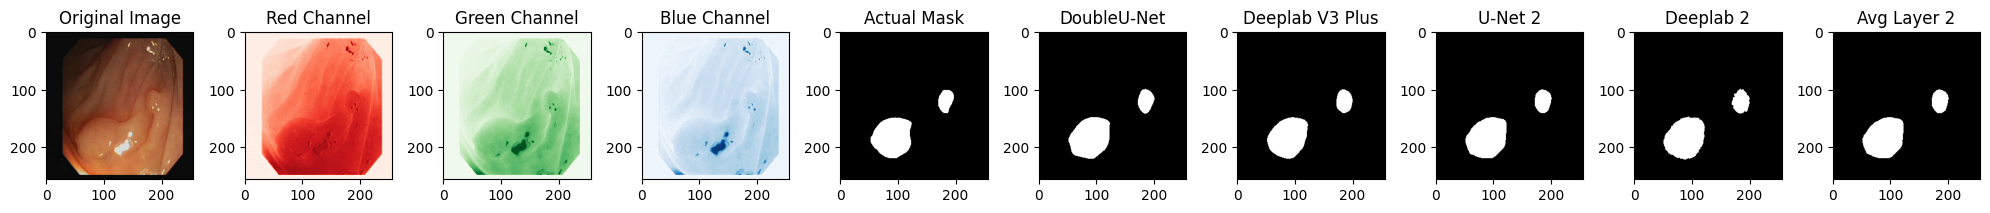

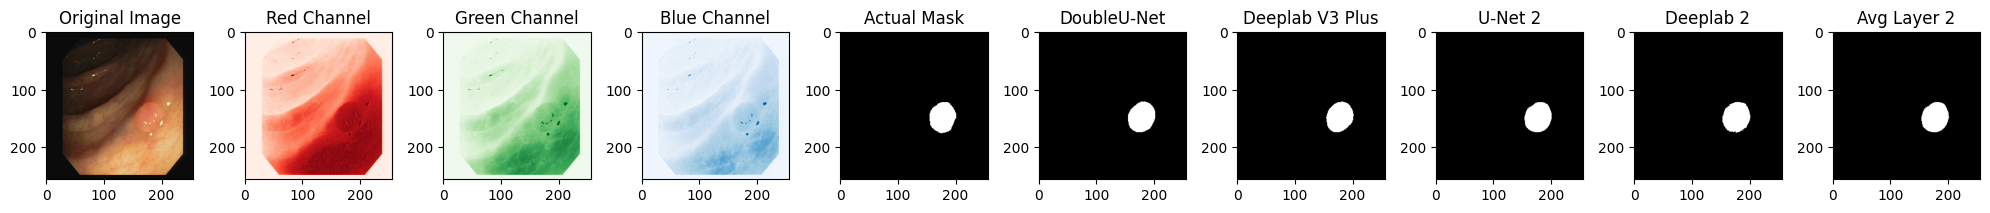

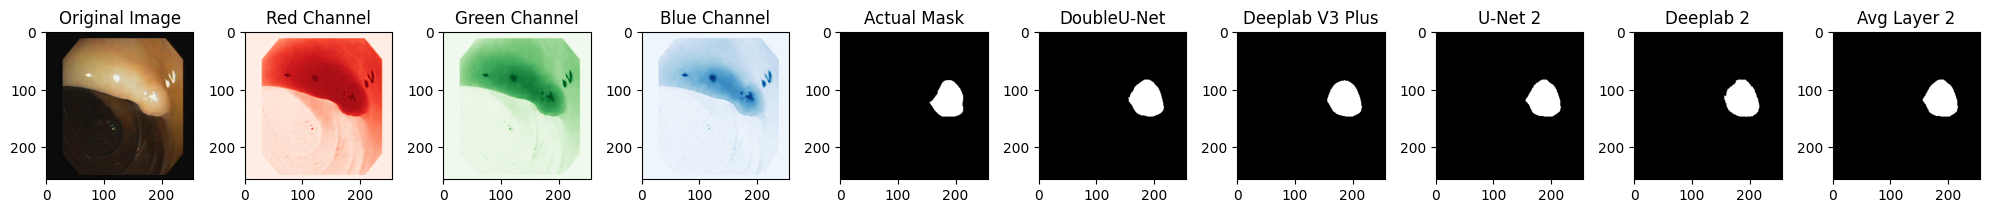

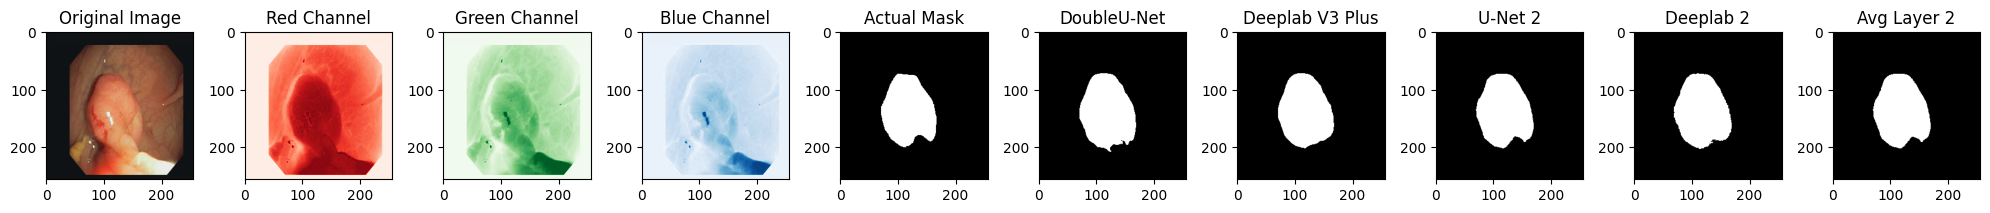

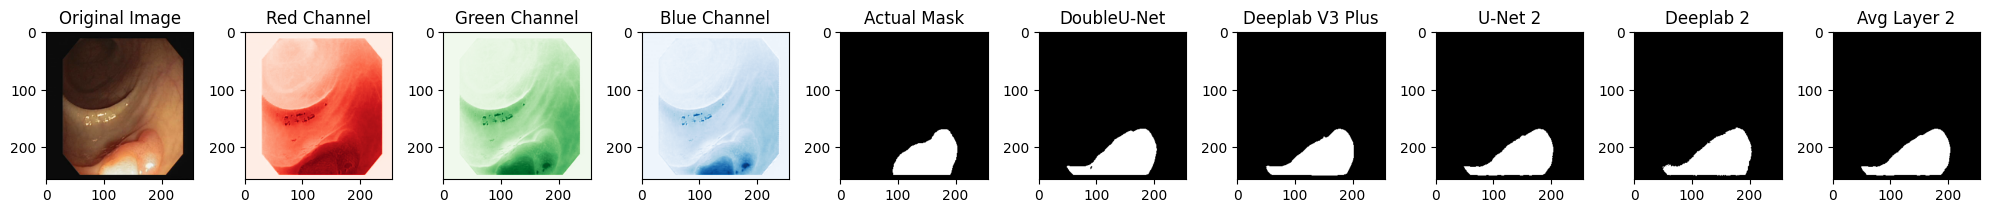

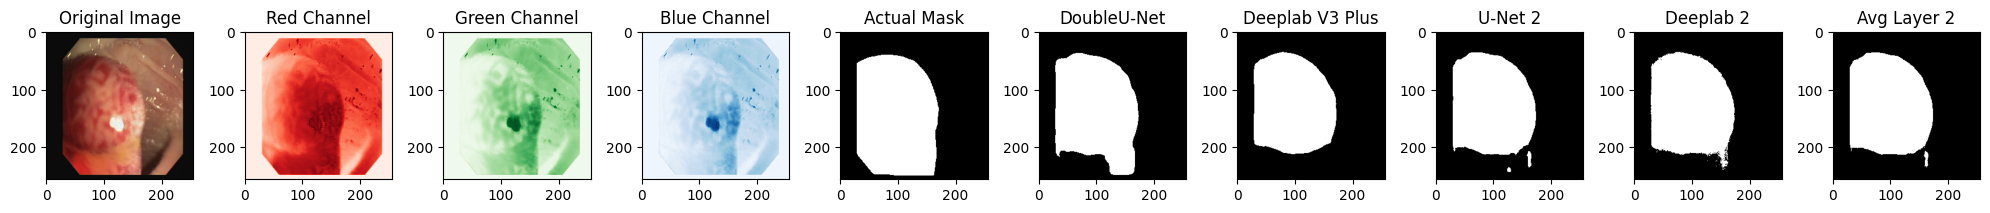

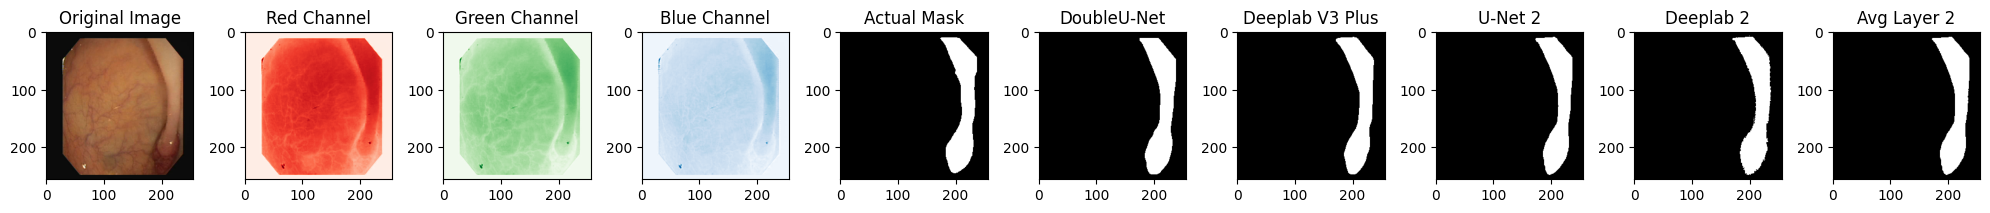

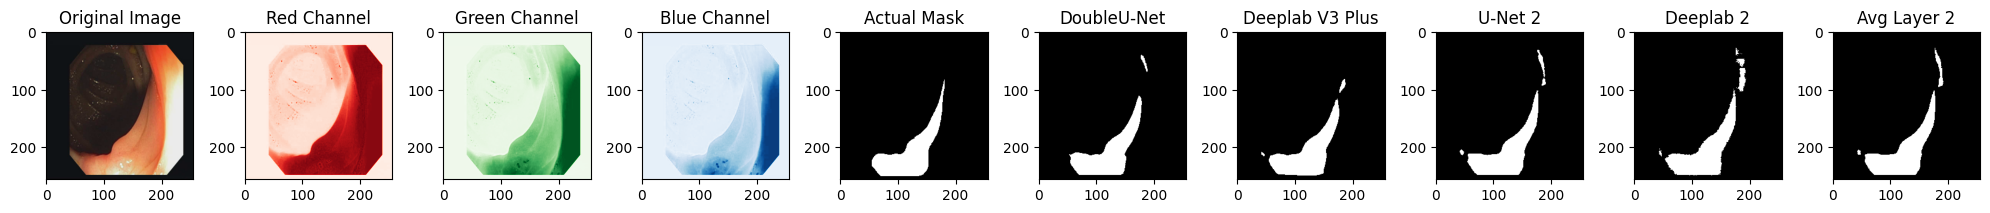

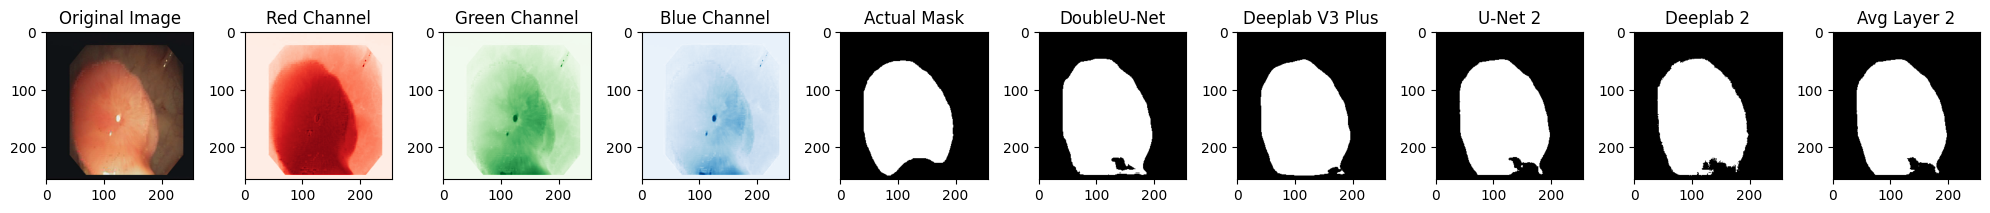

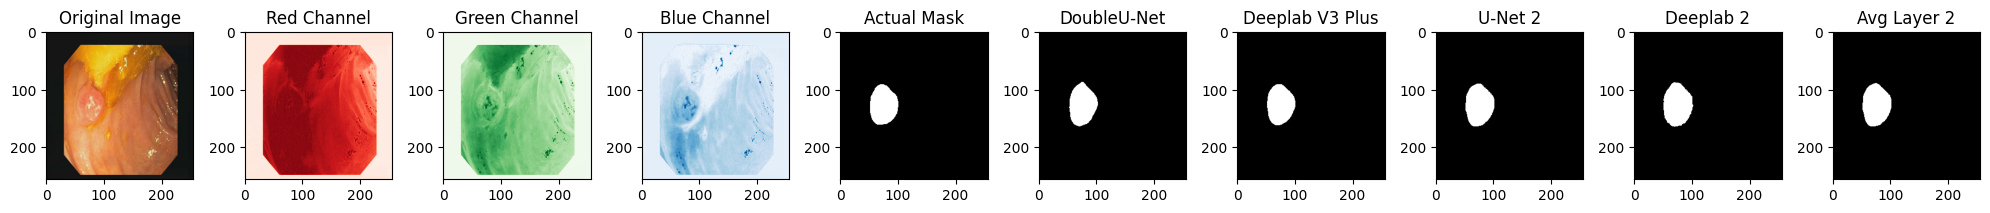

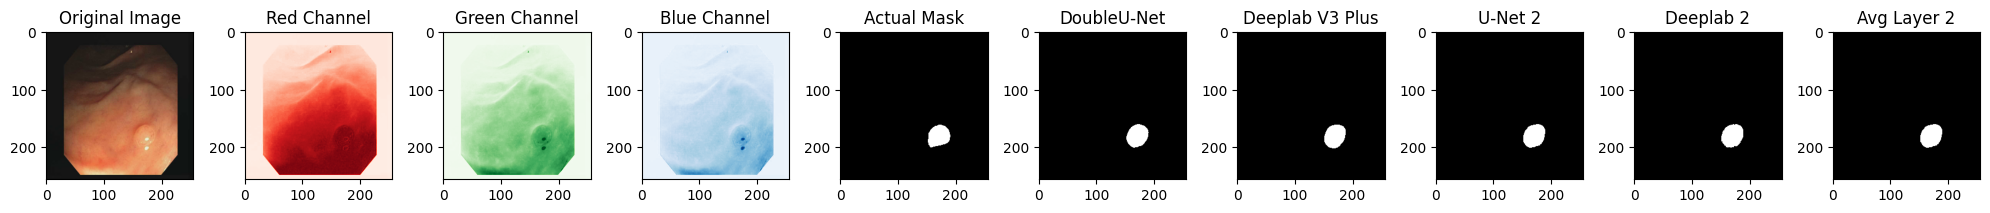

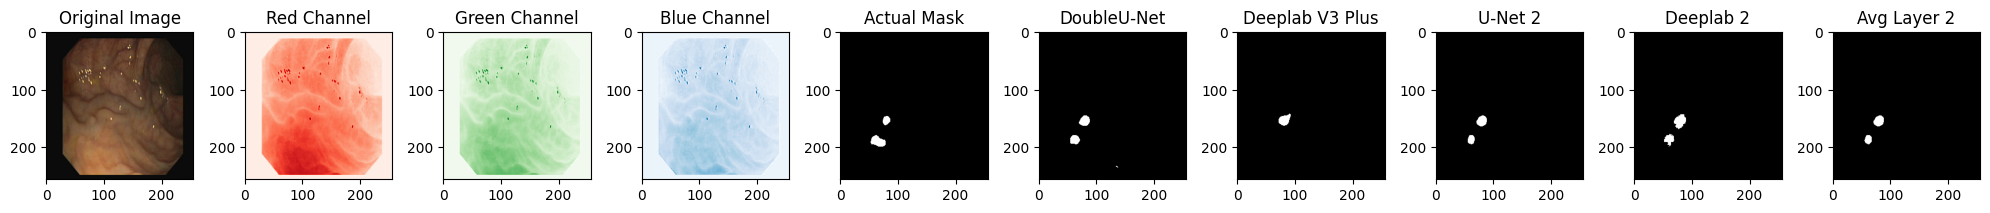

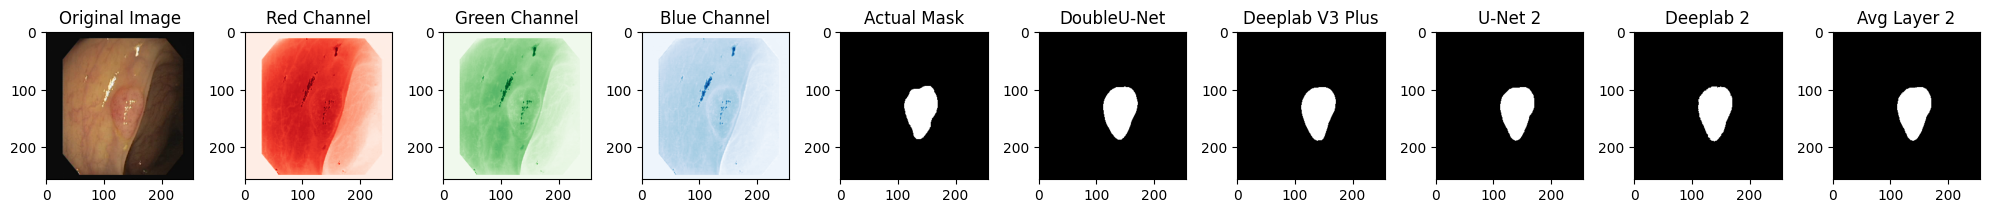

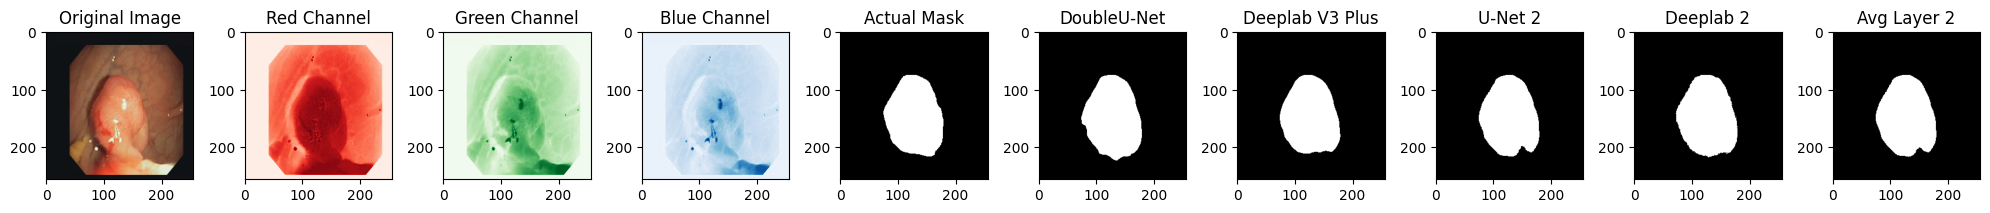

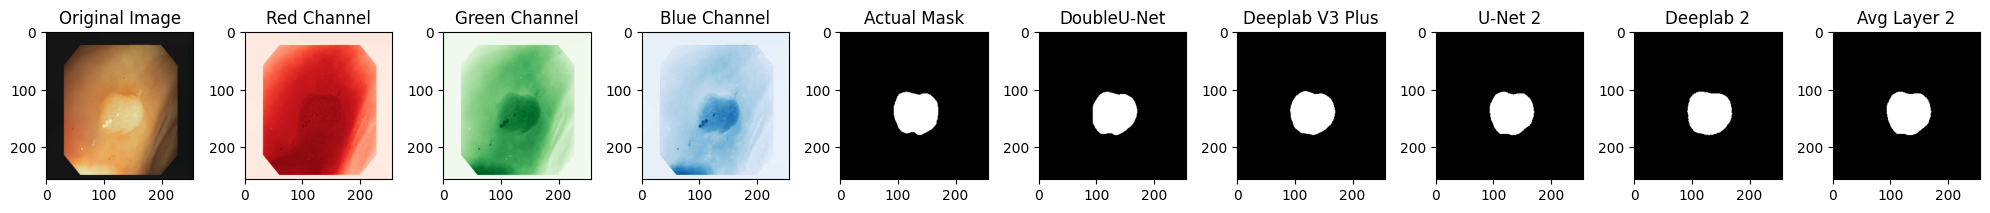

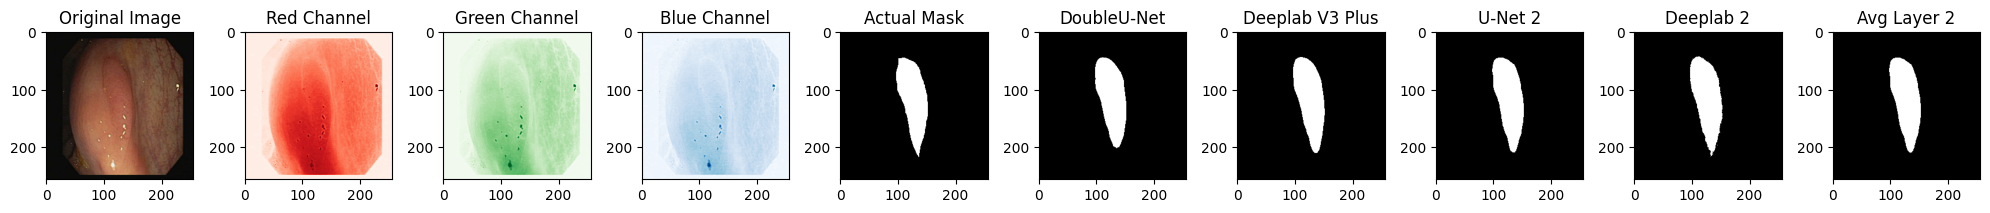

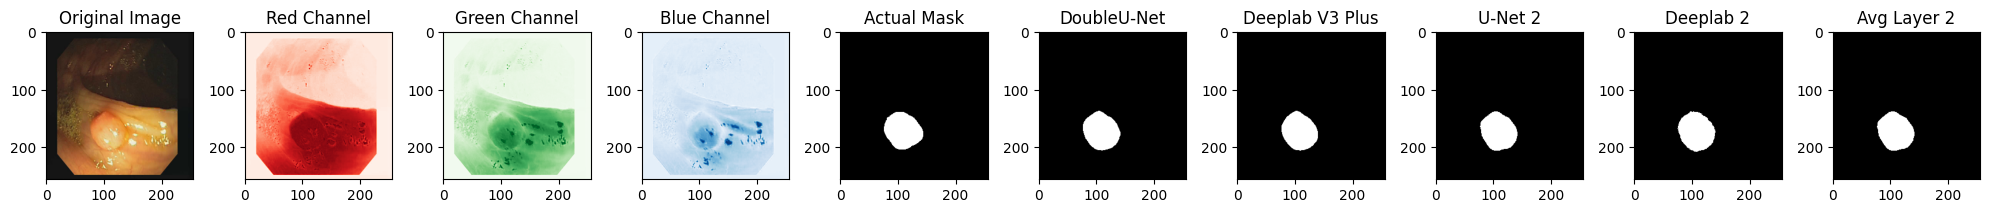

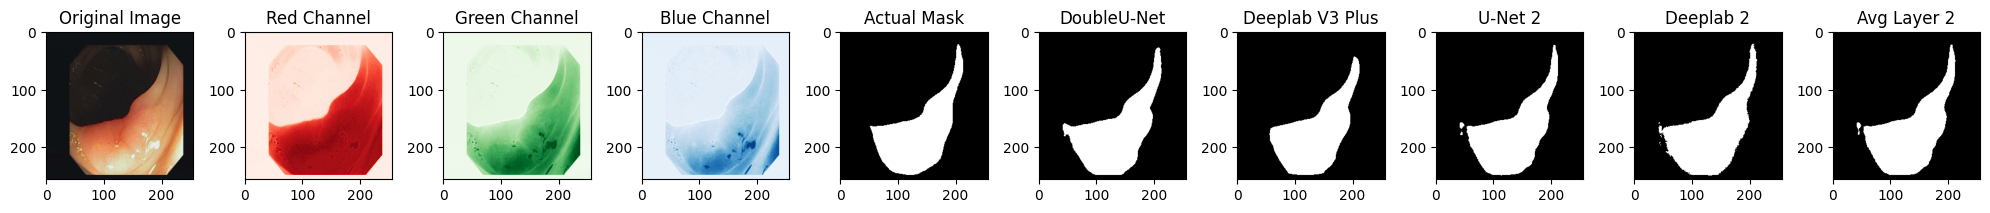

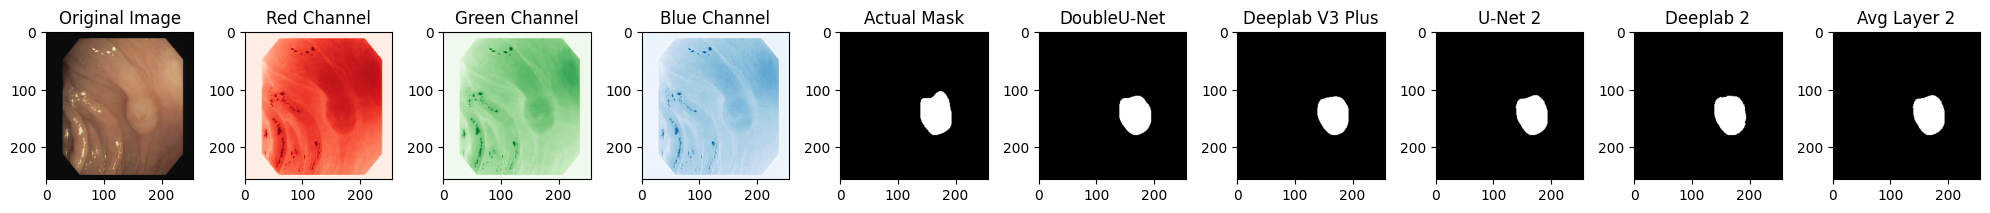

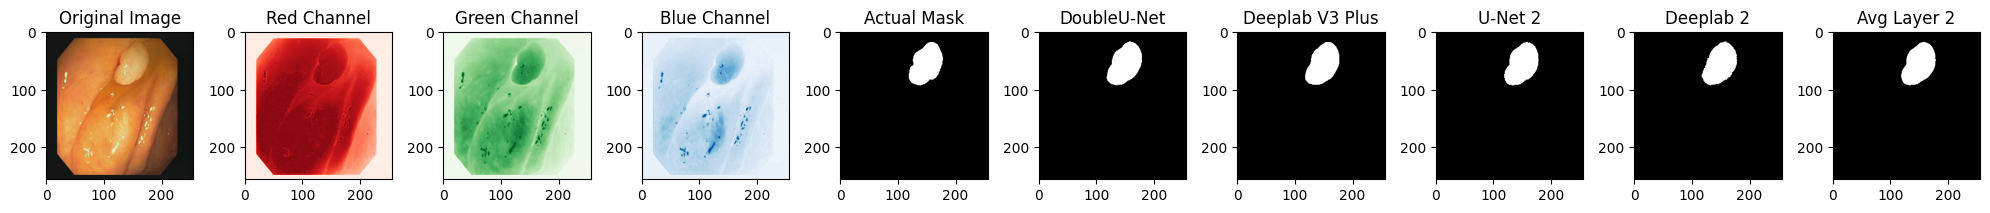

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

num_samples_to_visualize = 20
random_indices = np.random.choice(range(len(X_test)), num_samples_to_visualize, replace=False)

# Visualize each selected sample
for sample_index in random_indices:
    # Load the original image and corresponding mask
    original_image = X_test[sample_index]
    actual_mask = y_test[sample_index]

    # Get predictions for the chosen sample
    doubleunet_prediction = np.round(doubleunet_preds_t[sample_index, ..., 0])
    deeplabv3p_prediction = np.round(deeplabv3p_preds_t[sample_index, ..., 0])
    unet2_prediction = np.round(unet2_preds_t[sample_index, ..., 0])
    deeplab2_prediction = np.round(deeplab2_preds_t[sample_index, ..., 0])
    avg_prediction = np.round(average_preds_test[sample_index])
    # Plot the images and predictions
    plt.figure(figsize=(20, 20))

    plt.subplot(1, 10, 1)
    plt.imshow(original_image)
    plt.title("Original Image")

    plt.subplot(1, 10, 2)
    plt.imshow(original_image[:, :, 0], cmap='Reds')
    plt.title("Red Channel")

    plt.subplot(1, 10, 3)
    plt.imshow(original_image[:, :, 1], cmap='Greens')
    plt.title("Green Channel")

    plt.subplot(1, 10, 4)
    plt.imshow(original_image[:, :, 2], cmap='Blues')
    plt.title("Blue Channel")

    plt.subplot(1, 10, 5)
    plt.imshow(actual_mask, cmap='gray')
    plt.title("Actual Mask")

    plt.subplot(1, 10, 6)
    plt.imshow(doubleunet_prediction, cmap='gray')
    plt.title("DoubleU-Net")

    plt.subplot(1, 10, 7)
    plt.imshow(deeplabv3p_prediction, cmap='gray')
    plt.title("Deeplab V3 Plus")
    
    plt.subplot(1, 10, 8)
    plt.imshow(unet2_prediction, cmap='gray')
    plt.title("U-Net 2")

    plt.subplot(1, 10, 9)
    plt.imshow(deeplab2_prediction, cmap='gray')
    plt.title("Deeplab 2")

    plt.subplot(1, 10, 10)
    plt.imshow(avg_prediction, cmap='gray')
    plt.title("Avg Layer 2")


    plt.tight_layout()
    plt.show()